# NORDic DS: Drug scoring pipeline

## Library Import

In [2]:
import NORDic
! pip freeze | grep "NORDic"

NORDic==2.4.2


In [22]:
import pandas as pd
import os
from subprocess import call as sbcall
from copy import deepcopy
from tqdm import tqdm
import numpy as np
from multiprocessing import cpu_count

In [4]:
from NORDic.NORDic_DS.get_drug_signatures import drugname2pubchem, compute_drug_signatures_L1000
from NORDic.UTILS.LINCS_utils import binarize_via_CD
from NORDic.NORDic_DS.functions import baseline, compute_metrics, simulate, compute_frontier
from NORDic.NORDic_DS.get_drug_targets import retrieve_drug_targets
from NORDic.UTILS.utils_state import binarize_experiments

In [5]:
file_folder="Breast_Cancer/"
seed_number=0
solution_fname=file_folder+"solution_connected.bnet"
file_folder_DS=file_folder+"DS/"
sbcall("mkdir -p "+file_folder_DS, shell=True)
with open(solution_fname, "r") as f:
    genes = [x.split(", ")[0] for x in f.read().split("\n") if (len(x)>0)]

## Drug IC$_{50}$ *z*-score list

Download file ("Export > CSV" on the top right-hand side of the table) at [this link](https://www.cancerrxgene.org/cellline/MCF7/905946?screening_set=GDSC2). Put the file at the following location

In [6]:
file_folder_DS

'Breast_Cancer/DS/'

In [7]:
zIC50 = pd.read_csv(file_folder_DS+"Cellline_downloadWed Apr 19 15 48 11 2023.csv", index_col=1)[["Z Score"]]
zIC50 = -zIC50.loc[~zIC50.index.duplicated()]
zIC50.columns = ["Ground Truth"]
zIC50

Ground Truth
Drug Name                    
Fulvestrant          3.787778
GDC0810              2.666749
Dihydrorotenone      2.489336
Acetalax             2.288104
IAP_5620             2.036345
...                       ...
Teniposide          -1.791786
PRT062607           -1.802077
AZD2014             -1.981558
AZ960               -2.085401
LMP744              -2.321681

[276 rows x 1 columns]

## Drug signatures (target vectors in "BN-based signatures" method in benchmark)

Computed from the [LINCS L1000 database](https://maayanlab.cloud/Harmonizome/resource/LINCS+L1000+Connectivity+Map)

In [8]:
from NORDic.UTILS.LINCS_utils import build_url, get_user_key, binarize_via_CD, download_lincs_files
from NORDic.UTILS.LINCS_utils import create_restricted_drug_signatures
from NORDic.UTILS.utils_data import get_all_celllines
from NORDic.NORDic_DS.get_drug_signatures import pubchem2drugname, retrieve_drug_signature

In [9]:
## Function to compute all signatures related to one of the input PubChem CIDs
def compute_drug_signatures_L1000(pubchem_cids, lincs_args, binarize=True, gene_list=None, chunksize=10):
    '''
        Get drug signatures from LINCS L1000
        @param\tpubchem_cids\tPython integer list: list of drug PubChem CIDs
        @param\tlincs_args\tPython dictionary: additional arguments for LINCS L1000 requests
        @param\tbinarize\tPython bool[default=True]: should the resulting signatures be binarized?
        @return\tsigs\tPandas DataFrame: rows/[genes] x columns/[drug names]
    '''
    assert lincs_args and "credentials" in lincs_args and "path_to_lincs" in lincs_args
    user_key = get_user_key(lincs_args["credentials"])
    path_to_lincs = lincs_args["path_to_lincs"]
    pert_inames = pubchem2drugname(pubchem_cids, lincs_args)
    gene_files, _, _, _ = download_lincs_files(path_to_lincs, which_lvl=[3])
    gene_df = pd.read_csv(path_to_lincs+gene_files[0], sep="\t", engine='python', index_col=0)
    geneEI_list, gene_name_list = list(gene_df.index), list(gene_df["pr_gene_symbol"])
    geneEI_list = [geneEI_list[i] for i, x in enumerate(gene_name_list) if (x in gene_list)]
    sigs_list = [retrieve_drug_signature(pubchem_cid, get_all_celllines([pert_inames[pubchem_cid]], user_key) if (len(lincs_args.get("cell_lines", []))==0) else lincs_args["cell_lines"], geneEI_list, lincs_args, binarize) for pubchem_cid in pubchem_cids]
    sigs = sigs_list[0].join(sigs_list[1:], how="outer")
    sigs.index = [gene_df.loc[i]["pr_gene_symbol"] for i in sigs.index]
    return sigs

In [11]:
## Parameters to access LINCS L1000 files
## To modify as needed
LINCS_args = {
        "path_to_lincs": "/media/kali/1b80f30d-2803-4260-a792-9ae206084252/Code/M30/NetworkOrientedRepurposingofDrugs/lincs/",
        "credentials": "/media/kali/1b80f30d-2803-4260-a792-9ae206084252/Code/M30/NetworkOrientedRepurposingofDrugs/tests/credentials_LINCS.txt",
        "selection": "distil_ss", 
        "nsigs": 2,
        "cell_lines": ["MCF7"],
}

In [12]:
signature_fname=file_folder_DS+"signatures_drugs_binarized.csv"
pubchem_fname=file_folder_DS+"pubchem_drugs.csv"
drug_names = [g for g in list(zIC50.index)] 

from tqdm import tqdm
if (not os.path.exists(signature_fname)):
    if (not os.path.exists(pubchem_fname)):
        pubchem_cids_dict = {}
        for drug in tqdm(drug_names):
            try:
                pubchem_cids_dict.update(drugname2pubchem([drug], LINCS_args))
            except:
                continue
        pubchem_df = pd.DataFrame({"PubChemCID": pubchem_cids_dict})
        pubchem_df.to_csv(pubchem_fname)
    pubchem_df = pd.read_csv(pubchem_fname, index_col=0).dropna()
    pubchem_cids = list(pubchem_df["PubChemCID"].astype(int))
    drug_lst = list(pd.read_csv(pubchem_fname, index_col=0).dropna()["PubChemCID"].astype(int))
    signatures = []
    for drug in tqdm(drug_lst):
        try:
            sig = compute_drug_signatures_L1000(drug_lst, LINCS_args, binarize=True, gene_list=genes)
            sig.columns = [drug]
            signatures.append(sig)
        except:
            continue
    signatures = signatures[0].join(signatures[1:], how="outer")
    signatures.columns = [list(pubchem_df.loc[pubchem_df["PubChemCID"]==p].index)[0] for p in signatures.columns]
    signatures.to_csv(signature_fname)
signatures = pd.read_csv(signature_fname, index_col=0)
signatures = signatures.T.dropna(how="all").T
signatures

Afatinib  Alisertib  Axitinib  Bortezomib  Bosutinib  Buparlisib  \
RHOA           NaN        1.0       NaN         1.0        1.0         0.0   
HSP90AB1       1.0        NaN       NaN         1.0        0.0         1.0   
YWHAZ          NaN        1.0       0.0         NaN        1.0         NaN   
HMGB1          NaN        1.0       NaN         0.0        1.0         NaN   
CTNNA1         NaN        0.0       NaN         NaN        0.0         0.0   
...            ...        ...       ...         ...        ...         ...   
KIF18A         NaN        NaN       0.0         NaN        1.0         NaN   
SOD2           NaN        1.0       1.0         1.0        0.0         1.0   
CDCA8          NaN        0.0       NaN         NaN        1.0         1.0   
LRP6           NaN        1.0       1.0         NaN        0.0         1.0   
GSK3A          NaN        NaN       NaN         NaN        0.0         NaN   

          Camptothecin  Cediranib  Crizotinib  Cyclophosphamide  Cytarabine  \
RHOA               0.0        0.0         1.0               1.0         1.0   
HSP90AB1           1.0        0.0         NaN               1.0         NaN   
YWHAZ              0.0        0.0         1.0               1.0         1.0   
HMGB1              1.0        0.0         NaN               1.0         NaN   
CTNNA1             0.0        1.0         0.0               0.0         NaN   
...                ...        ...         ...               ...         ...   
KIF18A             1.0        0.0         NaN               1.0         NaN   
SOD2               1.0        1.0         1.0               1.0         NaN   
CDCA8              1.0        0.0         NaN               1.0         NaN   
LRP6               0.0        0.0         NaN               1.0         NaN   
GSK3A              0.0        0.0         NaN               NaN         NaN   

          Dacarbazine  Dactinomycin  Dasatinib  Docetaxel  Doramapimod  \
RHOA              1.0           0.0        NaN        1.0          0.0   
HSP90AB1          1.0           NaN        NaN        0.0          1.0   
YWHAZ             0.0           NaN        NaN        0.0          0.0   
HMGB1             1.0           NaN        NaN        0.0          1.0   
CTNNA1            0.0           NaN        NaN        1.0          1.0   
...               ...           ...        ...        ...          ...   
KIF18A            1.0           1.0        NaN        0.0          1.0   
SOD2              NaN           1.0        NaN        0.0          0.0   
CDCA8             1.0           NaN        NaN        1.0          0.0   
LRP6              1.0           NaN        NaN        1.0          0.0   
GSK3A             1.0           NaN        NaN        1.0          1.0   

          Entinostat  Erlotinib  Fludarabine  Foretinib  Fulvestrant  \
RHOA             1.0        1.0          NaN        0.0          NaN   
HSP90AB1         0.0        1.0          NaN        1.0          0.0   
YWHAZ            1.0        0.0          NaN        0.0          1.0   
HMGB1            0.0        0.0          NaN        0.0          0.0   
CTNNA1           0.0        0.0          NaN        0.0          0.0   
...              ...        ...          ...        ...          ...   
KIF18A           0.0        0.0          NaN        1.0          0.0   
SOD2             1.0        0.0          NaN        1.0          1.0   
CDCA8            0.0        0.0          NaN        1.0          NaN   
LRP6             1.0        1.0          NaN        NaN          1.0   
GSK3A            0.0        1.0          NaN        0.0          1.0   

          Gefitinib  Gemcitabine  Ibrutinib  Irinotecan  Lapatinib  \
RHOA            NaN          0.0        0.0         NaN        1.0   
HSP90AB1        NaN          0.0        NaN         NaN        0.0   
YWHAZ           NaN          NaN        NaN         NaN        1.0   
HMGB1           NaN          0.0        0.0         NaN        0.0   
CTNNA1          NaN 

## Drug targets (target vectors in "BN-based targets" method in benchmark)

Retrieved from several public databases.

In [13]:
from NORDic.NORDic_DS.get_drug_targets import retrieve_drug_targets

In [14]:
## Parameters to access the databases
LINCS_args = {
        "path_to_lincs": "../NetworkOrientedRepurposingofDrugs/lincs/",
        "credentials": "../NetworkOrientedRepurposingofDrugs/tests/credentials_LINCS.txt",
        "selection": "distil_ss", 
        "nsigs": 2,
}

target_args = {
    "DrugBank": {
        "path_to_drugbank": "../NetworkOrientedRepurposingofDrugs/DrugBank/", 
        "drug_fname": "COMPLETE DATABASE/full database.xml", 
        "target_fname": "PROTEIN IDENTIFIERS/Drug Target Identifiers/all.csv"
    },
    "LINCS": LINCS_args,
}

In [15]:
drug_names = list(signatures.columns)
targets = retrieve_drug_targets(file_folder, drug_names, gene_list=genes, TARGET_args=target_args)
targets

<DRUG_TARGETS> MINERVA
<DRUG_TARGETS> DrugBank
<DRUG_TARGETS> LINCS
<DRUG_TARGETS> TTD
<DRUG_TARGETS> DrugCentral


Afatinib  Alisertib  Axitinib  Bortezomib  Bosutinib  Buparlisib  \
TFDP1            0          0         0           0          0           0   
CDC27            0          0         0           0          0           0   
VHL              0          0         0           0          0           0   
FZD10            0          0         0           0          0           0   
CDK1             0          0         0           0          0           0   
...            ...        ...       ...         ...        ...         ...   
PRKCZ            0          0         0           0          0           0   
VCAM1            0          0         0           0          0           0   
AKT1             0          0         0           0          0           0   
HDAC1            0          0         0           0          0           0   
HSP90AB1         0          0         0           0          0           0   

          Camptothecin  Cediranib  Crizotinib  Cyclophosphamide  Cytarabine  \
TFDP1                0          0           0                 0           0   
CDC27                0          0           0                 0           0   
VHL                  0          0           0                 0           0   
FZD10                0          0           0                 0           0   
CDK1                 0          0           0                 0           0   
...                ...        ...         ...               ...         ...   
PRKCZ                0          0           0                 0           0   
VCAM1                0          0           0                 0           0   
AKT1                 0          0           0                 0           0   
HDAC1                0          0           0                 0           0   
HSP90AB1             0          0           0                 0           0   

          Dacarbazine  Dactinomycin  Dasatinib  Docetaxel  Doramapimod  \
TFDP1               0             0          0          0            0   
CDC27               0             0          0          0            0   
VHL                 0             0          0          0            0   
FZD10               0             0          0          0            0   
CDK1                0             0          0          0            0   
...               ...           ...        ...        ...          ...   
PRKCZ               0             0          0          0            0   
VCAM1               0             0          0          0            0   
AKT1                0             0          0          0            0   
HDAC1               0             0          0          0            0   
HSP90AB1            0             0          0          0            0   

          Entinostat  Erlotinib  Fludarabine  Foretinib  Fulvestrant  \
TFDP1              0          0            0          0            0   
CDC27              0          0            0          0            0   
VHL                0          0            0          0            0   
FZD10              0          0            0          0            0   
CDK1               0          0            0          0            0   
...              ...        ...          ...        ...          ...   
PRKCZ              0          0            0          0            0   
VCAM1              0          0            0          0            0   
AKT1               0          0            0          0            0   
HDAC1             -1         -1           -1         -1           -1   
HSP90AB1           0          0            0          0            0   

          Gefitinib  Gemcitabine  Ibrutinib  Irinotecan  Lapatinib  \
TFDP1             0            0          0           0          0   
CDC27             0            0          0           0          0   
VHL               0            0          0           0          0   
FZD10             0            0          0           0          0   
CDK1              0 

## Differential phenotype

Quantifies the genewise changes in expression between patients and controls, to compare attractor states reached post-treatment.

In [16]:
from glob import glob
from io import StringIO

In [17]:
path_to_initial_states=file_folder+"initial_states.csv"

if (not os.path.exists(path_to_initial_states)):
    if (not os.path.exists(file_folder+"GPL570-55999.txt")):
        wget_cmd="wget -qO "+file_folder+"GPL570-55999.txt https://figshare.com/ndownloader/files/14892863"
        sbcall(wget_cmd, shell=True)
    df = pd.read_fwf(file_folder+"GPL570-55999.txt", header=None)
    df = df[df.columns[0]].str.split('\t', expand=True)
    df.index = df[0]
    df.columns = list(df.loc["ID"])
    platform = df[["Gene Symbol"]]

    if (not os.path.exists("GSE42568.tsv")):
        if (not os.path.exists("GSE42568_RAW.tar")):
            url_GSE42568="https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE42568&format=file"
            sbcall("wget -qnc -O GSE42568_RAW.tar \""+url_GSE42568+"\"", shell=True)
        fnames = glob("GSM*_*.CEL.gz")
        if (len(glob("GSM*_*.CEL.gz"))==0):
            sbcall("tar -xvf GSE42568_RAW.tar", shell=True)
        ##http://homer.ucsd.edu/homer/basicTutorial/affymetrix.html
        R_cmds = ["if (!require(\'BiocManager\', quietly = TRUE)) install.packages(\'BiocManager\')"]
        R_cmds += ["BiocManager::install(version = \'3.16\')"]
        R_cmds += ["BiocManager::install(\'affy\')"]
        R_cmds += ["library(affy)"]
        R_cmds += ["eset <- rma(ReadAffy())"]
        R_cmds += ["write.exprs(eset,file=\'GSE42568.tsv\')"]
        sbcall('R -e \"'+";".join(R_cmds)+'\"')
        sbcall("rm -f "+" ".join(glob("GSM*_*.CEL")+glob("GSM*_*.CEL.gz")), shell=True)

    df = pd.read_csv("GSE42568.tsv", index_col=0, sep="\t")
    df.columns = [col.split("_")[0] for col in df.columns]
    df = df.loc[["AFFX" not in i for i in df.index]]

    idx = platform.loc[df.index]
    idx = platform.loc[[any([ii in genes for ii in i.split(" /// ")]) if (i is not None) else False for i in platform[platform.columns[0]]]]
    df = df.loc[idx.index]
    df.index = [ii for i in idx["Gene Symbol"] for ii in i.split(" /// ") if (ii in genes)]
    df = df.groupby(level=0).mean()

    df.to_csv(path_to_initial_states)

df = pd.read_csv(path_to_initial_states, index_col=0)
df

GSM1045191  GSM1045192  GSM1045193  GSM1045194  GSM1045195  \
AKT1       6.619215    6.675653    5.827117    6.220499    6.724035   
AKT2       4.834284    5.112994    4.949835    5.090875    5.092740   
AKT3       4.889907    4.477291    4.291377    4.403879    5.109815   
ANAPC1     6.382061    5.866938    5.676849    5.292880    6.457570   
ANAPC10    5.523269    3.948003    4.599613    4.663279    5.948360   
...             ...         ...         ...         ...         ...   
WNT1       3.357863    4.766983    4.256497    5.224922    3.715944   
WNT10B     5.337987    6.608275    6.347833    6.107692    5.512613   
WNT5A      5.355645    3.825653    3.882238    6.582373    4.402100   
YAP1       7.989616    5.056553    4.714317    6.575736    8.406037   
YWHAZ      8.648548    8.005569    8.601235    7.643340    8.866844   

         GSM1045196  GSM1045197  GSM1045198  GSM1045199  GSM1045200  \
AKT1       7.394612    7.196303    7.101973    7.260151    7.164177   
AKT2       5.230939    5.198944    5.253522    5.275729    5.229603   
AKT3       4.503196    4.397289    4.694546    4.647888    4.469702   
ANAPC1     6.715276    6.161839    6.295661    7.072192    6.586583   
ANAPC10    6.171156    5.981069    5.662648    6.370761    4.858044   
...             ...         ...         ...         ...         ...   
WNT1       3.282370    3.747788    4.021536    3.706069    3.588714   
WNT10B     5.910352    6.172102    5.431164    5.880999    6.199931   
WNT5A      4.602762    4.479928    4.314092    5.132994    5.226937   
YAP1       8.477348    8.993672    8.687003    8.796870    7.474111   
YWHAZ      8.937116    9.150847    9.002748    9.406055    7.738835   

         GSM1045201  GSM1045202  GSM1045203  GSM1045204  GSM1045205  \
AKT1       6.457104    7.238176    5.999602    6.743407    7.162128   
AKT2       4.914748    5.102192    5.188996    5.139472    5.223295   
AKT3       4.684060    4.869235    4.980280    4.865738    4.604253   
ANAPC1     5.883390    6.494180    5.881881    6.670872    6.356671   
ANAPC10    5.631832    6.580296    5.061280    5.792297    6.171160   
...             ...         ...         ...         ...         ...   
WNT1       4.592747    3.951362    3.454060    3.380379    3.553687   
WNT10B     5.742310    5.629911    6.340740    5.775007    5.861415   
WNT5A      4.785797    6.094123    4.380406    5.459858    4.368888   
YAP1       7.800111    8.631495    7.852276    8.969075    8.858756   
YWHAZ      8.689258    9.270014    8.570399    8.918941    9.131870   

         GSM1045206  GSM1045207  GSM1045208  GSM1045209  GSM1045210  \
AKT1       7.118416    7.247693    7.876753    6.872936    7.129443   
AKT2       5.359917    5.306887    5.040511    5.189066    5.054854   
AKT3       4.603740    4.597865    4.147750    4.640785    4.172503   
ANAPC1     6.052561    6.032348    6.118365    6.317654    5.802371   
ANAPC10    5.371066    6.185214    4.591232    4.746038    4.557493   
...             ...         ...         ...         ...         ...   
WNT1       3.747788    3.622698    4.082252    3.692406    3.950639   
WNT10B     6.248617    6.466997    6.135214    6.136209    5.638806   
WNT5A      3.630873    4.665930    4.137340    4.509239    4.049726   
YAP1       8.028820    8.678065    6.234813    6.193478    6.068447   
YWHAZ      8.776459    8.833666    8.555760    8.272494    8.427382   

         GSM1045211  GSM1045212  GSM1045213  GSM1045214  GSM1045215  \
AKT1       6.683792    7.861256    6.762084    6.732272    8.291463   
AKT2       5.053372    5.237815    5.050376    5.325497    4.817782   
AKT3       4.330131    4.585817    4.778955    4.423354    4.692595   
ANAPC1     5.864746    6.353679    5.939639    5.945409    6.079419   
ANAPC10    4.079150    4.761649    4.220972    5.376244    4.849317   
...             ...         ...         ...         ...         ...   
WNT1       4.533314    3.806054    3.644937    3.914072    3.568659   
WNT10B     6.482290    5.8321

To process the metadata on the dataset, copy the "Samples (121)" section at [the dataset repository](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE42568) into file ``metadata_GSE42568.tsv``.

In [18]:
diffpheno_fname = file_folder+"diffpheno.csv"

if (not os.path.exists(diffpheno_fname)):
    assert os.path.exists("metadata_GSE42568.tsv")
    metadata = pd.read_csv("metadata_GSE42568.tsv", index_col=0, sep=" \t", engine="python", header=None)
    ## select cancer samples
    metadata_patients = metadata.loc[[i for i in metadata.index if ("cancer" in metadata.loc[i][1])]]
    metadata_controls = metadata.loc[[i for i in metadata.index if ("cancer" not in metadata.loc[i][1])]]
    patients = df[[i for i in metadata_patients.index if (i in df.columns)]]
    controls = df[[i for i in metadata_controls.index if (i in df.columns)]]
    print("N=%d patients, N=%d controls" % (patients.shape[1], controls.shape[1]))
    phenotypes = pd.concat((patients, controls), axis=1)
    phenotypes.loc["annotation"] = [2]*patients.shape[1]+[1]*controls.shape[1]
    dfsdata = phenotypes.loc[[idx for idx in phenotypes.index if (idx!="annotation")]]
    samples = list(phenotypes.loc["annotation"])
    differential_phenotype = binarize_via_CD(dfsdata, samples=samples, binarize=0, nperm=int(1e4))
    differential_phenotype.to_csv(diffpheno_fname)
differential_phenotype = pd.read_csv(diffpheno_fname, index_col=0)

signatures.join(differential_phenotype, how="inner")

Afatinib  Alisertib  Axitinib  Bortezomib  Bosutinib  Buparlisib  \
RHOA           NaN        1.0       NaN         1.0        1.0         0.0   
HSP90AB1       1.0        NaN       NaN         1.0        0.0         1.0   
YWHAZ          NaN        1.0       0.0         NaN        1.0         NaN   
HMGB1          NaN        1.0       NaN         0.0        1.0         NaN   
CTNNA1         NaN        0.0       NaN         NaN        0.0         0.0   
...            ...        ...       ...         ...        ...         ...   
KIF18A         NaN        NaN       0.0         NaN        1.0         NaN   
SOD2           NaN        1.0       1.0         1.0        0.0         1.0   
CDCA8          NaN        0.0       NaN         NaN        1.0         1.0   
LRP6           NaN        1.0       1.0         NaN        0.0         1.0   
GSK3A          NaN        NaN       NaN         NaN        0.0         NaN   

          Camptothecin  Cediranib  Crizotinib  Cyclophosphamide  Cytarabine  \
RHOA               0.0        0.0         1.0               1.0         1.0   
HSP90AB1           1.0        0.0         NaN               1.0         NaN   
YWHAZ              0.0        0.0         1.0               1.0         1.0   
HMGB1              1.0        0.0         NaN               1.0         NaN   
CTNNA1             0.0        1.0         0.0               0.0         NaN   
...                ...        ...         ...               ...         ...   
KIF18A             1.0        0.0         NaN               1.0         NaN   
SOD2               1.0        1.0         1.0               1.0         NaN   
CDCA8              1.0        0.0         NaN               1.0         NaN   
LRP6               0.0        0.0         NaN               1.0         NaN   
GSK3A              0.0        0.0         NaN               NaN         NaN   

          Dacarbazine  Dactinomycin  Dasatinib  Docetaxel  Doramapimod  \
RHOA              1.0           0.0        NaN        1.0          0.0   
HSP90AB1          1.0           NaN        NaN        0.0          1.0   
YWHAZ             0.0           NaN        NaN        0.0          0.0   
HMGB1             1.0           NaN        NaN        0.0          1.0   
CTNNA1            0.0           NaN        NaN        1.0          1.0   
...               ...           ...        ...        ...          ...   
KIF18A            1.0           1.0        NaN        0.0          1.0   
SOD2              NaN           1.0        NaN        0.0          0.0   
CDCA8             1.0           NaN        NaN        1.0          0.0   
LRP6              1.0           NaN        NaN        1.0          0.0   
GSK3A             1.0           NaN        NaN        1.0          1.0   

          Entinostat  Erlotinib  Fludarabine  Foretinib  Fulvestrant  \
RHOA             1.0        1.0          NaN        0.0          NaN   
HSP90AB1         0.0        1.0          NaN        1.0          0.0   
YWHAZ            1.0        0.0          NaN        0.0          1.0   
HMGB1            0.0        0.0          NaN        0.0          0.0   
CTNNA1           0.0        0.0          NaN        0.0          0.0   
...              ...        ...          ...        ...          ...   
KIF18A           0.0        0.0          NaN        1.0          0.0   
SOD2             1.0        0.0          NaN        1.0          1.0   
CDCA8            0.0        0.0          NaN        1.0          NaN   
LRP6             1.0        1.0          NaN        NaN          1.0   
GSK3A            0.0        1.0          NaN        0.0          1.0   

          Gefitinib  Gemcitabine  Ibrutinib  Irinotecan  Lapatinib  \
RHOA            NaN          0.0        0.0         NaN        1.0   
HSP90AB1        NaN          0.0        NaN         NaN        0.0   
YWHAZ           NaN          NaN        NaN         NaN        1.0   
HMGB1           NaN          0.0        0.0         NaN        0.0   
CTNNA1          NaN 

## Baseline scores  (target vectors in "L$1000$ CDS$^2$" method in benchmark)

For more information, please check out the [corresponding paper](https://pubmed.ncbi.nlm.nih.gov/28413689/).

In [19]:
if (not os.path.exists(file_folder+"DS/scores_baseline.csv")):
    scores_baseline = pd.concat(tuple([baseline(signatures[[c]], differential_phenotype, is_binary=False) for c in signatures.columns]), axis=0)
    scores_baseline = scores_baseline.sort_values(by="Cosine Score", ascending=False).join(zIC50, how="inner")
    scores_baseline.to_csv(file_folder+"DS/scores_baseline.csv")
scores_baseline = pd.read_csv(file_folder+"DS/scores_baseline.csv", index_col=0)
print("rho=%.3f (%d drugs)"% (scores_baseline.corr(method="spearman").values[0,1], scores_baseline.shape[0]))
scores_baseline

rho=-0.015 (58 drugs)


Cosine Score  Ground Truth
Tozasertib            0.123142     -0.635237
Alisertib             0.122781     -1.089532
Vincristine           0.119081     -0.259227
Dactinomycin          0.115374     -0.399933
Entinostat            0.106901     -0.974598
Olaparib              0.102183     -0.849672
Temozolomide          0.094073     -0.858512
Veliparib             0.079109     -0.520686
Vinblastine           0.076232     -0.653699
Crizotinib            0.075821     -0.943121
Dasatinib             0.075246     -1.485985
Sorafenib             0.072674      0.590431
Staurosporine         0.070390     -0.976563
Tamoxifen             0.068290      1.051750
Irinotecan            0.066508     -1.518890
Selumetinib           0.066415     -1.211471
Temsirolimus          0.056886      0.657906
Tanespimycin          0.046888      0.104295
Gemcitabine           0.045064     -0.316027
Motesanib             0.041820     -0.683179
Cediranib             0.037178     -1.235857
Lapatinib             0.027526      0.553837
Vorinostat            0.027508      0.156631
Serdemetan            0.025948     -0.419545
Palbociclib           0.025919     -0.339175
Foretinib             0.025394     -0.259120
Cyclophosphamide      0.023754     -0.197816
Mirin                 0.018739     -0.349519
Nilotinib             0.016448      0.540146
Lestaurtinib          0.009031     -1.384336
Buparlisib            0.002856      0.437520
Docetaxel             0.000276     -0.091818
Fludarabine           0.000000     -0.793605
Bosutinib            -0.000668     -1.145831
Rucaparib            -0.003684     -0.913147
Camptothecin         -0.005950     -0.226218
Fulvestrant          -0.010253      3.787778
Navitoclax           -0.011649     -0.178700
Linsitinib           -0.014396      0.605494
Trametinib           -0.015067     -1.619687
Leflunomide          -0.018033     -0.547775
Gefitinib            -0.019631     -1.198466
Axitinib             -0.020616     -0.177053
Ibrutinib            -0.023626     -1.197613
Vinorelbine          -0.024111     -0.309547
Teniposide           -0.025453     -1.791786
Dacarbazine          -0.026761      1.304749
Ruxolitinib          -0.027502     -0.623772
Bortezomib           -0.027755      0.225264
Topotecan            -0.031797     -1.122632
Cytarabine           -0.031994     -0.993241
Erlotinib            -0.032378     -1.090574
Mitoxantrone         -0.036901     -1.162713
Doramapimod          -0.041720      0.317206
Methotrexate         -0.047993      0.057696
Paclitaxel           -0.080090     -0.081442
Lenalidomide         -0.096614     -0.922069
Afatinib             -0.119130     -1.106644

## Network-oriented scoring ("BN-based targets" and "BN-based signatures")

### Definition of the scoring scheme

In [ ]:
from NORDic.UTILS.utils_state import binarize_experiments
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import random

random.seed(0)
np.random.seed(0)

In [17]:
## Define the function which determines whether a state is closer to controls/patients
dfsdata = phenotypes.loc[[idx for idx in phenotypes.index if (idx!="annotation")]]
bin_mat = binarize_experiments(dfsdata, thres=0.5, method="binary")
bin_mat = bin_mat.dropna() ##
states = bin_mat.astype(int)

samples = list(phenotypes.loc["annotation"])

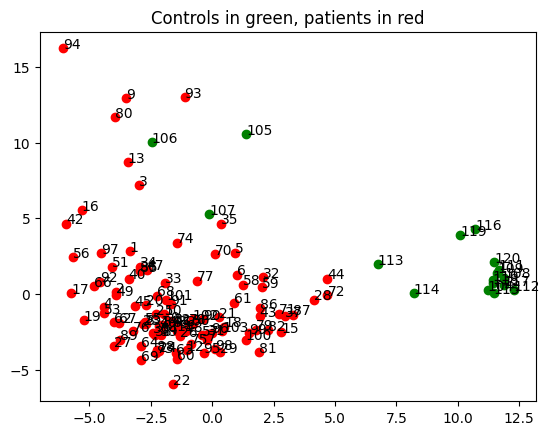

In [18]:
n_components=2
pca, scaler = PCA(n_components=n_components), StandardScaler()
X = states.values.T
X_pca = pca.fit_transform(scaler.fit_transform(X))
for i in range(X_pca.shape[0]): 
    plt.scatter(X_pca[i,0], X_pca[i,1], c="g" if (samples[i]==1) else "r")
    plt.text(X_pca[i,0], X_pca[i,1], s=i)
plt.title("Controls in green, patients in red")
plt.show()

In [19]:
outliers_ctrls = [105,106,107]
samples = [samples[i] for i in range(len(samples)) if (i not in outliers_ctrls)]
states = states[[states.columns[i] for i in range(len(samples)) if (i not in outliers_ctrls)]]

In [20]:
## Scoring function
def score(attrs):
    idxs = [g for g in list(attrs.index) if (g in list(states.index))]
    dists = cdist(attrs.loc[idxs].values.T, states.loc[idxs].values.T, metric='cityblock')
    scores_attrs = []
    for ia in range(attrs.shape[1]):
        min_dist = np.min(dists[ia,:])/float(len(idxs))
        argmin_dist = [samples[y] for x, y in list(np.argwhere(dists[ia,:] == min_dist))]
        nctrl, npat = [sum([x for x in argmin_dist if (x==v)]) for v in [1,2]]
        scores_attrs.append(min_dist*(-1)**int(npat>nctrl))
    return np.array(scores_attrs)

### Use the generic scoring pipeline ``simulate`` in NORDic DS

In [20]:
from NORDic.NORDic_DS.functions import simulate

In [23]:
## Parameters
njobs=max(1,cpu_count()-2)
SIMU_params = {
    'nb_sims': 100,
    'rates': "fully_asynchronous",
    'thread_count': njobs,
    'depth': "constant_unitary",
}

#### i. "BN-based targets"

In [21]:
scoresT = simulate(solution_fname, targets, patients, score, simu_params=SIMU_params, 
                   nbseed=0)

	<NORD_DS> Initial state GSM1045215
	<NORD_DS> Initial state GSM1045216
	<NORD_DS> Initial state GSM1045213
	<NORD_DS> Initial state GSM1045212
	<NORD_DS> Initial state GSM1045214
	<NORD_DS> Initial state GSM1045208
	<NORD_DS> Initial state GSM1045211
Drug Afatinib (1/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 13148.29it/s]

 12%|█▏        | 6/50 [00:00<00:00, 53.00it/s]s]

Drug Alisertib (2/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}



 56%|█████▌    | 28/50 [00:00<00:00, 59.52it/s]

Drug Alisertib (2/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 40524.68it/s]

Drug Axitinib (3/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 59.44it/s]

Drug Axitinib (3/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 17/50 [00:00<00:00, 58.37it/s]

Drug Axitinib (3/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 49.97it/s]

Drug Axitinib (3/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 61.77it/s]

Drug Bortezomib (4/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:00<00:00, 53.97it/s]

 84%|████████▍ | 42/50 [00:01<00:00, 37.36it/s]

Drug Bosutinib (5/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 50.01it/s]

Drug Bosutinib (5/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Buparlisib (6/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 47/50 [00:00<00:00, 56.49it/s]

Drug Buparlisib (6/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 26/50 [00:00<00:00, 57.70it/s]

Drug Buparlisib (6/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 55.74it/s]

Drug Camptothecin (7/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 50.57it/s]

Drug Camptothecin (7/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}



 80%|████████  | 40/50 [00:00<00:00, 47.51it/s]

Drug Camptothecin (7/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Cediranib (8/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 20/50 [00:00<00:00, 43.56it/s]]

Drug Cediranib (8/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}



 38%|███▊      | 19/50 [00:00<00:00, 35.03it/s]

Drug Cediranib (8/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 31/50 [00:00<00:00, 49.71it/s]

Drug Crizotinib (9/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 59.79it/s]

Drug Crizotinib (9/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 9/50 [00:00<00:01, 37.80it/s]

Drug Crizotinib (9/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:00<00:00, 50.15it/s]

Drug Cyclophosphamide (10/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:00<00:00, 61.11it/s]

Drug Cyclophosphamide (10/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 20/50 [00:00<00:00, 53.82it/s]

Drug Cyclophosphamide (10/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:00<00:00, 58.56it/s]

Drug Cytarabine (11/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}



 14%|█▍        | 7/50 [00:00<00:00, 64.91it/s]]

Drug Cytarabine (11/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:00<00:00, 53.52it/s]

Drug Cytarabine (11/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 32/50 [00:00<00:00, 51.46it/s]

Drug Dacarbazine (12/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 8/50 [00:00<00:00, 74.91it/s]]

Drug Dacarbazine (12/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:00<00:00, 60.03it/s]

Drug Dacarbazine (12/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 32/50 [00:00<00:00, 59.97it/s]

Drug Dactinomycin (13/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 61.62it/s]

	<NORD_DS> Initial state GSM1045217
Drug Afatinib (1/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}



 38%|███▊      | 19/50 [00:00<00:00, 48.85it/s]

Drug Dactinomycin (13/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 58.05it/s]

 84%|████████▍ | 42/50 [00:00<00:00, 43.25it/s]

	<NORD_DS> Initial state GSM1045209
	<NORD_DS> Initial state GSM1045210
Drug Afatinib (1/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}



 30%|███       | 15/50 [00:00<00:01, 34.62it/s]

Drug Cytarabine (11/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:00<00:00, 32.02it/s]

Drug Dasatinib (14/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 2/2 [00:00<00:00, 52758.54it/s]

Drug Dasatinib (14/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 36.10it/s]

Drug Axitinib (3/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 26/50 [00:00<00:00, 30.84it/s]

Drug Doramapimod (16/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 46/50 [00:01<00:00, 32.86it/s]

Drug Dactinomycin (13/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 2/50 [00:00<00:02, 19.75it/s]

Drug Docetaxel (15/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:01, 28.82it/s]]

Drug Doramapimod (16/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 748.90it/s]

Drug Axitinib (3/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 10/50 [00:00<00:01, 27.68it/s]

Drug Dasatinib (14/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 22/50 [00:00<00:00, 29.11it/s]

Drug Fulvestrant (21/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 714.63it/s]

Drug Gemcitabine (23/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 46/50 [00:01<00:00, 31.54it/s]

Drug Bortezomib (4/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:01<00:00, 34.75it/s]

Drug Leflunomide (27/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Erlotinib (18/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:00<00:00, 29.71it/s]

Drug Mitoxantrone (33/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 26214.40it/s]

Drug Navitoclax (35/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 20068.44it/s]

Drug Foretinib (20/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 24818.37it/s]

Drug Fulvestrant (21/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 481.33it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 20068.44it/s]

Drug Erlotinib (18/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 47662.55it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Drug Foretinib (20/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 21290.88it/s]

Drug Lestaurtinib (29/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}



 80%|████████  | 40/50 [00:01<00:00, 35.17it/s]

Drug Teniposide (50/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Irinotecan (25/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Linsitinib (30/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 8/50 [00:00<00:01, 33.62it/s]

Drug Methotrexate (31/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 466.91it/s]

Drug Lestaurtinib (29/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 703.41it/s]

Drug Lestaurtinib (29/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 662.89it/s]

 92%|█████████▏| 46/50 [00:00<00:00, 459.06it/s]

Drug Mitoxantrone (33/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:01<00:00, 28.95it/s]

Drug Paclitaxel (38/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 443.69it/s]

Drug Palbociclib (39/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 32263.88it/s]

Drug Paclitaxel (38/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 368.27it/s]

100%|██████████| 50/50 [00:00<00:00, 466.70it/s]

Drug Selumetinib (42/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 22075.28it/s]

Drug Nilotinib (36/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:00<00:00, 435.44it/s]

Drug Serdemetan (43/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 32.46it/s]

 92%|█████████▏| 46/50 [00:00<00:00, 449.50it/s]

Drug Cediranib (8/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045218
Drug Tamoxifen (46/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 16578.28it/s]

Drug Tamoxifen (46/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 613.79it/s]

100%|██████████| 1/1 [00:00<00:00, 24966.10it/s]

Drug Staurosporine (45/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:01<00:00, 31.58it/s]

 96%|█████████▌| 48/50 [00:00<00:00, 477.98it/s]

Drug Teniposide (50/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 49/50 [00:00<00:00, 51.51it/s]

100%|██████████| 50/50 [00:00<00:00, 452.31it/s]

Drug Cediranib (8/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Drug Sorafenib (44/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 27060.03it/s]

Drug Vinblastine (55/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 23045.63it/s]

Drug Vinorelbine (57/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Cyclophosphamide (10/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 28532.68it/s]


 18%|█▊        | 9/50 [00:00<00:01, 37.87it/s]

Drug Vincristine (56/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 59493.67it/s]

 20%|██        | 10/50 [00:00<00:01, 39.41it/s]

Drug Vinorelbine (57/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 482.78it/s]

Drug Vorinostat (58/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 31/50 [00:00<00:00, 43.81it/s]

Drug Vinblastine (55/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:00<00:00, 34.26it/s]

Drug Vinorelbine (57/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:01<00:00, 35.59it/s]]

Drug Bortezomib (4/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 20/50 [00:00<00:00, 32.07it/s]

Drug Cyclophosphamide (10/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 10/50 [00:00<00:01, 27.53it/s]

Drug Dacarbazine (12/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 20/50 [00:00<00:00, 31.80it/s]

	<NORD_DS> Initial state GSM1045219
Drug Afatinib (1/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:01<00:00, 35.34it/s]

Drug Cytarabine (11/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 51463.85it/s]

Drug Bosutinib (5/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045220
Drug Afatinib (1/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 8/50 [00:00<00:01, 32.81it/s]

Drug Cytarabine (11/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045221
Drug Afatinib (1/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 5/50 [00:00<00:01, 42.32it/s]

	<NORD_DS> Initial state GSM1045223
Drug Afatinib (1/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045222


  8%|▊         | 4/50 [00:00<00:01, 30.22it/s]

Drug Afatinib (1/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:00<00:00, 30.14it/s]

Drug Alisertib (2/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 55553.70it/s]

Drug Dasatinib (14/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:00<00:00, 48.53it/s]]

Drug Alisertib (2/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}



 68%|██████▊   | 34/50 [00:00<00:00, 47.16it/s]

Drug Dactinomycin (13/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Alisertib (2/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 10/50 [00:00<00:01, 31.98it/s]

Drug Dactinomycin (13/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 44.63it/s]

Drug Axitinib (3/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 18/50 [00:00<00:00, 39.21it/s]

Drug Axitinib (3/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 26/50 [00:00<00:00, 35.78it/s]]

Drug Axitinib (3/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}



 92%|█████████▏| 46/50 [00:01<00:00, 34.73it/s]

Drug Bortezomib (4/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Erlotinib (18/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 724.48it/s]

Drug Docetaxel (15/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 14/50 [00:00<00:01, 30.14it/s]

Drug Bosutinib (5/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 48/50 [00:01<00:00, 32.38it/s]

Drug Ibrutinib (24/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 45.16it/s]

Drug Lapatinib (26/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}



 96%|█████████▌| 48/50 [00:01<00:00, 27.79it/s]

Drug Lenalidomide (28/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Linsitinib (30/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 13888.42it/s]

Drug Motesanib (34/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Nilotinib (36/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Doramapimod (16/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 41/50 [00:01<00:00, 36.29it/s]

Drug Palbociclib (39/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 19/50 [00:00<00:00, 31.22it/s]

Drug Ruxolitinib (41/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 18/50 [00:00<00:01, 27.53it/s]]

Drug Serdemetan (43/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 27/50 [00:00<00:00, 39.22it/s]

Drug Cediranib (8/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 27/50 [00:00<00:00, 37.07it/s]

Drug Tanespimycin (47/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 45/50 [00:00<00:00, 447.94it/s]

Drug Fulvestrant (21/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 466.57it/s]

Drug Gefitinib (22/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Crizotinib (9/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 412.13it/s]

Drug Trametinib (53/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}



 36%|███▌      | 18/50 [00:00<00:00, 38.95it/s]

Drug Erlotinib (18/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Gemcitabine (23/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 47/50 [00:00<00:00, 464.82it/s]

Drug Linsitinib (30/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 448.97it/s]

Drug Ibrutinib (24/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Irinotecan (25/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Cytarabine (11/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 27413.75it/s]

Drug Navitoclax (35/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 34/50 [00:00<00:00, 40.66it/s]

Drug Cediranib (8/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045224
Drug Olaparib (37/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Mitoxantrone (33/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}



 38%|███▊      | 19/50 [00:00<00:00, 35.89it/s]

Drug Dacarbazine (12/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 49/50 [00:01<00:00, 36.92it/s]

Drug Rucaparib (40/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 34/50 [00:00<00:00, 337.33it/s]

Drug Ruxolitinib (41/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Selumetinib (42/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 46/50 [00:00<00:00, 45.90it/s]

Drug Serdemetan (43/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:01<00:00, 30.25it/s]

Drug Sorafenib (44/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}



 82%|████████▏ | 41/50 [00:01<00:00, 39.59it/s]

Drug Staurosporine (45/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 22671.91it/s]

Drug Tamoxifen (46/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 21845.33it/s]

Drug Cyclophosphamide (10/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 8/50 [00:00<00:01, 34.99it/s]

Drug Temozolomide (48/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 22/50 [00:00<00:00, 37.11it/s]

Drug Dasatinib (14/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 21076.90it/s]

Drug Teniposide (50/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19691.57it/s]

Drug Topotecan (51/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:00<00:00, 30.39it/s]

Drug Staurosporine (45/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}



 90%|█████████ | 45/50 [00:01<00:00, 29.51it/s]

Drug Tamoxifen (46/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:01<00:00, 32.79it/s]

Drug Tanespimycin (47/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20867.18it/s]

Drug Temozolomide (48/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 22919.69it/s]

Drug Temsirolimus (49/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:00<00:00, 31.30it/s]

Drug Teniposide (50/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 420.14it/s]

Drug Topotecan (51/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 423.48it/s]

Drug Bosutinib (5/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:01<00:00, 33.24it/s]

Drug Trametinib (53/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 4/50 [00:00<00:01, 38.84it/s]

Drug Veliparib (54/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 432.77it/s]

Drug Vinblastine (55/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 418.81it/s]

Drug Vincristine (56/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 32.13it/s]

Drug Vinorelbine (57/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 5/50 [00:00<00:01, 41.84it/s]

Drug Vorinostat (58/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Erlotinib (18/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:00<00:00, 30.02it/s]

Drug Foretinib (20/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 26214.40it/s]

Drug Gefitinib (22/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:01<00:00, 27.00it/s]

Drug Erlotinib (18/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}



  6%|▌         | 3/50 [00:00<00:01, 23.99it/s]

Drug Fludarabine (19/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 46345.90it/s]

Drug Foretinib (20/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045225
Drug Afatinib (1/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 710.18it/s]

Drug Gefitinib (22/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Gemcitabine (23/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 16/50 [00:00<00:01, 28.54it/s]

Drug Ibrutinib (24/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:01<00:00, 34.85it/s]

Drug Irinotecan (25/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045226



 24%|██▍       | 12/50 [00:00<00:01, 31.66it/s]

Drug Lapatinib (26/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}



 68%|██████▊   | 34/50 [00:00<00:00, 46.27it/s]

Drug Leflunomide (27/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 31.22it/s]

Drug Lenalidomide (28/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045227
Drug Afatinib (1/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}



 28%|██▊       | 14/50 [00:00<00:01, 25.41it/s]

Drug Lestaurtinib (29/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 16/50 [00:00<00:01, 28.71it/s]

Drug Linsitinib (30/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}



 52%|█████▏    | 26/50 [00:00<00:00, 28.57it/s]

Drug Methotrexate (31/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:00<00:00, 33.43it/s]]

 76%|███████▌  | 38/50 [00:01<00:00, 28.83it/s]

Drug Sorafenib (44/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:00<00:00, 43.88it/s]

Drug Tamoxifen (46/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 18/50 [00:00<00:00, 33.04it/s]

Drug Navitoclax (35/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 31.06it/s]

Drug Nilotinib (36/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:00<00:00, 28.84it/s]

Drug Olaparib (37/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20262.34it/s]

Drug Paclitaxel (38/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}



 84%|████████▍ | 42/50 [00:00<00:00, 46.33it/s]

Drug Palbociclib (39/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:00<00:00, 26.89it/s]

Drug Rucaparib (40/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:01<00:00, 31.43it/s]

100%|██████████| 50/50 [00:01<00:00, 36.75it/s]

Drug Ruxolitinib (41/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:00<00:00, 34.30it/s]

Drug Selumetinib (42/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:01<00:00, 31.29it/s]

Drug Serdemetan (43/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 32.55it/s]

Drug Sorafenib (44/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:01<00:00, 29.44it/s]]

Drug Dacarbazine (12/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 33/50 [00:00<00:00, 32.44it/s]

Drug Bortezomib (4/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 23563.51it/s]

Drug Temozolomide (48/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:01<00:00, 36.91it/s]

Drug Temsirolimus (49/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:01<00:00, 30.85it/s]

Drug Teniposide (50/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20560.31it/s]

Drug Topotecan (51/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045228
Drug Afatinib (1/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}



 14%|█▍        | 7/50 [00:00<00:00, 59.43it/s]

Drug Tozasertib (52/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}



 90%|█████████ | 45/50 [00:01<00:00, 29.80it/s]

Drug Trametinib (53/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:00<00:00, 435.30it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 32/50 [00:01<00:00, 26.30it/s]

Drug Vinblastine (55/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 26/50 [00:00<00:00, 41.72it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vincristine (56/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 23/50 [00:00<00:00, 36.90it/s]

Drug Vinorelbine (57/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Gefitinib (22/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Gemcitabine (23/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 18/50 [00:00<00:00, 39.13it/s]

Drug Ibrutinib (24/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:00<00:00, 45.96it/s]

Drug Irinotecan (25/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 54471.48it/s]

Drug Docetaxel (15/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 423.74it/s]

Drug Leflunomide (27/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:00<00:00, 33.39it/s]

Drug Lenalidomide (28/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 23563.51it/s]

Drug Lestaurtinib (29/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}



 72%|███████▏  | 36/50 [00:01<00:00, 30.28it/s]

Drug Linsitinib (30/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 22429.43it/s]

Drug Methotrexate (31/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20164.92it/s]

Drug Lestaurtinib (29/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 20971.52it/s]

Drug Linsitinib (30/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}



 74%|███████▍  | 37/50 [00:01<00:00, 33.24it/s]

Drug Methotrexate (31/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 22429.43it/s]

Drug Rucaparib (40/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

 88%|████████▊ | 44/50 [00:01<00:00, 31.95it/s]

Drug Ruxolitinib (41/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045229
Drug Motesanib (34/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 405.94it/s]

Drug Selumetinib (42/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 46/50 [00:01<00:00, 36.19it/s]

100%|██████████| 50/50 [00:00<00:00, 439.37it/s]

Drug Foretinib (20/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:00<00:00, 417.75it/s]

Drug Sorafenib (44/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}



 86%|████████▌ | 43/50 [00:00<00:00, 428.57it/s]

Drug Staurosporine (45/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

 14%|█▍        | 7/50 [00:00<00:00, 63.01it/s]

Drug Tamoxifen (46/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 31/50 [00:00<00:00, 35.69it/s]

Drug Tanespimycin (47/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 26/50 [00:00<00:00, 47.07it/s]

Drug Temozolomide (48/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Temsirolimus (49/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:01<00:00, 31.51it/s]

Drug Teniposide (50/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 24672.38it/s]

Drug Topotecan (51/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 13/50 [00:00<00:00, 38.94it/s]

Drug Tozasertib (52/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 21/50 [00:00<00:00, 31.93it/s]

Drug Trametinib (53/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 21399.51it/s]

Drug Vinblastine (55/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vincristine (56/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vinorelbine (57/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vorinostat (58/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 23431.87it/s]

Drug Staurosporine (45/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 41/50 [00:00<00:00, 51.23it/s]

Drug Vincristine (56/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 26379.27it/s]

Drug Vinorelbine (57/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 30/50 [00:00<00:00, 32.54it/s]

Drug Vorinostat (58/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 22795.13it/s]

Drug Vincristine (56/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}



 60%|██████    | 30/50 [00:00<00:00, 51.63it/s]

Drug Vinorelbine (57/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vinblastine (55/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Cyclophosphamide (10/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 48/50 [00:01<00:00, 35.96it/s]

Drug Bosutinib (5/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 29.58it/s]

	<NORD_DS> Initial state GSM1045230
Drug Dacarbazine (12/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 7/50 [00:00<00:01, 27.10it/s]

Drug Cytarabine (11/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045231
Drug Afatinib (1/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 44620.26it/s]

	<NORD_DS> Initial state GSM1045234
Drug Afatinib (1/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045232
Drug Afatinib (1/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Buparlisib (6/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:00<00:00, 45.15it/s]

	<NORD_DS> Initial state GSM1045233
Drug Alisertib (2/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 40/50 [00:01<00:00, 33.65it/s]

Drug Dacarbazine (12/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 9/50 [00:00<00:01, 34.38it/s]

Drug Alisertib (2/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Alisertib (2/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 3/50 [00:00<00:02, 20.15it/s]]

Drug Alisertib (2/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 49/50 [00:01<00:00, 37.58it/s]]


Drug Camptothecin (7/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:01<00:00, 36.23it/s]

Drug Axitinib (3/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:01<00:00, 36.44it/s]

Drug Dactinomycin (13/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 27/50 [00:00<00:00, 34.87it/s]

Drug Axitinib (3/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 42366.71it/s]

Drug Docetaxel (15/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 3/50 [00:00<00:01, 29.79it/s]

Drug Cediranib (8/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:00<00:00, 54.03it/s]

Drug Axitinib (3/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 8/50 [00:00<00:01, 32.15it/s]

Drug Dasatinib (14/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:01<00:00, 34.84it/s]

Drug Doramapimod (16/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:01<00:00, 29.82it/s]

Drug Crizotinib (9/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Entinostat (17/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}



 24%|██▍       | 12/50 [00:00<00:00, 56.12it/s]

Drug Docetaxel (15/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}



 60%|██████    | 30/50 [00:00<00:00, 43.99it/s]

Drug Fulvestrant (21/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 356.45it/s]

Drug Gemcitabine (23/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 30/50 [00:00<00:00, 36.17it/s]

Drug Cyclophosphamide (10/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 5/50 [00:00<00:01, 42.38it/s]

Drug Lapatinib (26/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 33.99it/s]

Drug Lenalidomide (28/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Entinostat (17/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 37.89it/s]

Drug Erlotinib (18/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 3/50 [00:00<00:02, 22.18it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 400.06it/s]

Drug Foretinib (20/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 4/50 [00:00<00:01, 35.39it/s]

Drug Fulvestrant (21/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 433.48it/s]

Drug Gefitinib (22/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 426.41it/s]

Drug Gemcitabine (23/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Ibrutinib (24/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}



 84%|████████▍ | 42/50 [00:00<00:00, 418.66it/s]

Drug Irinotecan (25/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}



 90%|█████████ | 45/50 [00:00<00:00, 444.98it/s]

Drug Serdemetan (43/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}



 86%|████████▌ | 43/50 [00:00<00:00, 424.94it/s]

Drug Leflunomide (27/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 33/50 [00:00<00:00, 30.69it/s]

 92%|█████████▏| 46/50 [00:01<00:00, 26.99it/s]

Drug Lenalidomide (28/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:00<00:00, 425.11it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Linsitinib (30/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 593.72it/s]

Drug Methotrexate (31/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 39/50 [00:01<00:00, 36.34it/s]]

100%|██████████| 50/50 [00:00<00:00, 440.37it/s]

Drug Irinotecan (25/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 421.77it/s]

Drug Lapatinib (26/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 442.46it/s]

 86%|████████▌ | 43/50 [00:00<00:00, 424.34it/s]

Drug Leflunomide (27/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:00<00:00, 424.69it/s]

Drug Lenalidomide (28/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:00<00:00, 343.58it/s]

Drug Lestaurtinib (29/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 48/50 [00:01<00:00, 34.23it/s]

Drug Linsitinib (30/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 23045.63it/s]

Drug Methotrexate (31/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 34/50 [00:01<00:00, 30.26it/s]

Drug Mitoxantrone (33/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 30/50 [00:00<00:00, 42.73it/s]

Drug Motesanib (34/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}



 56%|█████▌    | 28/50 [00:00<00:00, 32.76it/s]

Drug Navitoclax (35/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/2 [00:00<?, ?it/s]

Drug Nilotinib (36/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 40/50 [00:01<00:00, 31.54it/s]

Drug Olaparib (37/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045235
Drug Paclitaxel (38/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 48/50 [00:01<00:00, 34.14it/s]

Drug Paclitaxel (38/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}



 32%|███▏      | 16/50 [00:00<00:01, 31.86it/s]

Drug Palbociclib (39/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}



 62%|██████▏   | 31/50 [00:00<00:00, 37.10it/s]

Drug Rucaparib (40/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 23696.63it/s]

Drug Ruxolitinib (41/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}



 42%|████▏     | 21/50 [00:00<00:00, 34.35it/s]

100%|██████████| 1/1 [00:00<00:00, 25266.89it/s]

Drug Cyclophosphamide (10/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 46/50 [00:01<00:00, 36.10it/s]

Drug Serdemetan (43/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 3/50 [00:00<00:02, 22.37it/s]

Drug Sorafenib (44/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}



 22%|██▏       | 11/50 [00:00<00:01, 32.95it/s]

Drug Cyclophosphamide (10/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 22075.28it/s]

Drug Temozolomide (48/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:01<00:00, 30.47it/s]

Drug Tanespimycin (47/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 24244.53it/s]

Drug Temozolomide (48/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

 46%|████▌     | 23/50 [00:00<00:00, 30.06it/s]

Drug Temsirolimus (49/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 3/50 [00:00<00:01, 27.59it/s]

100%|██████████| 2/2 [00:00<00:00, 44150.57it/s]

Drug Teniposide (50/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}



 18%|█▊        | 9/50 [00:00<00:01, 25.05it/s]

Drug Topotecan (51/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 563.13it/s]

Drug Tozasertib (52/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}



 56%|█████▌    | 28/50 [00:00<00:00, 32.18it/s]

Drug Vorinostat (58/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 22/50 [00:00<00:01, 27.86it/s]

Drug Veliparib (54/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}



 42%|████▏     | 21/50 [00:00<00:00, 33.83it/s]

Drug Vinblastine (55/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}



 58%|█████▊    | 29/50 [00:00<00:00, 32.25it/s]

Drug Vincristine (56/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}



 68%|██████▊   | 34/50 [00:00<00:00, 53.06it/s]

Drug Vinorelbine (57/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}



 82%|████████▏ | 41/50 [00:01<00:00, 35.63it/s]

Drug Vorinostat (58/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 49/50 [00:01<00:00, 29.59it/s]

Drug Doramapimod (16/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}



 82%|████████▏ | 41/50 [00:01<00:00, 31.48it/s]

Drug Entinostat (17/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 18/50 [00:00<00:00, 46.26it/s]

Drug Erlotinib (18/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 56299.38it/s]

Drug Fludarabine (19/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045237
Drug Afatinib (1/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Foretinib (20/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:01<00:00, 38.16it/s]

Drug Fulvestrant (21/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}



 48%|████▊     | 24/50 [00:00<00:00, 33.36it/s]

Drug Gefitinib (22/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045236
Drug Entinostat (17/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 427.30it/s]

Drug Gemcitabine (23/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:01<00:00, 31.48it/s]

Drug Ibrutinib (24/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}



 52%|█████▏    | 26/50 [00:00<00:00, 35.65it/s]

Drug Irinotecan (25/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}



 36%|███▌      | 18/50 [00:00<00:00, 56.58it/s]

Drug Lapatinib (26/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:00<00:00, 34.23it/s]

Drug Leflunomide (27/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 41/50 [00:01<00:00, 27.09it/s]

Drug Lenalidomide (28/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 435.88it/s]

Drug Lestaurtinib (29/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045238
Drug Afatinib (1/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 20/50 [00:00<00:00, 31.69it/s]

Drug Linsitinib (30/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 610.50it/s]

Drug Methotrexate (31/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 424.85it/s]

Drug Leflunomide (27/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:00<00:00, 33.92it/s]

Drug Lenalidomide (28/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 48/50 [00:01<00:00, 30.40it/s]

Drug Nilotinib (36/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 21076.90it/s]

Drug Olaparib (37/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 4/50 [00:00<00:01, 31.34it/s]

Drug Paclitaxel (38/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Mitoxantrone (33/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}



 42%|████▏     | 21/50 [00:00<00:00, 32.74it/s]

Drug Docetaxel (15/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}



 44%|████▍     | 22/50 [00:00<00:01, 25.63it/s]

Drug Navitoclax (35/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 48/50 [00:01<00:00, 29.66it/s]

Drug Bosutinib (5/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:00<00:00, 52.80it/s]

Drug Olaparib (37/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Paclitaxel (38/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}



 86%|████████▌ | 43/50 [00:00<00:00, 424.81it/s]

Drug Palbociclib (39/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 8/50 [00:00<00:01, 32.68it/s]

Drug Rucaparib (40/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 28/50 [00:00<00:00, 31.14it/s]

Drug Ruxolitinib (41/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:00<00:00, 51.70it/s]

Drug Selumetinib (42/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 30/50 [00:00<00:00, 32.15it/s]

Drug Serdemetan (43/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}



 74%|███████▍  | 37/50 [00:01<00:00, 29.02it/s]

Drug Sorafenib (44/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}



 76%|███████▌  | 38/50 [00:01<00:00, 37.32it/s]

Drug Staurosporine (45/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 40/50 [00:01<00:00, 32.34it/s]

Drug Tozasertib (52/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Trametinib (53/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}



 10%|█         | 5/50 [00:00<00:00, 45.02it/s]

Drug Vinblastine (55/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:01<00:00, 34.60it/s]

Drug Vincristine (56/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Topotecan (51/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}



  8%|▊         | 4/50 [00:00<00:01, 39.12it/s]

Drug Tozasertib (52/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Trametinib (53/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}



 12%|█▏        | 6/50 [00:00<00:01, 24.93it/s]

Drug Vinblastine (55/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}



 86%|████████▌ | 43/50 [00:00<00:00, 422.24it/s]

Drug Vincristine (56/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 45/50 [00:00<00:00, 447.81it/s]

Drug Vinorelbine (57/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:00<00:00, 422.07it/s]

Drug Vorinostat (58/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19784.45it/s]


Drug Linsitinib (30/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 629.24it/s]

Drug Methotrexate (31/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19972.88it/s]

Drug Linsitinib (30/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20262.34it/s]

Drug Methotrexate (31/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 47/50 [00:00<00:00, 50.26it/s]

Drug Motesanib (34/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18978.75it/s]

Drug Navitoclax (35/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 636.04it/s]

Drug Nilotinib (36/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}



 46%|████▌     | 23/50 [00:00<00:00, 50.58it/s]

Drug Olaparib (37/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045239
Drug Nilotinib (36/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}



 76%|███████▌  | 38/50 [00:00<00:00, 60.29it/s]

Drug Paclitaxel (38/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 427.56it/s]

Drug Motesanib (34/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}



 12%|█▏        | 6/50 [00:00<00:00, 48.11it/s]

Drug Navitoclax (35/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:00<00:00, 48.12it/s]

Drug Nilotinib (36/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Olaparib (37/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:01, 29.38it/s]

Drug Paclitaxel (38/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045240


 44%|████▍     | 22/50 [00:00<00:00, 31.85it/s]

Drug Selumetinib (42/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 45/50 [00:00<00:00, 446.46it/s]

Drug Serdemetan (43/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 8/50 [00:00<00:01, 37.11it/s]

Drug Sorafenib (44/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:00<00:00, 439.03it/s]

Drug Staurosporine (45/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}



 88%|████████▊ | 44/50 [00:00<00:00, 439.39it/s]

Drug Tamoxifen (46/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 41/50 [00:01<00:00, 36.35it/s]

 88%|████████▊ | 44/50 [00:00<00:00, 439.42it/s]

Drug Temozolomide (48/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

 86%|████████▌ | 43/50 [00:01<00:00, 32.09it/s]

Drug Temsirolimus (49/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 45/50 [00:00<00:00, 444.82it/s]

Drug Teniposide (50/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 53.22it/s]

Drug Topotecan (51/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 33/50 [00:01<00:00, 35.18it/s]

Drug Tozasertib (52/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 21/50 [00:00<00:00, 59.85it/s]

Drug Trametinib (53/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

 86%|████████▌ | 43/50 [00:00<00:00, 428.69it/s]

Drug Veliparib (54/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 45/50 [00:00<00:00, 445.53it/s]

Drug Nilotinib (36/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 45/50 [00:00<00:00, 442.47it/s]

Drug Vincristine (56/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vinorelbine (57/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:00<00:00, 432.80it/s]

Drug Vorinostat (58/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vincristine (56/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 693.83it/s]

Drug Staurosporine (45/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:00<00:00, 33.10it/s]

Drug Temsirolimus (49/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:01<00:00, 36.13it/s]

Drug Topotecan (51/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 26546.23it/s]

Drug Trametinib (53/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 21959.71it/s]

Drug Vinblastine (55/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 41/50 [00:01<00:00, 40.44it/s]

Drug Vinorelbine (57/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Cytarabine (11/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 43240.25it/s]

Drug Irinotecan (25/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045241
	<NORD_DS> Initial state GSM1045242


  0%|          | 0/2 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 26/50 [00:00<00:00, 28.38it/s]

	<NORD_DS> Initial state GSM1045243
Drug Lenalidomide (28/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Linsitinib (30/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045244
Drug Mitoxantrone (33/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 41323.19it/s]

Drug Motesanib (34/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:01<00:00, 35.40it/s]

Drug Dacarbazine (12/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045245
Drug Afatinib (1/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}



 22%|██▏       | 11/50 [00:00<00:01, 32.44it/s]

Drug Olaparib (37/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 47/50 [00:01<00:00, 29.25it/s]

Drug Buparlisib (6/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 440.30it/s]

Drug Camptothecin (7/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}



 54%|█████▍    | 27/50 [00:00<00:00, 28.30it/s]]

Drug Ruxolitinib (41/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 439.01it/s]

Drug Selumetinib (42/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 442.94it/s]

Drug Serdemetan (43/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 48/50 [00:01<00:00, 27.13it/s]

Drug Sorafenib (44/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}



 74%|███████▍  | 37/50 [00:01<00:00, 30.94it/s]

Drug Axitinib (3/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}



 20%|██        | 10/50 [00:00<00:01, 30.47it/s]]

Drug Tanespimycin (47/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}



 34%|███▍      | 17/50 [00:00<00:01, 32.94it/s]

Drug Temozolomide (48/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:01<00:00, 27.14it/s]

Drug Temsirolimus (49/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:00<00:00, 31.42it/s]

Drug Teniposide (50/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:01<00:00, 32.20it/s]

Drug Topotecan (51/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}



 86%|████████▌ | 43/50 [00:01<00:00, 30.67it/s]

Drug Tozasertib (52/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 2/2 [00:00<00:00, 42799.02it/s]

Drug Bortezomib (4/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}



 16%|█▌        | 8/50 [00:00<00:01, 35.35it/s]

Drug Crizotinib (9/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vincristine (56/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 14/50 [00:00<00:01, 33.34it/s]]

Drug Vorinostat (58/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 31/50 [00:00<00:00, 37.89it/s]

Drug Bortezomib (4/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 39/50 [00:01<00:00, 38.00it/s]

Drug Docetaxel (15/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 2/2 [00:00<00:00, 42153.81it/s]

Drug Bosutinib (5/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 12/50 [00:00<00:01, 34.09it/s]

Drug Cyclophosphamide (10/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 18/50 [00:00<00:00, 43.31it/s]

Drug Bosutinib (5/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:01<00:00, 37.21it/s]

Drug Cyclophosphamide (10/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 23563.51it/s]

	<NORD_DS> Initial state GSM1045246
Drug Bosutinib (5/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 8/50 [00:00<00:01, 33.43it/s]

Drug Buparlisib (6/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}



 26%|██▌       | 13/50 [00:00<00:01, 29.08it/s]]

Drug Buparlisib (6/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 20/50 [00:00<00:00, 30.46it/s]

Drug Cytarabine (11/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 41734.37it/s]

Drug Fulvestrant (21/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}



 68%|██████▊   | 34/50 [00:00<00:00, 48.50it/s]

Drug Gefitinib (22/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 2/2 [00:00<00:00, 44620.26it/s]

Drug Gemcitabine (23/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}



 68%|██████▊   | 34/50 [00:01<00:00, 35.62it/s]

Drug Ibrutinib (24/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}



 66%|██████▌   | 33/50 [00:01<00:00, 29.42it/s]

Drug Irinotecan (25/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}



 34%|███▍      | 17/50 [00:00<00:01, 31.02it/s]

 92%|█████████▏| 46/50 [00:01<00:00, 31.29it/s]

Drug Lapatinib (26/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}



 16%|█▌        | 8/50 [00:00<00:01, 34.17it/s]

Drug Leflunomide (27/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}




 10%|█         | 5/50 [00:00<00:00, 46.92it/s]

Drug Lenalidomide (28/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 31/50 [00:00<00:00, 37.28it/s]

Drug Linsitinib (30/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 22075.28it/s]

Drug Methotrexate (31/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}



 24%|██▍       | 12/50 [00:00<00:01, 31.58it/s]

Drug Leflunomide (27/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}



 20%|██        | 10/50 [00:00<00:01, 29.32it/s]

Drug Lenalidomide (28/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}



 18%|█▊        | 9/50 [00:00<00:01, 30.11it/s]

Drug Lestaurtinib (29/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 381.34it/s]

Drug Linsitinib (30/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Methotrexate (31/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Cediranib (8/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 5/50 [00:00<00:00, 45.08it/s]

Drug Docetaxel (15/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 13/50 [00:00<00:01, 24.61it/s]

 98%|█████████▊| 49/50 [00:01<00:00, 30.51it/s]

Drug Crizotinib (9/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:00, 47.87it/s]

Drug Crizotinib (9/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 26/50 [00:00<00:00, 50.21it/s]

Drug Sorafenib (44/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 39/50 [00:00<00:00, 56.62it/s]

Drug Staurosporine (45/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Tamoxifen (46/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 46/50 [00:01<00:00, 34.22it/s]

Drug Temsirolimus (49/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:00<00:00, 420.10it/s]

100%|██████████| 2/2 [00:00<00:00, 44858.87it/s]

Drug Teniposide (50/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Topotecan (51/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 686.99it/s]

Drug Tozasertib (52/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 21076.90it/s]

Drug Trametinib (53/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 21620.12it/s]

Drug Veliparib (54/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 43018.50it/s]

Drug Vinblastine (55/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}



 82%|████████▏ | 41/50 [00:01<00:00, 31.02it/s]

Drug Vincristine (56/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}



 88%|████████▊ | 44/50 [00:01<00:00, 35.94it/s]

Drug Vinorelbine (57/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vorinostat (58/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}



 60%|██████    | 30/50 [00:00<00:00, 38.02it/s]

Drug Cytarabine (11/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}



 28%|██▊       | 14/50 [00:00<00:01, 31.45it/s]

Drug Mitoxantrone (33/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}



 76%|███████▌  | 38/50 [00:01<00:00, 32.23it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}



 12%|█▏        | 6/50 [00:00<00:01, 40.81it/s]

Drug Dacarbazine (12/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:01<00:00, 32.62it/s]

Drug Vincristine (56/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 424.46it/s]

Drug Vinorelbine (57/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 21509.25it/s]

100%|██████████| 50/50 [00:00<00:00, 414.23it/s]

Drug Vorinostat (58/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 28339.89it/s]

Drug Cytarabine (11/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 12/50 [00:00<00:01, 30.50it/s]

Drug Fludarabine (19/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:00<00:00, 44.09it/s]

Drug Foretinib (20/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 8/50 [00:00<00:01, 38.57it/s]

Drug Gefitinib (22/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Gemcitabine (23/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 6/50 [00:00<00:02, 18.09it/s]

Drug Tozasertib (52/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045247
Drug Trametinib (53/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 40329.85it/s]

Drug Afatinib (1/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 22/50 [00:00<00:01, 26.27it/s]

Drug Dactinomycin (13/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}



 72%|███████▏  | 36/50 [00:01<00:00, 35.18it/s]

Drug Vincristine (56/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 551.82it/s]

Drug Vorinostat (58/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Dactinomycin (13/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}



 20%|██        | 10/50 [00:00<00:01, 23.48it/s]]

Drug Linsitinib (30/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 3/50 [00:00<00:01, 23.81it/s]

Drug Dactinomycin (13/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 352.11it/s]

Drug Mirin (32/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045248
Drug Afatinib (1/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:01<00:00, 33.61it/s]

Drug Dasatinib (14/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 47/50 [00:01<00:00, 36.51it/s]

Drug Motesanib (34/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20360.70it/s]

Drug Navitoclax (35/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 20/50 [00:00<00:01, 22.12it/s]

Drug Nilotinib (36/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 33/50 [00:01<00:00, 26.45it/s]

Drug Olaparib (37/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 39/50 [00:01<00:00, 27.23it/s]

Drug Paclitaxel (38/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045249
Drug Afatinib (1/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 44.63it/s]

Drug Palbociclib (39/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Rucaparib (40/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 41/50 [00:01<00:00, 28.53it/s]

Drug Selumetinib (42/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 19/50 [00:00<00:00, 32.05it/s]

Drug Serdemetan (43/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Sorafenib (44/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 335.43it/s]

Drug Staurosporine (45/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 30/50 [00:01<00:00, 23.45it/s]

Drug Tamoxifen (46/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 46/50 [00:01<00:00, 23.73it/s]

Drug Docetaxel (15/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 25.14it/s]

Drug Doramapimod (16/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}



 94%|█████████▍| 47/50 [00:01<00:00, 26.02it/s]


Drug Temsirolimus (49/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 26/50 [00:00<00:00, 33.73it/s]]

Drug Teniposide (50/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 354.48it/s]

Drug Erlotinib (18/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 26/50 [00:00<00:00, 29.96it/s]

Drug Tozasertib (52/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}



 40%|████      | 20/50 [00:00<00:01, 26.56it/s]


Drug Fulvestrant (21/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:00<00:00, 360.08it/s]

Drug Veliparib (54/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}



 82%|████████▏ | 41/50 [00:01<00:00, 22.52it/s]

Drug Ibrutinib (24/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 14/50 [00:00<00:01, 31.55it/s]

Drug Bortezomib (4/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 25731.93it/s]

Drug Leflunomide (27/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Erlotinib (18/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:01<00:00, 43.27it/s]

Drug Linsitinib (30/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}



 42%|████▏     | 21/50 [00:00<00:00, 41.05it/s]

Drug Fulvestrant (21/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 361.08it/s]

100%|██████████| 1/1 [00:00<00:00, 17623.13it/s]

Drug Entinostat (17/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:01<00:00, 29.44it/s]

Drug Nilotinib (36/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19152.07it/s]

Drug Lenalidomide (28/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 584.66it/s]

Drug Ibrutinib (24/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 22/50 [00:00<00:01, 27.10it/s]

Drug Irinotecan (25/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 359.84it/s]

Drug Lapatinib (26/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}



 62%|██████▏   | 31/50 [00:01<00:00, 22.44it/s]

Drug Lenalidomide (28/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]

Drug Lestaurtinib (29/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}



 98%|█████████▊| 49/50 [00:01<00:00, 46.38it/s]

Drug Tamoxifen (46/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}



 76%|███████▌  | 38/50 [00:00<00:00, 375.80it/s]

100%|██████████| 1/1 [00:00<00:00, 18978.75it/s]


Drug Linsitinib (30/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}



 12%|█▏        | 6/50 [00:00<00:01, 23.61it/s]

Drug Temsirolimus (49/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 531.87it/s]

100%|██████████| 50/50 [00:00<00:00, 360.22it/s]

Drug Leflunomide (27/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19599.55it/s]

Drug Lenalidomide (28/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045250
Drug Afatinib (1/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19152.07it/s]

Drug Vinblastine (55/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 14/50 [00:00<00:01, 26.98it/s]

Drug Methotrexate (31/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:01, 23.45it/s]

Drug Vorinostat (58/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:00<00:00, 285.41it/s]

 92%|█████████▏| 46/50 [00:01<00:00, 24.53it/s]]

Drug Mitoxantrone (33/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 41734.37it/s]

Drug Motesanib (34/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19599.55it/s]

Drug Nilotinib (36/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Olaparib (37/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 356.91it/s]


Drug Paclitaxel (38/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Palbociclib (39/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18808.54it/s]

Drug Rucaparib (40/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:00<00:00, 346.69it/s]

100%|██████████| 50/50 [00:00<00:00, 350.21it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045251


 98%|█████████▊| 49/50 [00:01<00:00, 26.03it/s]

Drug Afatinib (1/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 368.09it/s]

Drug Serdemetan (43/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:00<00:00, 364.87it/s]

Drug Cytarabine (11/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]

Drug Staurosporine (45/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 360.56it/s]

Drug Tamoxifen (46/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 364.00it/s]

Drug Temozolomide (48/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}



 72%|███████▏  | 36/50 [00:00<00:00, 351.77it/s]

Drug Temsirolimus (49/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 333.31it/s]

Drug Teniposide (50/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}



 70%|███████   | 35/50 [00:00<00:00, 345.33it/s]

Drug Topotecan (51/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}



 74%|███████▍  | 37/50 [00:00<00:00, 39.79it/s]

Drug Tozasertib (52/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19599.55it/s]

Drug Trametinib (53/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:01<00:00, 27.84it/s]

Drug Vorinostat (58/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:00<00:00, 362.00it/s]

Drug Dactinomycin (13/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:00, 46.06it/s]

Drug Vincristine (56/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}



 56%|█████▌    | 28/50 [00:00<00:00, 35.48it/s]

Drug Vinorelbine (57/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:01<00:01, 23.49it/s]

Drug Vorinostat (58/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 39199.10it/s]


Drug Bortezomib (4/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 23/50 [00:00<00:00, 34.42it/s]

Drug Cytarabine (11/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 44.78it/s]]

 10%|█         | 5/50 [00:00<00:00, 46.35it/s]

Drug Cytarabine (11/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045252
Drug Afatinib (1/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 40/50 [00:01<00:00, 26.64it/s]

Drug Buparlisib (6/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045253
Drug Afatinib (1/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 48/50 [00:01<00:00, 29.81it/s]

	<NORD_DS> Initial state GSM1045254
	<NORD_DS> Initial state GSM1045255
Drug Afatinib (1/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}



 88%|████████▊ | 44/50 [00:01<00:00, 31.92it/s]

Drug Dacarbazine (12/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 18/50 [00:00<00:00, 37.76it/s]

Drug Dacarbazine (12/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:01<00:00, 24.32it/s]

Drug Alisertib (2/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045256
Drug Afatinib (1/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:00, 38.50it/s]

Drug Alisertib (2/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:01<00:00, 25.14it/s]

Drug Dactinomycin (13/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 41.67it/s]

Drug Gemcitabine (23/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Cediranib (8/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 23/50 [00:01<00:01, 21.97it/s]

Drug Lapatinib (26/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 33/50 [00:01<00:00, 23.18it/s]]

Drug Lenalidomide (28/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Linsitinib (30/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 23831.27it/s]

Drug Axitinib (3/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Mitoxantrone (33/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:01<00:00, 25.19it/s]

Drug Navitoclax (35/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Bortezomib (4/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}



 98%|█████████▊| 49/50 [00:01<00:00, 36.89it/s]

Drug Paclitaxel (38/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 16/50 [00:00<00:01, 24.55it/s]

Drug Crizotinib (9/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}



 90%|█████████ | 45/50 [00:01<00:00, 29.85it/s]

Drug Cyclophosphamide (10/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}



  6%|▌         | 3/50 [00:00<00:01, 28.86it/s]

Drug Serdemetan (43/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 552.49it/s]

Drug Staurosporine (45/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 45/50 [00:01<00:00, 27.26it/s]

Drug Cyclophosphamide (10/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}



 50%|█████     | 25/50 [00:00<00:01, 24.77it/s]]

Drug Docetaxel (15/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 345.32it/s]

Drug Temsirolimus (49/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 47/50 [00:01<00:00, 27.69it/s]

Drug Teniposide (50/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 36631.48it/s]

Drug Topotecan (51/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}



 52%|█████▏    | 26/50 [00:00<00:00, 33.82it/s]]

Drug Trametinib (53/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 23831.27it/s]

Drug Veliparib (54/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 48/50 [00:01<00:00, 24.24it/s]

Drug Vincristine (56/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Doramapimod (16/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 437.22it/s]

Drug Dacarbazine (12/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 19/50 [00:00<00:00, 31.40it/s]

Drug Buparlisib (6/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 28.09it/s]

Drug Dacarbazine (12/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:01<00:00, 31.06it/s]

Drug Dactinomycin (13/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:00, 45.44it/s]

Drug Fludarabine (19/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 33/50 [00:01<00:00, 29.88it/s]

Drug Camptothecin (7/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:00<00:00, 44.50it/s]]

Drug Camptothecin (7/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 10/50 [00:00<00:01, 26.71it/s]

Drug Gefitinib (22/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045257


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Afatinib (1/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}



 28%|██▊       | 14/50 [00:00<00:01, 33.04it/s]]

Drug Ibrutinib (24/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 344.51it/s]

Drug Irinotecan (25/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:01<00:00, 26.30it/s]

Drug Lapatinib (26/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Leflunomide (27/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Cediranib (8/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 17/50 [00:00<00:00, 36.63it/s]]

Drug Alisertib (2/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 354.17it/s]

Drug Linsitinib (30/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 45/50 [00:01<00:00, 27.46it/s]

Drug Methotrexate (31/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:01<00:00, 29.31it/s]

Drug Mirin (32/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17772.47it/s]

Drug Mitoxantrone (33/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 487.78it/s]

Drug Motesanib (34/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 5/50 [00:00<00:00, 48.85it/s]

Drug Navitoclax (35/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 13/50 [00:00<00:01, 28.78it/s]

Drug Nilotinib (36/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 37957.50it/s]

Drug Olaparib (37/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Paclitaxel (38/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:01<00:00, 29.10it/s]]

Drug Palbociclib (39/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 2/50 [00:00<00:02, 18.52it/s]

Drug Docetaxel (15/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:01<00:00, 31.93it/s]

Drug Erlotinib (18/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 10/50 [00:00<00:01, 28.64it/s]

Drug Fludarabine (19/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}



 90%|█████████ | 45/50 [00:01<00:00, 26.41it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 36472.21it/s]

Drug Ruxolitinib (41/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 16/50 [00:00<00:01, 26.09it/s]

Drug Ibrutinib (24/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 352.61it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Drug Leflunomide (27/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19152.07it/s]

Drug Cyclophosphamide (10/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Linsitinib (30/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19418.07it/s]

Drug Mirin (32/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 22/50 [00:00<00:01, 26.77it/s]

Drug Navitoclax (35/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 352.58it/s]

Drug Teniposide (50/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:01<00:00, 23.00it/s]

Drug Topotecan (51/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:01<00:00, 24.54it/s]

Drug Tozasertib (52/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}



 88%|████████▊ | 44/50 [00:01<00:00, 31.64it/s]

 98%|█████████▊| 49/50 [00:01<00:00, 27.97it/s]

Drug Trametinib (53/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Cytarabine (11/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Serdemetan (43/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}



 48%|████▊     | 24/50 [00:00<00:01, 25.63it/s]

Drug Foretinib (20/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 33/50 [00:01<00:00, 23.53it/s]]

Drug Fulvestrant (21/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 353.35it/s]

Drug Gefitinib (22/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:01<00:00, 23.16it/s]

Drug Gemcitabine (23/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 452.72it/s]

Drug Ibrutinib (24/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Irinotecan (25/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}



  8%|▊         | 4/50 [00:00<00:01, 32.20it/s]s]

Drug Trametinib (53/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:00<00:00, 29.14it/s]

Drug Leflunomide (27/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 585.81it/s]

Drug Vincristine (56/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 21620.12it/s]

Drug Lestaurtinib (29/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19784.45it/s]

Drug Linsitinib (30/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20262.34it/s]

Drug Methotrexate (31/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 346.99it/s]

Drug Mirin (32/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 350.20it/s]

Drug Dactinomycin (13/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 34952.53it/s]

Drug Dactinomycin (13/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:00<00:00, 37.11it/s]

	<NORD_DS> Initial state GSM1045258
Drug Navitoclax (35/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 345.34it/s]

Drug Olaparib (37/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045259



 44%|████▍     | 22/50 [00:00<00:00, 33.63it/s]

Drug Afatinib (1/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 48/50 [00:01<00:00, 24.22it/s]

Drug Palbociclib (39/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045260
Drug Afatinib (1/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 12/50 [00:00<00:00, 52.58it/s]

Drug Dasatinib (14/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:00<00:00, 49.93it/s]

Drug Ruxolitinib (41/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 36631.48it/s]

Drug Selumetinib (42/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 5/50 [00:00<00:00, 46.94it/s]]]

Drug Serdemetan (43/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 357.40it/s]

Drug Sorafenib (44/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 10/50 [00:00<00:01, 24.12it/s]

Drug Staurosporine (45/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 49/50 [00:01<00:00, 31.96it/s]

Drug Tamoxifen (46/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:01<00:00, 29.27it/s]]

Drug Temozolomide (48/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 20/50 [00:00<00:01, 27.38it/s]

Drug Temsirolimus (49/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 22/50 [00:00<00:01, 20.75it/s]

Drug Teniposide (50/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:00<00:00, 45.50it/s]

Drug Topotecan (51/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 5/50 [00:00<00:00, 45.54it/s]]]

Drug Trametinib (53/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 360.28it/s]

Drug Veliparib (54/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:00<00:00, 36.16it/s]

Drug Vinblastine (55/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}



 22%|██▏       | 11/50 [00:00<00:00, 46.23it/s]

Drug Vincristine (56/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:00<00:00, 45.89it/s]

Drug Vinorelbine (57/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 12/50 [00:00<00:01, 24.11it/s]

Drug Vorinostat (58/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}



 80%|████████  | 40/50 [00:01<00:00, 35.87it/s]

Drug Bortezomib (4/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:00<00:00, 30.69it/s]

Drug Erlotinib (18/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 12/50 [00:00<00:01, 22.79it/s]

Drug Entinostat (17/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}



 98%|█████████▊| 49/50 [00:01<00:00, 36.82it/s]]

Drug Erlotinib (18/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:01<00:01, 21.31it/s]

Drug Buparlisib (6/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 27.78it/s]

Drug Foretinib (20/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 358.95it/s]

Drug Fulvestrant (21/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:00<00:00, 364.80it/s]

Drug Gefitinib (22/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Gemcitabine (23/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19065.02it/s]

Drug Camptothecin (7/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 365.62it/s]

Drug Irinotecan (25/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}



 72%|███████▏  | 36/50 [00:00<00:00, 354.16it/s]

Drug Bosutinib (5/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 363.26it/s]

Drug Leflunomide (27/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 46/50 [00:01<00:00, 45.67it/s]

Drug Lenalidomide (28/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045261


100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]

Drug Afatinib (1/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}



 92%|█████████▏| 46/50 [00:01<00:00, 24.48it/s]

Drug Linsitinib (30/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}



 34%|███▍      | 17/50 [00:00<00:00, 51.49it/s]

Drug Foretinib (20/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 371.77it/s]

Drug Mirin (32/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 366.70it/s]

Drug Gemcitabine (23/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19418.07it/s]

Drug Motesanib (34/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 14/50 [00:00<00:01, 22.98it/s]

Drug Lapatinib (26/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Nilotinib (36/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]

Drug Alisertib (2/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

 72%|███████▏  | 36/50 [00:00<00:00, 358.69it/s]

Drug Paclitaxel (38/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 46091.25it/s]

Drug Palbociclib (39/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 359.17it/s]

100%|██████████| 1/1 [00:00<00:00, 20164.92it/s]

Drug Rucaparib (40/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}



 74%|███████▍  | 37/50 [00:00<00:00, 361.53it/s]

Drug Rucaparib (40/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}



 94%|█████████▍| 47/50 [00:01<00:00, 40.58it/s]

100%|██████████| 2/2 [00:00<00:00, 35246.25it/s]

Drug Sorafenib (44/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 269.91it/s]

Drug Axitinib (3/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Sorafenib (44/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 360.98it/s]

Drug Staurosporine (45/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Drug Cediranib (8/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]


Drug Tanespimycin (47/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 362.43it/s]

Drug Temozolomide (48/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Temsirolimus (49/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 371.04it/s]

Drug Teniposide (50/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 371.89it/s]

Drug Topotecan (51/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19599.55it/s]

Drug Vinblastine (55/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 375.63it/s]

100%|██████████| 50/50 [00:00<00:00, 359.90it/s]

Drug Trametinib (53/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

  6%|▌         | 3/50 [00:00<00:01, 28.78it/s]

Drug Vorinostat (58/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 355.37it/s]

Drug Vinblastine (55/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}



 38%|███▊      | 19/50 [00:00<00:01, 26.89it/s]

Drug Vincristine (56/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:00<00:00, 370.88it/s]

Drug Vinorelbine (57/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]

Drug Vorinostat (58/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}



 22%|██▏       | 11/50 [00:00<00:01, 32.06it/s]]

Drug Vorinostat (58/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 39/50 [00:01<00:00, 35.89it/s]

Drug Cyclophosphamide (10/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 12/50 [00:00<00:01, 33.71it/s]

	<NORD_DS> Initial state GSM1045262
Drug Afatinib (1/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 4/50 [00:00<00:01, 39.78it/s]

Drug Cyclophosphamide (10/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 20/50 [00:00<00:01, 29.75it/s]

Drug Buparlisib (6/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Alisertib (2/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 9/50 [00:00<00:01, 33.59it/s]

Drug Cytarabine (11/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045263
Drug Afatinib (1/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 27/50 [00:00<00:00, 34.95it/s]

Drug Cytarabine (11/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}



 82%|████████▏ | 41/50 [00:00<00:00, 43.85it/s]

	<NORD_DS> Initial state GSM1045264
Drug Afatinib (1/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 3/50 [00:00<00:01, 28.94it/s]]

Drug Entinostat (17/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045265
Drug Camptothecin (7/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045266
Drug Afatinib (1/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 545.45it/s]

Drug Fludarabine (19/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045267
Drug Afatinib (1/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 27.67it/s]

Drug Fulvestrant (21/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 46/50 [00:01<00:00, 23.78it/s]

Drug Dacarbazine (12/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Alisertib (2/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 574.72it/s]

100%|██████████| 1/1 [00:00<00:00, 22429.43it/s]

Drug Leflunomide (27/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}



  6%|▌         | 3/50 [00:00<00:01, 29.13it/s]

Drug Alisertib (2/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 36314.32it/s]

Drug Linsitinib (30/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 12/50 [00:00<00:01, 22.28it/s]

Drug Mirin (32/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:01<00:00, 22.62it/s]]

Drug Motesanib (34/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 38836.15it/s]

Drug Nilotinib (36/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20661.60it/s]

Drug Paclitaxel (38/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18157.16it/s]

Drug Crizotinib (9/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 8/50 [00:00<00:01, 31.04it/s]

Drug Ruxolitinib (41/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19878.22it/s]

Drug Buparlisib (6/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}



 58%|█████▊    | 29/50 [00:01<00:00, 24.71it/s]

Drug Sorafenib (44/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 22/50 [00:00<00:01, 24.33it/s]

Drug Tamoxifen (46/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 37117.73it/s]

Drug Teniposide (50/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}



  6%|▌         | 3/50 [00:00<00:01, 27.85it/s]

Drug Cyclophosphamide (10/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 18/50 [00:00<00:00, 47.04it/s]

Drug Trametinib (53/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:01<00:00, 23.94it/s]

Drug Bortezomib (4/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:01<00:00, 24.70it/s]

Drug Bortezomib (4/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 3/50 [00:00<00:01, 24.73it/s]]]

Drug Bortezomib (4/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}



 88%|████████▊ | 44/50 [00:01<00:00, 23.89it/s]

Drug Cediranib (8/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 9/50 [00:00<00:01, 24.28it/s]]

Drug Cytarabine (11/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}



 12%|█▏        | 6/50 [00:00<00:01, 26.85it/s]

Drug Bosutinib (5/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 32/50 [00:01<00:00, 28.07it/s]

Drug Bosutinib (5/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 14/50 [00:00<00:01, 23.90it/s]]

	<NORD_DS> Initial state GSM1045268
Drug Doramapimod (16/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:01<00:00, 30.12it/s]

Drug Doramapimod (16/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Buparlisib (6/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 36792.14it/s]

Drug Alisertib (2/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 39/50 [00:01<00:00, 29.70it/s]

Drug Buparlisib (6/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 28/50 [00:01<00:00, 28.77it/s]]

Drug Entinostat (17/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19972.88it/s]

Drug Erlotinib (18/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:01<00:00, 30.24it/s]]

Drug Camptothecin (7/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Foretinib (20/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}



 10%|█         | 5/50 [00:00<00:01, 39.77it/s]

 46%|████▌     | 23/50 [00:00<00:00, 39.81it/s]

Drug Fulvestrant (21/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 30/50 [00:01<00:00, 29.56it/s]]

Drug Gefitinib (22/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 354.62it/s]

Drug Camptothecin (7/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 27/50 [00:01<00:00, 27.85it/s]

Drug Bortezomib (4/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 28.76it/s]

Drug Irinotecan (25/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 28/50 [00:00<00:00, 48.18it/s]

Drug Lapatinib (26/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 6/50 [00:00<00:02, 17.34it/s]]]

Drug Leflunomide (27/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}



 72%|███████▏  | 36/50 [00:00<00:00, 351.07it/s]

Drug Lenalidomide (28/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:01<00:00, 36.49it/s]

Drug Lestaurtinib (29/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Linsitinib (30/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 23/50 [00:00<00:01, 26.36it/s]

Drug Mirin (32/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 32/50 [00:01<00:00, 24.71it/s]]

Drug Mitoxantrone (33/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 358.06it/s]

Drug Docetaxel (15/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 41/50 [00:01<00:00, 22.97it/s]

Drug Navitoclax (35/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 7/50 [00:00<00:01, 25.73it/s]

Drug Nilotinib (36/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Crizotinib (9/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}



 22%|██▏       | 11/50 [00:00<00:01, 25.64it/s]]

Drug Paclitaxel (38/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 353.34it/s]

Drug Palbociclib (39/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 20/50 [00:00<00:01, 22.94it/s]

Drug Rucaparib (40/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 47934.90it/s]

Drug Ruxolitinib (41/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 355.59it/s]

Drug Cyclophosphamide (10/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 45/50 [00:01<00:00, 39.90it/s]

Drug Serdemetan (43/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 36472.21it/s]

Drug Sorafenib (44/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Staurosporine (45/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}



 20%|██        | 10/50 [00:00<00:01, 25.89it/s]]

Drug Tamoxifen (46/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}



 62%|██████▏   | 31/50 [00:00<00:00, 28.06it/s]

Drug Tanespimycin (47/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:00<00:00, 368.19it/s]

Drug Fludarabine (19/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Temsirolimus (49/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Cytarabine (11/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19691.57it/s]

Drug Gemcitabine (23/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:00<00:00, 341.66it/s]

Drug Irinotecan (25/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}



 50%|█████     | 25/50 [00:00<00:00, 28.58it/s]

 60%|██████    | 30/50 [00:00<00:00, 29.06it/s]

Drug Cytarabine (11/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 6/50 [00:00<00:01, 26.77it/s]

Drug Leflunomide (27/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 347.43it/s]

Drug Vinblastine (55/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}



 72%|███████▏  | 36/50 [00:00<00:00, 353.96it/s]

Drug Linsitinib (30/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}



 74%|███████▍  | 37/50 [00:00<00:00, 366.96it/s]

Drug Vinorelbine (57/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

 72%|███████▏  | 36/50 [00:01<00:00, 30.97it/s]

Drug Mitoxantrone (33/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 355.19it/s]

Drug Navitoclax (35/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 23045.63it/s]

100%|██████████| 2/2 [00:00<00:00, 37117.73it/s]

Drug Dacarbazine (12/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}



 18%|█▊        | 9/50 [00:00<00:01, 23.94it/s]

100%|██████████| 50/50 [00:00<00:00, 569.11it/s]

Drug Paclitaxel (38/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Linsitinib (30/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18001.30it/s]

Drug Methotrexate (31/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 33/50 [00:01<00:00, 26.44it/s]

Drug Mirin (32/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 346.12it/s]

Drug Sorafenib (44/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:01<00:00, 22.97it/s]

Drug Motesanib (34/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 49/50 [00:01<00:00, 25.22it/s]

Drug Navitoclax (35/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Dactinomycin (13/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 3/50 [00:00<00:02, 21.88it/s]]

Drug Teniposide (50/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 19/50 [00:00<00:01, 27.75it/s]

Drug Paclitaxel (38/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Palbociclib (39/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:01<00:00, 29.12it/s]

	<NORD_DS> Initial state GSM1045269
Drug Afatinib (1/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045270
Drug Afatinib (1/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 10/50 [00:00<00:01, 27.45it/s]

Drug Vinorelbine (57/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 41/50 [00:01<00:00, 26.58it/s]

Drug Dasatinib (14/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 10/50 [00:00<00:01, 31.58it/s]

Drug Sorafenib (44/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 2/2 [00:00<00:00, 48489.06it/s]

Drug Staurosporine (45/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:01, 23.49it/s]

Drug Tamoxifen (46/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 26/50 [00:00<00:00, 24.50it/s]

Drug Tanespimycin (47/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 14820.86it/s]

Drug Temozolomide (48/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:01<00:00, 29.08it/s]

Drug Alisertib (2/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 3/50 [00:00<00:01, 29.02it/s]

Drug Teniposide (50/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 357.23it/s]

Drug Topotecan (51/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 48210.39it/s]

Drug Docetaxel (15/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045271
Drug Docetaxel (15/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Trametinib (53/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 34/50 [00:01<00:00, 23.18it/s]]

Drug Doramapimod (16/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:01<00:00, 26.38it/s]

Drug Doramapimod (16/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 32/50 [00:01<00:00, 21.48it/s]

Drug Axitinib (3/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:00<00:00, 30.83it/s]

Drug Vorinostat (58/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Doramapimod (16/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Entinostat (17/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}



 88%|████████▊ | 44/50 [00:01<00:00, 44.48it/s]

Drug Fludarabine (19/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Axitinib (3/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Gefitinib (22/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 580.48it/s]

Drug Ibrutinib (24/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19972.88it/s]

Drug Entinostat (17/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 21076.90it/s]

Drug Entinostat (17/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}



 60%|██████    | 30/50 [00:01<00:00, 29.85it/s]

Drug Erlotinib (18/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19418.07it/s]

Drug Mirin (32/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19599.55it/s]

Drug Foretinib (20/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 5/50 [00:00<00:00, 46.43it/s]

Drug Olaparib (37/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045272
Drug Ibrutinib (24/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 362.20it/s]

Drug Gemcitabine (23/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 24966.10it/s]

Drug Rucaparib (40/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20971.52it/s]

Drug Irinotecan (25/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Serdemetan (43/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}



 74%|███████▍  | 37/50 [00:00<00:00, 369.44it/s]

Drug Leflunomide (27/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Tamoxifen (46/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Buparlisib (6/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20360.70it/s]

Drug Mirin (32/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 25731.93it/s]

Drug Mirin (32/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:00<00:00, 349.65it/s]

Drug Mirin (32/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 351.86it/s]

 32%|███▏      | 16/50 [00:00<00:01, 27.12it/s]

Drug Mitoxantrone (33/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}



 70%|███████   | 35/50 [00:01<00:00, 27.27it/s]

Drug Motesanib (34/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vincristine (56/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}



 66%|██████▌   | 33/50 [00:00<00:00, 32.06it/s]]

Drug Vinorelbine (57/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 343.42it/s]

100%|██████████| 50/50 [00:00<00:00, 344.07it/s]

Drug Vorinostat (58/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 16/50 [00:00<00:01, 32.08it/s]

Drug Palbociclib (39/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:00<00:00, 378.21it/s]

Drug Rucaparib (40/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:00<00:00, 349.80it/s]


Drug Selumetinib (42/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:01<00:00, 22.18it/s]]

Drug Serdemetan (43/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19691.57it/s]

Drug Sorafenib (44/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 356.17it/s]

Drug Sorafenib (44/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Sorafenib (44/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 14266.34it/s]

Drug Staurosporine (45/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:00<00:00, 349.38it/s]

Drug Tamoxifen (46/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045273
Drug Afatinib (1/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}



 32%|███▏      | 16/50 [00:00<00:01, 26.68it/s]]

Drug Tanespimycin (47/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}



 42%|████▏     | 21/50 [00:00<00:01, 23.66it/s]

Drug Temozolomide (48/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:00<00:00, 347.52it/s]

Drug Temsirolimus (49/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 32/50 [00:01<00:00, 26.87it/s]

Drug Cyclophosphamide (10/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:00<00:00, 362.26it/s]

Drug Topotecan (51/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}



 94%|█████████▍| 47/50 [00:01<00:00, 22.98it/s]]

Drug Tozasertib (52/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Trametinib (53/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 367.90it/s]

Drug Crizotinib (9/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vinblastine (55/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vincristine (56/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17924.38it/s]

Drug Vinorelbine (57/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:00<00:00, 28.95it/s]

Drug Vorinostat (58/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 14/50 [00:00<00:01, 30.75it/s]

Drug Buparlisib (6/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 6/50 [00:00<00:01, 43.61it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:01<00:00, 41.44it/s]

Drug Cytarabine (11/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 14/50 [00:00<00:01, 35.56it/s]

Drug Dactinomycin (13/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045274


 96%|█████████▌| 48/50 [00:01<00:00, 31.44it/s]

Drug Afatinib (1/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 45/50 [00:01<00:00, 41.64it/s]]

	<NORD_DS> Initial state GSM1045275
Drug Bosutinib (5/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045276


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Afatinib (1/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045277
Drug Dasatinib (14/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:01<00:00, 27.52it/s]

Drug Dacarbazine (12/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045278
Drug Afatinib (1/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:00<00:00, 32.63it/s]

Drug Cediranib (8/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 30/50 [00:01<00:00, 23.57it/s]

Drug Dacarbazine (12/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 45/50 [00:01<00:00, 28.28it/s]

Drug Alisertib (2/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 39756.44it/s]

Drug Camptothecin (7/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}



 48%|████▊     | 24/50 [00:00<00:00, 45.12it/s]

Drug Doramapimod (16/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 32/50 [00:01<00:00, 25.06it/s]

Drug Dactinomycin (13/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 22671.91it/s]

Drug Axitinib (3/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Erlotinib (18/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 5/50 [00:00<00:00, 45.79it/s]s]

Drug Axitinib (3/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 10/50 [00:00<00:01, 29.06it/s]

Drug Axitinib (3/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}



 74%|███████▍  | 37/50 [00:01<00:00, 25.04it/s]

Drug Gemcitabine (23/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 23/50 [00:00<00:00, 37.72it/s]

Drug Irinotecan (25/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 32/50 [00:00<00:00, 39.93it/s]

Drug Leflunomide (27/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 47/50 [00:01<00:00, 26.26it/s]

Drug Methotrexate (31/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Bortezomib (4/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:01<00:00, 30.92it/s]]

Drug Navitoclax (35/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}



 50%|█████     | 25/50 [00:00<00:00, 25.26it/s]

Drug Olaparib (37/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:00<00:00, 25.26it/s]]

Drug Cytarabine (11/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}



 80%|████████  | 40/50 [00:01<00:00, 32.48it/s]

Drug Docetaxel (15/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 10/50 [00:00<00:01, 26.39it/s]

Drug Selumetinib (42/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 24818.37it/s]

Drug Bosutinib (5/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 38836.15it/s]

Drug Doramapimod (16/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}



 18%|█▊        | 9/50 [00:00<00:01, 24.19it/s]

Drug Dacarbazine (12/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:00<00:00, 27.08it/s]

Drug Temsirolimus (49/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:00<00:00, 34.22it/s]

Drug Topotecan (51/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Trametinib (53/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}



 36%|███▌      | 18/50 [00:00<00:01, 26.39it/s]

Drug Vinblastine (55/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 48/50 [00:01<00:00, 27.12it/s]

Drug Vinorelbine (57/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Entinostat (17/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 27/50 [00:01<00:00, 25.21it/s]

Drug Dactinomycin (13/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:01<00:00, 23.14it/s]]


Drug Fludarabine (19/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 341.11it/s]

Drug Foretinib (20/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 34/50 [00:01<00:00, 25.09it/s]

Drug Fulvestrant (21/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:01<00:00, 21.79it/s]

Drug Gefitinib (22/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:01<00:00, 26.77it/s]

Drug Gemcitabine (23/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 2/2 [00:00<00:00, 36157.79it/s]

Drug Ibrutinib (24/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 2/50 [00:00<00:02, 18.25it/s]

Drug Camptothecin (7/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 16/50 [00:00<00:01, 30.25it/s]

Drug Lapatinib (26/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 23/50 [00:00<00:00, 28.02it/s]]

Drug Leflunomide (27/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 348.19it/s]

Drug Lenalidomide (28/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045279
Drug Afatinib (1/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 353.37it/s]

Drug Lestaurtinib (29/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 40/50 [00:01<00:00, 26.07it/s]

Drug Linsitinib (30/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:01<00:00, 26.08it/s]

Drug Cediranib (8/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}



  6%|▌         | 3/50 [00:00<00:01, 27.99it/s]s]

Drug Docetaxel (15/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 34/50 [00:00<00:00, 330.04it/s]

Drug Motesanib (34/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 21/50 [00:00<00:00, 30.12it/s]

Drug Navitoclax (35/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 47/50 [00:01<00:00, 27.00it/s]

Drug Nilotinib (36/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 592.99it/s]

Drug Crizotinib (9/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 27.30it/s]

Drug Paclitaxel (38/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 43464.29it/s]

Drug Crizotinib (9/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Gefitinib (22/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}



 54%|█████▍    | 27/50 [00:01<00:00, 26.23it/s]

Drug Doramapimod (16/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}



 46%|████▌     | 23/50 [00:00<00:00, 31.47it/s]

Drug Irinotecan (25/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}



 34%|███▍      | 17/50 [00:00<00:01, 22.95it/s]]

Drug Paclitaxel (38/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:00<00:01, 24.99it/s]

Drug Lenalidomide (28/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]

Drug Bortezomib (4/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 10/50 [00:00<00:00, 44.11it/s]

Drug Methotrexate (31/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}



 68%|██████▊   | 34/50 [00:01<00:00, 25.71it/s]]

 14%|█▍        | 7/50 [00:00<00:01, 32.57it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 9/50 [00:00<00:01, 27.52it/s]

Drug Motesanib (34/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17331.83it/s]

Drug Cyclophosphamide (10/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:01<00:00, 39.44it/s]

Drug Olaparib (37/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Foretinib (20/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 20/50 [00:00<00:00, 37.77it/s]

Drug Fulvestrant (21/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 335.38it/s]

100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]

Drug Selumetinib (42/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 338.70it/s]

Drug Ibrutinib (24/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 14/50 [00:00<00:01, 22.70it/s]

Drug Staurosporine (45/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Buparlisib (6/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19878.22it/s]

Drug Temozolomide (48/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 26/50 [00:00<00:00, 37.55it/s]

Drug Teniposide (50/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 46/50 [00:01<00:00, 29.66it/s]

Drug Lestaurtinib (29/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 37282.70it/s]

Drug Linsitinib (30/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



 86%|████████▌ | 43/50 [00:01<00:00, 30.36it/s]

Drug Methotrexate (31/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:01<00:00, 32.45it/s]

Drug Vinblastine (55/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 33/50 [00:00<00:00, 327.30it/s]

100%|██████████| 1/1 [00:00<00:00, 18078.90it/s]

Drug Vincristine (56/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}



 46%|████▌     | 23/50 [00:00<00:01, 24.04it/s]]

Drug Motesanib (34/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 34/50 [00:01<00:00, 24.63it/s]

Drug Navitoclax (35/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 21/50 [00:00<00:01, 26.83it/s]

Drug Dactinomycin (13/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 26/50 [00:01<00:01, 23.30it/s]

Drug Olaparib (37/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Paclitaxel (38/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Palbociclib (39/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



 36%|███▌      | 18/50 [00:00<00:01, 26.85it/s]]

Drug Rucaparib (40/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:01<00:00, 25.08it/s]

Drug Ruxolitinib (41/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 28/50 [00:01<00:00, 27.01it/s]

Drug Selumetinib (42/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045280



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Afatinib (1/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045282
Drug Serdemetan (43/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}



 16%|█▌        | 8/50 [00:00<00:01, 38.64it/s]

Drug Sorafenib (44/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17260.51it/s]

Drug Staurosporine (45/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]

Drug Tamoxifen (46/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 30/50 [00:01<00:00, 29.92it/s]

Drug Tanespimycin (47/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045281



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Alisertib (2/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 8/50 [00:00<00:01, 27.42it/s]

Drug Temsirolimus (49/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 28/50 [00:00<00:00, 28.50it/s]

Drug Teniposide (50/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Topotecan (51/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}



 96%|█████████▌| 48/50 [00:01<00:00, 31.09it/s]]

Drug Tozasertib (52/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 44858.87it/s]

Drug Trametinib (53/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:01<00:00, 27.11it/s]

Drug Veliparib (54/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:00, 35.18it/s]

Drug Vinblastine (55/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 28/50 [00:00<00:00, 45.08it/s]

Drug Vincristine (56/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vinorelbine (57/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 37957.50it/s]

Drug Vorinostat (58/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 3/50 [00:00<00:02, 19.35it/s]

Drug Axitinib (3/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:00<00:01, 24.63it/s]

Drug Doramapimod (16/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 16/50 [00:00<00:01, 26.22it/s]

Drug Doramapimod (16/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 5/50 [00:00<00:00, 47.96it/s]

Drug Bosutinib (5/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 32/50 [00:01<00:00, 24.35it/s]

Drug Dactinomycin (13/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Doramapimod (16/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:01<00:00, 28.25it/s]

Drug Axitinib (3/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 41/50 [00:01<00:00, 28.12it/s]

Drug Bortezomib (4/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



 62%|██████▏   | 31/50 [00:01<00:00, 26.54it/s]

Drug Erlotinib (18/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 20661.60it/s]

Drug Foretinib (20/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 30/50 [00:01<00:00, 27.56it/s]]

 72%|███████▏  | 36/50 [00:00<00:00, 349.98it/s]

Drug Fulvestrant (21/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 372.02it/s]

Drug Gefitinib (22/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:00<00:00, 366.96it/s]

	<NORD_DS> Initial state GSM1045283
Drug Bortezomib (4/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Foretinib (20/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 23/50 [00:00<00:00, 32.06it/s]

Drug Fulvestrant (21/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]

Drug Gefitinib (22/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 10/50 [00:00<00:00, 44.80it/s]]

Drug Gemcitabine (23/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 361.24it/s]

Drug Ibrutinib (24/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:00<00:00, 372.45it/s]

Drug Irinotecan (25/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



 84%|████████▍ | 42/50 [00:01<00:00, 38.39it/s]

Drug Buparlisib (6/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18001.30it/s]

  8%|▊         | 4/50 [00:00<00:01, 33.81it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 46%|████▌     | 23/50 [00:00<00:00, 30.27it/s]]

Drug Crizotinib (9/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 360.31it/s]

Drug Erlotinib (18/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 357.94it/s]

100%|██████████| 50/50 [00:00<00:00, 529.93it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Drug Linsitinib (30/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 13231.24it/s]

Drug Fulvestrant (21/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 48/50 [00:01<00:00, 22.98it/s]


Drug Gemcitabine (23/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]

Drug Ibrutinib (24/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}



 10%|█         | 5/50 [00:00<00:01, 41.39it/s]

Drug Irinotecan (25/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Navitoclax (35/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 345.24it/s]

Drug Nilotinib (36/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 281.58it/s]

Drug Olaparib (37/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20460.02it/s]

Drug Selumetinib (42/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]

Drug Serdemetan (43/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 365.63it/s]

 90%|█████████ | 45/50 [00:01<00:00, 26.94it/s]

Drug Sorafenib (44/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}



  6%|▌         | 3/50 [00:00<00:01, 28.39it/s]

Drug Staurosporine (45/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Selumetinib (42/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Serdemetan (43/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18978.75it/s]

Drug Sorafenib (44/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 40.13it/s]

Drug Rucaparib (40/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}



  8%|▊         | 4/50 [00:00<00:01, 29.69it/s]

Drug Teniposide (50/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}



 70%|███████   | 35/50 [00:00<00:00, 348.16it/s]

Drug Topotecan (51/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}




100%|██████████| 50/50 [00:00<00:00, 337.83it/s]

Drug Staurosporine (45/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 343.55it/s]

100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]

Drug Tamoxifen (46/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 352.80it/s]

Drug Veliparib (54/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 348.81it/s]

Drug Vinblastine (55/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Drug Teniposide (50/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 34/50 [00:00<00:00, 336.35it/s]

Drug Vinorelbine (57/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vorinostat (58/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 40/50 [00:01<00:00, 31.61it/s]

100%|██████████| 50/50 [00:00<00:00, 350.56it/s]

Drug Veliparib (54/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 23301.69it/s]

Drug Vincristine (56/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Buparlisib (6/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19508.39it/s]

Drug Vorinostat (58/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 32/50 [00:00<00:00, 31.69it/s]

Drug Docetaxel (15/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:00<00:00, 36.71it/s]

Drug Doramapimod (16/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}



 22%|██▏       | 11/50 [00:00<00:01, 33.68it/s]

	<NORD_DS> Initial state GSM1045287
Drug Afatinib (1/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 8/50 [00:00<00:01, 23.40it/s]

	<NORD_DS> Initial state GSM1045285
	<NORD_DS> Initial state GSM1045284
Drug Afatinib (1/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045286



 10%|█         | 5/50 [00:00<00:02, 22.45it/s]

Drug Afatinib (1/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:01, 23.32it/s]

Drug Cediranib (8/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20867.18it/s]

Drug Dacarbazine (12/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045288
Drug Erlotinib (18/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045289
Drug Afatinib (1/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:01<00:00, 25.10it/s]


Drug Fludarabine (19/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 22/50 [00:00<00:01, 22.21it/s]

Drug Gefitinib (22/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}



 10%|█         | 5/50 [00:00<00:01, 33.47it/s]

Drug Alisertib (2/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}



 74%|███████▍  | 37/50 [00:01<00:00, 36.73it/s]

Drug Ibrutinib (24/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 49/50 [00:02<00:00, 24.85it/s]

Drug Dactinomycin (13/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 524.28it/s]

Drug Dacarbazine (12/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:01<00:00, 22.47it/s]

Drug Methotrexate (31/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 387.91it/s]

Drug Mitoxantrone (33/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 40.74it/s]

Drug Motesanib (34/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}



 78%|███████▊  | 39/50 [00:01<00:00, 27.75it/s]

Drug Cyclophosphamide (10/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}



 18%|█▊        | 9/50 [00:00<00:01, 28.56it/s]


Drug Olaparib (37/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 18/50 [00:00<00:01, 22.54it/s]

Drug Palbociclib (39/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}



 54%|█████▍    | 27/50 [00:01<00:01, 21.61it/s]

Drug Ruxolitinib (41/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}



 32%|███▏      | 16/50 [00:00<00:01, 27.28it/s]

Drug Selumetinib (42/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 492.18it/s]

Drug Bortezomib (4/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 534.95it/s]

Drug Staurosporine (45/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 40/50 [00:01<00:00, 32.48it/s]]

Drug Tanespimycin (47/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:00<00:01, 23.90it/s]

Drug Temozolomide (48/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19599.55it/s]

Drug Temsirolimus (49/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Topotecan (51/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 9/50 [00:00<00:00, 41.66it/s]s]

Drug Trametinib (53/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 20/50 [00:00<00:01, 29.81it/s]

Drug Vinblastine (55/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 568.73it/s]

Drug Bosutinib (5/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 19/50 [00:00<00:00, 38.06it/s]

Drug Vorinostat (58/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}



  6%|▌         | 3/50 [00:00<00:01, 25.10it/s]]

Drug Docetaxel (15/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:01<00:00, 23.37it/s]

Drug Bosutinib (5/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 32.17it/s]

Drug Bosutinib (5/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Buparlisib (6/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:01<00:00, 24.47it/s]

Drug Entinostat (17/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Erlotinib (18/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 47/50 [00:01<00:00, 22.40it/s]]

Drug Fludarabine (19/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 34/50 [00:01<00:00, 24.43it/s]

Drug Foretinib (20/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045290
Drug Afatinib (1/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}



 62%|██████▏   | 31/50 [00:01<00:00, 24.81it/s]

Drug Fulvestrant (21/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Gefitinib (22/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 23/50 [00:00<00:01, 26.69it/s]]

Drug Gemcitabine (23/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}



 70%|███████   | 35/50 [00:01<00:00, 27.34it/s]

Drug Camptothecin (7/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 2/50 [00:00<00:03, 14.82it/s]

Drug Camptothecin (7/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:01<00:00, 24.03it/s]

Drug Lapatinib (26/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 19/50 [00:00<00:01, 27.43it/s]]

Drug Leflunomide (27/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}



 68%|██████▊   | 34/50 [00:01<00:00, 24.50it/s]

Drug Lenalidomide (28/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:00<00:00, 362.91it/s]

Drug Lestaurtinib (29/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Linsitinib (30/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 46/50 [00:01<00:00, 26.10it/s]

Drug Methotrexate (31/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 19/50 [00:00<00:00, 44.96it/s]

Drug Cediranib (8/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 18/50 [00:00<00:01, 24.48it/s]

100%|██████████| 50/50 [00:00<00:00, 366.90it/s]

Drug Cediranib (8/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 19/50 [00:00<00:01, 30.51it/s]]

Drug Motesanib (34/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 17/50 [00:00<00:01, 26.17it/s]

Drug Navitoclax (35/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:00<00:00, 30.21it/s]

Drug Nilotinib (36/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Olaparib (37/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 338.68it/s]

Drug Paclitaxel (38/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 357.74it/s]

Drug Palbociclib (39/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:00<00:00, 41.28it/s]

Drug Rucaparib (40/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]

Drug Ruxolitinib (41/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:01<00:00, 28.08it/s]]

Drug Selumetinib (42/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}



 72%|███████▏  | 36/50 [00:00<00:00, 353.94it/s]

Drug Serdemetan (43/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 358.19it/s]

Drug Bosutinib (5/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:00<00:00, 39.57it/s]

Drug Staurosporine (45/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:01<00:00, 31.37it/s]

Drug Tamoxifen (46/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 3/50 [00:00<00:01, 27.87it/s]

Drug Tanespimycin (47/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 348.99it/s]

Drug Entinostat (17/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:00<00:00, 366.21it/s]

Drug Erlotinib (18/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}



 42%|████▏     | 21/50 [00:00<00:00, 29.72it/s]

Drug Teniposide (50/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}



 58%|█████▊    | 29/50 [00:00<00:00, 33.25it/s]

Drug Cyclophosphamide (10/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}



 88%|████████▊ | 44/50 [00:01<00:00, 26.94it/s]]

Drug Tozasertib (52/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 45/50 [00:01<00:00, 28.50it/s]

Drug Trametinib (53/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:01<00:00, 37.79it/s]

 48%|████▊     | 24/50 [00:00<00:00, 28.99it/s]

Drug Veliparib (54/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 30/50 [00:01<00:00, 28.99it/s]

Drug Camptothecin (7/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}



 16%|█▌        | 8/50 [00:00<00:01, 26.61it/s]

Drug Vincristine (56/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]

Drug Vinorelbine (57/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:00<00:00, 45.86it/s]

 72%|███████▏  | 36/50 [00:00<00:00, 354.08it/s]

Drug Vorinostat (58/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 34/50 [00:01<00:00, 30.89it/s]

Drug Lenalidomide (28/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}



 18%|█▊        | 9/50 [00:00<00:00, 43.13it/s]

Drug Cediranib (8/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]

Drug Linsitinib (30/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 28/50 [00:00<00:00, 27.46it/s]

 64%|██████▍   | 32/50 [00:01<00:00, 28.24it/s]

Drug Methotrexate (31/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 6/50 [00:00<00:02, 21.52it/s]

Drug Mirin (32/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 38479.85it/s]

Drug Mitoxantrone (33/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:01, 21.41it/s]

Drug Motesanib (34/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:00, 39.90it/s]

Drug Dacarbazine (12/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 20/50 [00:00<00:00, 31.52it/s]

Drug Nilotinib (36/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Olaparib (37/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 368.23it/s]

Drug Paclitaxel (38/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 545.85it/s]

Drug Entinostat (17/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Rucaparib (40/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 11/50 [00:00<00:01, 23.83it/s]

Drug Foretinib (20/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 488.81it/s]

Drug Selumetinib (42/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045291
Drug Afatinib (1/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17924.38it/s]

Drug Serdemetan (43/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 358.90it/s]

Drug Sorafenib (44/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Staurosporine (45/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 14/50 [00:00<00:01, 32.86it/s]

Drug Dasatinib (14/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 28.21it/s]


Drug Lenalidomide (28/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 39383.14it/s]

Drug Dasatinib (14/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}



 24%|██▍       | 12/50 [00:00<00:01, 32.52it/s]

Drug Linsitinib (30/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 47/50 [00:01<00:00, 24.22it/s]

Drug Methotrexate (31/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17189.77it/s]

Drug Mirin (32/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}



 16%|█▌        | 8/50 [00:00<00:01, 33.70it/s]

Drug Topotecan (51/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:01<00:00, 25.67it/s]

 50%|█████     | 25/50 [00:01<00:01, 21.87it/s]

Drug Motesanib (34/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:01<00:00, 24.13it/s]

	<NORD_DS> Initial state GSM1045292
Drug Trametinib (53/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:00<00:00, 35.90it/s]

Drug Veliparib (54/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}



 76%|███████▌  | 38/50 [00:01<00:00, 38.40it/s]

Drug Vinblastine (55/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Rucaparib (40/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vorinostat (58/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Sorafenib (44/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 23/50 [00:01<00:01, 23.63it/s]]

Drug Tamoxifen (46/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:01<00:00, 28.15it/s]

Drug Tanespimycin (47/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 28/50 [00:01<00:00, 25.13it/s]

Drug Temozolomide (48/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 5/50 [00:00<00:01, 36.80it/s]s]

Drug Docetaxel (15/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]

Drug Doramapimod (16/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 11683.30it/s]

Drug Trametinib (53/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 7/50 [00:00<00:01, 28.87it/s]

Drug Vinblastine (55/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 8/50 [00:00<00:01, 22.45it/s]s]

Drug Docetaxel (15/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:00<00:00, 27.41it/s]

Drug Axitinib (3/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 21/50 [00:00<00:00, 38.20it/s]

Drug Entinostat (17/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 359.09it/s]

Drug Erlotinib (18/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 6/50 [00:00<00:02, 21.47it/s]

Drug Fludarabine (19/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045293
Drug Afatinib (1/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:01<00:00, 24.62it/s]

Drug Doramapimod (16/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:00<00:00, 30.07it/s]]

Drug Ibrutinib (24/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}



 16%|█▌        | 8/50 [00:00<00:01, 27.33it/s]

Drug Irinotecan (25/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:00<00:00, 34.06it/s]

Drug Lapatinib (26/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}



 70%|███████   | 35/50 [00:00<00:00, 345.78it/s]

Drug Leflunomide (27/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19691.57it/s]

Drug Lenalidomide (28/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045294
Drug Ibrutinib (24/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 361.02it/s]

Drug Entinostat (17/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}



 42%|████▏     | 21/50 [00:00<00:01, 24.38it/s]

Drug Ibrutinib (24/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:00<00:00, 372.62it/s]

Drug Alisertib (2/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:00<00:00, 33.71it/s]

100%|██████████| 50/50 [00:00<00:00, 520.60it/s]

Drug Fulvestrant (21/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 7/50 [00:00<00:02, 21.34it/s]

Drug Lenalidomide (28/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 357.37it/s]

Drug Lestaurtinib (29/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 34/50 [00:01<00:00, 27.84it/s]]


Drug Irinotecan (25/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 494.07it/s]

Drug Lapatinib (26/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Ibrutinib (24/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}



 74%|███████▍  | 37/50 [00:01<00:00, 26.52it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Drug Motesanib (34/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 357.47it/s]

Drug Axitinib (3/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 15709.00it/s]

Drug Mitoxantrone (33/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 4/50 [00:00<00:01, 31.60it/s]

Drug Navitoclax (35/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}



 72%|███████▏  | 36/50 [00:00<00:00, 354.24it/s]

Drug Rucaparib (40/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 347.07it/s]

Drug Lestaurtinib (29/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 348.24it/s]

Drug Palbociclib (39/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}



 70%|███████   | 35/50 [00:01<00:00, 23.84it/s]

Drug Selumetinib (42/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 344.40it/s]


Drug Paclitaxel (38/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]


Drug Rucaparib (40/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 17/50 [00:00<00:01, 21.86it/s]

Drug Ruxolitinib (41/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}



 40%|████      | 20/50 [00:00<00:00, 198.88it/s]

 70%|███████   | 35/50 [00:00<00:00, 345.31it/s]

Drug Selumetinib (42/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Serdemetan (43/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 355.07it/s]

Drug Olaparib (37/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 350.90it/s]

Drug Paclitaxel (38/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 30/50 [00:01<00:00, 27.11it/s]

Drug Tanespimycin (47/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Rucaparib (40/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Tamoxifen (46/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 338.86it/s]

Drug Tanespimycin (47/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 7/50 [00:00<00:01, 24.13it/s]

100%|██████████| 1/1 [00:00<00:00, 12520.31it/s]

Drug Tamoxifen (46/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 21076.90it/s]

Drug Teniposide (50/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 20/50 [00:00<00:01, 27.97it/s]

100%|██████████| 50/50 [00:00<00:00, 353.74it/s]

Drug Tanespimycin (47/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]

Drug Temsirolimus (49/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18078.90it/s]

 74%|███████▍  | 37/50 [00:01<00:00, 28.25it/s]

Drug Cediranib (8/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}



 54%|█████▍    | 27/50 [00:00<00:00, 264.76it/s]

 26%|██▌       | 13/50 [00:00<00:01, 29.76it/s]

Drug Topotecan (51/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}




100%|██████████| 50/50 [00:00<00:00, 349.28it/s]

Drug Vinblastine (55/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 335.89it/s]

Drug Buparlisib (6/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 333.87it/s]

Drug Vinorelbine (57/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vorinostat (58/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vincristine (56/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 340.96it/s]

Drug Vinorelbine (57/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 353.23it/s]

Drug Vorinostat (58/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 46/50 [00:01<00:00, 22.88it/s]

Drug Camptothecin (7/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 16/50 [00:00<00:00, 34.29it/s]]

Drug Camptothecin (7/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}



 20%|██        | 10/50 [00:00<00:01, 24.73it/s]

Drug Cytarabine (11/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 37117.73it/s]

Drug Cyclophosphamide (10/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045295
Drug Afatinib (1/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 36792.14it/s]

Drug Dacarbazine (12/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045296
Drug Afatinib (1/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045297
	<NORD_DS> Initial state GSM1045299
Drug Afatinib (1/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}



 80%|████████  | 40/50 [00:01<00:00, 28.51it/s]]

	<NORD_DS> Initial state GSM1045298
Drug Afatinib (1/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 2/2 [00:00<00:00, 31895.85it/s]

Drug Cytarabine (11/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045300
Drug Crizotinib (9/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:01<00:00, 36.20it/s]

Drug Afatinib (1/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Alisertib (2/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 2/50 [00:00<00:02, 17.27it/s]]

Drug Alisertib (2/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:01<00:00, 28.83it/s]

Drug Alisertib (2/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Dacarbazine (12/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 27.09it/s]

Drug Cyclophosphamide (10/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}



 42%|████▏     | 21/50 [00:00<00:00, 32.15it/s]

Drug Axitinib (3/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 28.11it/s]

Drug Bortezomib (4/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 26/50 [00:00<00:00, 32.67it/s]

Drug Dactinomycin (13/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 14/50 [00:00<00:01, 31.08it/s]]

Drug Bortezomib (4/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 16/50 [00:00<00:01, 26.09it/s]

Drug Bosutinib (5/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:01<00:00, 22.65it/s]

Drug Bortezomib (4/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 30/50 [00:01<00:00, 27.72it/s]

Drug Dacarbazine (12/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 11/50 [00:00<00:01, 26.22it/s]

Drug Bortezomib (4/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 40/50 [00:01<00:00, 28.10it/s]]

Drug Erlotinib (18/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 28/50 [00:01<00:00, 26.24it/s]

Drug Fludarabine (19/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:01<00:00, 27.62it/s]

Drug Foretinib (20/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}



 90%|█████████ | 45/50 [00:01<00:00, 27.18it/s]]

Drug Fulvestrant (21/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 349.68it/s]

Drug Gefitinib (22/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}



 70%|███████   | 35/50 [00:00<00:00, 348.82it/s]

Drug Gemcitabine (23/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 12/50 [00:00<00:01, 26.62it/s]

Drug Ibrutinib (24/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 16448.25it/s]

Drug Irinotecan (25/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}



 58%|█████▊    | 29/50 [00:01<00:00, 24.28it/s]

Drug Cediranib (8/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 32/50 [00:01<00:00, 22.55it/s]

Drug Cediranib (8/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 8/50 [00:00<00:01, 26.65it/s]

Drug Dasatinib (14/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 12/50 [00:00<00:01, 26.82it/s]

Drug Lestaurtinib (29/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 2/50 [00:00<00:03, 14.78it/s]]]

Drug Linsitinib (30/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Methotrexate (31/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:01, 22.71it/s]

Drug Mirin (32/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 4/50 [00:00<00:01, 35.73it/s]

Drug Crizotinib (9/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 18/50 [00:00<00:01, 26.17it/s]

Drug Motesanib (34/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 45/50 [00:01<00:00, 24.25it/s]


Drug Navitoclax (35/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 34952.53it/s]

100%|██████████| 50/50 [00:00<00:00, 339.72it/s]

Drug Docetaxel (15/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:01<00:00, 27.59it/s]

Drug Olaparib (37/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 50533.78it/s]

Drug Cyclophosphamide (10/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 10/50 [00:00<00:01, 27.18it/s]]

Drug Camptothecin (7/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 345.67it/s]

Drug Rucaparib (40/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 28/50 [00:00<00:00, 39.99it/s]

Drug Ruxolitinib (41/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Selumetinib (42/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}



 78%|███████▊  | 39/50 [00:01<00:00, 30.61it/s]

Drug Cytarabine (11/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 6/50 [00:00<00:02, 20.51it/s]

Drug Cytarabine (11/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 33689.19it/s]

Drug Staurosporine (45/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}



  8%|▊         | 4/50 [00:00<00:01, 26.93it/s]

Drug Tamoxifen (46/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}



 54%|█████▍    | 27/50 [00:01<00:00, 26.75it/s]]

Drug Tanespimycin (47/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 43690.67it/s]

Drug Temozolomide (48/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 20/50 [00:00<00:01, 27.67it/s]

Drug Temsirolimus (49/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]

Drug Teniposide (50/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Topotecan (51/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 2/2 [00:00<00:00, 37117.73it/s]

Drug Tozasertib (52/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 349.79it/s]

Drug Cytarabine (11/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 4/50 [00:00<00:01, 36.83it/s]

Drug Dactinomycin (13/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Crizotinib (9/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vincristine (56/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 358.91it/s]

Drug Vinorelbine (57/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 360.64it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vorinostat (58/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 14027.77it/s]

Drug Dasatinib (14/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 357.05it/s]

Drug Palbociclib (39/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 26/50 [00:00<00:00, 40.66it/s]

Drug Rucaparib (40/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 40.23it/s]

Drug Ruxolitinib (41/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Selumetinib (42/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Serdemetan (43/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 19/50 [00:00<00:01, 28.28it/s]]

 46%|████▌     | 23/50 [00:00<00:01, 26.09it/s]]

Drug Sorafenib (44/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 49/50 [00:01<00:00, 28.55it/s]

Drug Cytarabine (11/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 34/50 [00:01<00:00, 25.53it/s]

Drug Tamoxifen (46/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 359.83it/s]

Drug Temsirolimus (49/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 6/50 [00:00<00:02, 19.03it/s]

Drug Teniposide (50/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Topotecan (51/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 39.13it/s]

Drug Tozasertib (52/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045301
Drug Docetaxel (15/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 348.41it/s]

Drug Trametinib (53/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 359.78it/s]

 58%|█████▊    | 29/50 [00:00<00:00, 283.65it/s]

Drug Veliparib (54/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:01<00:00, 28.07it/s]

Drug Vinblastine (55/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 266.64it/s]

Drug Dactinomycin (13/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:00<00:00, 364.11it/s]

Drug Fulvestrant (21/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 357.07it/s]

Drug Serdemetan (43/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:00<00:00, 346.71it/s]

Drug Sorafenib (44/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 582.09it/s]

Drug Staurosporine (45/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Leflunomide (27/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}



 86%|████████▌ | 43/50 [00:01<00:00, 27.97it/s]

Drug Temsirolimus (49/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:01, 22.89it/s]

Drug Teniposide (50/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Mitoxantrone (33/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]


Drug Fulvestrant (21/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 18/50 [00:00<00:01, 25.95it/s]]

Drug Trametinib (53/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 353.89it/s]

Drug Ibrutinib (24/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18808.54it/s]

Drug Palbociclib (39/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Entinostat (17/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 14169.95it/s]

Drug Erlotinib (18/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 504.08it/s]

Drug Linsitinib (30/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}



 68%|██████▊   | 34/50 [00:00<00:00, 336.53it/s]

Drug Foretinib (20/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Mitoxantrone (33/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 595.58it/s]

	<NORD_DS> Initial state GSM1045302
Drug Afatinib (1/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 366.55it/s]

Drug Temsirolimus (49/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}



 16%|█▌        | 8/50 [00:00<00:01, 26.51it/s]]

100%|██████████| 50/50 [00:00<00:00, 467.97it/s]

Drug Topotecan (51/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 28339.89it/s]


Drug Palbociclib (39/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Selumetinib (42/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vinorelbine (57/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 580.16it/s]

Drug Staurosporine (45/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}



 32%|███▏      | 16/50 [00:00<00:01, 23.65it/s]

Drug Alisertib (2/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 602.18it/s]

Drug Temozolomide (48/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:01<00:00, 27.15it/s]

Drug Teniposide (50/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 358.34it/s]

Drug Mitoxantrone (33/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 35/50 [00:00<00:00, 340.50it/s]

Drug Trametinib (53/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045303
Drug Veliparib (54/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 21/50 [00:00<00:01, 23.53it/s]

Drug Afatinib (1/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 23431.87it/s]

Drug Entinostat (17/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045304


 22%|██▏       | 11/50 [00:00<00:01, 26.29it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Drug Erlotinib (18/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 18/50 [00:00<00:01, 25.83it/s]

Drug Vorinostat (58/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045305
Drug Paclitaxel (38/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]

Drug Foretinib (20/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 19418.07it/s]

Drug Gefitinib (22/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 342.74it/s]

Drug Gemcitabine (23/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 352.36it/s]

Drug Ibrutinib (24/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 24/50 [00:00<00:00, 26.27it/s]

Drug Alisertib (2/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20560.31it/s]

Drug Sorafenib (44/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}



 34%|███▍      | 17/50 [00:00<00:00, 39.60it/s]

Drug Gefitinib (22/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}



 62%|██████▏   | 31/50 [00:00<00:00, 49.58it/s]]

100%|██████████| 50/50 [00:00<00:00, 352.61it/s]

Drug Gemcitabine (23/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045306
Drug Tamoxifen (46/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}



 90%|█████████ | 45/50 [00:01<00:00, 22.87it/s]

100%|██████████| 50/50 [00:00<00:00, 345.90it/s]

Drug Ibrutinib (24/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Irinotecan (25/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20068.44it/s]

 16%|█▌        | 8/50 [00:00<00:01, 30.22it/s]

Drug Lapatinib (26/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}



 62%|██████▏   | 31/50 [00:01<00:00, 20.73it/s]]

Drug Leflunomide (27/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 356.08it/s]

Drug Mitoxantrone (33/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:01<00:00, 34.82it/s]

Drug Motesanib (34/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 37.50it/s]

Drug Navitoclax (35/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 7/50 [00:00<00:00, 68.00it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}



 28%|██▊       | 14/50 [00:00<00:01, 32.91it/s]]

 70%|███████   | 35/50 [00:01<00:00, 30.15it/s]

Drug Olaparib (37/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 16/50 [00:00<00:01, 25.92it/s]

Drug Paclitaxel (38/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}



 78%|███████▊  | 39/50 [00:01<00:00, 33.17it/s]]

Drug Vinorelbine (57/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 42/50 [00:01<00:00, 23.90it/s]

Drug Mirin (32/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 4/50 [00:00<00:01, 33.18it/s]

Drug Mitoxantrone (33/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:01<00:00, 24.68it/s]

Drug Motesanib (34/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}



 74%|███████▍  | 37/50 [00:00<00:00, 363.89it/s]

Drug Navitoclax (35/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 347.44it/s]

Drug Nilotinib (36/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 36/50 [00:00<00:00, 357.18it/s]

Drug Olaparib (37/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Paclitaxel (38/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 47934.90it/s]

Drug Palbociclib (39/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:01<00:00, 24.16it/s]]

Drug Rucaparib (40/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19065.02it/s]

Drug Bosutinib (5/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 352.71it/s]

Drug Serdemetan (43/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}



 70%|███████   | 35/50 [00:00<00:00, 344.34it/s]

Drug Sorafenib (44/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 30.90it/s]

Drug Staurosporine (45/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Tamoxifen (46/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 39/50 [00:01<00:00, 26.95it/s]]

Drug Tanespimycin (47/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045307
Drug Teniposide (50/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 2/2 [00:00<00:00, 37786.52it/s]

Drug Afatinib (1/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:01<00:00, 29.17it/s]

Drug Buparlisib (6/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Teniposide (50/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Topotecan (51/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 10/50 [00:00<00:01, 27.08it/s]]

Drug Tozasertib (52/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:01<00:00, 34.90it/s]

Drug Cytarabine (11/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}



 20%|██        | 10/50 [00:00<00:01, 28.36it/s]

Drug Veliparib (54/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 356.21it/s]

Drug Camptothecin (7/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 27/50 [00:01<00:00, 24.08it/s]

Drug Alisertib (2/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20460.02it/s]

Drug Camptothecin (7/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 339.36it/s]

Drug Vorinostat (58/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:01<00:00, 26.37it/s]

Drug Crizotinib (9/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 43/50 [00:01<00:00, 35.81it/s]

Drug Dacarbazine (12/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Cyclophosphamide (10/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 27/50 [00:00<00:00, 43.66it/s]

Drug Axitinib (3/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 35544.95it/s]

	<NORD_DS> Initial state GSM1045308
Drug Crizotinib (9/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Cytarabine (11/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:01, 30.86it/s]

Drug Dactinomycin (13/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 39568.91it/s]

Drug Cyclophosphamide (10/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045309


 60%|██████    | 30/50 [00:01<00:00, 25.01it/s]


Drug Afatinib (1/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 9/50 [00:00<00:01, 23.44it/s]

Drug Dacarbazine (12/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}



 70%|███████   | 35/50 [00:00<00:00, 45.21it/s]

	<NORD_DS> Initial state GSM1045310
Drug Afatinib (1/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 20/50 [00:00<00:00, 30.33it/s]]

Drug Cytarabine (11/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:01<00:00, 25.87it/s]

Drug Dasatinib (14/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 9/50 [00:00<00:01, 23.50it/s]

Drug Dactinomycin (13/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 32/50 [00:01<00:00, 29.88it/s]

Drug Alisertib (2/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}



 62%|██████▏   | 31/50 [00:00<00:00, 42.78it/s]

Drug Cyclophosphamide (10/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 17/50 [00:00<00:00, 38.64it/s]

Drug Axitinib (3/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}



 38%|███▊      | 19/50 [00:00<00:01, 21.01it/s]

Drug Dacarbazine (12/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 9/50 [00:00<00:01, 33.19it/s]

Drug Docetaxel (15/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 30/50 [00:01<00:00, 31.14it/s]

Drug Buparlisib (6/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Cytarabine (11/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 28/50 [00:00<00:00, 43.85it/s]

Drug Docetaxel (15/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 3/50 [00:00<00:01, 29.01it/s]

Drug Dactinomycin (13/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 28/50 [00:01<00:00, 24.36it/s]

Drug Dasatinib (14/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 44/50 [00:01<00:00, 24.06it/s]

Drug Doramapimod (16/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 22/50 [00:00<00:00, 41.77it/s]

Drug Dacarbazine (12/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}



 82%|████████▏ | 41/50 [00:01<00:00, 27.87it/s]]

Drug Bortezomib (4/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}



 44%|████▍     | 22/50 [00:00<00:01, 25.13it/s]

Drug Entinostat (17/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 358.94it/s]

Drug Fludarabine (19/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:00<00:00, 367.28it/s]

Drug Gefitinib (22/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}



 86%|████████▌ | 43/50 [00:01<00:00, 28.28it/s]

Drug Dactinomycin (13/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 12/50 [00:00<00:01, 32.97it/s]

Drug Gefitinib (22/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19418.07it/s]

Drug Gemcitabine (23/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 22192.08it/s]

Drug Bosutinib (5/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 21620.12it/s]

Drug Lestaurtinib (29/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 41/50 [00:01<00:00, 22.17it/s]

Drug Mirin (32/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Gefitinib (22/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 495.58it/s]

Drug Navitoclax (35/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}



 18%|█▊        | 9/50 [00:00<00:01, 23.45it/s]

Drug Irinotecan (25/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:01, 28.13it/s]]

100%|██████████| 1/1 [00:00<00:00, 24818.37it/s]

Drug Paclitaxel (38/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 604.13it/s]

Drug Lenalidomide (28/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 574.28it/s]

Drug Ruxolitinib (41/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Methotrexate (31/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 41/50 [00:01<00:00, 25.35it/s]

Drug Sorafenib (44/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}



 94%|█████████▍| 47/50 [00:01<00:00, 26.11it/s]

Drug Tamoxifen (46/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}



 70%|███████   | 35/50 [00:00<00:00, 349.63it/s]

Drug Cyclophosphamide (10/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 10/50 [00:00<00:01, 30.31it/s]

Drug Temsirolimus (49/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Rucaparib (40/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}



 44%|████▍     | 22/50 [00:00<00:01, 24.63it/s]]

Drug Fludarabine (19/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}



 72%|███████▏  | 36/50 [00:00<00:00, 355.91it/s]

Drug Veliparib (54/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}



 40%|████      | 20/50 [00:00<00:01, 28.54it/s]

Drug Fulvestrant (21/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 565.11it/s]

Drug Gefitinib (22/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Gemcitabine (23/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:02<00:00, 23.82it/s]

Drug Cytarabine (11/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 3/50 [00:00<00:01, 29.46it/s]

Drug Crizotinib (9/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 17/50 [00:00<00:01, 31.39it/s]

Drug Leflunomide (27/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Lenalidomide (28/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}



 58%|█████▊    | 29/50 [00:01<00:00, 25.58it/s]

Drug Lestaurtinib (29/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:00<00:00, 373.76it/s]

Drug Entinostat (17/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Erlotinib (18/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045311
Drug Afatinib (1/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:02<00:00, 24.04it/s]

Drug Mirin (32/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 20460.02it/s]

Drug Dacarbazine (12/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Motesanib (34/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19878.22it/s]

Drug Navitoclax (35/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 341.85it/s]

Drug Nilotinib (36/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 30/50 [00:01<00:00, 24.78it/s]

Drug Olaparib (37/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

 80%|████████  | 40/50 [00:01<00:00, 26.96it/s]

Drug Paclitaxel (38/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Irinotecan (25/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 26.22it/s]

Drug Cyclophosphamide (10/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}



 80%|████████  | 40/50 [00:00<00:00, 51.07it/s]

Drug Lenalidomide (28/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 367.44it/s]

Drug Lestaurtinib (29/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 4/50 [00:00<00:01, 33.04it/s]

Drug Methotrexate (31/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 533.28it/s]

Drug Mitoxantrone (33/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}



 74%|███████▍  | 37/50 [00:00<00:00, 362.86it/s]

Drug Navitoclax (35/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 359.91it/s]

Drug Tamoxifen (46/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 48/50 [00:01<00:00, 41.57it/s]

Drug Paclitaxel (38/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 21183.35it/s]

Drug Dacarbazine (12/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 376.34it/s]

Drug Cytarabine (11/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 37/50 [00:00<00:00, 361.66it/s]

Drug Selumetinib (42/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}



 84%|████████▍ | 42/50 [00:00<00:00, 418.18it/s]

Drug Paclitaxel (38/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 20360.70it/s]

Drug Palbociclib (39/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 38/50 [00:01<00:00, 29.25it/s]

Drug Rucaparib (40/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}



 94%|█████████▍| 47/50 [00:01<00:00, 47.90it/s]

Drug Temozolomide (48/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Dactinomycin (13/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 3/50 [00:00<00:02, 22.03it/s]

Drug Serdemetan (43/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}



 72%|███████▏  | 36/50 [00:00<00:00, 42.19it/s]

Drug Sorafenib (44/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19508.39it/s]

Drug Staurosporine (45/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:01<00:00, 45.25it/s]

Drug Tamoxifen (46/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}



 58%|█████▊    | 29/50 [00:00<00:00, 38.29it/s]

Drug Dasatinib (14/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 29/50 [00:00<00:00, 46.30it/s]

Drug Gefitinib (22/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}



 24%|██▍       | 12/50 [00:00<00:00, 51.86it/s]

Drug Camptothecin (7/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 12/50 [00:00<00:00, 40.64it/s]

Drug Irinotecan (25/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 15/50 [00:00<00:00, 41.91it/s]

Drug Leflunomide (27/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 25/50 [00:00<00:00, 42.54it/s]

Drug Lestaurtinib (29/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}



 24%|██▍       | 12/50 [00:00<00:00, 43.14it/s]


Drug Methotrexate (31/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Mitoxantrone (33/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 26/50 [00:00<00:00, 41.08it/s]

Drug Navitoclax (35/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}



 66%|██████▌   | 33/50 [00:00<00:00, 52.13it/s]

Drug Olaparib (37/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 62601.55it/s]

Drug Palbociclib (39/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 699.71it/s]

Drug Selumetinib (42/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}



 72%|███████▏  | 36/50 [00:00<00:00, 51.53it/s]

Drug Erlotinib (18/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 33554.43it/s]

Drug Entinostat (17/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 2/2 [00:00<00:00, 64035.18it/s]

Drug Fulvestrant (21/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Gemcitabine (23/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 22/50 [00:00<00:00, 49.89it/s]

Drug Irinotecan (25/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}



 80%|████████  | 40/50 [00:00<00:00, 42.51it/s]]

Drug Leflunomide (27/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 662.92it/s]

Drug Veliparib (54/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 7/50 [00:00<00:00, 52.81it/s]

Drug Linsitinib (30/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 722.65it/s]

Drug Methotrexate (31/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 37117.73it/s]

Drug Mitoxantrone (33/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}



 98%|█████████▊| 49/50 [00:00<00:00, 49.72it/s]

Drug Navitoclax (35/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 676.92it/s]

Drug Olaparib (37/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}



 34%|███▍      | 17/50 [00:00<00:00, 50.85it/s]

Drug Palbociclib (39/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Serdemetan (43/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Staurosporine (45/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 36472.21it/s]

Drug Tanespimycin (47/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 767.07it/s]

Drug Temsirolimus (49/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 34952.53it/s]

Drug Topotecan (51/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Trametinib (53/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 765.54it/s]

Drug Selumetinib (42/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 777.98it/s]

Drug Sorafenib (44/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 767.84it/s]

Drug Tamoxifen (46/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 61.80it/s]

Drug Temozolomide (48/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}



 56%|█████▌    | 28/50 [00:00<00:00, 75.24it/s]

Drug Topotecan (51/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 947.33it/s]

Drug Veliparib (54/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Doramapimod (16/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Entinostat (17/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 1050.92it/s]

Drug Foretinib (20/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Gemcitabine (23/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 48770.98it/s]

Drug Lestaurtinib (29/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 50/50 [00:00<00:00, 1051.01it/s]

Drug Mirin (32/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Navitoclax (35/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Paclitaxel (38/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 47662.55it/s]

Drug Ruxolitinib (41/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Sorafenib (44/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/50 [00:00<?, ?it/s]

Drug Teniposide (50/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 47662.55it/s]

Drug Trametinib (53/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/50 [00:00<?, ?it/s]

Drug Vincristine (56/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 50/50 [00:00<00:00, 1015.91it/s]

In [24]:
scores_meanT = pd.DataFrame(scoresT.mean(axis=0), columns=["ScoreT"])
scores_meanT = scores_meanT.sort_values(by="ScoreT", ascending=False).join(zIC50, how="inner")
scores_meanT.to_csv(file_folder+"DS/scores_mean_targets.csv")
scoresT.to_csv(file_folder+"DS/scores_targets.csv")
print("rho=%.3f"% scores_meanT.corr(method="spearman").values[0,1])
scores_meanT

rho=0.043


ScoreT  Ground Truth
Buparlisib        0.336735      0.437520
Alisertib         0.331633     -1.089532
Bortezomib        0.331633      0.225264
Temsirolimus      0.326531      0.657906
Lapatinib         0.326531      0.553837
Ruxolitinib       0.326531     -0.623772
Selumetinib       0.326531     -1.211471
Serdemetan        0.326531     -0.419545
Methotrexate      0.326531      0.057696
Afatinib          0.326531     -1.106644
Camptothecin      0.326531     -0.226218
Tozasertib        0.321429     -0.635237
Palbociclib       0.321429     -0.339175
Mirin             0.321429     -0.349519
Mitoxantrone      0.321429     -1.162713
Motesanib         0.321429     -0.683179
Vinorelbine       0.321429     -0.309547
Navitoclax        0.321429     -0.178700
Olaparib          0.321429     -0.849672
Paclitaxel        0.321429     -0.081442
Rucaparib         0.321429     -0.913147
Topotecan         0.321429     -1.122632
Vincristine       0.321429     -0.259227
Vinblastine       0.321429     -0.653699
Sorafenib         0.321429      0.590431
Veliparib         0.321429     -0.520686
Temozolomide      0.321429     -0.858512
Trametinib        0.321429     -1.619687
Teniposide        0.321429     -1.791786
Tamoxifen         0.321429      1.051750
Linsitinib        0.321429      0.605494
Lestaurtinib      0.321429     -1.384336
Leflunomide       0.321429     -0.547775
Irinotecan        0.321429     -1.518890
Ibrutinib         0.321429     -1.197613
Fulvestrant       0.321429      3.787778
Fludarabine       0.321429     -0.793605
Lenalidomide      0.321429     -0.922069
Cyclophosphamide  0.321429     -0.197816
Cytarabine        0.321429     -0.993241
Dacarbazine       0.321429      1.304749
Dactinomycin      0.321429     -0.399933
Dasatinib         0.321429     -1.485985
Bosutinib         0.318888     -1.145831
Docetaxel         0.316327     -0.091818
Cediranib         0.316327     -1.235857
Crizotinib        0.316327     -0.943121
Staurosporine     0.316327     -0.976563
Doramapimod       0.316327      0.317206
Entinostat        0.316327     -0.974598
Erlotinib         0.316327     -1.090574
Foretinib         0.316327     -0.259120
Gefitinib         0.316327     -1.198466
Gemcitabine       0.316327     -0.316027
Vorinostat        0.316327      0.156631
Tanespimycin      0.311224      0.104295
Nilotinib         0.311224      0.540146
Axitinib          0.306122     -0.177053

#### ii. "BN-based signatures"

The only difference with "BN-based targets" is that we consider as direct drug gene targets the genes present in the corresponding drug signature.

In [36]:
scores = simulate(solution_fname, signatures, patients, score, simu_params=SIMU_params, nbseed=0)

domRec ignored: No domain atoms found.
  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045208
Drug Afatinib (1/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.
 62%|██████▏   | 62/100 [00:00<00:00, 610.29it/s]

	<NORD_DS> Initial state GSM1045212
Drug Afatinib (1/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:00<00:00, 542.15it/s]

Drug Axitinib (3/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bortezomib (4/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045209
Drug Afatinib (1/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045210
Drug Afatinib (1/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045214
Drug Afatinib (1/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045215
Drug Afatinib (1/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045211
Drug Afatinib (1/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.
100%|██████████| 100/100 [00:00<00:00, 652.27it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045213
Drug Afatinib (1/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045216
	<NORD_DS> Initial state GSM1045217
Drug Afatinib (1/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20460.02it/s]


Drug Alisertib (2/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1 [00:00<?, ?it/s]

Drug Axitinib (3/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 427.89it/s]

Drug Bosutinib (5/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:00<00:00, 421.15it/s]


Drug Bosutinib (5/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:12,  7.61it/s]

Drug Bosutinib (5/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:05<00:05,  7.95it/s]

Drug Buparlisib (6/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:07<00:00, 14.90it/s]]

Drug Buparlisib (6/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 673.40it/s]

Drug Camptothecin (7/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}



 79%|███████▉  | 79/100 [00:08<00:02, 10.46it/s]

Drug Buparlisib (6/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:09<00:01,  6.97it/s]

Drug Camptothecin (7/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:00<00:00, 456.97it/s]

Drug Buparlisib (6/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:00<00:17,  5.40it/s]

Drug Buparlisib (6/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}



 99%|█████████▉| 99/100 [00:10<00:00, 10.42it/s]

Drug Camptothecin (7/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:20,  4.84it/s]

Drug Buparlisib (6/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:11<00:00,  8.97it/s]

Drug Camptothecin (7/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 16912.52it/s]

Drug Camptothecin (7/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:17,  5.27it/s]]

Drug Camptothecin (7/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:10<00:09,  4.88it/s]

Drug Cediranib (8/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:11<00:08,  5.00it/s]

Drug Cediranib (8/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:07<00:07,  6.53it/s]

Drug Cediranib (8/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:09<00:02,  8.40it/s]

Drug Cediranib (8/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:20<00:00,  5.00it/s]

Drug Cediranib (8/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:08<00:03,  9.82it/s]

Drug Cediranib (8/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:16,  5.71it/s]]

Drug Cediranib (8/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:02<00:15,  5.61it/s]

Drug Cediranib (8/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:11<00:00, 10.07it/s]

Drug Cyclophosphamide (10/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:03<00:13,  5.75it/s]

Drug Cediranib (8/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:03<00:14,  5.47it/s]

Drug Dactinomycin (13/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 1045.65it/s]

Drug Docetaxel (15/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}



 24%|██▍       | 24/100 [00:04<00:12,  6.18it/s]

Drug Crizotinib (9/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}



 26%|██▌       | 26/100 [00:04<00:13,  5.44it/s]

Drug Cytarabine (11/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 686.12it/s]

Drug Dactinomycin (13/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:11,  8.19it/s]]

Drug Docetaxel (15/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:08<00:07,  6.02it/s]

Drug Entinostat (17/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Crizotinib (9/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:12<00:05,  5.14it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:14<00:02,  5.73it/s]

Drug Cytarabine (11/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:08<00:04,  6.35it/s]

Drug Dacarbazine (12/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dactinomycin (13/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 409.28it/s]

Drug Dasatinib (14/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:09<00:02,  7.39it/s]]

Drug Doramapimod (16/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:14<00:02,  6.61it/s]

Drug Entinostat (17/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:16<00:01,  5.05it/s]]

Drug Crizotinib (9/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:17<00:01,  5.83it/s]

Drug Cyclophosphamide (10/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Cytarabine (11/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:15<00:01,  6.42it/s]

Drug Dacarbazine (12/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dactinomycin (13/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:12<00:00,  6.46it/s]

Drug Dasatinib (14/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 22919.69it/s]

Drug Docetaxel (15/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Doramapimod (16/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}



 66%|██████▌   | 66/100 [00:00<00:00, 652.05it/s]

Drug Entinostat (17/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:00<00:00, 495.91it/s]

Drug Doramapimod (16/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Doramapimod (16/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:21,  4.53it/s]

Drug Entinostat (17/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:00<00:00, 495.39it/s]

Drug Dacarbazine (12/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:19,  4.85it/s]

Drug Dactinomycin (13/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:01<00:20,  4.64it/s]]]

Drug Dasatinib (14/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:05<00:14,  4.98it/s]

Drug Docetaxel (15/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:06<00:14,  4.74it/s]

Drug Doramapimod (16/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:20,  4.41it/s]]

Drug Entinostat (17/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:03<00:13,  6.04it/s]

Drug Crizotinib (9/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:02<00:15,  5.79it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:02<00:17,  5.17it/s]

Drug Cytarabine (11/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dacarbazine (12/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:05<00:02, 10.93it/s]]

Drug Dactinomycin (13/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:04<00:15,  5.12it/s]

Drug Dasatinib (14/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 597.10it/s]

Drug Docetaxel (15/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:06<00:01, 10.64it/s]

Drug Doramapimod (16/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:03<00:17,  4.81it/s]

Drug Entinostat (17/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:16,  5.67it/s]domRec ignored: No domain atoms found.

 24%|██▍       | 24/100 [00:04<00:14,  5.33it/s]

Drug Fludarabine (19/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:04<00:14,  5.24it/s]domRec ignored: No domain atoms found.

 35%|███▌      | 35/100 [00:06<00:12,  5.34it/s]

Drug Fludarabine (19/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 721.29it/s]

Drug Gefitinib (22/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Gefitinib (22/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Gemcitabine (23/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 644.04it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 627.42it/s]domRec ignored: No domain atoms found.

 63%|██████▎   | 63/100 [00:12<00:07,  5.13it/s]]

Drug Lapatinib (26/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:12<00:06,  5.19it/s]

Drug Leflunomide (27/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:08<00:11,  5.05it/s]

Drug Lenalidomide (28/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17924.38it/s]domRec ignored: No domain atoms found.

 41%|████      | 41/100 [00:07<00:12,  4.70it/s]

Drug Lenalidomide (28/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:07<00:12,  4.68it/s]domRec ignored: No domain atoms found.

 65%|██████▌   | 65/100 [00:00<00:00, 638.32it/s]

Drug Lestaurtinib (29/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:04<00:15,  5.25it/s]

Drug Mirin (32/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:00<00:00, 406.52it/s]

Drug Motesanib (34/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:11,  8.56it/s]

Drug Motesanib (34/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:14<00:04,  5.24it/s]

Drug Erlotinib (18/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:18<00:01,  4.90it/s]

Drug Erlotinib (18/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:15,  6.28it/s]]

Drug Erlotinib (18/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:10<00:00, 10.36it/s]

Drug Erlotinib (18/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:09<00:01,  7.19it/s]

Drug Erlotinib (18/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Navitoclax (35/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:16<00:04,  5.59it/s]

Drug Olaparib (37/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:01<00:05, 14.53it/s]

Drug Paclitaxel (38/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Erlotinib (18/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:06<00:04,  8.89it/s]

Drug Nilotinib (36/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:17<00:03,  4.72it/s]]

Drug Olaparib (37/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:10,  8.62it/s]

Drug Paclitaxel (38/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:07<00:05,  7.24it/s]

Drug Erlotinib (18/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:00<00:13,  7.22it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 1046.71it/s]

Drug Fludarabine (19/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:07<00:06,  6.13it/s]

Drug Fulvestrant (21/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:07<00:02,  8.31it/s]

Drug Gefitinib (22/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:08<00:02, 10.31it/s]

Drug Ibrutinib (24/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 606.83it/s]domRec ignored: No domain atoms found.

 21%|██        | 21/100 [00:02<00:08,  9.31it/s]]

Drug Irinotecan (25/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 651.27it/s]domRec ignored: No domain atoms found.

 23%|██▎       | 23/100 [00:02<00:08,  9.17it/s]

Drug Irinotecan (25/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 20971.52it/s]

Drug Leflunomide (27/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}



 33%|███▎      | 33/100 [00:00<00:00, 326.86it/s]

Drug Lenalidomide (28/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 378.31it/s]domRec ignored: No domain atoms found.

 74%|███████▍  | 74/100 [00:08<00:02, 11.47it/s]

Drug Lestaurtinib (29/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:10<00:00,  9.36it/s]

Drug Linsitinib (30/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:07<00:12,  4.85it/s]domRec ignored: No domain atoms found.

 93%|█████████▎| 93/100 [00:10<00:00,  8.67it/s]

Drug Methotrexate (31/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:00<00:00, 630.78it/s]

Drug Mirin (32/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:10<00:01,  7.55it/s]

Drug Mitoxantrone (33/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]domRec ignored: No domain atoms found.
domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 331.55it/s]

Drug Motesanib (34/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:05<00:07,  7.80it/s]

Drug Foretinib (20/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1 [00:00<?, ?it/s]

Drug Ibrutinib (24/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:11<00:00,  8.59it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

  8%|▊         | 8/100 [00:01<00:12,  7.48it/s]]]

Drug Irinotecan (25/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 455.17it/s]

Drug Lapatinib (26/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}



 52%|█████▏    | 52/100 [00:09<00:09,  5.13it/s]

Drug Gemcitabine (23/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ibrutinib (24/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 22429.43it/s]domRec ignored: No domain atoms found.

 81%|████████  | 81/100 [00:00<00:00, 405.32it/s]

Drug Irinotecan (25/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}



 64%|██████▍   | 64/100 [00:00<00:00, 637.75it/s]domRec ignored: No domain atoms found.

 56%|█████▌    | 56/100 [00:10<00:07,  5.82it/s]

Drug Fludarabine (19/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:10<00:07,  5.40it/s]]

Drug Leflunomide (27/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:02<00:13,  6.40it/s]

Drug Lenalidomide (28/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:00<00:00, 462.47it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 23831.27it/s]

Drug Lestaurtinib (29/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 416.12it/s]

Drug Linsitinib (30/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:03<00:12,  6.40it/s]

Drug Methotrexate (31/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:12,  7.87it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 21959.71it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 19691.57it/s]

Drug Lestaurtinib (29/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}



 36%|███▌      | 36/100 [00:03<00:06, 10.11it/s]

Drug Linsitinib (30/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:04<00:06, 10.15it/s]

Drug Methotrexate (31/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:00<00:16,  5.62it/s]

Drug Motesanib (34/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lenalidomide (28/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 409.49it/s]domRec ignored: No domain atoms found.

 72%|███████▏  | 72/100 [00:12<00:04,  6.36it/s]

Drug Lestaurtinib (29/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:13<00:04,  5.78it/s]

Drug Linsitinib (30/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:01<00:07, 11.35it/s]

Drug Methotrexate (31/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:02<00:07, 10.99it/s]

Drug Mirin (32/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mitoxantrone (33/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:01<00:14,  6.06it/s]

Drug Motesanib (34/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:03<00:06, 10.12it/s]domRec ignored: No domain atoms found.

 18%|█▊        | 18/100 [00:03<00:13,  6.11it/s]

Drug Fludarabine (19/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:01<00:12,  6.89it/s]]

Drug Fulvestrant (21/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:03<00:13,  5.91it/s]

Drug Gefitinib (22/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:03<00:11,  6.60it/s]]

Drug Gemcitabine (23/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:16<00:01,  6.42it/s]

Drug Ibrutinib (24/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:05<00:04,  9.85it/s]

Drug Irinotecan (25/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:05<00:04,  9.98it/s]

Drug Lapatinib (26/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:00<00:00, 419.45it/s]

Drug Leflunomide (27/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:05<00:11,  5.70it/s]

Drug Lenalidomide (28/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 21509.25it/s]domRec ignored: No domain atoms found.

 65%|██████▌   | 65/100 [00:06<00:04,  8.11it/s]]

Drug Palbociclib (39/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:00<00:00, 602.83it/s]

Drug Olaparib (37/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:06<00:09,  6.50it/s]

 68%|██████▊   | 68/100 [00:06<00:04,  7.70it/s]

Drug Paclitaxel (38/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:07<00:03,  7.42it/s]]

Drug Mitoxantrone (33/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:05<00:11,  5.98it/s]

Drug Motesanib (34/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:08<00:07,  6.29it/s]

Drug Ruxolitinib (41/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:05<00:11,  5.78it/s]]

Drug Navitoclax (35/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:12<00:03,  6.56it/s]

Drug Nilotinib (36/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:11<00:04,  6.67it/s]

Drug Olaparib (37/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:13<00:02,  6.38it/s]

Drug Paclitaxel (38/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:02<00:12,  6.78it/s]]

Drug Serdemetan (43/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:02<00:14,  6.02it/s]

Drug Sorafenib (44/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:08<00:10,  5.17it/s]]

Drug Navitoclax (35/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:08<00:08,  6.10it/s]]

Drug Nilotinib (36/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Olaparib (37/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:16<00:00,  5.16it/s]

Drug Nilotinib (36/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:02<00:03, 16.83it/s]]

Drug Olaparib (37/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 37449.14it/s]

Drug Navitoclax (35/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:05<00:14,  4.98it/s]]

Drug Nilotinib (36/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:05<00:14,  4.80it/s]

Drug Olaparib (37/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 2/2 [00:00<00:00, 39199.10it/s]

Drug Rucaparib (40/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:04<00:02, 15.03it/s]

Drug Paclitaxel (38/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:06<00:17,  3.92it/s]

Drug Nilotinib (36/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:17,  5.56it/s]]]

Drug Olaparib (37/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:12<00:05,  5.23it/s]

Drug Paclitaxel (38/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 24966.10it/s]

Drug Staurosporine (45/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 366.47it/s]

Drug Ruxolitinib (41/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:03<00:02, 18.57it/s]

Drug Selumetinib (42/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:04<00:00, 22.99it/s]]

Drug Navitoclax (35/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:04<00:00, 20.75it/s]

Drug Nilotinib (36/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 607.58it/s]

Drug Temozolomide (48/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:10<00:09,  5.00it/s]

Drug Temsirolimus (49/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:10<00:09,  4.88it/s]

Drug Paclitaxel (38/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:13<00:05,  6.72it/s]s]

Drug Ruxolitinib (41/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:07<00:00, 13.63it/s]

Drug Selumetinib (42/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:15<00:05,  4.25it/s]]

Drug Serdemetan (43/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:14<00:07,  4.56it/s]]

Drug Sorafenib (44/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:14<00:06,  4.72it/s]

Drug Palbociclib (39/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:14<00:06,  4.72it/s]

Drug Rucaparib (40/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 726.89it/s]

Drug Teniposide (50/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:03<00:01, 20.14it/s]

Drug Trametinib (53/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:03<00:15,  5.42it/s]

Drug Serdemetan (43/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:20<00:00,  5.60it/s]

Drug Sorafenib (44/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Palbociclib (39/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:04<00:15,  4.96it/s]

Drug Rucaparib (40/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:20,  4.61it/s]]

Drug Palbociclib (39/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:04<00:10,  6.65it/s]

Drug Rucaparib (40/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:06<00:03,  7.63it/s]

Drug Palbociclib (39/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:06<00:16,  4.25it/s]

Drug Rucaparib (40/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:07<00:02,  7.16it/s]]

Drug Palbociclib (39/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:03<00:14,  5.85it/s]

Drug Rucaparib (40/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:17,  5.29it/s]]

Drug Palbociclib (39/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:09<00:00, 11.64it/s]

Drug Rucaparib (40/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Staurosporine (45/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:09<00:11,  5.02it/s]

Drug Tamoxifen (46/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:00<00:17,  5.42it/s]

Drug Tanespimycin (47/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:02<00:16,  5.28it/s]

Drug Tamoxifen (46/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:07<00:13,  4.78it/s]]

Drug Temozolomide (48/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18315.74it/s]

Drug Veliparib (54/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:08<00:08,  6.33it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:22<00:00,  4.28it/s]

Drug Temsirolimus (49/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:16<00:03,  5.58it/s]

Drug Palbociclib (39/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045208 - constant_unitary_depth{}	fully_asynchronous_rates{}



 65%|██████▌   | 65/100 [00:11<00:07,  4.52it/s]

Drug Rucaparib (40/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:03<00:08,  8.40it/s]domRec ignored: No domain atoms found.

 13%|█▎        | 13/100 [00:02<00:17,  4.90it/s]

	<NORD_DS> Initial state GSM1045218
Drug Afatinib (1/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:12<00:06,  5.30it/s]

Drug Axitinib (3/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:13<00:05,  4.92it/s]

Drug Bortezomib (4/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:04<00:05,  9.68it/s]

Drug Selumetinib (42/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:15<00:03,  5.59it/s]

Drug Teniposide (50/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:02<00:03, 15.51it/s]]

Drug Ruxolitinib (41/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Trametinib (53/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:16,  6.05it/s]]

Drug Selumetinib (42/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:05<00:01, 15.48it/s]

Drug Ruxolitinib (41/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:10,  9.78it/s]]

Drug Selumetinib (42/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:07, 12.34it/s]]

Drug Selumetinib (42/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:07<00:01, 10.81it/s]

Drug Ruxolitinib (41/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:01<00:05, 13.71it/s]

Drug Selumetinib (42/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:12<00:00,  7.41it/s]]

Drug Serdemetan (43/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:18,  5.36it/s]]

Drug Sorafenib (44/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:13<00:00,  6.54it/s]

Drug Camptothecin (7/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 527.26it/s]

Drug Topotecan (51/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:05<00:00, 19.43it/s]

Drug Tozasertib (52/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:06<00:00, 12.87it/s]

Drug Trametinib (53/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Serdemetan (43/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:03<00:05, 10.86it/s]

Drug Sorafenib (44/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:02<00:19,  4.49it/s]]

Drug Serdemetan (43/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:04<00:04, 11.68it/s]

Drug Sorafenib (44/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:03<00:20,  4.25it/s]

Drug Serdemetan (43/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:07<00:00, 12.56it/s]

Drug Sorafenib (44/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:03<00:02, 19.13it/s]]

Drug Serdemetan (43/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:03<00:02, 18.14it/s]

Drug Sorafenib (44/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:19<00:01,  5.62it/s]

Drug Serdemetan (43/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:07<00:03,  8.80it/s]

Drug Sorafenib (44/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:04<00:04,  9.71it/s]s]

Drug Staurosporine (45/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tamoxifen (46/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Staurosporine (45/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:11<00:13,  3.87it/s]]

Drug Tamoxifen (46/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:06<00:05,  8.21it/s]

Drug Tanespimycin (47/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:07<00:03, 10.73it/s]]

Drug Staurosporine (45/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Staurosporine (45/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 548.89it/s]

Drug Tamoxifen (46/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:09, 10.60it/s]

Drug Tanespimycin (47/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 606.75it/s]

Drug Temozolomide (48/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:05<00:02, 13.53it/s]

Drug Temsirolimus (49/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:13<00:07,  4.94it/s]

Drug Veliparib (54/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:15<00:09,  3.71it/s]]

Drug Vinblastine (55/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:08<00:00, 13.70it/s]

Drug Vincristine (56/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Staurosporine (45/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vorinostat (58/58) in state GSM1045213 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:15<00:07,  3.91it/s]

Drug Tamoxifen (46/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:08<00:00, 12.58it/s]

Drug Tanespimycin (47/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:01<00:05, 14.46it/s]]

Drug Serdemetan (43/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:04<00:03, 13.31it/s]

Drug Sorafenib (44/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:01<00:04, 18.65it/s]

Drug Temsirolimus (49/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:21<00:04,  3.74it/s]]

Drug Temozolomide (48/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 17%|█▋        | 17/100 [00:02<00:15,  5.49it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045219
Drug Afatinib (1/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Alisertib (2/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 3/3 [00:00<00:00, 48960.75it/s]

Drug Axitinib (3/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:00<00:00, 342.19it/s]

Drug Bortezomib (4/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:14,  6.14it/s]]

Drug Bosutinib (5/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:24<00:00,  5.34it/s]

Drug Veliparib (54/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:00<00:00, 431.78it/s]domRec ignored: No domain atoms found.

 23%|██▎       | 23/100 [00:03<00:08,  8.63it/s]

Drug Temozolomide (48/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temsirolimus (49/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 369.93it/s]

Drug Vinorelbine (57/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:02<00:11,  7.06it/s]

Drug Tozasertib (52/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045209 - constant_unitary_depth{}	fully_asynchronous_rates{}



 22%|██▏       | 22/100 [00:02<00:10,  7.65it/s]

Drug Trametinib (53/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:07<00:05,  6.74it/s]]

Drug Staurosporine (45/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:08<00:02, 11.27it/s]

Drug Tamoxifen (46/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:05<00:08,  7.32it/s]

Drug Tanespimycin (47/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045220
Drug Afatinib (1/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:11<00:02,  6.19it/s]domRec ignored: No domain atoms found.

 34%|███▍      | 34/100 [00:05<00:10,  6.54it/s]]

Drug Alisertib (2/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:09<00:02, 10.16it/s]]

Drug Axitinib (3/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bortezomib (4/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:06<00:10,  5.80it/s]

Drug Bosutinib (5/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:00<00:08, 11.03it/s]s]

Drug Teniposide (50/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:10<00:01,  8.53it/s]

Drug Topotecan (51/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:11<00:00,  8.33it/s]]

Drug Tozasertib (52/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:07<00:08,  6.32it/s]

Drug Trametinib (53/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:11<00:00,  7.05it/s]]

Drug Teniposide (50/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:09<00:05,  6.74it/s]

Drug Topotecan (51/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:10<00:05,  5.93it/s]]

Drug Trametinib (53/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18893.26it/s]

Drug Topotecan (51/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:02<00:21,  4.11it/s]

Drug Trametinib (53/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 6/6 [00:00<00:00, 106634.85it/s]

Drug Trametinib (53/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:05<00:17,  4.52it/s]

Drug Temozolomide (48/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:06<00:04,  8.24it/s]

Drug Temsirolimus (49/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:14<00:00,  6.94it/s]

Drug Crizotinib (9/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}



 54%|█████▍    | 54/100 [00:00<00:00, 539.24it/s]

Drug Teniposide (50/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:00<00:00, 598.09it/s]

Drug Cytarabine (11/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:05<00:19,  3.93it/s]

Drug Dacarbazine (12/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:13,  6.51it/s]

Drug Dactinomycin (13/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:00<00:00, 565.64it/s]

Drug Dasatinib (14/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:01<00:09,  8.91it/s]

Drug Docetaxel (15/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:06<00:13,  5.23it/s]

Drug Doramapimod (16/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:05<00:17,  4.42it/s]

Drug Entinostat (17/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:01<00:14,  6.36it/s]

Drug Veliparib (54/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 525.86it/s]domRec ignored: No domain atoms found.

 13%|█▎        | 13/100 [00:02<00:12,  6.98it/s]

Drug Vinblastine (55/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:04<00:07,  8.90it/s]

Drug Vincristine (56/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18078.90it/s]

Drug Vinorelbine (57/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}



 16%|█▌        | 16/100 [00:03<00:15,  5.40it/s]]

Drug Vorinostat (58/58) in state GSM1045210 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:02<00:17,  4.98it/s]domRec ignored: No domain atoms found.

 29%|██▉       | 29/100 [00:05<00:15,  4.58it/s]

	<NORD_DS> Initial state GSM1045221
Drug Afatinib (1/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:10<00:13,  3.98it/s]

Drug Axitinib (3/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:11<00:13,  4.07it/s]

Drug Bortezomib (4/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:12<00:10,  4.12it/s]

Drug Bosutinib (5/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:12<00:10,  4.20it/s]]

Drug Teniposide (50/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:18<00:04,  4.15it/s]

Drug Topotecan (51/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Trametinib (53/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:20<00:02,  4.56it/s]

Drug Buparlisib (6/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:12<00:12,  4.06it/s]

Drug Camptothecin (7/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:12<00:10,  4.50it/s]domRec ignored: No domain atoms found.

 70%|███████   | 70/100 [00:15<00:07,  4.29it/s]

Drug Vinblastine (55/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:00<00:00, 598.53it/s]

Drug Vinblastine (55/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:13<00:11,  4.12it/s]

Drug Vincristine (56/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045214 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:14,  6.17it/s]s]

Drug Vinorelbine (57/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]

Drug Vorinostat (58/58) in state GSM1045212 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}



 87%|████████▋ | 87/100 [00:21<00:03,  3.84it/s]domRec ignored: No domain atoms found.

 99%|█████████▉| 99/100 [00:22<00:00,  4.12it/s]

Drug Vinblastine (55/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:14<00:10,  3.98it/s]]

Drug Vincristine (56/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 323.04it/s]domRec ignored: No domain atoms found.


Drug Vinorelbine (57/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}



 24%|██▍       | 24/100 [00:05<00:15,  4.91it/s]]

Drug Vorinostat (58/58) in state GSM1045211 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:05<00:15,  4.77it/s]

Drug Vinorelbine (57/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

 23%|██▎       | 23/100 [00:03<00:12,  6.08it/s]

Drug Vorinostat (58/58) in state GSM1045217 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:19<00:03,  4.40it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 722.07it/s]

Drug Vincristine (56/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045222
Drug Afatinib (1/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 409.97it/s]

Drug Alisertib (2/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:06<00:17,  3.97it/s]

Drug Axitinib (3/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045215 - constant_unitary_depth{}	fully_asynchronous_rates{}



 73%|███████▎  | 73/100 [00:00<00:00, 359.61it/s]

Drug Bortezomib (4/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:17<00:07,  4.06it/s]

Drug Bosutinib (5/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:13,  6.58it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045223
Drug Afatinib (1/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:22<00:00,  4.50it/s]]

Drug Alisertib (2/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 39945.75it/s]

Drug Axitinib (3/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}



 35%|███▌      | 35/100 [00:02<00:04, 13.58it/s]]

Drug Bortezomib (4/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045224
Drug Afatinib (1/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.

 40%|████      | 40/100 [00:00<00:00, 390.86it/s]

Drug Alisertib (2/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

 83%|████████▎ | 83/100 [00:20<00:04,  3.85it/s]]

Drug Axitinib (3/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045225
Drug Afatinib (1/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:09,  9.48it/s]

Drug Alisertib (2/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:04<00:19,  4.02it/s]]

Drug Axitinib (3/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19691.57it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045226
Drug Bortezomib (4/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:05<00:03, 10.65it/s]]

Drug Alisertib (2/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:05<00:03,  9.99it/s]

Drug Axitinib (3/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:22<00:02,  3.84it/s]

Drug Bortezomib (4/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:01<00:10,  8.51it/s]

Drug Bosutinib (5/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:08<00:01,  8.34it/s]

Drug Cediranib (8/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:23,  4.06it/s]]]

Drug Buparlisib (6/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:14<00:03,  5.57it/s]

Drug Camptothecin (7/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:07<00:04,  8.88it/s]

Drug Cediranib (8/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:13<00:01,  6.37it/s]]

Drug Buparlisib (6/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:10<00:02,  9.18it/s]

Drug Camptothecin (7/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:23<00:00,  4.13it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 978.58it/s]

Drug Fludarabine (19/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:17<00:04,  4.53it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 13273.11it/s]

Drug Gefitinib (22/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}



 94%|█████████▍| 94/100 [00:11<00:00,  7.99it/s]

Drug Camptothecin (7/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:00<00:00, 326.63it/s]

Drug Ibrutinib (24/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045216 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:18<00:03,  4.16it/s]domRec ignored: No domain atoms found.

 40%|████      | 40/100 [00:05<00:07,  7.73it/s]

Drug Irinotecan (25/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:10<00:06,  5.99it/s]]]

Drug Leflunomide (27/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17050.02it/s]


Drug Lenalidomide (28/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:01<00:23,  4.02it/s]]

Drug Lestaurtinib (29/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:11<00:06,  5.81it/s]s]

Drug Linsitinib (30/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:12<00:09,  4.65it/s]

Drug Methotrexate (31/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:12<00:08,  4.70it/s]

Drug Mirin (32/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:11<00:05,  5.42it/s]]

Drug Mitoxantrone (33/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:08<00:06,  6.19it/s]

Drug Motesanib (34/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:21,  4.44it/s]]]

Drug Crizotinib (9/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:04<00:20,  4.02it/s]

Drug Cyclophosphamide (10/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 357.86it/s]

Drug Cytarabine (11/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:05<00:20,  3.79it/s]]

Drug Dacarbazine (12/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

 22%|██▏       | 22/100 [00:05<00:19,  4.08it/s]

Drug Dactinomycin (13/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045227
Drug Afatinib (1/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:04<00:20,  3.94it/s]]

Drug Alisertib (2/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Axitinib (3/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:11<00:03,  7.64it/s]

Drug Doramapimod (16/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:15<00:01,  7.53it/s]

Drug Entinostat (17/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:17<00:03,  4.69it/s]

Drug Cediranib (8/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:05<00:10,  6.18it/s]

Drug Crizotinib (9/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:06<00:11,  5.70it/s]

Drug Cyclophosphamide (10/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:03<00:10,  6.86it/s]

Drug Dacarbazine (12/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:20<00:01,  5.38it/s]

Drug Dactinomycin (13/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:20<00:01,  5.24it/s]

Drug Dasatinib (14/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:03<00:21,  3.86it/s]

Drug Docetaxel (15/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:07<00:10,  5.58it/s]

Drug Entinostat (17/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 389.35it/s]

Drug Crizotinib (9/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:05<00:06,  8.68it/s]

Drug Cyclophosphamide (10/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:05<00:04, 10.53it/s]]

Drug Cytarabine (11/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:04<00:09,  6.90it/s]]

Drug Dacarbazine (12/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:05<00:10,  5.80it/s]

Drug Dactinomycin (13/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:12<00:13,  3.74it/s]]

Drug Dasatinib (14/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:07<00:18,  3.79it/s]

Drug Docetaxel (15/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:03<00:12,  6.43it/s]]

Drug Doramapimod (16/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Entinostat (17/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:00<00:00, 341.66it/s]

Drug Buparlisib (6/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:20<00:03,  4.26it/s]

Drug Camptothecin (7/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:01<00:26,  3.54it/s]s]

Drug Navitoclax (35/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:14<00:00,  6.72it/s]]

Drug Nilotinib (36/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:12<00:08,  3.90it/s]

Drug Olaparib (37/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Crizotinib (9/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:09<00:13,  4.36it/s]

Drug Paclitaxel (38/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:02<00:24,  3.67it/s]

Drug Cytarabine (11/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:19,  4.92it/s]

Drug Cediranib (8/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:22<00:02,  3.83it/s]

Drug Dactinomycin (13/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:16,  6.05it/s]

Drug Dasatinib (14/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:01<00:22,  4.26it/s]

Drug Docetaxel (15/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Entinostat (17/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:10,  9.40it/s]]

Drug Cediranib (8/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:18,  5.49it/s]]

Drug Erlotinib (18/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:11<00:14,  3.99it/s]

Drug Erlotinib (18/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:15<00:04,  5.48it/s]]]

Drug Crizotinib (9/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 638.99it/s]

Drug Cyclophosphamide (10/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:18,  5.37it/s]/s]

Drug Dacarbazine (12/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}



 72%|███████▏  | 72/100 [00:14<00:06,  4.62it/s]]

Drug Dasatinib (14/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:08<00:04,  7.49it/s]

Drug Docetaxel (15/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:19<00:07,  3.64it/s]

Drug Entinostat (17/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:16<00:05,  4.17it/s]

Drug Erlotinib (18/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:12<00:00,  7.83it/s]

Drug Crizotinib (9/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 397.89it/s]

Drug Cyclophosphamide (10/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}



 38%|███▊      | 38/100 [00:00<00:00, 379.04it/s]

Drug Foretinib (20/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Gefitinib (22/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Gemcitabine (23/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:00<00:00, 348.99it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 17189.77it/s]

Drug Fludarabine (19/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:19<00:00,  4.57it/s]s]
domRec ignored: No domain atoms found.
  0%|          | 0/100 [00:00<?, ?it/s]

Drug Irinotecan (25/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:00<00:00, 400.68it/s]

Drug Lapatinib (26/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:26<00:00,  3.81it/s]

Drug Leflunomide (27/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}



 64%|██████▍   | 64/100 [00:06<00:04,  7.78it/s]

Drug Cediranib (8/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:07<00:08,  6.23it/s]

Drug Lestaurtinib (29/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}



 39%|███▉      | 39/100 [00:00<00:00, 381.06it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 532.43it/s]]

Drug Linsitinib (30/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}



 41%|████      | 41/100 [00:00<00:00, 405.83it/s]

Drug Entinostat (17/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dactinomycin (13/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:08<00:06,  6.71it/s]]

Drug Dasatinib (14/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:08<00:00, 14.45it/s]domRec ignored: No domain atoms found.

 49%|████▉     | 49/100 [00:00<00:00, 486.92it/s]

Drug Docetaxel (15/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 393.94it/s]

Drug Doramapimod (16/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 11/11 [00:00<00:00, 180930.76it/s]

Drug Methotrexate (31/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}



 40%|████      | 40/100 [00:00<00:00, 394.05it/s]

Drug Mirin (32/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:27,  3.62it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:04<00:16,  4.78it/s]

Drug Gemcitabine (23/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 614.11it/s]domRec ignored: No domain atoms found.

 20%|██        | 20/100 [00:04<00:17,  4.69it/s]

Drug Irinotecan (25/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:02<00:15,  5.47it/s]

Drug Leflunomide (27/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:07<00:11,  5.44it/s]

Drug Lenalidomide (28/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:07<00:10,  5.69it/s]domRec ignored: No domain atoms found.

 24%|██▍       | 24/100 [00:05<00:16,  4.47it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 18558.87it/s]

Drug Lestaurtinib (29/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}



 83%|████████▎ | 83/100 [00:00<00:00, 820.96it/s]

Drug Foretinib (20/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:00<00:00, 411.40it/s]

Drug Mirin (32/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:13<00:01,  7.08it/s]

Drug Mitoxantrone (33/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:05<00:19,  4.05it/s]

Drug Motesanib (34/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:04<00:19,  4.22it/s]]

Drug Gemcitabine (23/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 17%|█▋        | 17/100 [00:03<00:14,  5.83it/s]

Drug Ibrutinib (24/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:03<00:15,  5.09it/s]]

Drug Irinotecan (25/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 365.02it/s]

Drug Lapatinib (26/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:07<00:16,  4.22it/s]]

Drug Leflunomide (27/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:07<00:16,  4.35it/s]

Drug Erlotinib (18/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:08<00:12,  4.89it/s]domRec ignored: No domain atoms found.

 32%|███▏      | 32/100 [00:07<00:15,  4.48it/s]]

Drug Lestaurtinib (29/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:11<00:10,  4.27it/s]

Drug Linsitinib (30/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:02<00:10,  7.58it/s]

Drug Methotrexate (31/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:10<00:12,  4.33it/s]]

Drug Mirin (32/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:03<00:08,  8.87it/s]

Drug Mitoxantrone (33/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:09<00:14,  4.28it/s]

Drug Motesanib (34/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:15<00:08,  4.05it/s]domRec ignored: No domain atoms found.

 60%|██████    | 60/100 [00:13<00:08,  4.47it/s]

Drug Fludarabine (19/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:16<00:05,  4.10it/s]

Drug Fulvestrant (21/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:14<00:07,  4.53it/s]]

Drug Gefitinib (22/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Gemcitabine (23/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ibrutinib (24/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:07<00:10,  5.82it/s]domRec ignored: No domain atoms found.

 41%|████      | 41/100 [00:07<00:10,  5.67it/s]]

Drug Selumetinib (42/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:12<00:01,  7.01it/s]

Drug Lapatinib (26/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:00<00:00, 603.04it/s]

Drug Leflunomide (27/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:00<00:00, 535.60it/s]

Drug Lenalidomide (28/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:00<00:00, 795.81it/s]

Drug Lestaurtinib (29/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 24818.37it/s]

Drug Methotrexate (31/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 516.49it/s]

Drug Mirin (32/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}



 25%|██▌       | 25/100 [00:01<00:06, 12.48it/s]

Drug Nilotinib (36/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:02<00:04, 15.90it/s]

Drug Olaparib (37/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:18<00:00,  5.09it/s]

Drug Paclitaxel (38/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:16,  5.78it/s]]

Drug Navitoclax (35/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:15,  6.11it/s]]]

Drug Nilotinib (36/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:12,  7.01it/s]

Drug Olaparib (37/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19065.02it/s]

Drug Paclitaxel (38/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:12<00:05,  6.15it/s]

Drug Cyclophosphamide (10/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:19<00:00,  4.55it/s]]

Drug Cytarabine (11/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:03<00:13,  5.69it/s]

Drug Erlotinib (18/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:05<00:02, 12.33it/s]]

Drug Navitoclax (35/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]

Drug Nilotinib (36/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:04<00:12,  6.20it/s]

Drug Erlotinib (18/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:06<00:00, 16.92it/s]]

Drug Doramapimod (16/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:04<00:12,  5.53it/s]

Drug Entinostat (17/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:28,  3.40it/s]s]

Drug Serdemetan (43/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:01<00:25,  3.79it/s]]

Drug Sorafenib (44/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}



 37%|███▋      | 37/100 [00:07<00:11,  5.36it/s]

Drug Navitoclax (35/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:09<00:05,  6.67it/s]]

Drug Nilotinib (36/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:05<00:18,  4.21it/s]

Drug Olaparib (37/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:10<00:02,  8.02it/s]

Drug Paclitaxel (38/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:07<00:03, 12.12it/s]]

Drug Navitoclax (35/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Nilotinib (36/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:08<00:16,  3.76it/s]]

Drug Olaparib (37/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:13<00:01,  6.30it/s]

Drug Paclitaxel (38/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:13<00:07,  4.84it/s]]domRec ignored: No domain atoms found.

 45%|████▌     | 45/100 [00:10<00:14,  3.88it/s]

Drug Fludarabine (19/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}



 66%|██████▌   | 66/100 [00:14<00:07,  4.72it/s]

Drug Palbociclib (39/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:12<00:02,  6.63it/s]

Drug Staurosporine (45/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:13,  7.07it/s]

Drug Tamoxifen (46/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:00<00:00, 370.48it/s]

Drug Tanespimycin (47/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ibrutinib (24/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:07<00:15,  4.26it/s]domRec ignored: No domain atoms found.

 52%|█████▏    | 52/100 [00:00<00:00, 515.34it/s]

Drug Irinotecan (25/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:13<00:07,  5.53it/s]domRec ignored: No domain atoms found.

 10%|█         | 10/100 [00:01<00:13,  6.69it/s]

Drug Lapatinib (26/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}



 95%|█████████▌| 95/100 [00:14<00:00,  6.21it/s]]

Drug Leflunomide (27/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:08<00:14,  4.13it/s]]

Drug Lenalidomide (28/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:02<00:06, 10.92it/s]domRec ignored: No domain atoms found.

 34%|███▍      | 34/100 [00:05<00:10,  6.07it/s]

Drug Lestaurtinib (29/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 380.61it/s]

Drug Linsitinib (30/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:09<00:12,  4.53it/s]

Drug Ibrutinib (24/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:03<00:10,  7.29it/s]domRec ignored: No domain atoms found.

 41%|████      | 41/100 [00:05<00:06,  8.57it/s]

Drug Irinotecan (25/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 405.24it/s]

Drug Lapatinib (26/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:15<00:07,  4.15it/s]]

Drug Leflunomide (27/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:04<00:04, 11.84it/s]

Drug Lenalidomide (28/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:07<00:06,  7.78it/s]domRec ignored: No domain atoms found.

 90%|█████████ | 90/100 [00:19<00:01,  5.20it/s]

Drug Lestaurtinib (29/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:19<00:01,  4.79it/s]

Drug Linsitinib (30/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 547.34it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Irinotecan (25/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:17<00:07,  4.05it/s]

Drug Leflunomide (27/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:06<00:07,  7.12it/s]

Drug Lenalidomide (28/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:20,  4.94it/s]domRec ignored: No domain atoms found.

 46%|████▌     | 46/100 [00:06<00:06,  7.82it/s]

Drug Lestaurtinib (29/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:09<00:03,  9.03it/s]

Drug Linsitinib (30/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]

Drug Palbociclib (39/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:18<00:05,  4.01it/s]

Drug Mirin (32/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:19<00:02,  4.74it/s]]

Drug Mitoxantrone (33/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:01<00:17,  5.09it/s]

Drug Motesanib (34/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:20<00:01,  5.20it/s]

Drug Temozolomide (48/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:20<00:03,  4.13it/s]

Drug Temsirolimus (49/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:10<00:03,  7.21it/s]]

Drug Palbociclib (39/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:02<00:11,  7.61it/s]

Drug Rucaparib (40/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:05<00:13,  5.28it/s]

Drug Palbociclib (39/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:02<00:15,  5.42it/s]

Drug Rucaparib (40/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:06<00:13,  4.71it/s]

Drug Erlotinib (18/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:02<00:12,  6.78it/s]]

Drug Ruxolitinib (41/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:08<00:12,  4.63it/s]

Drug Selumetinib (42/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:09<00:11,  4.72it/s]]

Drug Palbociclib (39/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:02<00:02, 20.08it/s]

Drug Rucaparib (40/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:11<00:08,  4.50it/s]

Drug Serdemetan (43/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:15<00:04,  4.60it/s]

Drug Sorafenib (44/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Teniposide (50/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 508.40it/s]

Drug Topotecan (51/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:03<00:02, 16.22it/s]

Drug Tozasertib (52/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:07<00:16,  4.05it/s]

Drug Trametinib (53/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Navitoclax (35/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:05<00:02, 11.71it/s]]

Drug Nilotinib (36/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:08<00:12,  4.80it/s]

Drug Olaparib (37/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:18<00:00,  4.99it/s]

Drug Paclitaxel (38/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:12<00:00,  7.71it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Navitoclax (35/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Foretinib (20/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:03<00:21,  4.09it/s]

Drug Fulvestrant (21/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}



 75%|███████▌  | 75/100 [00:15<00:05,  4.30it/s]

Drug Tamoxifen (46/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]

Drug Gemcitabine (23/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ibrutinib (24/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:17<00:04,  4.69it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Irinotecan (25/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:03<00:02, 17.59it/s]]

Drug Lapatinib (26/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:03<00:01, 17.93it/s]

Drug Paclitaxel (38/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:02<00:20,  4.55it/s]]

Drug Lenalidomide (28/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:13<00:06,  5.32it/s]domRec ignored: No domain atoms found.

 66%|██████▌   | 66/100 [00:13<00:06,  5.42it/s]]

Drug Lestaurtinib (29/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:02<00:20,  4.39it/s]

Drug Linsitinib (30/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Methotrexate (31/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Serdemetan (43/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:07, 12.61it/s]]

Drug Sorafenib (44/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Motesanib (34/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:15<00:03,  5.89it/s]

Drug Temozolomide (48/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:01<00:15,  6.19it/s]]

Drug Ruxolitinib (41/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:05<00:02, 11.32it/s]

Drug Selumetinib (42/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:05<00:14,  4.81it/s]]

Drug Serdemetan (43/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:03<00:05, 12.06it/s]

Drug Sorafenib (44/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:00<00:00, 378.28it/s]

Drug Ruxolitinib (41/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:11<00:09,  4.87it/s]

Drug Selumetinib (42/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 16256.99it/s]

Drug Staurosporine (45/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}



 68%|██████▊   | 68/100 [00:05<00:02, 11.73it/s]

Drug Tamoxifen (46/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:04<00:04, 10.46it/s]]

100%|██████████| 100/100 [00:00<00:00, 772.32it/s]

Drug Teniposide (50/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:03<00:01, 21.49it/s]]

Drug Tozasertib (52/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:16<00:04,  5.13it/s]

Drug Trametinib (53/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:01<00:09,  8.84it/s]

Drug Temozolomide (48/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:00<00:00, 277.80it/s]

Drug Serdemetan (43/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 17%|█▋        | 17/100 [00:01<00:06, 12.08it/s]

Drug Sorafenib (44/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:18<00:02,  5.45it/s]]

Drug Staurosporine (45/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:18<00:01,  5.07it/s]

Drug Tamoxifen (46/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:17<00:02,  6.62it/s]

Drug Tanespimycin (47/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:04<00:08,  7.99it/s]domRec ignored: No domain atoms found.

  6%|▌         | 6/100 [00:00<00:07, 12.41it/s]]

Drug Vincristine (56/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 15534.46it/s]

Drug Vinorelbine (57/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:01<00:06, 13.48it/s]

Drug Palbociclib (39/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045218 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 342.38it/s]


Drug Rucaparib (40/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 363.57it/s]

Drug Palbociclib (39/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:05<00:01, 13.58it/s]

Drug Rucaparib (40/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:06<00:01, 10.54it/s]]

Drug Palbociclib (39/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:18<00:01,  5.07it/s]

Drug Rucaparib (40/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:09<00:05,  6.27it/s]

Drug Teniposide (50/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:00<00:00, 562.08it/s]

Drug Navitoclax (35/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:10<00:00, 14.25it/s]

Drug Trametinib (53/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045228
Drug Afatinib (1/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}



 22%|██▏       | 22/100 [00:04<00:15,  4.89it/s]domRec ignored: No domain atoms found.

  3%|▎         | 3/100 [00:00<00:14,  6.54it/s]]]

Drug Staurosporine (45/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tamoxifen (46/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}



 14%|█▍        | 14/100 [00:02<00:17,  4.83it/s]

Drug Paclitaxel (38/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:01<00:11,  7.59it/s]

Drug Bosutinib (5/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:00<00:06, 14.37it/s]

Drug Temsirolimus (49/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:05<00:16,  4.45it/s]

Drug Staurosporine (45/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:03<00:03, 14.52it/s]s]

Drug Tamoxifen (46/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:14<00:00,  6.78it/s]

Drug Tanespimycin (47/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:09<00:08,  6.28it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 18978.75it/s]

Drug Vinblastine (55/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:07<00:11,  5.50it/s]

Drug Vinorelbine (57/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 23967.45it/s]


Drug Vorinostat (58/58) in state GSM1045222 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:10<00:12,  4.14it/s]

Drug Temozolomide (48/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 835.49it/s]

	<NORD_DS> Initial state GSM1045229
Drug Afatinib (1/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}



  2%|▏         | 2/100 [00:00<00:25,  3.83it/s]]]

Drug Axitinib (3/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:11<00:08,  5.34it/s]

Drug Bortezomib (4/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:12<00:06,  5.19it/s]

Drug Bosutinib (5/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:11<00:03,  6.84it/s]]

Drug Temozolomide (48/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:11<00:12,  4.00it/s]

Drug Temsirolimus (49/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:13<00:08,  4.82it/s]

Drug Teniposide (50/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:00<00:00, 522.77it/s]

Drug Topotecan (51/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:15<00:00,  5.93it/s]

Drug Selumetinib (42/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 510.84it/s]domRec ignored: No domain atoms found.

  9%|▉         | 9/100 [00:00<00:05, 16.47it/s]

Drug Vinblastine (55/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:06<00:01, 12.05it/s]]

Drug Vinorelbine (57/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:19<00:00,  4.82it/s]

Drug Vorinostat (58/58) in state GSM1045225 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:18<00:01,  5.39it/s]

Drug Ruxolitinib (41/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:16,  5.64it/s]

Drug Selumetinib (42/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:02<00:16,  5.47it/s]]

Drug Buparlisib (6/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:00<00:05, 15.09it/s]

Drug Camptothecin (7/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 383.80it/s]

Drug Ruxolitinib (41/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:06<00:06,  7.44it/s]

Drug Selumetinib (42/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:02<00:05, 12.61it/s]domRec ignored: No domain atoms found.

 81%|████████  | 81/100 [00:00<00:00, 806.88it/s]

	<NORD_DS> Initial state GSM1045230
Drug Afatinib (1/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:00<00:00, 506.15it/s]

Drug Axitinib (3/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:07<00:03,  8.79it/s]

Drug Bortezomib (4/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:06<00:12,  5.24it/s]]

Drug Teniposide (50/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:00<00:00, 515.89it/s]

Drug Topotecan (51/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:00<00:00, 297.35it/s]

Drug Serdemetan (43/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:21<00:00,  5.17it/s]

Drug Sorafenib (44/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:07<00:12,  4.97it/s]

Drug Palbociclib (39/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:22,  4.24it/s]]

Drug Rucaparib (40/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:09<00:13,  4.08it/s]]

Drug Teniposide (50/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:02<00:18,  4.71it/s]]

Drug Topotecan (51/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 366.99it/s]

Drug Sorafenib (44/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:12,  7.57it/s]]

Drug Trametinib (53/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:06<00:03,  9.82it/s]

Drug Serdemetan (43/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:08<00:07,  6.68it/s]

Drug Sorafenib (44/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:11<00:05,  5.45it/s]]

Drug Buparlisib (6/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:11<00:05,  5.31it/s]

Drug Camptothecin (7/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:04<00:15,  5.15it/s]

Drug Staurosporine (45/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:00<00:00, 520.79it/s]

Drug Tamoxifen (46/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:09<00:03,  7.60it/s]

Drug Tanespimycin (47/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:20<00:01,  5.20it/s]

Drug Cediranib (8/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:21<00:00,  4.94it/s]

Drug Staurosporine (45/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 390.85it/s]

Drug Tamoxifen (46/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:15<00:08,  4.26it/s]domRec ignored: No domain atoms found.

 51%|█████     | 51/100 [00:00<00:00, 500.29it/s]

Drug Tanespimycin (47/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:00<00:04, 21.47it/s]

Drug Vincristine (56/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:01<00:07, 12.02it/s]]

Drug Vinorelbine (57/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:09<00:07,  6.47it/s]

Drug Vorinostat (58/58) in state GSM1045221 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:18<00:05,  3.86it/s]

Drug Cediranib (8/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:11<00:06,  5.49it/s]]

Drug Temozolomide (48/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:19<00:03,  4.56it/s]

Drug Temsirolimus (49/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:01<00:12,  7.03it/s]

Drug Temozolomide (48/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temsirolimus (49/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045231
Drug Afatinib (1/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:06<00:01, 11.01it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]

Drug Alisertib (2/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}



 95%|█████████▌| 95/100 [00:06<00:00, 12.40it/s]]

Drug Axitinib (3/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:15<00:02,  4.91it/s]

Drug Bortezomib (4/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:00<00:04, 19.17it/s]

Drug Bosutinib (5/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:16<00:00,  6.24it/s]]

Drug Veliparib (54/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:01<00:11,  7.72it/s]

Drug Vinblastine (55/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vincristine (56/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:03<00:03, 14.26it/s]

Drug Vinorelbine (57/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:12<00:08,  4.65it/s]]

Drug Vorinostat (58/58) in state GSM1045219 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:05<00:02, 12.06it/s]

Drug Veliparib (54/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 326.62it/s]domRec ignored: No domain atoms found.

 53%|█████▎    | 53/100 [00:00<00:00, 525.66it/s]

Drug Vinblastine (55/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:06<00:01, 13.64it/s]

Drug Vincristine (56/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:08<00:03,  8.22it/s]]

Drug Vinorelbine (57/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:09<00:10,  5.48it/s]

Drug Vorinostat (58/58) in state GSM1045220 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18078.90it/s]

Drug Teniposide (50/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 18001.30it/s]

Drug Serdemetan (43/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045232
Drug Afatinib (1/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}



  1%|          | 1/100 [00:00<00:17,  5.67it/s]s]

Drug Trametinib (53/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:08<00:04,  8.15it/s]

Drug Axitinib (3/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:00<00:09,  9.80it/s]]

Drug Bortezomib (4/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:08<00:06,  5.63it/s]

Drug Teniposide (50/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:07<00:14,  4.20it/s]s]

Drug Topotecan (51/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:09<00:03,  8.04it/s]

Drug Tozasertib (52/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:13<00:06,  5.20it/s]

Drug Cytarabine (11/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:01<00:09,  8.59it/s]

Drug Dacarbazine (12/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:02<00:13,  6.22it/s]

Drug Dasatinib (14/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045233
Drug Afatinib (1/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:22,  4.32it/s]domRec ignored: No domain atoms found.

 46%|████▌     | 46/100 [00:08<00:12,  4.40it/s]

Drug Docetaxel (15/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:08<00:11,  4.38it/s]s]

Drug Entinostat (17/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:15<00:05,  4.89it/s]

Drug Bortezomib (4/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:02<00:15,  5.62it/s]]

Drug Teniposide (50/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:01<00:09,  8.88it/s]

Drug Topotecan (51/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:11<00:09,  4.21it/s]

Drug Tozasertib (52/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:03<00:12,  6.39it/s]

Drug Trametinib (53/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:05<00:07,  7.88it/s]

Drug Buparlisib (6/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:05<00:08,  6.32it/s]

Drug Camptothecin (7/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:08<00:03,  8.83it/s]

Drug Crizotinib (9/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:09<00:00,  8.71it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:06<00:10,  5.42it/s]

Drug Cytarabine (11/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 386.70it/s]

Drug Dacarbazine (12/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Staurosporine (45/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:04<00:21,  3.89it/s]

Drug Tamoxifen (46/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:05<00:16,  4.50it/s]

Drug Doramapimod (16/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:08<00:07,  5.21it/s]

Drug Entinostat (17/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:22,  4.08it/s]s]

Drug Buparlisib (6/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:17,  5.52it/s]]

Drug Camptothecin (7/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Crizotinib (9/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:15<00:00,  7.24it/s]

Drug Cyclophosphamide (10/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:09<00:12,  4.62it/s]]

Drug Cytarabine (11/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 24244.53it/s]

Drug Dacarbazine (12/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}



 82%|████████▏ | 82/100 [00:12<00:03,  5.91it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vinblastine (55/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vinorelbine (57/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:12<00:01,  7.24it/s]

Drug Vorinostat (58/58) in state GSM1045226 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:15<00:07,  4.79it/s]

Drug Doramapimod (16/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:10<00:15,  3.76it/s]]

Drug Entinostat (17/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:14<00:00,  8.57it/s]

Drug Camptothecin (7/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:16<00:07,  4.27it/s]

Drug Erlotinib (18/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:06<00:15,  4.58it/s]

Drug Temsirolimus (49/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:13,  7.01it/s]domRec ignored: No domain atoms found.

  7%|▋         | 7/100 [00:01<00:20,  4.55it/s]

	<NORD_DS> Initial state GSM1045234
Drug Afatinib (1/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:17<00:05,  4.40it/s]

Drug Axitinib (3/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:02<00:22,  4.01it/s]

Drug Bortezomib (4/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:03<00:20,  4.30it/s]

Drug Bosutinib (5/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:13<00:09,  4.39it/s]]

Drug Veliparib (54/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:07<00:02,  9.03it/s]domRec ignored: No domain atoms found.

 67%|██████▋   | 67/100 [00:05<00:02, 12.11it/s]

Drug Vinblastine (55/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:07<00:04,  9.90it/s]]

Drug Vincristine (56/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:06<00:02, 12.27it/s]

Drug Vinorelbine (57/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:13<00:12,  3.75it/s]]

Drug Vorinostat (58/58) in state GSM1045223 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:07<00:01, 10.14it/s]domRec ignored: No domain atoms found.

 54%|█████▍    | 54/100 [00:13<00:11,  4.09it/s]

Drug Fludarabine (19/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:07<00:00, 11.40it/s]

Drug Fulvestrant (21/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:21<00:03,  3.94it/s]]

Drug Gefitinib (22/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:16<00:07,  3.98it/s]

Drug Gemcitabine (23/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:11<00:12,  3.98it/s]

Drug Ibrutinib (24/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

 54%|█████▍    | 54/100 [00:00<00:00, 539.60it/s]

Drug Irinotecan (25/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:22<00:02,  3.56it/s]

Drug Lapatinib (26/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Leflunomide (27/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:16,  5.91it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:00<00:00, 552.97it/s]

Drug Methotrexate (31/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]

Drug Mirin (32/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:13<00:11,  4.03it/s]

Drug Mitoxantrone (33/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 373.92it/s]

Drug Vorinostat (58/58) in state GSM1045224 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:14<00:11,  3.70it/s]domRec ignored: No domain atoms found.

 63%|██████▎   | 63/100 [00:14<00:08,  4.13it/s]

Drug Cediranib (8/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045235
Drug Afatinib (1/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:18<00:08,  3.39it/s]]

Drug Alisertib (2/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:15<00:08,  4.10it/s]

Drug Axitinib (3/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:01<00:11,  7.44it/s]

Drug Teniposide (50/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:00<00:00, 477.63it/s]]

Drug Topotecan (51/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}



  7%|▋         | 7/100 [00:01<00:22,  4.16it/s]

Drug Bosutinib (5/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:02<00:20,  4.41it/s]]

Drug Trametinib (53/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:18<00:07,  3.70it/s]

Drug Erlotinib (18/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045236
Drug Afatinib (1/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:21<00:03,  4.32it/s]domRec ignored: No domain atoms found.

 22%|██▏       | 22/100 [00:02<00:11,  6.96it/s]

Drug Alisertib (2/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:03<00:14,  5.41it/s]]

Drug Axitinib (3/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:12,  7.24it/s]]]

Drug Bortezomib (4/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:04<00:09,  7.14it/s]

Drug Bosutinib (5/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:02<00:11,  7.22it/s]

Drug Cediranib (8/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:12,  8.09it/s]]

Drug Erlotinib (18/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:05<00:05,  8.72it/s]

Drug Cediranib (8/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:10<00:14,  3.97it/s]]

Drug Navitoclax (35/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:15<00:01,  5.95it/s]

Drug Nilotinib (36/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:04<00:17,  4.42it/s]

Drug Olaparib (37/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:11<00:00, 10.83it/s]

Drug Paclitaxel (38/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 352.75it/s]

Drug Buparlisib (6/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:10<00:02,  6.27it/s]

Drug Cediranib (8/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}



 80%|████████  | 80/100 [00:17<00:04,  4.99it/s]

Drug Fludarabine (19/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:03<00:11,  6.50it/s]]

Drug Fulvestrant (21/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:05<00:10,  6.15it/s]

Drug Gefitinib (22/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Buparlisib (6/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 382.00it/s]

Drug Camptothecin (7/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:10<00:04,  6.16it/s]domRec ignored: No domain atoms found.

 40%|████      | 40/100 [00:07<00:11,  5.09it/s]

Drug Irinotecan (25/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:17<00:06,  4.10it/s]

Drug Leflunomide (27/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:20<00:01,  4.03it/s]]

Drug Lenalidomide (28/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:12<00:08,  4.56it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 545.02it/s]

Drug Linsitinib (30/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:13<00:08,  4.49it/s]

Drug Methotrexate (31/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:07<00:09,  5.86it/s]]

Drug Mitoxantrone (33/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:03<00:21,  3.93it/s]]

Drug Motesanib (34/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:08<00:17,  3.85it/s]

Drug Cytarabine (11/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:17,  5.62it/s]domRec ignored: No domain atoms found.

 56%|█████▌    | 56/100 [00:08<00:05,  7.81it/s]s]

Drug Dacarbazine (12/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:10<00:04,  7.35it/s]

Drug Foretinib (20/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:04<00:22,  3.61it/s]

Drug Fulvestrant (21/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20360.70it/s]

Drug Gefitinib (22/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 397.93it/s]

Drug Gemcitabine (23/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ibrutinib (24/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}



  1%|          | 1/100 [00:00<00:17,  5.51it/s]domRec ignored: No domain atoms found.

 68%|██████▊   | 68/100 [00:13<00:07,  4.54it/s]]

Drug Irinotecan (25/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:12<00:04,  4.45it/s]

Drug Lapatinib (26/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:00<00:00, 371.80it/s]

Drug Leflunomide (27/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:12<00:02,  7.17it/s]

Drug Lenalidomide (28/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:00<00:00, 304.81it/s]

Drug Linsitinib (30/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:04<00:16,  4.82it/s]

Drug Vinblastine (55/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vincristine (56/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vinorelbine (57/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vorinostat (58/58) in state GSM1045227 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:20<00:00,  5.53it/s]

Drug Palbociclib (39/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:14<00:11,  3.70it/s]

Drug Rucaparib (40/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:14,  6.38it/s]

Drug Crizotinib (9/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:14<00:10,  4.02it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:15<00:09,  4.26it/s]

Drug Cytarabine (11/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:01<00:11,  8.06it/s]]

Drug Dacarbazine (12/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:01<00:11,  7.37it/s]

Drug Cyclophosphamide (10/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:08<00:11,  5.07it/s]]

Drug Dasatinib (14/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:16<00:09,  3.85it/s]

Drug Dactinomycin (13/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 534.74it/s]

Drug Dasatinib (14/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:02<00:09,  8.02it/s]

Drug Docetaxel (15/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Crizotinib (9/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:08, 11.62it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:13<00:11,  3.84it/s]]

Drug Cytarabine (11/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]

Drug Dacarbazine (12/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045237
Drug Afatinib (1/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}



 34%|███▍      | 34/100 [00:00<00:00, 338.95it/s]

Drug Dactinomycin (13/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}



 59%|█████▉    | 59/100 [00:14<00:10,  4.05it/s]

Drug Bortezomib (4/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20164.92it/s]

Drug Bosutinib (5/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Entinostat (17/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:08<00:14,  3.95it/s]

Drug Cediranib (8/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:06<00:14,  5.11it/s]

Drug Cediranib (8/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:13<00:01,  7.13it/s]]

Drug Navitoclax (35/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:02<00:17,  5.09it/s]

Drug Buparlisib (6/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:00<00:00, 381.05it/s]

Drug Camptothecin (7/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:02<00:18,  4.67it/s]]


Drug Paclitaxel (38/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:09<00:14,  4.16it/s]

Drug Selumetinib (42/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 17%|█▋        | 17/100 [00:03<00:18,  4.43it/s]

Drug Navitoclax (35/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 382.86it/s]

Drug Nilotinib (36/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Olaparib (37/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:15<00:05,  4.69it/s]

Drug Paclitaxel (38/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:07<00:10,  5.70it/s]

Drug Erlotinib (18/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:15,  6.51it/s]

Drug Serdemetan (43/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Sorafenib (44/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:13<00:08,  4.58it/s]

Drug Erlotinib (18/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Erlotinib (18/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:21<00:02,  3.90it/s]

Drug Staurosporine (45/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:02<00:09,  8.49it/s]

Drug Tamoxifen (46/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:18<00:02,  4.93it/s]

Drug Erlotinib (18/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:16,  6.06it/s]

Drug Cediranib (8/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:12<00:10,  4.12it/s]]

Drug Temozolomide (48/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:12<00:09,  4.33it/s]

Drug Temsirolimus (49/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:18<00:03,  4.29it/s]]

Drug Crizotinib (9/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:20<00:00,  4.81it/s]

Drug Cyclophosphamide (10/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}



 87%|████████▋ | 87/100 [00:18<00:02,  4.64it/s]domRec ignored: No domain atoms found.

 12%|█▏        | 12/100 [00:01<00:09,  9.13it/s]]

Drug Cytarabine (11/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 405.30it/s]

Drug Foretinib (20/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:19<00:01,  5.25it/s]

Drug Cytarabine (11/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}



 68%|██████▊   | 68/100 [00:14<00:06,  5.22it/s]

Drug Dactinomycin (13/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:04<00:10,  6.80it/s]

Drug Gefitinib (22/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:15<00:05,  5.12it/s]

Drug Dactinomycin (13/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:02<00:04, 15.99it/s]s]

Drug Ibrutinib (24/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 408.38it/s]domRec ignored: No domain atoms found.

 38%|███▊      | 38/100 [00:05<00:09,  6.83it/s]

Drug Docetaxel (15/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:05<00:05,  9.03it/s]

Drug Doramapimod (16/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:00<00:00, 378.45it/s]

Drug Entinostat (17/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]

Drug Palbociclib (39/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:22,  4.24it/s]domRec ignored: No domain atoms found.

 89%|████████▉ | 89/100 [00:11<00:01,  7.12it/s]

Drug Lestaurtinib (29/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Linsitinib (30/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:07<00:04,  7.41it/s]]

Drug Methotrexate (31/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:02<00:20,  4.38it/s]]]

Drug Mitoxantrone (33/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:00<00:00, 342.22it/s]domRec ignored: No domain atoms found.

100%|██████████| 2/2 [00:00<00:00, 36954.22it/s]

Drug Fludarabine (19/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:09<00:03,  6.65it/s]domRec ignored: No domain atoms found.

  5%|▌         | 5/100 [00:00<00:17,  5.52it/s]]]

Drug Gefitinib (22/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:07<00:02,  8.43it/s]]

Drug Fulvestrant (21/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:09<00:05,  5.77it/s]

Drug Gefitinib (22/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:00<00:00, 284.79it/s]domRec ignored: No domain atoms found.

 83%|████████▎ | 83/100 [00:10<00:02,  6.04it/s]]

Drug Irinotecan (25/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 395.65it/s]

Drug Lapatinib (26/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:00<00:00, 372.28it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Leflunomide (27/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Palbociclib (39/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Topotecan (51/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:00<00:00, 757.33it/s]domRec ignored: No domain atoms found.

 53%|█████▎    | 53/100 [00:00<00:00, 522.25it/s]

Drug Leflunomide (27/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:05<00:14,  5.00it/s]

Drug Trametinib (53/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 18558.87it/s]

Drug Methotrexate (31/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:06<00:19,  3.86it/s]domRec ignored: No domain atoms found.

 51%|█████     | 51/100 [00:00<00:00, 506.17it/s]

Drug Lestaurtinib (29/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 409.91it/s]

Drug Linsitinib (30/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17119.61it/s]

Drug Methotrexate (31/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:13,  6.63it/s]


Drug Motesanib (34/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 15592.21it/s]


Drug Gemcitabine (23/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:08<00:14,  4.69it/s]

Drug Ibrutinib (24/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:13<00:00,  8.11it/s]

Drug Motesanib (34/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.

 38%|███▊      | 38/100 [00:00<00:00, 379.03it/s]

Drug Lapatinib (26/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:02<00:13,  6.02it/s]

Drug Leflunomide (27/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:08<00:13,  4.41it/s]

Drug Lenalidomide (28/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:03<00:11,  6.58it/s]

Drug Cytarabine (11/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:02<00:17,  4.97it/s]]

Drug Dacarbazine (12/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:10<00:14,  3.97it/s]

Drug Dactinomycin (13/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:00<00:00, 388.46it/s]

Drug Dasatinib (14/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:00<00:00, 516.07it/s]

Drug Docetaxel (15/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}



 18%|█▊        | 18/100 [00:03<00:16,  5.00it/s]

Drug Doramapimod (16/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Motesanib (34/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:10<00:09,  4.35it/s]]

Drug Ruxolitinib (41/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:15<00:01,  4.82it/s]

Drug Navitoclax (35/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:10<00:07,  5.38it/s]

Drug Nilotinib (36/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:21<00:01,  4.85it/s]]

Drug Olaparib (37/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:16,  6.11it/s]]]

Drug Paclitaxel (38/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:11<00:08,  4.15it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vinblastine (55/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:00<00:15,  6.30it/s]]]

Drug Vincristine (56/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:16<00:01,  7.50it/s]

Drug Vinorelbine (57/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:02<00:04, 12.81it/s]]

Drug Vorinostat (58/58) in state GSM1045229 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:16<00:03,  4.60it/s]

Drug Erlotinib (18/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:16<00:03,  4.45it/s]

Drug Ruxolitinib (41/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:12,  7.45it/s]

Drug Selumetinib (42/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}



 58%|█████▊    | 58/100 [00:04<00:02, 15.03it/s]]

Drug Nilotinib (36/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:14<00:05,  4.41it/s]

Drug Olaparib (37/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 17%|█▋        | 17/100 [00:02<00:08,  9.67it/s]

Drug Paclitaxel (38/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:00<00:00, 348.84it/s]

Drug Navitoclax (35/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:17<00:02,  4.04it/s]

Drug Nilotinib (36/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:17<00:01,  4.70it/s]domRec ignored: No domain atoms found.

 69%|██████▉   | 69/100 [00:03<00:01, 18.17it/s]

Drug Olaparib (37/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045238
Drug Afatinib (1/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]

Drug Sorafenib (44/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:06<00:17,  4.05it/s]

Drug Paclitaxel (38/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:04<00:00, 23.37it/s]

Drug Axitinib (3/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:04<00:13,  5.41it/s]

Drug Bortezomib (4/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 334.12it/s]

Drug Navitoclax (35/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:05<00:00, 18.13it/s]

Drug Nilotinib (36/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:05<00:10,  6.46it/s]]

Drug Olaparib (37/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:07<00:06,  7.42it/s]

Drug Paclitaxel (38/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:07<00:06,  6.95it/s]domRec ignored: No domain atoms found.

 94%|█████████▍| 94/100 [00:13<00:00,  7.94it/s]s]

Drug Fludarabine (19/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Staurosporine (45/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:06<00:16,  4.20it/s]

Drug Fulvestrant (21/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:12<00:02,  7.08it/s]s]

Drug Gefitinib (22/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:07<00:11,  5.86it/s]

Drug Gemcitabine (23/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]

Drug Ibrutinib (24/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}



 25%|██▌       | 25/100 [00:01<00:04, 17.95it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 17403.75it/s]

Drug Irinotecan (25/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:01<00:03, 18.25it/s]

Drug Gemcitabine (23/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:08<00:11,  5.17it/s]

Drug Ibrutinib (24/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:11<00:00,  7.24it/s]

Drug Irinotecan (25/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 389.54it/s]

Drug Lapatinib (26/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19972.88it/s]

Drug Staurosporine (45/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}



 56%|█████▌    | 56/100 [00:00<00:00, 555.20it/s]

Drug Linsitinib (30/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lenalidomide (28/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}



 89%|████████▉ | 89/100 [00:18<00:02,  5.33it/s]domRec ignored: No domain atoms found.

 70%|███████   | 70/100 [00:03<00:01, 17.89it/s]]

Drug Mirin (32/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:11<00:02,  6.91it/s]

Drug Linsitinib (30/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:19<00:01,  5.33it/s]

Drug Methotrexate (31/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 405.37it/s]

Drug Mirin (32/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mitoxantrone (33/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:20<00:00,  4.25it/s]]

Drug Temozolomide (48/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:21<00:00,  4.67it/s]

Drug Buparlisib (6/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:13<00:07,  5.33it/s]s]

Drug Camptothecin (7/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:18,  4.95it/s]]

Drug Fludarabine (19/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:17<00:03,  4.37it/s]]

Drug Fulvestrant (21/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:04<00:14,  5.43it/s]

Drug Gefitinib (22/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:06<00:01, 12.11it/s]

Drug Gemcitabine (23/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 353.38it/s]

Drug Ibrutinib (24/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:05<00:14,  4.88it/s]domRec ignored: No domain atoms found.

 91%|█████████ | 91/100 [00:18<00:02,  3.95it/s]]

Drug Irinotecan (25/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:19<00:02,  3.98it/s]

Drug Lapatinib (26/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}



  2%|▏         | 2/100 [00:00<00:17,  5.60it/s]]]

Drug Leflunomide (27/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lenalidomide (28/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:05<00:18,  4.18it/s]

Drug Lestaurtinib (29/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:05<00:11,  5.95it/s]]

Drug Linsitinib (30/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:07<00:11,  5.11it/s]

Drug Methotrexate (31/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:19<00:02,  4.40it/s]

Drug Mitoxantrone (33/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:09<00:10,  5.25it/s]

Drug Motesanib (34/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:18,  5.15it/s]]

Drug Teniposide (50/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:10<00:09,  5.35it/s]

Drug Trametinib (53/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:11<00:00,  7.26it/s]

Drug Palbociclib (39/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:14,  6.24it/s]]

Drug Rucaparib (40/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:09<00:17,  3.62it/s]

Drug Ruxolitinib (41/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:11<00:07,  5.40it/s]

Drug Selumetinib (42/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:14<00:04,  4.80it/s]]

Drug Serdemetan (43/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:07<00:08,  6.34it/s]

Drug Sorafenib (44/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:17<00:01,  5.12it/s]

Drug Teniposide (50/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Topotecan (51/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:01<00:04, 18.31it/s]]

Drug Tozasertib (52/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:16<00:03,  4.18it/s]

Drug Trametinib (53/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:00<00:00, 338.99it/s]

Drug Navitoclax (35/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 345.19it/s]

Drug Navitoclax (35/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:10<00:05,  6.17it/s]]

Drug Nilotinib (36/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Olaparib (37/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Paclitaxel (38/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:21,  4.36it/s]]

Drug Ruxolitinib (41/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:01<00:20,  4.53it/s]]

Drug Selumetinib (42/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:12<00:06,  5.22it/s]

Drug Staurosporine (45/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:13<00:06,  5.05it/s]

Drug Tanespimycin (47/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:00<00:00, 526.79it/s]

Drug Veliparib (54/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 511.19it/s]domRec ignored: No domain atoms found.

 25%|██▌       | 25/100 [00:04<00:15,  4.89it/s]

Drug Vinblastine (55/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:15<00:04,  5.06it/s]]

Drug Vinorelbine (57/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:24<00:01,  3.76it/s]

Drug Vorinostat (58/58) in state GSM1045230 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:02<00:00, 26.96it/s]

Drug Ruxolitinib (41/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:25<00:00,  3.80it/s]

Drug Selumetinib (42/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:07<00:16,  3.93it/s]

Drug Temsirolimus (49/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:00<00:05, 17.46it/s]]

Drug Navitoclax (35/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Nilotinib (36/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045239
Drug Afatinib (1/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 350.12it/s]

Drug Alisertib (2/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:08<00:13,  4.63it/s]

Drug Axitinib (3/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 271.34it/s]

Drug Bortezomib (4/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:09<00:13,  4.18it/s]]

Drug Serdemetan (43/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:11,  8.80it/s]s]

Drug Sorafenib (44/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:10<00:09,  5.26it/s]


Drug Selumetinib (42/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:04<00:21,  3.76it/s]

Drug Serdemetan (43/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:05<00:04,  9.78it/s]

Drug Sorafenib (44/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:15<00:05,  4.83it/s]

Drug Teniposide (50/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:15<00:05,  4.83it/s]

Drug Topotecan (51/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:07<00:03,  8.90it/s]

Drug Trametinib (53/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:08<00:02,  7.61it/s]

Drug Serdemetan (43/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:20<00:02,  4.49it/s]

Drug Sorafenib (44/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:10<00:13,  4.20it/s]]

Drug Buparlisib (6/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:03<00:13,  5.99it/s]

Drug Camptothecin (7/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:20<00:01,  4.48it/s]

Drug Staurosporine (45/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:00<00:00, 342.57it/s]

Drug Tamoxifen (46/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:01<00:15,  5.89it/s]

Drug Tanespimycin (47/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:14<00:07,  5.01it/s]

Drug Veliparib (54/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:03<00:07,  8.48it/s]]

Drug Vinblastine (55/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:06<00:09,  6.46it/s]

Drug Vincristine (56/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:04<00:05,  9.68it/s]]

Drug Vinorelbine (57/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:13<00:09,  4.11it/s]

Drug Vorinostat (58/58) in state GSM1045228 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:07<00:02,  9.58it/s]

Drug Staurosporine (45/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:06<00:12,  5.32it/s]]

Drug Tamoxifen (46/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:06<00:12,  5.21it/s]

Drug Tanespimycin (47/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:09<00:00,  8.33it/s]

	<NORD_DS> Initial state GSM1045240
Drug Afatinib (1/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:05<00:16,  4.43it/s]

Drug Alisertib (2/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:07<00:12,  5.15it/s]]

Drug Axitinib (3/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:12<00:04,  5.82it/s]]

Drug Bortezomib (4/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 36472.21it/s]

Drug Temozolomide (48/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}



 87%|████████▋ | 87/100 [00:20<00:03,  4.16it/s]


Drug Crizotinib (9/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:10<00:06,  6.08it/s]

Drug Cyclophosphamide (10/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:04<00:02, 15.44it/s]]

Drug Cytarabine (11/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:04<00:02, 15.09it/s]

Drug Dacarbazine (12/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:01<00:08, 10.11it/s]]

Drug Dactinomycin (13/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:01<00:08,  9.98it/s]

Drug Dasatinib (14/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:02<00:07, 10.14it/s]

Drug Docetaxel (15/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Doramapimod (16/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:03<00:08,  8.80it/s]

Drug Palbociclib (39/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:13<00:04,  5.48it/s]

Drug Rucaparib (40/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:18,  5.25it/s]s]

Drug Veliparib (54/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:20,  4.75it/s]

Drug Vinblastine (55/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:04<00:03, 11.84it/s]

Drug Vincristine (56/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:14<00:04,  4.97it/s]

Drug Vinorelbine (57/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:14<00:04,  4.85it/s]]

Drug Vorinostat (58/58) in state GSM1045234 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:03<00:07,  8.94it/s]

Drug Temsirolimus (49/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045241
Drug Afatinib (1/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.
 81%|████████  | 81/100 [00:15<00:04,  4.38it/s]s]

Drug Alisertib (2/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}



 33%|███▎      | 33/100 [00:03<00:08,  7.47it/s]

Drug Axitinib (3/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:17,  5.53it/s]

Drug Bortezomib (4/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:13,  7.11it/s]]

Drug Bosutinib (5/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:08<00:13,  4.42it/s]

Drug Ruxolitinib (41/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:12<00:02,  6.90it/s]

Drug Selumetinib (42/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:12<00:01,  6.50it/s]

Drug Ruxolitinib (41/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:12,  8.16it/s]]

Drug Selumetinib (42/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:00<00:00, 462.00it/s]

Drug Buparlisib (6/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:06<00:08,  6.85it/s]

Drug Topotecan (51/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}



 85%|████████▌ | 85/100 [00:10<00:01,  7.60it/s]]

Drug Tozasertib (52/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:02<00:05, 12.69it/s]

Drug Trametinib (53/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:14<00:07,  4.77it/s]s]

Drug Buparlisib (6/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:14,  6.67it/s]

Drug Camptothecin (7/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:09<00:02, 10.46it/s]

Drug Topotecan (51/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:09<00:05,  7.13it/s]

Drug Tozasertib (52/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:06<00:01, 13.54it/s]

Drug Trametinib (53/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:02<00:14,  5.72it/s]

Drug Serdemetan (43/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:00<00:00, 542.06it/s]

Drug Topotecan (51/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:12,  7.81it/s]

Drug Tozasertib (52/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:06<00:18,  4.04it/s]

Drug Trametinib (53/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:01<00:06, 12.97it/s]]

Drug Serdemetan (43/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:14<00:01,  6.47it/s]

Drug Sorafenib (44/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:00<00:00, 606.39it/s]

Drug Crizotinib (9/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:20<00:01,  4.54it/s]

Drug Cyclophosphamide (10/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:20<00:00,  5.75it/s]]

Drug Dacarbazine (12/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:21<00:03,  4.14it/s]

Drug Dactinomycin (13/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:21<00:00,  4.68it/s]

Drug Dasatinib (14/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:02<00:07,  9.71it/s]

Drug Ruxolitinib (41/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:04<00:06,  9.53it/s]

Drug Doramapimod (16/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Entinostat (17/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:09<00:14,  4.17it/s]

Drug Erlotinib (18/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 407.86it/s]

Drug Staurosporine (45/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:04<00:09,  7.60it/s]

Drug Tamoxifen (46/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:05, 18.46it/s]]

Drug Tanespimycin (47/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:05<00:07,  7.96it/s]]

Drug Serdemetan (43/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:01<00:04, 17.72it/s]

Drug Staurosporine (45/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:15<00:07,  4.40it/s]

Drug Cediranib (8/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}



 35%|███▌      | 35/100 [00:02<00:03, 17.30it/s]

Drug Tanespimycin (47/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:12<00:01,  6.84it/s]]

Drug Veliparib (54/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:10<00:02,  8.61it/s]

Drug Vinblastine (55/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:17<00:05,  4.03it/s]

Drug Vincristine (56/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:13<00:00,  7.35it/s]

Drug Vinorelbine (57/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:05<00:04, 10.68it/s]

Drug Vorinostat (58/58) in state GSM1045231 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Erlotinib (18/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:06<00:01, 12.13it/s]

Drug Cediranib (8/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:20<00:02,  4.40it/s]domRec ignored: No domain atoms found.

 98%|█████████▊| 98/100 [00:07<00:00, 12.69it/s]]

Drug Veliparib (54/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 325.02it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Foretinib (20/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:20<00:02,  4.25it/s]]

Drug Fulvestrant (21/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:21<00:01,  4.40it/s]

Drug Gefitinib (22/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:09<00:03,  7.27it/s]]

Drug Vorinostat (58/58) in state GSM1045232 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:03<00:03, 15.11it/s]]

Drug Ibrutinib (24/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:03<00:03, 15.84it/s]domRec ignored: No domain atoms found.

 83%|████████▎ | 83/100 [00:09<00:02,  7.46it/s]

Drug Irinotecan (25/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:09<00:02,  7.36it/s]

Drug Lapatinib (26/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:22<00:00,  4.08it/s]

Drug Leflunomide (27/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045242


100%|██████████| 100/100 [00:00<00:00, 360.35it/s]

Drug Afatinib (1/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}


 17%|█▋        | 17/100 [00:02<00:09,  9.06it/s]

Drug Alisertib (2/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:00<00:00, 382.26it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 379.41it/s]

Drug Lestaurtinib (29/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Linsitinib (30/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}



 73%|███████▎  | 73/100 [00:05<00:01, 14.98it/s]

Drug Methotrexate (31/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:06<00:06,  7.26it/s]


Drug Bosutinib (5/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045233 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mitoxantrone (33/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 38479.85it/s]

Drug Crizotinib (9/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:06<00:17,  4.17it/s]

Drug Cyclophosphamide (10/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:20,  4.80it/s]]

Drug Dacarbazine (12/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 568.64it/s]

Drug Dasatinib (14/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.

 24%|██▍       | 24/100 [00:01<00:06, 12.61it/s]

	<NORD_DS> Initial state GSM1045243
Drug Afatinib (1/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:08<00:00, 12.33it/s]domRec ignored: No domain atoms found.

 39%|███▉      | 39/100 [00:00<00:00, 386.73it/s]

Drug Fludarabine (19/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:08<00:02,  9.41it/s]

Drug Fulvestrant (21/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:02<00:17,  5.12it/s]

Drug Bortezomib (4/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ibrutinib (24/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:12,  7.09it/s]domRec ignored: No domain atoms found.

 62%|██████▏   | 62/100 [00:00<00:00, 612.65it/s]

Drug Lapatinib (26/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:09<00:13,  4.30it/s]

Drug Leflunomide (27/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:07<00:04,  8.41it/s]

Drug Lenalidomide (28/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 548.12it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 830.31it/s]

Drug Lestaurtinib (29/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:10<00:01,  6.68it/s]

Drug Methotrexate (31/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:05<00:08,  7.11it/s]

	<NORD_DS> Initial state GSM1045244
Drug Afatinib (1/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Motesanib (34/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:12,  7.64it/s]]]

Drug Axitinib (3/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Teniposide (50/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:05<00:01, 12.00it/s]]

Drug Topotecan (51/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 361.57it/s]

Drug Tozasertib (52/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:06<00:11,  5.77it/s]

Drug Trametinib (53/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:10<00:03,  5.89it/s]]

Drug Temozolomide (48/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temsirolimus (49/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:08<00:05,  7.11it/s]]

Drug Teniposide (50/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:07<00:03,  9.71it/s]

Drug Topotecan (51/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:10<00:02,  6.41it/s]]

Drug Tozasertib (52/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:05<00:06,  8.20it/s]

Drug Trametinib (53/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:10<00:02,  7.02it/s]]

Drug Buparlisib (6/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:15,  6.24it/s]]

Drug Camptothecin (7/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:02<00:23,  3.83it/s]]]

Drug Buparlisib (6/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:13<00:00,  6.87it/s]

Drug Camptothecin (7/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Crizotinib (9/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:11<00:00,  8.89it/s]

Drug Cyclophosphamide (10/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 358.04it/s]

Drug Cytarabine (11/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17549.39it/s]

Drug Olaparib (37/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:01<00:06, 13.51it/s]

Drug Paclitaxel (38/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 17%|█▋        | 17/100 [00:01<00:07, 11.60it/s]

Drug Buparlisib (6/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:00<00:00, 349.28it/s]

Drug Dasatinib (14/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}



 49%|████▉     | 49/100 [00:11<00:12,  4.14it/s]]

Drug Docetaxel (15/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:30,  3.26it/s]

Drug Doramapimod (16/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:03<00:22,  3.85it/s]

Drug Entinostat (17/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:13<00:08,  4.71it/s]]

Drug Navitoclax (35/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:12<00:00,  8.09it/s]

Drug Nilotinib (36/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:02<00:20,  4.38it/s]]

Drug Olaparib (37/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 286.23it/s]

Drug Topotecan (51/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:05<00:18,  4.18it/s]]

Drug Tozasertib (52/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:06<00:16,  4.59it/s]

Drug Trametinib (53/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:18<00:06,  3.75it/s]domRec ignored: No domain atoms found.

 20%|██        | 20/100 [00:03<00:14,  5.56it/s]

Drug Fludarabine (19/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:04<00:15,  5.15it/s]

Drug Fulvestrant (21/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:18<00:04,  4.24it/s]

Drug Gefitinib (22/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:08<00:13,  4.65it/s]

Drug Gemcitabine (23/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 538.53it/s]

Drug Ibrutinib (24/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:04<00:22,  3.70it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 638.97it/s]

Drug Irinotecan (25/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:15<00:03,  6.38it/s]

Drug Lapatinib (26/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:15<00:03,  6.15it/s]

Drug Leflunomide (27/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:09<00:11,  4.36it/s]

Drug Lenalidomide (28/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:11<00:14,  3.67it/s]domRec ignored: No domain atoms found.

 55%|█████▌    | 55/100 [00:14<00:12,  3.57it/s]

Drug Lestaurtinib (29/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:16<00:03,  5.44it/s]

Drug Linsitinib (30/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:05<00:18,  4.04it/s]

Drug Methotrexate (31/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:06<00:16,  4.00it/s]s]

Drug Mirin (32/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}



 59%|█████▉    | 59/100 [00:11<00:08,  4.81it/s]

Drug Mitoxantrone (33/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:10<00:14,  3.86it/s]

Drug Motesanib (34/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:19<00:00,  5.81it/s]

Drug Veliparib (54/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 22919.69it/s]

 55%|█████▌    | 55/100 [00:12<00:09,  4.81it/s]]

Drug Vinblastine (55/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 512.85it/s]domRec ignored: No domain atoms found.

 72%|███████▏  | 72/100 [00:00<00:00, 709.67it/s]

Drug Vinblastine (55/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:00<00:00, 487.34it/s]

Drug Vinorelbine (57/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:15<00:09,  3.75it/s]

Drug Vorinostat (58/58) in state GSM1045235 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045236 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:16<00:07,  3.85it/s]domRec ignored: No domain atoms found.

 90%|█████████ | 90/100 [00:17<00:02,  4.50it/s]

	<NORD_DS> Initial state GSM1045245
Drug Afatinib (1/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:19<00:05,  4.25it/s]]

Drug Axitinib (3/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:14<00:08,  3.99it/s]

Drug Bortezomib (4/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:07<00:05,  8.57it/s]

Drug Bosutinib (5/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:19<00:00,  4.41it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045246
Drug Afatinib (1/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:23<00:01,  4.15it/s]]

Drug Palbociclib (39/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 10/10 [00:00<00:00, 155922.08it/s]

Drug Axitinib (3/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}



 71%|███████   | 71/100 [00:09<00:03,  7.79it/s]

Drug Bortezomib (4/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:24<00:00,  4.39it/s]

Drug Bosutinib (5/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:15,  5.91it/s]

Drug Cediranib (8/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 519.36it/s]

Drug Navitoclax (35/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}



 71%|███████   | 71/100 [00:05<00:02, 12.99it/s]

Drug Nilotinib (36/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:21,  4.56it/s]

Drug Olaparib (37/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:24<00:00,  4.14it/s]

Drug Paclitaxel (38/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:19,  5.14it/s]]

Drug Erlotinib (18/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Palbociclib (39/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Rucaparib (40/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:05<00:17,  4.20it/s]

Drug Camptothecin (7/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:02<00:14,  5.68it/s]]

Drug Veliparib (54/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vinblastine (55/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:03<00:15,  5.39it/s]]

Drug Vincristine (56/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:03<00:16,  5.04it/s]

Drug Vinorelbine (57/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:09<00:03,  7.99it/s]

Drug Vorinostat (58/58) in state GSM1045237 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:09<00:12,  4.68it/s]

Drug Buparlisib (6/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:08<00:07,  5.74it/s]

Drug Camptothecin (7/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:15<00:04,  4.63it/s]domRec ignored: No domain atoms found.

 81%|████████  | 81/100 [00:15<00:03,  4.88it/s]]

	<NORD_DS> Initial state GSM1045247
Drug Afatinib (1/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:14<00:07,  4.60it/s]

Drug Alisertib (2/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:12<00:09,  4.61it/s]]

Drug Axitinib (3/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:09<00:08,  5.25it/s]]

Drug Bortezomib (4/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:12<00:02,  6.14it/s]

Drug Bosutinib (5/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:14<00:00,  6.21it/s]]

Drug Ruxolitinib (41/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:02<00:15,  5.40it/s]

Drug Selumetinib (42/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}



 69%|██████▉   | 69/100 [00:13<00:05,  5.23it/s]

Drug Rucaparib (40/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:13<00:03,  6.59it/s]domRec ignored: No domain atoms found.

 80%|████████  | 80/100 [00:13<00:02,  6.92it/s]

Drug Fludarabine (19/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:04<00:10,  7.10it/s]

Drug Fulvestrant (21/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:14<00:02,  6.42it/s]]

Drug Gefitinib (22/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:20<00:00,  5.76it/s]]

Drug Gemcitabine (23/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:20<00:00,  5.68it/s]

Drug Ibrutinib (24/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:15<00:01,  6.05it/s]domRec ignored: No domain atoms found.

 37%|███▋      | 37/100 [00:00<00:00, 368.06it/s]

Drug Irinotecan (25/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:17<00:04,  4.25it/s]

Drug Lapatinib (26/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}



 86%|████████▌ | 86/100 [00:19<00:02,  4.83it/s]]

Drug Leflunomide (27/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]

Drug Lenalidomide (28/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:18<00:02,  4.83it/s]]

Drug Lestaurtinib (29/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:00<00:00, 330.58it/s]

Drug Linsitinib (30/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Methotrexate (31/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 398.79it/s]

Drug Docetaxel (15/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:04<00:08,  7.49it/s]

Drug Doramapimod (16/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Entinostat (17/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:21<00:00,  4.72it/s]]

Drug Ruxolitinib (41/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:07<00:00, 15.13it/s]]

Drug Selumetinib (42/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 16320.25it/s]

Drug Cytarabine (11/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:13<00:12,  3.86it/s]

Drug Dacarbazine (12/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:02<00:22,  3.95it/s]]

Drug Dactinomycin (13/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:03<00:21,  4.16it/s]

Drug Serdemetan (43/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:04<00:11,  6.12it/s]]

Drug Dasatinib (14/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Doramapimod (16/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Doramapimod (16/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:15<00:08,  4.23it/s]

Drug Entinostat (17/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:00<00:00, 308.65it/s]

Drug Buparlisib (6/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:16<00:07,  4.43it/s]

Drug Camptothecin (7/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:05<00:06,  8.49it/s]]

Drug Ruxolitinib (41/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:12,  8.21it/s]

Drug Serdemetan (43/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:05<00:15,  5.00it/s]

Drug Sorafenib (44/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:04<00:00, 22.24it/s]

Drug Staurosporine (45/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:14<00:11,  3.77it/s]

Drug Cediranib (8/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 21509.25it/s]

Drug Tanespimycin (47/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:00<00:04, 21.37it/s]

Drug Sorafenib (44/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:13<00:04,  6.86it/s]

Drug Crizotinib (9/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:03<00:02, 21.78it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Cytarabine (11/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:18<00:06,  3.90it/s]]

Drug Dacarbazine (12/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:18<00:01,  4.88it/s]

Drug Dactinomycin (13/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:19<00:00,  4.75it/s]]

Drug Dasatinib (14/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:05<00:01, 10.07it/s]]

Drug Doramapimod (16/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:05<00:00, 15.50it/s]

Drug Navitoclax (35/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}



 37%|███▋      | 37/100 [00:00<00:00, 361.19it/s]

Drug Nilotinib (36/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:20<00:03,  4.24it/s]]

Drug Olaparib (37/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 870.65it/s]

Drug Tamoxifen (46/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}



  4%|▍         | 4/100 [00:01<00:24,  3.98it/s]

Drug Erlotinib (18/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:20<00:02,  5.28it/s]

Drug Erlotinib (18/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:12<00:07,  5.27it/s]]

Drug Temozolomide (48/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:01<00:10,  8.03it/s]

Drug Temsirolimus (49/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:06<00:19,  3.71it/s]

Drug Temozolomide (48/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:00<00:08, 11.00it/s]]

Drug Temsirolimus (49/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:01<00:08,  9.96it/s]

Drug Erlotinib (18/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:03<00:06, 10.16it/s]

Drug Cediranib (8/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:03<00:09,  8.11it/s]domRec ignored: No domain atoms found.

 51%|█████     | 51/100 [00:06<00:05,  8.32it/s]/s]

Drug Fludarabine (19/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}



 50%|█████     | 50/100 [00:10<00:10,  4.56it/s]]

Drug Fulvestrant (21/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:05<00:04, 10.38it/s]]

Drug Gemcitabine (23/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:05<00:08,  7.25it/s]domRec ignored: No domain atoms found.

 36%|███▌      | 36/100 [00:05<00:09,  6.85it/s]

Drug Irinotecan (25/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}



 64%|██████▍   | 64/100 [00:08<00:04,  8.17it/s]

Drug Leflunomide (27/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}



 58%|█████▊    | 58/100 [00:06<00:05,  7.09it/s]

Drug Lenalidomide (28/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.
 57%|█████▋    | 57/100 [00:12<00:11,  3.88it/s]

Drug Lestaurtinib (29/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:06<00:06,  5.88it/s]

Drug Methotrexate (31/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:00<00:00, 571.66it/s]

Drug Mitoxantrone (33/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:20<00:00,  4.74it/s]

Drug Motesanib (34/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:08<00:05,  6.95it/s]

Drug Crizotinib (9/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:04<00:07,  8.77it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:08<00:04,  6.65it/s]

Drug Cytarabine (11/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:15<00:06,  5.05it/s]

Drug Dacarbazine (12/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dactinomycin (13/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:11<00:02,  5.40it/s]]

Drug Dasatinib (14/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:05<00:08,  7.03it/s]s]

Drug Docetaxel (15/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:10<00:01, 10.70it/s]

Drug Doramapimod (16/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:10<00:01, 10.29it/s]

Drug Entinostat (17/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:16<00:04,  5.02it/s]

Drug Teniposide (50/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:18<00:04,  4.61it/s]]

Drug Topotecan (51/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:04<00:07,  8.56it/s]

Drug Tozasertib (52/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:18<00:05,  4.33it/s]domRec ignored: No domain atoms found.

  6%|▌         | 6/100 [00:01<00:23,  4.03it/s]

Drug Fludarabine (19/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}



  8%|▊         | 8/100 [00:01<00:21,  4.26it/s]]

Drug Fulvestrant (21/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 415.75it/s]

Drug Teniposide (50/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:05<00:06,  8.32it/s]]]

Drug Topotecan (51/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}



 87%|████████▋ | 87/100 [00:18<00:03,  4.26it/s]

Drug Tozasertib (52/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:01<00:22,  4.13it/s]

Drug Ibrutinib (24/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 396.87it/s]domRec ignored: No domain atoms found.

 55%|█████▌    | 55/100 [00:06<00:05,  8.69it/s]]

Drug Irinotecan (25/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:00<00:00, 379.51it/s]

Drug Lapatinib (26/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:20<00:01,  4.05it/s]]

Drug Leflunomide (27/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:20<00:01,  4.76it/s]domRec ignored: No domain atoms found.

 91%|█████████ | 91/100 [00:21<00:02,  4.38it/s]

Drug Fludarabine (19/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:10<00:02,  7.74it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]

Drug Lestaurtinib (29/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}



 81%|████████  | 81/100 [00:11<00:02,  7.95it/s]

Drug Linsitinib (30/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:22<00:00,  5.46it/s]

Drug Gefitinib (22/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:11<00:01,  8.21it/s]]

Drug Mirin (32/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:08<00:02,  8.36it/s]


Drug Mitoxantrone (33/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:02<00:19,  4.43it/s]domRec ignored: No domain atoms found.

 79%|███████▉  | 79/100 [00:09<00:02,  8.99it/s]

Drug Irinotecan (25/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:15,  6.40it/s]

Drug Lapatinib (26/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:09<00:01,  8.24it/s]]

Drug Leflunomide (27/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lenalidomide (28/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 338.69it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:10<00:01,  8.13it/s]

Drug Linsitinib (30/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 574.73it/s]

Drug Dacarbazine (12/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}



 96%|█████████▌| 96/100 [00:11<00:00,  7.98it/s]

Drug Dactinomycin (13/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 411.98it/s]

Drug Dasatinib (14/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 851.40it/s]

Drug Mitoxantrone (33/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 37957.50it/s]

Drug Navitoclax (35/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}



 62%|██████▏   | 62/100 [00:00<00:00, 614.25it/s]

Drug Nilotinib (36/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:11,  8.49it/s]

Drug Olaparib (37/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:09<00:14,  4.27it/s]

Drug Paclitaxel (38/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:16<00:06,  4.19it/s]domRec ignored: No domain atoms found.

 69%|██████▉   | 69/100 [00:13<00:06,  5.04it/s]s]

Drug Fludarabine (19/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}



 56%|█████▌    | 56/100 [00:10<00:08,  5.35it/s]

Drug Fulvestrant (21/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:14<00:05,  5.01it/s]]

Drug Gefitinib (22/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:14<00:05,  4.79it/s]

Drug Gemcitabine (23/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:11<00:04,  4.56it/s]]

Drug Ibrutinib (24/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:14<00:03,  5.99it/s]domRec ignored: No domain atoms found.

 85%|████████▌ | 85/100 [00:11<00:02,  5.61it/s]

Drug Irinotecan (25/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}



 98%|█████████▊| 98/100 [00:22<00:00,  4.33it/s]

Drug Leflunomide (27/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:00<00:00, 313.00it/s]

Drug Lenalidomide (28/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:18<00:04,  3.75it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:19<00:04,  3.72it/s]

Drug Linsitinib (30/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.

 95%|█████████▌| 95/100 [00:22<00:01,  3.59it/s]

Drug Methotrexate (31/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:19<00:03,  4.13it/s]

Drug Mirin (32/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mitoxantrone (33/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Motesanib (34/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045239 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:22<00:01,  4.11it/s]s]

Drug Palbociclib (39/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:17<00:01,  4.72it/s]

Drug Rucaparib (40/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}



 96%|█████████▌| 96/100 [00:21<00:00,  4.39it/s]

Drug Ruxolitinib (41/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}



 13%|█▎        | 13/100 [00:01<00:11,  7.86it/s]

Drug Selumetinib (42/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vincristine (56/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:02<00:09,  7.87it/s]]

Drug Erlotinib (18/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 17%|█▋        | 17/100 [00:02<00:09,  8.50it/s]

Drug Nilotinib (36/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045238 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Olaparib (37/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vinorelbine (57/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:03<00:11,  6.51it/s]

Drug Vorinostat (58/58) in state GSM1045241 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:04<00:08,  7.98it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045248
Drug Afatinib (1/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:00<00:00, 340.33it/s]

Drug Alisertib (2/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:03<00:02, 19.83it/s]

Drug Nilotinib (36/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Olaparib (37/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:13,  7.32it/s]]

Drug Paclitaxel (38/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:06<00:01, 12.23it/s]]

	<NORD_DS> Initial state GSM1045249
Drug Afatinib (1/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:05<00:07,  7.75it/s]

Drug Alisertib (2/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:02<00:18,  4.81it/s]

Drug Axitinib (3/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:09<00:05,  6.10it/s]

Drug Bortezomib (4/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045250
Drug Afatinib (1/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.

 38%|███▊      | 38/100 [00:00<00:00, 377.07it/s]

Drug Alisertib (2/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:06<00:17,  4.21it/s]]

Drug Axitinib (3/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:03<00:17,  4.57it/s]

Drug Serdemetan (43/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:13,  6.79it/s]

Drug Bosutinib (5/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:09<00:12,  4.69it/s]

Drug Navitoclax (35/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:03<00:06, 10.28it/s]]

Drug Nilotinib (36/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:13<00:00,  8.28it/s]

Drug Olaparib (37/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:11<00:03,  6.28it/s]

Drug Paclitaxel (38/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:04<00:08,  7.89it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:08<00:15,  4.06it/s]

Drug Selumetinib (42/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 400.15it/s]

Drug Fulvestrant (21/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:05<00:09,  6.80it/s]

Drug Gefitinib (22/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Gemcitabine (23/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:09<00:04,  6.00it/s]]

Drug Ibrutinib (24/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:09<00:02,  8.17it/s]domRec ignored: No domain atoms found.

 42%|████▏     | 42/100 [00:05<00:05, 10.16it/s]

Drug Irinotecan (25/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:07<00:08,  6.32it/s]domRec ignored: No domain atoms found.

 48%|████▊     | 48/100 [00:10<00:11,  4.72it/s]]

Drug Foretinib (20/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:11<00:10,  4.57it/s]]

Drug Fulvestrant (21/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 345.68it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Gefitinib (22/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:03<00:09,  7.93it/s]

Drug Linsitinib (30/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 387.55it/s]

Drug Methotrexate (31/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 368.23it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 477.49it/s]

Drug Mitoxantrone (33/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]

Drug Motesanib (34/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:09<00:01,  9.47it/s]]

Drug Serdemetan (43/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Sorafenib (44/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:14<00:07,  4.90it/s]

Drug Linsitinib (30/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:14<00:07,  4.67it/s]

Drug Methotrexate (31/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:06<00:09,  5.49it/s]

Drug Mirin (32/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 396.63it/s]

Drug Mitoxantrone (33/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tamoxifen (46/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 2/2 [00:00<00:00, 26296.58it/s]


Drug Tanespimycin (47/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:01<00:07, 11.79it/s]

Drug Buparlisib (6/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:21,  4.32it/s]

Drug Camptothecin (7/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:02<00:05, 13.72it/s]

Drug Camptothecin (7/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:11<00:07,  4.69it/s]

Drug Palbociclib (39/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:06<00:19,  3.87it/s]

Drug Rucaparib (40/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:00<00:00, 597.18it/s]

Drug Palbociclib (39/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:07<00:10,  6.29it/s]

Drug Rucaparib (40/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:09<00:18,  3.48it/s]]

Drug Temozolomide (48/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:10<00:16,  3.76it/s]

Drug Temsirolimus (49/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:04<00:08,  7.88it/s]

Drug Staurosporine (45/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:16<00:02,  4.28it/s]]

Drug Tamoxifen (46/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:11<00:07,  5.54it/s]

Drug Tanespimycin (47/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 362.87it/s]

Drug Palbociclib (39/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:14<00:12,  3.71it/s]

Drug Rucaparib (40/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:14<00:10,  3.97it/s]]

Drug Temozolomide (48/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:12<00:00,  7.89it/s]

Drug Temsirolimus (49/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:14<00:09,  4.20it/s]

Drug Ruxolitinib (41/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 42366.71it/s]

Drug Navitoclax (35/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}



 32%|███▏      | 32/100 [00:05<00:10,  6.60it/s]


Drug Ruxolitinib (41/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:17<00:02,  4.24it/s]]

Drug Selumetinib (42/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:00<00:03, 26.05it/s]

Drug Olaparib (37/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:00<00:03, 22.79it/s]

Drug Paclitaxel (38/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:02<00:20,  4.49it/s]]

Drug Navitoclax (35/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:00<00:00, 477.46it/s]

Drug Nilotinib (36/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:04<00:08,  7.36it/s]

Drug Olaparib (37/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:24<00:01,  4.12it/s]]

Drug Trametinib (53/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:04<00:00, 18.64it/s]

Drug Sorafenib (44/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:00<00:07, 12.38it/s]]

Drug Serdemetan (43/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Sorafenib (44/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:01<00:06, 12.36it/s]

Drug Cediranib (8/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:15<00:04,  4.87it/s]

Drug Cediranib (8/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:20,  4.67it/s]]

Drug Cediranib (8/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:10<00:11,  4.12it/s]

Drug Teniposide (50/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:05<00:14,  4.88it/s]]

Drug Topotecan (51/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 393.92it/s]

Drug Tozasertib (52/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}



 36%|███▌      | 36/100 [00:08<00:16,  3.80it/s]

Drug Trametinib (53/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Staurosporine (45/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:09<00:07,  7.11it/s]

Drug Selumetinib (42/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:04<00:03, 12.46it/s]

Drug Temozolomide (48/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:08<00:12,  4.67it/s]

Drug Temsirolimus (49/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:10<00:11,  4.44it/s]

Drug Temozolomide (48/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:02<00:04, 16.36it/s]

Drug Temsirolimus (49/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:00<00:00, 289.57it/s]

Drug Serdemetan (43/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:13,  7.23it/s]]

Drug Sorafenib (44/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:11<00:09,  4.81it/s]]

Drug Rucaparib (40/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:15,  6.18it/s]

Drug Palbociclib (39/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:00<00:13,  6.84it/s]]

Drug Rucaparib (40/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:04<00:06,  9.35it/s]]

Drug Crizotinib (9/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 768.72it/s]

Drug Topotecan (51/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}



 27%|██▋       | 27/100 [00:04<00:12,  5.87it/s]]

Drug Cytarabine (11/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:15,  6.27it/s]

Drug Dacarbazine (12/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:00<00:14,  6.77it/s]]]

Drug Dactinomycin (13/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.

 90%|█████████ | 90/100 [00:19<00:02,  4.14it/s]]

Drug Vincristine (56/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vinorelbine (57/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:07<00:05,  7.40it/s]

Drug Vorinostat (58/58) in state GSM1045240 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17623.13it/s]

Drug Crizotinib (9/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Cyclophosphamide (10/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:04<00:09,  7.19it/s]

Drug Cytarabine (11/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}



 85%|████████▌ | 85/100 [00:19<00:03,  4.06it/s]

Drug Dacarbazine (12/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:03<00:20,  4.30it/s]s]

Drug Dactinomycin (13/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Staurosporine (45/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17050.02it/s]

Drug Dasatinib (14/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:11<00:07,  5.44it/s]

Drug Doramapimod (16/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:22,  4.40it/s]

Drug Entinostat (17/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:06<00:08,  6.25it/s]domRec ignored: No domain atoms found.

 95%|█████████▌| 95/100 [00:12<00:00,  7.40it/s]]

	<NORD_DS> Initial state GSM1045251
Drug Afatinib (1/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:20,  4.82it/s]

Drug Alisertib (2/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}



 36%|███▌      | 36/100 [00:00<00:00, 353.88it/s]

Drug Axitinib (3/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Selumetinib (42/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:00<00:05, 16.40it/s]

Drug Veliparib (54/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:00<00:03, 26.26it/s]domRec ignored: No domain atoms found.

 58%|█████▊    | 58/100 [00:08<00:05,  7.11it/s]

Drug Vinblastine (55/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:00<00:10,  8.70it/s]

Drug Vincristine (56/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:01<00:03, 17.98it/s]]

Drug Vinorelbine (57/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:09<00:05,  6.47it/s]

Drug Vorinostat (58/58) in state GSM1045243 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:00<00:00, 428.56it/s]

Drug Serdemetan (43/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:07<00:00, 14.04it/s]

Drug Sorafenib (44/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:05<00:17,  4.31it/s]

Drug Temsirolimus (49/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:05<00:16,  4.47it/s]

Drug Ruxolitinib (41/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:05, 16.80it/s]]

Drug Selumetinib (42/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:01<00:07, 10.88it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045252
Drug Afatinib (1/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:08<00:15,  4.25it/s]

Drug Alisertib (2/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:00<00:00, 649.37it/s]

Drug Vincristine (56/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:01<00:05, 13.99it/s]]

Drug Vorinostat (58/58) in state GSM1045242 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:02<00:04, 14.46it/s]

Drug Bosutinib (5/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:12<00:10,  4.45it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045253
Drug Afatinib (1/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:11<00:12,  4.41it/s]

Drug Axitinib (3/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:12<00:10,  4.26it/s]

Drug Bortezomib (4/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:00<00:07, 11.60it/s]

Drug Buparlisib (6/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 6/6 [00:00<00:00, 107546.26it/s]

Drug Tamoxifen (46/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Serdemetan (43/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:02<00:05, 11.88it/s]

Drug Sorafenib (44/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temsirolimus (49/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:12<00:02,  6.76it/s]

Drug Erlotinib (18/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:07<00:16,  4.26it/s]

Drug Teniposide (50/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:21<00:01,  4.77it/s]]

Drug Topotecan (51/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 363.71it/s]

Drug Tozasertib (52/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:06<00:03, 10.51it/s]

Drug Trametinib (53/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:00<00:00, 508.90it/s]

Drug Veliparib (54/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:04<00:05, 10.30it/s]domRec ignored: No domain atoms found.

 29%|██▉       | 29/100 [00:03<00:10,  6.78it/s]

Drug Vinblastine (55/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:07<00:03,  7.77it/s]]

Drug Vincristine (56/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:13<00:00,  7.25it/s]

Drug Vinorelbine (57/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:00<00:11,  7.80it/s]]

Drug Vorinostat (58/58) in state GSM1045244 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}



  1%|          | 1/100 [00:00<00:19,  5.17it/s]

Drug Camptothecin (7/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}



 42%|████▏     | 42/100 [00:00<00:00, 412.60it/s]

Drug Staurosporine (45/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tamoxifen (46/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:03<00:19,  4.32it/s]

Drug Tanespimycin (47/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:05<00:18,  3.96it/s]]

Drug Teniposide (50/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:04<00:11,  6.09it/s]

Drug Topotecan (51/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:14<00:11,  3.72it/s]

Drug Trametinib (53/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045254
Drug Afatinib (1/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:00<00:00, 179.35it/s]

Drug Alisertib (2/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:02<00:04, 14.25it/s]

Drug Axitinib (3/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:16<00:11,  3.32it/s]]

Drug Bortezomib (4/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:16,  5.50it/s]]

Drug Bosutinib (5/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:04<00:11,  6.49it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:19<00:05,  3.93it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 18477.11it/s]

Drug Fulvestrant (21/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:09<00:03,  9.09it/s]

Drug Gefitinib (22/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:20<00:04,  4.13it/s]

Drug Gefitinib (22/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:05<00:10,  6.25it/s]

Drug Gemcitabine (23/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:00<00:00, 636.61it/s]

Drug Ibrutinib (24/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 396.71it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 783.95it/s]

Drug Irinotecan (25/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}



 46%|████▌     | 46/100 [00:11<00:12,  4.23it/s]

Drug Temsirolimus (49/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:11<00:03,  6.55it/s]]

Drug Lenalidomide (28/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:07<00:09,  6.12it/s]domRec ignored: No domain atoms found.

 86%|████████▌ | 86/100 [00:21<00:03,  4.13it/s]

Drug Lestaurtinib (29/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:07<00:09,  6.06it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Methotrexate (31/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:01<00:21,  4.35it/s]

Drug Mirin (32/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:12<00:01,  6.81it/s]

Drug Methotrexate (31/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:02<00:16,  5.46it/s]

Drug Motesanib (34/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}



 56%|█████▌    | 56/100 [00:13<00:14,  2.96it/s]

Drug Mitoxantrone (33/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:07<00:07,  5.64it/s]

Drug Motesanib (34/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:14<00:10,  3.82it/s]domRec ignored: No domain atoms found.

 63%|██████▎   | 63/100 [00:15<00:05,  6.52it/s]

Drug Fludarabine (19/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:01<00:18,  5.03it/s]

Drug Cediranib (8/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:15<00:05,  6.31it/s]]

Drug Fulvestrant (21/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:15<00:08,  4.19it/s]

Drug Gefitinib (22/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:18<00:03,  5.70it/s]

Drug Gemcitabine (23/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:02<00:17,  5.06it/s]]

Drug Ibrutinib (24/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:02<00:17,  4.79it/s]

Drug Irinotecan (25/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:02<00:11,  7.20it/s]

Drug Leflunomide (27/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:18<00:02,  7.16it/s]]

Drug Lenalidomide (28/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 502.41it/s]

Drug Linsitinib (30/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:04<00:16,  4.61it/s]

Drug Methotrexate (31/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:00<00:00, 323.97it/s]

Drug Mitoxantrone (33/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:13<00:00,  7.25it/s]

Drug Motesanib (34/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:00<00:00, 339.33it/s]

Drug Buparlisib (6/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:05<00:09,  6.86it/s]

Drug Camptothecin (7/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:16<00:04,  4.43it/s]]

Drug Veliparib (54/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:08<00:11,  4.85it/s]domRec ignored: No domain atoms found.

 11%|█         | 11/100 [00:01<00:15,  5.74it/s]]

Drug Vinblastine (55/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:10<00:02,  9.09it/s]

Drug Vincristine (56/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:08<00:11,  4.69it/s]

Drug Vinorelbine (57/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:07<00:06,  7.80it/s]]

Drug Vorinostat (58/58) in state GSM1045245 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:04<00:19,  4.03it/s]]

Drug Cediranib (8/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}



 60%|██████    | 60/100 [00:11<00:06,  6.65it/s]

Drug Teniposide (50/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:04<00:10,  6.70it/s]

Drug Topotecan (51/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:12<00:05,  5.67it/s]

Drug Tozasertib (52/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:13<00:06,  5.28it/s]

Drug Trametinib (53/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045247 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:02<00:21,  4.20it/s]domRec ignored: No domain atoms found.

 29%|██▉       | 29/100 [00:06<00:18,  3.94it/s]]

	<NORD_DS> Initial state GSM1045255
Drug Afatinib (1/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:07<00:09,  5.78it/s]

Drug Alisertib (2/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:06<00:07,  6.91it/s]]

Drug Axitinib (3/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:14<00:05,  5.01it/s]]

Drug Bortezomib (4/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:08<00:16,  3.93it/s]

Drug Bosutinib (5/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:08<00:06,  7.12it/s]]

Drug Crizotinib (9/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:00<00:00, 586.05it/s]

Drug Cyclophosphamide (10/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:16<00:02,  5.24it/s]

Drug Cytarabine (11/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:08<00:06,  6.10it/s]

Drug Dacarbazine (12/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:01<00:11,  7.32it/s]

Drug Dactinomycin (13/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:02<00:09,  8.23it/s]]

Drug Dasatinib (14/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:04<00:21,  3.84it/s]

Drug Docetaxel (15/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}



 92%|█████████▏| 92/100 [00:17<00:01,  5.68it/s]

Drug Entinostat (17/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:18<00:01,  5.39it/s]domRec ignored: No domain atoms found.

  3%|▎         | 3/100 [00:00<00:13,  7.01it/s]

	<NORD_DS> Initial state GSM1045256
Drug Afatinib (1/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:18<00:00,  5.56it/s]]

Drug Alisertib (2/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:18<00:00,  5.34it/s]

Drug Axitinib (3/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:06<00:11,  6.18it/s]s]

Drug Bortezomib (4/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:12<00:05,  4.19it/s]

Drug Navitoclax (35/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:14<00:05,  4.58it/s]

Drug Nilotinib (36/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:13,  7.35it/s]

Drug Paclitaxel (38/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:05<00:06,  7.16it/s]

Drug Paclitaxel (38/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:05<00:12,  5.39it/s]

Drug Navitoclax (35/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:07<00:08,  6.59it/s]]

Drug Nilotinib (36/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:04<00:15,  4.92it/s]]

Drug Olaparib (37/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 36157.79it/s]

Drug Cytarabine (11/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:08<00:07,  6.15it/s]]

Drug Dacarbazine (12/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dactinomycin (13/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 363.63it/s]

Drug Dasatinib (14/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:19,  4.85it/s]s]

Drug Docetaxel (15/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 404.67it/s]

Drug Doramapimod (16/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:00<00:00, 349.45it/s]

Drug Buparlisib (6/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:15<00:01,  5.57it/s]

Drug Camptothecin (7/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:12<00:03,  6.20it/s]

Drug Veliparib (54/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:09<00:11,  4.90it/s]domRec ignored: No domain atoms found.

 18%|█▊        | 18/100 [00:04<00:22,  3.60it/s]

Drug Vinblastine (55/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:02<00:21,  4.12it/s]

Drug Vinorelbine (57/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vorinostat (58/58) in state GSM1045246 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:06<00:16,  4.51it/s]

Drug Cediranib (8/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:13<00:00,  5.61it/s]

Drug Crizotinib (9/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:13<00:09,  4.49it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:15<00:00,  5.31it/s]

Drug Cytarabine (11/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:06<00:18,  4.02it/s]]

Drug Dacarbazine (12/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:06<00:14,  4.90it/s]

Drug Erlotinib (18/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:02<00:09,  8.43it/s]]

Drug Dasatinib (14/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:03<00:09,  7.62it/s]]

Drug Doramapimod (16/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Entinostat (17/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:15<00:05,  5.60it/s]domRec ignored: No domain atoms found.

 20%|██        | 20/100 [00:01<00:06, 12.43it/s]

	<NORD_DS> Initial state GSM1045257
Drug Afatinib (1/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:15<00:05,  4.53it/s]]

Drug Alisertib (2/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:02<00:23,  3.78it/s]

Drug Axitinib (3/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:09<00:15,  4.23it/s]]

Drug Bortezomib (4/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:09<00:13,  4.26it/s]

Drug Bosutinib (5/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:07<00:01, 12.08it/s]]

Drug Palbociclib (39/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:14<00:09,  4.08it/s]

Drug Rucaparib (40/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:15<00:09,  3.87it/s]]

Drug Palbociclib (39/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:17<00:04,  4.31it/s]

Drug Rucaparib (40/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:11<00:01,  7.31it/s]domRec ignored: No domain atoms found.

  9%|▉         | 9/100 [00:01<00:17,  5.18it/s]

Drug Fludarabine (19/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:20,  4.76it/s]

Drug Fulvestrant (21/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:01<00:20,  4.53it/s]]

Drug Gemcitabine (23/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:12<00:00,  7.15it/s]

Drug Ibrutinib (24/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:13<00:00,  6.98it/s]domRec ignored: No domain atoms found.

 85%|████████▌ | 85/100 [00:19<00:03,  4.64it/s]

Drug Irinotecan (25/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 637.51it/s]

Drug Crizotinib (9/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 679.63it/s]

Drug Cyclophosphamide (10/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 628.71it/s]

Drug Lestaurtinib (29/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 563.13it/s]

Drug Dactinomycin (13/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 20262.34it/s]

Drug Mirin (32/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}



 80%|████████  | 80/100 [00:18<00:05,  3.97it/s]

Drug Mitoxantrone (33/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 11/11 [00:00<00:00, 240298.67it/s]

Drug Motesanib (34/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:04<00:11,  6.64it/s]

Drug Palbociclib (39/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:11<00:01,  7.80it/s]

Drug Rucaparib (40/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:16<00:10,  3.88it/s]

Drug Buparlisib (6/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:03<00:07,  8.73it/s]

Drug Camptothecin (7/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:04<00:07,  8.83it/s]

Drug Erlotinib (18/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:06<00:05,  8.59it/s]

Drug Cediranib (8/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Navitoclax (35/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Nilotinib (36/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:12<00:01,  5.56it/s]]

Drug Olaparib (37/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:16<00:03,  4.60it/s]

Drug Paclitaxel (38/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:17<00:02,  5.00it/s]

Drug Cediranib (8/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:01<00:23,  3.97it/s]]]

Drug Erlotinib (18/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:09<00:13,  4.13it/s]

Drug Ruxolitinib (41/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:02<00:13,  6.29it/s]

Drug Selumetinib (42/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:04<00:06,  8.29it/s]]

Drug Ruxolitinib (41/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:13<00:13,  3.56it/s]

Drug Selumetinib (42/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:00<00:13,  7.02it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:16<00:03,  5.54it/s]]

Drug Fulvestrant (21/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:17<00:03,  5.02it/s]

Drug Gefitinib (22/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:17<00:02,  4.81it/s]

Drug Gemcitabine (23/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:06<00:13,  5.27it/s]]

Drug Ibrutinib (24/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:16<00:09,  3.85it/s]domRec ignored: No domain atoms found.

 36%|███▌      | 36/100 [00:02<00:03, 16.78it/s]

Drug Irinotecan (25/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:07<00:07,  6.60it/s]

Drug Lapatinib (26/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:00<00:00, 374.65it/s]

Drug Leflunomide (27/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:05<00:01, 13.29it/s]]

Drug Lenalidomide (28/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:07<00:12,  4.96it/s]

Drug Linsitinib (30/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:18<00:07,  3.81it/s]

Drug Methotrexate (31/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 364.21it/s]

Drug Mirin (32/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mitoxantrone (33/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:00<00:06, 13.79it/s]/s]

Drug Motesanib (34/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:00<00:06, 12.85it/s]

Drug Sorafenib (44/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:00<00:00, 204.86it/s]

Drug Fludarabine (19/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]

Drug Foretinib (20/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:11<00:06,  4.98it/s]

Drug Fulvestrant (21/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:12<00:04,  6.34it/s]

Drug Gefitinib (22/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:08<00:00, 13.01it/s]]

Drug Gemcitabine (23/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:11<00:10,  4.50it/s]

Drug Ibrutinib (24/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}



 36%|███▌      | 36/100 [00:03<00:05, 11.97it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 774.57it/s]

Drug Irinotecan (25/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:03<00:04, 13.81it/s]

Drug Ibrutinib (24/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:03<00:04, 11.72it/s]domRec ignored: No domain atoms found.

 48%|████▊     | 48/100 [00:00<00:00, 473.84it/s]

Drug Irinotecan (25/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:03<00:08,  8.12it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:04<00:02, 15.91it/s]

Drug Linsitinib (30/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:23<00:02,  3.93it/s]]

Drug Mirin (32/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:00<00:00, 327.23it/s]

Drug Mitoxantrone (33/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:01<00:08, 10.06it/s]domRec ignored: No domain atoms found.

 39%|███▉      | 39/100 [00:04<00:07,  8.07it/s]

Drug Lestaurtinib (29/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 397.12it/s]

Drug Linsitinib (30/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:00<00:12,  7.56it/s]]

Drug Methotrexate (31/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 386.08it/s]

Drug Mirin (32/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mitoxantrone (33/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:00<00:00, 336.80it/s]

Drug Rucaparib (40/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}



 16%|█▌        | 16/100 [00:02<00:16,  4.98it/s]]

Drug Docetaxel (15/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:07<00:00, 12.44it/s]

Drug Doramapimod (16/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:07<00:12,  4.97it/s]

Drug Serdemetan (43/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Sorafenib (44/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:04<00:18,  4.30it/s]]

Drug Staurosporine (45/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:04<00:06,  9.03it/s]

Drug Tamoxifen (46/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:06<00:14,  4.70it/s]

Drug Crizotinib (9/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 390.04it/s]

Drug Cyclophosphamide (10/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:08<00:09,  5.54it/s]]

Drug Cytarabine (11/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:10<00:02,  8.49it/s]

Drug Dacarbazine (12/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:15,  6.27it/s]s]

Drug Tanespimycin (47/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:11<00:01,  8.14it/s]]

Drug Dasatinib (14/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:04<00:03, 13.91it/s]]

Drug Doramapimod (16/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:01<00:06, 12.29it/s]

Drug Entinostat (17/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:04<00:01, 15.73it/s]

Drug Navitoclax (35/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:10<00:10,  5.09it/s]

Drug Nilotinib (36/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:10<00:10,  4.86it/s]

Drug Olaparib (37/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:05<00:01, 12.98it/s]

Drug Paclitaxel (38/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:10<00:14,  3.86it/s]

Drug Staurosporine (45/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:18<00:00,  5.09it/s]s]

Drug Tamoxifen (46/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:11<00:10,  4.42it/s]

Drug Tanespimycin (47/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:04<00:04, 11.69it/s]]

Drug Temozolomide (48/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:01<00:09,  9.09it/s]

Drug Navitoclax (35/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:02<00:10,  7.99it/s]]

Drug Nilotinib (36/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:01<00:07, 10.79it/s]]

Drug Olaparib (37/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:02<00:03, 18.88it/s]

Drug Paclitaxel (38/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:03<00:01, 14.78it/s]

Drug Temozolomide (48/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:04<00:00, 25.50it/s]

Drug Temsirolimus (49/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Serdemetan (43/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:16<00:08,  3.93it/s]]

Drug Sorafenib (44/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}



 36%|███▌      | 36/100 [00:04<00:07,  8.22it/s]

Drug Navitoclax (35/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:22,  4.21it/s]

Drug Nilotinib (36/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:18<00:05,  3.21it/s]]

Drug Olaparib (37/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:06<00:00, 11.19it/s]

Drug Paclitaxel (38/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:10<00:17,  3.51it/s]]

Drug Temozolomide (48/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:01<00:17,  5.24it/s]

Drug Temsirolimus (49/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:09<00:03,  8.33it/s]]

Drug Crizotinib (9/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Cyclophosphamide (10/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:22<00:02,  3.93it/s]]

Drug Cytarabine (11/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dacarbazine (12/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:11<00:02,  7.76it/s]

Drug Dactinomycin (13/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:13<00:01,  7.35it/s]]

Drug Dasatinib (14/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:04<00:13,  5.27it/s]

Drug Docetaxel (15/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:14<00:01,  7.06it/s]]

Drug Doramapimod (16/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:06<00:18,  3.81it/s]

Drug Erlotinib (18/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:05<00:12,  4.91it/s]

Drug Tanespimycin (47/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:12<00:09,  4.58it/s]

Drug Palbociclib (39/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:06<00:08,  6.59it/s]

Drug Rucaparib (40/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:01<00:03, 17.05it/s]

Drug Teniposide (50/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:02<00:20,  4.29it/s]]

Drug Topotecan (51/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:12<00:01,  8.85it/s]

Drug Tozasertib (52/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:03<00:19,  4.36it/s]

Drug Trametinib (53/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:03<00:10,  7.37it/s]

Drug Teniposide (50/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:09<00:03,  8.02it/s]]

Drug Topotecan (51/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:03<00:09,  7.76it/s]

Drug Tozasertib (52/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:02<00:24,  3.76it/s]]

Drug Trametinib (53/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:10<00:04,  5.77it/s]

Drug Temozolomide (48/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}



 17%|█▋        | 17/100 [00:03<00:19,  4.16it/s]]

Drug Teniposide (50/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:00<00:00, 505.65it/s]

Drug Topotecan (51/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:16<00:04,  4.83it/s]]

Drug Trametinib (53/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}



 99%|█████████▉| 99/100 [00:25<00:00,  3.88it/s]

Drug Rucaparib (40/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:05<00:04, 10.22it/s]

Drug Erlotinib (18/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:02<00:06, 11.16it/s]]

Drug Ruxolitinib (41/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:20<00:01,  4.45it/s]

Drug Selumetinib (42/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:04<00:14,  5.43it/s]

Drug Teniposide (50/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:00<00:00, 578.01it/s]

Drug Tozasertib (52/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 368.03it/s]

Drug Trametinib (53/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:10<00:13,  4.16it/s]domRec ignored: No domain atoms found.

 39%|███▉      | 39/100 [00:01<00:02, 21.79it/s]

Drug Rucaparib (40/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:04<00:08,  6.68it/s]

Drug Foretinib (20/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:05<00:06,  8.29it/s]]

Drug Fulvestrant (21/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:10<00:11,  4.37it/s]

Drug Gefitinib (22/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:02<00:01, 19.79it/s]

Drug Gemcitabine (23/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:13<00:09,  4.58it/s]]

Drug Ibrutinib (24/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:06<00:10,  5.85it/s]domRec ignored: No domain atoms found.

 16%|█▌        | 16/100 [00:02<00:11,  7.06it/s]

Drug Irinotecan (25/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 381.65it/s]

Drug Leflunomide (27/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Serdemetan (43/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:00<00:00, 333.13it/s]

Drug Sorafenib (44/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:08<00:15,  4.07it/s]domRec ignored: No domain atoms found.

 27%|██▋       | 27/100 [00:03<00:11,  6.52it/s]

Drug Linsitinib (30/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Methotrexate (31/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:19<00:04,  3.98it/s]]

Drug Mirin (32/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:09<00:09,  5.28it/s]

Drug Mitoxantrone (33/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:14<00:08,  3.99it/s]

Drug Motesanib (34/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:18<00:04,  4.34it/s]

Drug Erlotinib (18/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:14<00:09,  4.03it/s]domRec ignored: No domain atoms found.

 20%|██        | 20/100 [00:04<00:15,  5.26it/s]

Drug Fludarabine (19/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:00<00:00, 375.85it/s]

Drug Fulvestrant (21/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:05<00:16,  4.60it/s]]

Drug Gefitinib (22/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:15<00:01,  7.70it/s]]

Drug Gemcitabine (23/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:07<00:01, 14.23it/s]

Drug Ibrutinib (24/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:02<00:12,  6.46it/s]]

Drug Irinotecan (25/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 368.66it/s]

Drug Lapatinib (26/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:11<00:06,  4.22it/s]]

Drug Leflunomide (27/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:00<00:00, 581.69it/s]

Drug Lenalidomide (28/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 443.04it/s]

Drug Selumetinib (42/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:00<00:00, 253.65it/s]

Drug Linsitinib (30/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:00<00:00, 164.28it/s]

Drug Tanespimycin (47/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Methotrexate (31/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:00<00:00, 278.88it/s]domRec ignored: No domain atoms found.

 43%|████▎     | 43/100 [00:09<00:16,  3.43it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vinblastine (55/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:14<00:05,  5.31it/s]

Drug Vincristine (56/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 317.42it/s]

Drug Vinorelbine (57/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:14<00:04,  5.56it/s]

Drug Motesanib (34/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045248 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045250 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:02<00:18,  4.60it/s]

Drug Veliparib (54/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:05<00:00, 22.57it/s]domRec ignored: No domain atoms found.

 63%|██████▎   | 63/100 [00:04<00:02, 13.63it/s]

Drug Vinblastine (55/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:18<00:02,  4.08it/s]

Drug Vinorelbine (57/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:09<00:02,  8.73it/s]

Drug Vorinostat (58/58) in state GSM1045251 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 317.97it/s]domRec ignored: No domain atoms found.

 79%|███████▉  | 79/100 [00:10<00:03,  6.05it/s]

Drug Vinblastine (55/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:06<00:01, 13.74it/s]]

Drug Vincristine (56/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:00<00:06, 14.54it/s]

Drug Vinorelbine (57/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:06<00:00, 14.19it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:20<00:00,  5.00it/s]

Drug Vorinostat (58/58) in state GSM1045249 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045259
	<NORD_DS> Initial state GSM1045258
Drug Afatinib (1/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 383.33it/s]

Drug Ruxolitinib (41/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 2/2 [00:00<00:00, 36631.48it/s]

Drug Temozolomide (48/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:15<00:03,  6.38it/s]]

Drug Temsirolimus (49/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:00<00:00, 347.38it/s]

Drug Bortezomib (4/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:00<00:10,  9.34it/s]domRec ignored: No domain atoms found.

100%|██████████| 2/2 [00:00<00:00, 37117.73it/s]

	<NORD_DS> Initial state GSM1045260
Drug Afatinib (1/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}



 32%|███▏      | 32/100 [00:06<00:14,  4.67it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 950.12it/s]

Drug Alisertib (2/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Axitinib (3/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 414.02it/s]

Drug Bortezomib (4/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:05, 16.83it/s]

Drug Bosutinib (5/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:01<00:10,  8.50it/s]]

Drug Gemcitabine (23/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:08<00:12,  4.89it/s]

Drug Ibrutinib (24/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:04<00:02, 15.82it/s]domRec ignored: No domain atoms found.

 15%|█▌        | 15/100 [00:02<00:12,  6.83it/s]]

Drug Irinotecan (25/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:18<00:00,  5.67it/s]

Drug Lapatinib (26/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:05<00:01, 14.43it/s]]

Drug Leflunomide (27/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:02<00:07, 10.79it/s]

Drug Lenalidomide (28/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:03<00:07,  9.61it/s]

Drug Navitoclax (35/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 340.98it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]domRec ignored: No domain atoms found.

 84%|████████▍ | 84/100 [00:06<00:01, 14.13it/s]

	<NORD_DS> Initial state GSM1045261
Drug Linsitinib (30/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 373.27it/s]

Drug Methotrexate (31/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:02<00:06,  9.36it/s]

100%|██████████| 100/100 [00:00<00:00, 278.62it/s]

Drug Mirin (32/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18236.10it/s]

Drug Paclitaxel (38/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bortezomib (4/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:05<00:01, 11.81it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Motesanib (34/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Serdemetan (43/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:07<00:05,  8.03it/s]

Drug Sorafenib (44/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:06<00:13,  5.25it/s]

Drug Temozolomide (48/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:06<00:13,  5.07it/s]

Drug Temsirolimus (49/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:06<00:04, 10.88it/s]]

Drug Tozasertib (52/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:06<00:14,  4.69it/s]

Drug Trametinib (53/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Buparlisib (6/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:08<00:07,  5.05it/s]]

Drug Buparlisib (6/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}



 94%|█████████▍| 94/100 [00:13<00:00,  6.22it/s]

Drug Camptothecin (7/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:03<00:13,  6.23it/s]

Drug Buparlisib (6/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:04<00:06, 11.04it/s]]

Drug Camptothecin (7/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}



 53%|█████▎    | 53/100 [00:10<00:09,  5.08it/s]]

Drug Nilotinib (36/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:04<00:10,  7.33it/s]

Drug Olaparib (37/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:02<00:23,  3.82it/s]

Drug Paclitaxel (38/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:00<00:00, 422.47it/s]

Drug Staurosporine (45/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:07<00:03, 10.33it/s]

Drug Tamoxifen (46/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:14<00:07,  4.40it/s]

Drug Tanespimycin (47/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}



 72%|███████▏  | 72/100 [00:08<00:02,  9.79it/s]

Drug Buparlisib (6/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:10<00:07,  5.68it/s]

Drug Teniposide (50/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:07<00:18,  3.79it/s]

Drug Topotecan (51/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:07<00:17,  4.11it/s]

Drug Trametinib (53/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:11<00:14,  3.90it/s]]

Drug Navitoclax (35/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:09<00:13,  4.54it/s]]

Drug Nilotinib (36/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:11<00:14,  3.70it/s]

Drug Olaparib (37/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:10<00:13,  4.06it/s]

Drug Temozolomide (48/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:04<00:09,  7.17it/s]

Drug Temsirolimus (49/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:13<00:13,  3.62it/s]

Drug Rucaparib (40/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:12<00:12,  3.87it/s]]

Drug Veliparib (54/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:13,  7.03it/s]domRec ignored: No domain atoms found.

 56%|█████▌    | 56/100 [00:14<00:11,  3.69it/s]

Drug Vinblastine (55/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:11<00:13,  3.55it/s]

Drug Vincristine (56/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:06<00:08,  6.36it/s]

Drug Vinorelbine (57/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:02<00:13,  5.98it/s]

Drug Vorinostat (58/58) in state GSM1045254 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045262
Drug Afatinib (1/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Alisertib (2/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Axitinib (3/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:17<00:07,  4.17it/s]

Drug Bortezomib (4/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:10<00:04,  6.37it/s]

Drug Bosutinib (5/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:04<00:03, 13.87it/s]domRec ignored: No domain atoms found.

 91%|█████████ | 91/100 [00:23<00:02,  3.67it/s]

Drug Vinblastine (55/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vinorelbine (57/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:18<00:07,  3.99it/s]

Drug Vorinostat (58/58) in state GSM1045252 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:12<00:06,  5.45it/s]]

Drug Teniposide (50/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:00<00:00, 333.02it/s]

Drug Palbociclib (39/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Cediranib (8/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:07<00:00, 12.34it/s]

Drug Cediranib (8/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:19,  4.93it/s]domRec ignored: No domain atoms found.

 68%|██████▊   | 68/100 [00:14<00:07,  4.22it/s]

	<NORD_DS> Initial state GSM1045263
Drug Afatinib (1/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17050.02it/s]

Drug Alisertib (2/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:15<00:06,  4.45it/s]]

Drug Axitinib (3/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:22<00:04,  3.34it/s]

Drug Bortezomib (4/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:19,  4.71it/s]

Drug Bosutinib (5/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:04<00:04, 11.50it/s]

Drug Cediranib (8/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:06<00:14,  4.85it/s]

Drug Ruxolitinib (41/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:07<00:13,  4.67it/s]

Drug Selumetinib (42/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:07<00:09,  5.97it/s]]

Drug Palbociclib (39/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:08<00:14,  4.24it/s]

Drug Rucaparib (40/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:10<00:06,  6.16it/s]

Drug Buparlisib (6/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:11<00:11,  4.26it/s]

Drug Camptothecin (7/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:16<00:07,  3.69it/s]]

Drug Serdemetan (43/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:16<00:09,  3.16it/s]

Drug Sorafenib (44/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:22<00:01,  4.00it/s]]

Drug Crizotinib (9/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:23<00:01,  3.67it/s]

Drug Cyclophosphamide (10/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Cediranib (8/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:14<00:08,  4.51it/s]

Drug Crizotinib (9/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:12<00:16,  3.54it/s]

Drug Cyclophosphamide (10/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:24<00:00,  4.13it/s]

Drug Cytarabine (11/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:15<00:06,  4.76it/s]]

Drug Dacarbazine (12/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 331.32it/s]

Drug Docetaxel (15/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 543.06it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Selumetinib (42/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}



 36%|███▌      | 36/100 [00:00<00:00, 350.60it/s]]

Drug Dasatinib (14/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:25<00:00,  4.40it/s]

Drug Entinostat (17/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Cytarabine (11/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dacarbazine (12/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Entinostat (17/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:26,  3.80it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 803.86it/s]

Drug Vinblastine (55/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 613.48it/s]

Drug Dasatinib (14/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}



 93%|█████████▎| 93/100 [00:10<00:00, 10.36it/s]

Drug Docetaxel (15/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:00<00:00, 130.05it/s]

Drug Vorinostat (58/58) in state GSM1045253 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:02<00:24,  3.80it/s]]

Drug Entinostat (17/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:04<00:06,  9.36it/s]

Drug Staurosporine (45/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 350.54it/s]

Drug Tamoxifen (46/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:21<00:02,  3.57it/s]

Drug Tanespimycin (47/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 381.19it/s]

Drug Crizotinib (9/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:20<00:08,  3.91it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 390.27it/s]domRec ignored: No domain atoms found.

 30%|███       | 30/100 [00:02<00:04, 14.15it/s]

Drug Ruxolitinib (41/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045264
Drug Afatinib (1/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Alisertib (2/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}



 53%|█████▎    | 53/100 [00:00<00:00, 526.82it/s]

Drug Axitinib (3/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:04<00:18,  4.42it/s]

Drug Bortezomib (4/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:08<00:01, 12.15it/s]

Drug Bosutinib (5/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:01<00:04, 18.98it/s]]

Drug Docetaxel (15/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 407.75it/s]

Drug Doramapimod (16/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:07<00:15,  4.43it/s]

Drug Serdemetan (43/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:02<00:04, 14.54it/s]

Drug Sorafenib (44/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 442.64it/s]

Drug Cediranib (8/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:10<00:12,  4.33it/s]]

Drug Serdemetan (43/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:14<00:10,  4.00it/s]

Drug Sorafenib (44/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:16<00:08,  3.92it/s]

Drug Buparlisib (6/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:02<00:08,  8.60it/s]

Drug Camptothecin (7/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:20<00:04,  3.54it/s]

Drug Staurosporine (45/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 363.01it/s]

Drug Tamoxifen (46/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}



 81%|████████  | 81/100 [00:19<00:05,  3.61it/s]s]

Drug Tanespimycin (47/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:08<00:02,  7.05it/s]

Drug Cytarabine (11/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:19<00:04,  3.61it/s]

Drug Dacarbazine (12/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:00<00:00, 327.17it/s]

Drug Dactinomycin (13/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:01<00:08, 10.18it/s]]

Drug Dasatinib (14/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:21<00:03,  3.54it/s]]

Drug Docetaxel (15/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:10<00:00,  9.35it/s]

Drug Doramapimod (16/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Entinostat (17/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:00<00:00, 233.68it/s]

Drug Erlotinib (18/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:05, 19.06it/s]

Drug Tanespimycin (47/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:01<00:11,  7.62it/s]

Drug Erlotinib (18/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Erlotinib (18/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:15<00:05,  3.06it/s]

Drug Teniposide (50/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:15<00:03,  3.78it/s]

Drug Topotecan (51/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:06<00:03,  8.29it/s]

Drug Tozasertib (52/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:07<00:02,  8.38it/s]

Drug Trametinib (53/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:14<00:14,  3.06it/s]

Drug Temozolomide (48/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]6.07it/s]

Drug Crizotinib (9/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:03<00:21,  3.97it/s]

Drug Cyclophosphamide (10/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:20,  4.70it/s]]]

Drug Cytarabine (11/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:05<00:16,  3.84it/s]]

Drug Dacarbazine (12/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:08<00:11,  4.21it/s]

Drug Dactinomycin (13/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:05<00:22,  3.47it/s]

Drug Doramapimod (16/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Entinostat (17/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 1538.47it/s]

Drug Fludarabine (19/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/1 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:12<00:00,  9.75it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Gemcitabine (23/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:08<00:06,  6.19it/s]

Drug Ibrutinib (24/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 613.03it/s]domRec ignored: No domain atoms found.

 59%|█████▉    | 59/100 [00:08<00:05,  6.93it/s]

Drug Fulvestrant (21/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:08<00:06,  6.46it/s]

Drug Gefitinib (22/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:00<00:00, 570.14it/s]

Drug Fludarabine (19/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}



 38%|███▊      | 38/100 [00:00<00:00, 378.26it/s]domRec ignored: No domain atoms found.

 56%|█████▌    | 56/100 [00:06<00:04,  9.82it/s]

Drug Ibrutinib (24/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 21399.51it/s]

Drug Linsitinib (30/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Leflunomide (27/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lenalidomide (28/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 565.45it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}



 98%|█████████▊| 98/100 [00:26<00:00,  4.39it/s]]

Drug Methotrexate (31/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:00<00:00, 636.58it/s]

Drug Mirin (32/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.

 31%|███       | 31/100 [00:07<00:18,  3.70it/s]

Drug Mitoxantrone (33/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 366.05it/s]

Drug Lapatinib (26/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:08<00:15,  4.29it/s]]

Drug Leflunomide (27/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:01<00:10,  8.10it/s]

Drug Lenalidomide (28/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:15<00:07,  4.68it/s]]

Drug Lestaurtinib (29/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:18,  5.07it/s]

Drug Linsitinib (30/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:10<00:01, 10.29it/s]

Drug Methotrexate (31/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:20<00:05,  3.96it/s]]

Drug Mirin (32/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:02<00:10,  7.56it/s]

Drug Mitoxantrone (33/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:16<00:06,  4.59it/s]

Drug Motesanib (34/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:03<00:18,  4.58it/s]

Drug Teniposide (50/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:03<00:08,  8.02it/s]

Drug Topotecan (51/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}



 37%|███▋      | 37/100 [00:00<00:00, 360.47it/s]

Drug Tozasertib (52/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Trametinib (53/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:06<00:12,  5.61it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 951.62it/s]

Drug Fludarabine (19/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:04<00:13,  5.68it/s]

Drug Erlotinib (18/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:21<00:02,  4.12it/s]]

Drug Gefitinib (22/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:08<00:01, 12.49it/s]]

Drug Gemcitabine (23/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:03<00:21,  3.98it/s]

Drug Ibrutinib (24/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:22<00:01,  4.53it/s]domRec ignored: No domain atoms found.

 17%|█▋        | 17/100 [00:04<00:19,  4.36it/s]]

Drug Irinotecan (25/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 381.15it/s]

Drug Lapatinib (26/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:06<00:11,  6.15it/s]

Drug Leflunomide (27/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:00<00:00, 337.89it/s]

Drug Lenalidomide (28/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:00<00:00, 332.53it/s]

Drug Veliparib (54/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.

 25%|██▌       | 25/100 [00:05<00:17,  4.21it/s]]

Drug Vinblastine (55/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:11<00:00,  9.06it/s]

Drug Vincristine (56/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:10<00:11,  4.44it/s]

Drug Vinorelbine (57/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:03<00:10,  7.43it/s]]

Drug Olaparib (37/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045255 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:10<00:01,  7.87it/s]

Drug Paclitaxel (38/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:00<00:00, 573.87it/s]

Drug Navitoclax (35/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:12<00:07,  5.09it/s]

Drug Nilotinib (36/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:12<00:07,  4.93it/s]

Drug Olaparib (37/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:02<00:10,  7.49it/s]

Drug Paclitaxel (38/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:11<00:12,  4.13it/s]domRec ignored: No domain atoms found.

 37%|███▋      | 37/100 [00:04<00:09,  6.87it/s]

	<NORD_DS> Initial state GSM1045265
Drug Afatinib (1/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:13<00:04,  6.55it/s]]

Drug Erlotinib (18/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:16<00:04,  4.40it/s]

Drug Axitinib (3/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:03<00:08,  8.27it/s]]

Drug Bortezomib (4/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 400.24it/s]

Drug Crizotinib (9/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Cyclophosphamide (10/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:17<00:06,  4.39it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:10<00:08,  5.12it/s]

Drug Dacarbazine (12/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 350.84it/s]

Drug Dactinomycin (13/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 366.51it/s]

Drug Dasatinib (14/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17772.47it/s]

Drug Docetaxel (15/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 289.92it/s]domRec ignored: No domain atoms found.

100%|██████████| 2/2 [00:00<00:00, 34663.67it/s]

Drug Doramapimod (16/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:12<00:06,  4.98it/s]

Drug Paclitaxel (38/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}



 86%|████████▌ | 86/100 [00:19<00:03,  4.62it/s]

Drug Lapatinib (26/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Palbociclib (39/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:13<00:03,  6.83it/s]

Drug Lenalidomide (28/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:20<00:04,  3.65it/s]domRec ignored: No domain atoms found.

  2%|▏         | 2/100 [00:00<00:21,  4.50it/s]]]

Drug Lestaurtinib (29/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:20,  4.53it/s]

Drug Linsitinib (30/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:19,  4.69it/s]

Drug Methotrexate (31/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:12<00:00,  7.90it/s]

Drug Mirin (32/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}



  8%|▊         | 8/100 [00:01<00:16,  5.45it/s]

Drug Palbociclib (39/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:17,  5.20it/s]

Drug Rucaparib (40/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:15<00:01,  8.28it/s]

Drug Motesanib (34/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:00<00:12,  7.59it/s]]

Drug Veliparib (54/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 17%|█▋        | 17/100 [00:03<00:19,  4.29it/s]domRec ignored: No domain atoms found.

 99%|█████████▉| 99/100 [00:16<00:00,  8.52it/s]]

Drug Vinblastine (55/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 399.65it/s]

Drug Vincristine (56/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Nilotinib (36/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:24<00:00,  4.16it/s]

Drug Vorinostat (58/58) in state GSM1045257 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:02<00:08,  9.20it/s]]

Drug Vinblastine (55/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:00<00:00, 379.81it/s]

Drug Vincristine (56/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:05<00:17,  4.16it/s]

Drug Vinorelbine (57/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:12<00:00,  7.80it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 923.08it/s]

Drug Vorinostat (58/58) in state GSM1045256 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 364.24it/s]

Drug Foretinib (20/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:06<00:16,  4.15it/s]

Drug Camptothecin (7/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:27,  3.55it/s]s]

Drug Gefitinib (22/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:05<00:06,  8.72it/s]]

Drug Gemcitabine (23/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ibrutinib (24/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 372.73it/s]domRec ignored: No domain atoms found.

 33%|███▎      | 33/100 [00:05<00:11,  6.06it/s]]

Drug Irinotecan (25/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:07<00:10,  5.49it/s]

Drug Lapatinib (26/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:04<00:07,  8.48it/s]]

Drug Leflunomide (27/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:06<00:11,  5.62it/s]

Drug Lenalidomide (28/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 337.01it/s]domRec ignored: No domain atoms found.

 43%|████▎     | 43/100 [00:04<00:07,  7.86it/s]domRec ignored: No domain atoms found.

 47%|████▋     | 47/100 [00:09<00:10,  4.95it/s]

Drug Lestaurtinib (29/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045266
Drug Afatinib (1/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:09<00:11,  4.65it/s]

Drug Linsitinib (30/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}



 64%|██████▍   | 64/100 [00:07<00:04,  8.66it/s]

Drug Methotrexate (31/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:07<00:12,  4.62it/s]

Drug Axitinib (3/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}



 35%|███▌      | 35/100 [00:00<00:00, 339.38it/s]

Drug Bortezomib (4/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:13,  7.51it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045267
Drug Afatinib (1/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:17,  5.64it/s]]

Drug Alisertib (2/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:11<00:10,  4.15it/s]]

Drug Axitinib (3/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:09<00:01, 11.18it/s]]

Drug Bortezomib (4/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:01<00:14,  6.07it/s]

Drug Bosutinib (5/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:14<00:08,  4.53it/s]

Drug Ruxolitinib (41/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:03<00:15,  5.35it/s]

Drug Selumetinib (42/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:15<00:04,  5.32it/s]

Drug Palbociclib (39/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:16<00:04,  5.15it/s]

Drug Rucaparib (40/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:18<00:02,  4.51it/s]]

Drug Serdemetan (43/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:11,  8.87it/s]

Drug Sorafenib (44/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Palbociclib (39/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:04<00:07,  8.88it/s]

Drug Navitoclax (35/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}



  5%|▌         | 5/100 [00:00<00:06, 14.81it/s]]

Drug Nilotinib (36/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:15<00:09,  3.96it/s]

Drug Buparlisib (6/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}



 64%|██████▍   | 64/100 [00:15<00:08,  4.29it/s]s]

Drug Camptothecin (7/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:17,  5.36it/s]]

Drug Erlotinib (18/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:08<00:03,  8.47it/s]]]

Drug Staurosporine (45/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Buparlisib (6/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:05<00:01, 15.26it/s]

Drug Camptothecin (7/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:07<00:15,  4.19it/s]]

Drug Serdemetan (43/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:06<00:16,  4.25it/s]

Drug Sorafenib (44/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:15,  6.32it/s]

Drug Ruxolitinib (41/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:18<00:01,  5.30it/s]

Drug Selumetinib (42/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:04<00:21,  3.83it/s]]

Drug Temozolomide (48/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:08<00:15,  4.02it/s]

Drug Temsirolimus (49/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}



  7%|▋         | 7/100 [00:00<00:07, 13.18it/s]]

Drug Cediranib (8/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:02<00:10,  7.48it/s]

Drug Paclitaxel (38/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:00<00:00, 444.18it/s]domRec ignored: No domain atoms found.

 29%|██▉       | 29/100 [00:07<00:19,  3.70it/s]

Drug Serdemetan (43/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:05<00:06,  8.09it/s]

Drug Sorafenib (44/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:12<00:09,  4.11it/s]]

Drug Fulvestrant (21/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:00<00:00, 299.50it/s]

Drug Gefitinib (22/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:14<00:06,  4.72it/s]]

Drug Gemcitabine (23/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ibrutinib (24/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:01<00:06, 11.47it/s]domRec ignored: No domain atoms found.

 24%|██▍       | 24/100 [00:01<00:06, 11.75it/s]]

Drug Irinotecan (25/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 395.56it/s]

Drug Lapatinib (26/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Leflunomide (27/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 355.08it/s]

Drug Lenalidomide (28/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:03<00:03, 17.89it/s]]

Drug Lestaurtinib (29/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:11<00:16,  3.58it/s]

Drug Linsitinib (30/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:06<00:16,  4.11it/s]

Drug Methotrexate (31/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:17<00:04,  4.60it/s]]

Drug Mirin (32/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:17<00:03,  4.72it/s]

Drug Mitoxantrone (33/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:10<00:02,  7.10it/s]

Drug Motesanib (34/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:00<00:00, 796.92it/s]

Drug Teniposide (50/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 569.89it/s]

Drug Tozasertib (52/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:11<00:00, 11.32it/s]

Drug Trametinib (53/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:14<00:12,  3.83it/s]]

Drug Staurosporine (45/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:00<00:00, 426.25it/s]

Drug Staurosporine (45/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 38836.15it/s]

Drug Tamoxifen (46/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:01<00:04, 16.69it/s]]

Drug Ruxolitinib (41/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:20<00:00,  4.06it/s]

Drug Selumetinib (42/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Palbociclib (39/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:02<00:01, 24.24it/s]

Drug Rucaparib (40/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:14<00:06,  5.55it/s]

Drug Temozolomide (48/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:07<00:09,  5.82it/s]

Drug Cediranib (8/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:05<00:01, 13.01it/s]]

Drug Temozolomide (48/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:02<00:19,  4.55it/s]

Drug Temsirolimus (49/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:19<00:01,  4.84it/s]]

Drug Serdemetan (43/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:13,  7.41it/s]]

Drug Sorafenib (44/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:07<00:01, 10.47it/s]

Drug Crizotinib (9/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 390.53it/s]

Drug Cediranib (8/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:00<00:00, 247.83it/s]

Drug Palbociclib (39/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 353.98it/s]]

Drug Cytarabine (11/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}



  1%|          | 1/100 [00:00<00:17,  5.52it/s]domRec ignored: No domain atoms found.

 48%|████▊     | 48/100 [00:10<00:13,  3.93it/s]]

Drug Dacarbazine (12/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 384.91it/s]

Drug Vincristine (56/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:05<00:06,  8.02it/s]

Drug Vinorelbine (57/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:00<00:00, 722.14it/s]

Drug Vorinostat (58/58) in state GSM1045258 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 539.86it/s]

Drug Docetaxel (15/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:16<00:01,  5.90it/s]

Drug Trametinib (53/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:21,  4.14it/s]

Drug Entinostat (17/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:01<00:13,  6.74it/s]

Drug Navitoclax (35/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:04<00:16,  4.94it/s]]

Drug Nilotinib (36/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:02<00:11,  7.23it/s]

Drug Olaparib (37/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045268
Drug Afatinib (1/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:02<00:21,  4.31it/s]domRec ignored: No domain atoms found.

 21%|██        | 21/100 [00:04<00:16,  4.83it/s]]

Drug Alisertib (2/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:03<00:13,  6.11it/s]

Drug Axitinib (3/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:04<00:16,  4.76it/s]

Drug Bortezomib (4/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:07<00:03, 11.63it/s]

Drug Bosutinib (5/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:00<00:00, 481.34it/s]

Drug Teniposide (50/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:00<00:00, 522.01it/s]

Drug Topotecan (51/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:06<00:18,  4.05it/s]

Drug Tozasertib (52/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:06<00:16,  4.34it/s]

Drug Trametinib (53/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 397.31it/s]

Drug Staurosporine (45/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 506.86it/s]

Drug Tamoxifen (46/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:22,  4.10it/s]

Drug Tanespimycin (47/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:10<00:07,  5.67it/s]

Drug Selumetinib (42/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:12<00:07,  4.57it/s]

Drug Buparlisib (6/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:15<00:05,  5.28it/s]

Drug Crizotinib (9/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:03<00:04, 14.42it/s]

Drug Selumetinib (42/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 385.41it/s]

Drug Cytarabine (11/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dacarbazine (12/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:16<00:06,  3.82it/s]]

Drug Dactinomycin (13/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:06<00:00, 12.67it/s]

Drug Docetaxel (15/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:10,  9.27it/s]]

Drug Temsirolimus (49/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:21<00:00,  5.00it/s]]

Drug Serdemetan (43/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:19<00:01,  4.56it/s]s]

Drug Sorafenib (44/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:21<00:00,  4.79it/s]

Drug Sorafenib (44/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:19<00:04,  4.25it/s]

Drug Crizotinib (9/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:07<00:08,  6.37it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:17<00:02,  4.09it/s]

Drug Cytarabine (11/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:05<00:19,  3.94it/s]]

Drug Dacarbazine (12/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dactinomycin (13/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:00<00:00, 320.76it/s]domRec ignored: No domain atoms found.

 39%|███▉      | 39/100 [00:02<00:04, 14.23it/s]

Drug Dasatinib (14/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:21<00:01,  4.66it/s]]

Drug Vinorelbine (57/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:06<00:11,  5.88it/s]

Drug Vorinostat (58/58) in state GSM1045261 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:06<00:08,  7.46it/s]

Drug Entinostat (17/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:04<00:01, 17.60it/s]

Drug Palbociclib (39/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:04<00:01, 15.74it/s]

Drug Rucaparib (40/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:05<00:00, 17.37it/s]

Drug Erlotinib (18/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:09<00:06,  6.49it/s]

Drug Staurosporine (45/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:12<00:03,  6.51it/s]

Drug Tanespimycin (47/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:03<00:16,  4.91it/s]

	<NORD_DS> Initial state GSM1045269
Drug Afatinib (1/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:14<00:00,  6.54it/s]

Drug Alisertib (2/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:12<00:11,  4.17it/s]]

Drug Axitinib (3/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:05<00:18,  4.08it/s]]

Drug Bortezomib (4/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Cediranib (8/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 696.93it/s]

Drug Temozolomide (48/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18978.75it/s]domRec ignored: No domain atoms found.

  1%|          | 1/100 [00:00<00:16,  5.96it/s]

Drug Tamoxifen (46/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/2 [00:00<?, ?it/s]

Drug Teniposide (50/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:02<00:14,  5.74it/s]]

Drug Topotecan (51/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 396.94it/s]

Drug Tozasertib (52/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045259 - constant_unitary_depth{}	fully_asynchronous_rates{}



 42%|████▏     | 42/100 [00:08<00:14,  4.14it/s]s]

Drug Trametinib (53/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:07<00:04,  8.77it/s]domRec ignored: No domain atoms found.

 67%|██████▋   | 67/100 [00:13<00:06,  5.45it/s]]

	<NORD_DS> Initial state GSM1045270
Drug Afatinib (1/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:12<00:01,  6.38it/s]

Drug Alisertib (2/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:14<00:09,  4.06it/s]]

Drug Axitinib (3/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:07<00:00, 14.99it/s]

Drug Bortezomib (4/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:22<00:01,  4.73it/s]

Drug Bosutinib (5/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:15<00:09,  3.94it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 939.44it/s]

Drug Fludarabine (19/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:00<00:09,  9.46it/s]]

Drug Fulvestrant (21/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}



 29%|██▉       | 29/100 [00:00<00:00, 284.08it/s]

Drug Teniposide (50/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:00<00:00, 768.80it/s]

Drug Topotecan (51/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19691.57it/s]

Drug Trametinib (53/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}



 20%|██        | 20/100 [00:02<00:07, 10.10it/s]domRec ignored: No domain atoms found.

  7%|▋         | 7/100 [00:01<00:14,  6.50it/s]]

Drug Irinotecan (25/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:17<00:07,  3.55it/s]]

Drug Lapatinib (26/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Leflunomide (27/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:02<00:14,  6.12it/s]

Drug Lenalidomide (28/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:09<00:12,  4.63it/s]domRec ignored: No domain atoms found.

 92%|█████████▏| 92/100 [00:17<00:01,  4.83it/s]]

Drug Lestaurtinib (29/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:02<00:14,  5.89it/s]

Drug Linsitinib (30/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Methotrexate (31/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}



 21%|██        | 21/100 [00:03<00:13,  5.97it/s]

Drug Crizotinib (9/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:02<00:13,  6.34it/s]

Drug Cyclophosphamide (10/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mitoxantrone (33/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}



 83%|████████▎ | 83/100 [00:20<00:04,  4.07it/s]s]

Drug Dacarbazine (12/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}



 26%|██▌       | 26/100 [00:04<00:15,  4.84it/s]

Drug Dactinomycin (13/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:03<00:13,  5.96it/s]

Drug Dasatinib (14/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:05<00:06,  7.79it/s]

Drug Docetaxel (15/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:02<00:22,  4.18it/s]]

Drug Entinostat (17/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:03<00:10,  7.41it/s]

Drug Erlotinib (18/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:06<00:08,  7.09it/s]

Drug Buparlisib (6/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:03<00:07,  8.89it/s]

Drug Camptothecin (7/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:20<00:03,  4.19it/s]]

Drug Serdemetan (43/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:13<00:00,  7.63it/s]domRec ignored: No domain atoms found.

  1%|          | 1/100 [00:00<00:16,  6.12it/s]]s]

Drug Sorafenib (44/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:08<00:05,  8.23it/s]

Drug Foretinib (20/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:09<00:05,  7.56it/s]]

Drug Gefitinib (22/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 17%|█▋        | 17/100 [00:01<00:07, 11.66it/s]

Drug Gemcitabine (23/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:06<00:07,  7.66it/s]

Drug Ibrutinib (24/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}



 58%|█████▊    | 58/100 [00:11<00:08,  4.88it/s]domRec ignored: No domain atoms found.

 51%|█████     | 51/100 [00:07<00:04, 10.01it/s]]

Drug Irinotecan (25/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 386.94it/s]

Drug Lapatinib (26/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:23<00:00,  4.32it/s]]

Drug Leflunomide (27/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:25,  3.81it/s]

Drug Lenalidomide (28/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}



  3%|▎         | 3/100 [00:00<00:24,  3.97it/s]domRec ignored: No domain atoms found.

 77%|███████▋  | 77/100 [00:11<00:03,  6.75it/s]]

Drug Vinblastine (55/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vinblastine (55/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17050.02it/s]

Drug Vincristine (56/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045263 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:09<00:05,  5.98it/s]

Drug Vinorelbine (57/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:21,  4.20it/s]

Drug Vorinostat (58/58) in state GSM1045260 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:19,  5.01it/s]]

Drug Motesanib (34/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:17,  5.23it/s]]domRec ignored: No domain atoms found.

 20%|██        | 20/100 [00:04<00:14,  5.38it/s]

	<NORD_DS> Initial state GSM1045271
Drug Afatinib (1/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Erlotinib (18/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:17<00:08,  3.64it/s]

Drug Bortezomib (4/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:05<00:15,  4.97it/s]

Drug Bosutinib (5/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:18<00:07,  3.62it/s]


Drug Fludarabine (19/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:18<00:00,  4.87it/s]

Drug Fulvestrant (21/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

 51%|█████     | 51/100 [00:00<00:00, 507.00it/s]

Drug Gefitinib (22/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045272
Drug Afatinib (1/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 280.63it/s]

Drug Alisertib (2/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 20164.92it/s]

 89%|████████▉ | 89/100 [00:10<00:01, 10.15it/s]

Drug Axitinib (3/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 358.46it/s]

Drug Nilotinib (36/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:03<00:04, 13.06it/s]]

Drug Olaparib (37/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:06<00:15,  4.47it/s]]

Drug Leflunomide (27/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:06<00:15,  4.44it/s]

Drug Lenalidomide (28/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}



  8%|▊         | 8/100 [00:01<00:10,  8.53it/s]domRec ignored: No domain atoms found.

 55%|█████▌    | 55/100 [00:13<00:11,  4.06it/s]

Drug Tanespimycin (47/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Linsitinib (30/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:05<00:03, 11.67it/s]]

Drug Methotrexate (31/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:00<00:00, 324.42it/s]

Drug Mitoxantrone (33/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:23<00:01,  4.08it/s]

Drug Motesanib (34/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:00<00:00, 567.39it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Buparlisib (6/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}



  1%|          | 1/100 [00:00<00:13,  7.37it/s]

Drug Foretinib (20/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:03<00:03, 13.81it/s]

Drug Fulvestrant (21/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:02<00:15,  5.43it/s]

Drug Gemcitabine (23/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:17<00:06,  4.06it/s]domRec ignored: No domain atoms found.

 83%|████████▎ | 83/100 [00:00<00:00, 829.29it/s]

Drug Irinotecan (25/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:05<00:02, 12.70it/s]]

Drug Leflunomide (27/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:03<00:16,  4.97it/s]

Drug Lenalidomide (28/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:14<00:07,  4.41it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Methotrexate (31/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:04<00:16,  4.72it/s]

Drug Mitoxantrone (33/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:02<00:12,  6.47it/s]

Drug Motesanib (34/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:01<00:10,  8.70it/s]]

Drug Temozolomide (48/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:20<00:03,  4.22it/s]

Drug Temsirolimus (49/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:12<00:00,  7.91it/s]

Drug Cediranib (8/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:12<00:09,  4.44it/s]]

Drug Buparlisib (6/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:22,  4.05it/s]s]

Drug Nilotinib (36/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:13<00:07,  4.73it/s]

Drug Olaparib (37/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:06<00:03, 10.64it/s]

Drug Paclitaxel (38/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:24,  3.74it/s]s]

Drug Veliparib (54/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 504.14it/s]

Drug Vinblastine (55/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:06<00:05,  7.88it/s]

Drug Vincristine (56/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:15<00:05,  5.19it/s]

Drug Vinorelbine (57/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:11<00:10,  4.52it/s]]

Drug Vorinostat (58/58) in state GSM1045262 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:14<00:00,  6.66it/s]

Drug Navitoclax (35/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:10<00:01,  8.22it/s]

Drug Nilotinib (36/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:15<00:06,  4.42it/s]

Drug Paclitaxel (38/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:05<00:14,  5.11it/s]

Drug Cediranib (8/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:01<00:11,  8.06it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Teniposide (50/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045273
Drug Afatinib (1/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 514.23it/s]

Drug Topotecan (51/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:09<00:12,  4.58it/s]

Drug Tozasertib (52/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 352.59it/s]

Drug Trametinib (53/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:10<00:11,  4.36it/s]

Drug Bosutinib (5/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:00<00:00, 322.28it/s]

Drug Navitoclax (35/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:18<00:02,  4.85it/s]]

Drug Nilotinib (36/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:04<00:12,  5.82it/s]]

Drug Olaparib (37/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:02<00:10,  7.81it/s]

Drug Paclitaxel (38/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:03<00:12,  6.09it/s]]

Drug Crizotinib (9/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:13<00:12,  3.78it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:04<00:04, 11.92it/s]

Drug Cytarabine (11/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:04<00:03, 13.19it/s]]

Drug Dacarbazine (12/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:05<00:15,  4.70it/s]

Drug Dactinomycin (13/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:05<00:15,  4.59it/s]]

Drug Dasatinib (14/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:06<00:19,  3.80it/s]s]

Drug Docetaxel (15/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}



 67%|██████▋   | 67/100 [00:08<00:04,  7.96it/s]

Drug Doramapimod (16/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:15<00:09,  3.91it/s]

Drug Entinostat (17/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:02<00:19,  4.59it/s]

Drug Buparlisib (6/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:07<00:14,  4.72it/s]

Drug Camptothecin (7/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:13,  6.98it/s]s]

Drug Palbociclib (39/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:19<00:06,  3.66it/s]

Drug Rucaparib (40/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:09<00:14,  4.04it/s]

Drug Crizotinib (9/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:01<00:12,  7.12it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:10<00:09,  5.61it/s]

Drug Cytarabine (11/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:14<00:04,  5.15it/s]]

Drug Dacarbazine (12/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:03<00:11,  6.63it/s]

Drug Dactinomycin (13/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:04<00:10,  6.57it/s]]

Drug Dasatinib (14/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:11<00:10,  4.56it/s]]

Drug Palbociclib (39/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:14<00:07,  4.48it/s]s]

 34%|███▍      | 34/100 [00:05<00:10,  6.07it/s]

Drug Rucaparib (40/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:05<00:05,  9.45it/s]

Drug Cediranib (8/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:06<00:05,  8.72it/s]]

Drug Crizotinib (9/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:08<00:04,  9.32it/s]

Drug Cyclophosphamide (10/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:18<00:01,  5.18it/s]]

Drug Cytarabine (11/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:18<00:01,  4.86it/s]

Drug Dacarbazine (12/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:02<00:18,  4.90it/s]]

Drug Dactinomycin (13/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:09<00:04,  6.95it/s]

Drug Dasatinib (14/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:19<00:03,  3.77it/s]

Drug Docetaxel (15/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:13<00:09,  4.32it/s]

Drug Doramapimod (16/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:09<00:03,  7.93it/s]

Drug Selumetinib (42/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:02<00:06, 11.14it/s]

Drug Veliparib (54/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:08<00:12,  4.92it/s]domRec ignored: No domain atoms found.

 53%|█████▎    | 53/100 [00:00<00:00, 522.00it/s]

Drug Vinblastine (55/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:02<00:20,  4.40it/s]

Drug Vincristine (56/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:21<00:01,  4.03it/s]]

Drug Vinorelbine (57/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:09<00:09,  5.63it/s]

Drug Vorinostat (58/58) in state GSM1045264 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 355.80it/s]

Drug Ruxolitinib (41/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Selumetinib (42/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:00<00:00, 338.66it/s]

Drug Palbociclib (39/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:09<00:11,  5.09it/s]

Drug Rucaparib (40/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:07<00:15,  4.33it/s]]

Drug Serdemetan (43/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:21<00:00,  5.09it/s]

Drug Sorafenib (44/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045274
Drug Afatinib (1/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.

 40%|████      | 40/100 [00:00<00:00, 390.89it/s]

Drug Alisertib (2/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Sorafenib (44/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:12<00:09,  4.22it/s]

Drug Erlotinib (18/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:25,  3.87it/s]]

Drug Bosutinib (5/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:18<00:02,  5.92it/s]]

Drug Ruxolitinib (41/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:18<00:02,  5.26it/s]

Drug Selumetinib (42/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]

Drug Staurosporine (45/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Crizotinib (9/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:00<00:00, 694.84it/s]

Drug Cyclophosphamide (10/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dacarbazine (12/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}



 72%|███████▏  | 72/100 [00:16<00:06,  4.30it/s]

Drug Dactinomycin (13/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}



 19%|█▉        | 19/100 [00:01<00:06, 12.12it/s]

Drug Dasatinib (14/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:02<00:07, 10.05it/s]

Drug Entinostat (17/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 384.95it/s]

Drug Crizotinib (9/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 404.63it/s]

Drug Staurosporine (45/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}



 38%|███▊      | 38/100 [00:03<00:04, 12.54it/s]


Drug Tamoxifen (46/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:09<00:02,  8.03it/s]s]

Drug Tanespimycin (47/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}



 81%|████████  | 81/100 [00:03<00:00, 23.84it/s]

Drug Dactinomycin (13/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:03<00:09,  7.86it/s]]

Drug Dasatinib (14/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:10<00:01,  7.69it/s]

Drug Docetaxel (15/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Doramapimod (16/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}



  1%|          | 1/100 [00:00<00:15,  6.23it/s]

Drug Temsirolimus (49/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:06<00:01, 14.55it/s]domRec ignored: No domain atoms found.

 35%|███▌      | 35/100 [00:04<00:07,  8.37it/s]]

Drug Fludarabine (19/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}



 91%|█████████ | 91/100 [00:07<00:00, 12.48it/s]

Drug Camptothecin (7/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:07<00:00, 11.27it/s]

Drug Gefitinib (22/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:17<00:02,  4.35it/s]

Drug Gemcitabine (23/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:14,  6.77it/s]]

Drug Ibrutinib (24/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}



 78%|███████▊  | 78/100 [00:04<00:01, 14.81it/s]domRec ignored: No domain atoms found.

 48%|████▊     | 48/100 [00:07<00:08,  6.36it/s]

Drug Irinotecan (25/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:05<00:01, 14.56it/s]]

Drug Lapatinib (26/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:02<00:20,  4.53it/s]

Drug Leflunomide (27/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:00<00:00, 333.54it/s]

Drug Lenalidomide (28/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:04<00:20,  3.94it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:02<00:11,  7.30it/s]s]

Drug Linsitinib (30/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Methotrexate (31/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:24,  3.98it/s]

Drug Mirin (32/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}



 17%|█▋        | 17/100 [00:04<00:21,  3.82it/s]

Drug Mitoxantrone (33/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Motesanib (34/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 763.53it/s]

Drug Teniposide (50/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:13<00:00,  9.93it/s]

Drug Tozasertib (52/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:12<00:01,  6.95it/s]

Drug Trametinib (53/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:13<00:00,  7.53it/s]domRec ignored: No domain atoms found.

  4%|▍         | 4/100 [00:00<00:09, 10.53it/s]]]

Drug Foretinib (20/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:04<00:13,  5.64it/s]]

Drug Gefitinib (22/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:07<00:04,  9.26it/s]

Drug Erlotinib (18/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:07<00:03,  8.87it/s]

Drug Ibrutinib (24/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:09<00:14,  4.33it/s]domRec ignored: No domain atoms found.

 40%|████      | 40/100 [00:09<00:13,  4.30it/s]]

Drug Irinotecan (25/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:05<00:03, 11.35it/s]

Drug Lapatinib (26/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Leflunomide (27/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 351.24it/s]

Drug Lenalidomide (28/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:03<00:10,  7.48it/s]domRec ignored: No domain atoms found.

 54%|█████▍    | 54/100 [00:07<00:07,  6.23it/s]]

Drug Lestaurtinib (29/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:10<00:04,  5.66it/s]

Drug Linsitinib (30/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:07<00:01, 10.30it/s]

Drug Methotrexate (31/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:03<00:05, 10.80it/s]]

Drug Mirin (32/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:11<00:11,  4.44it/s]

Drug Mitoxantrone (33/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 354.31it/s]

Drug Staurosporine (45/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:08<00:11,  5.04it/s]]

Drug Tamoxifen (46/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:09<00:04,  6.76it/s]

Drug Tanespimycin (47/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:07, 12.21it/s]

Drug Serdemetan (43/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:09<00:03,  8.12it/s]

Drug Sorafenib (44/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:06<00:06,  7.48it/s]domRec ignored: No domain atoms found.

 54%|█████▍    | 54/100 [00:09<00:07,  5.77it/s]

Drug Fludarabine (19/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:06<00:02, 10.17it/s]]

Drug Gefitinib (22/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:17<00:06,  4.04it/s]]

Drug Gemcitabine (23/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:15<00:08,  4.05it/s]

Drug Ibrutinib (24/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:17<00:06,  4.28it/s]domRec ignored: No domain atoms found.

 26%|██▌       | 26/100 [00:02<00:10,  7.24it/s]]

Drug Irinotecan (25/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:03<00:11,  6.49it/s]

Drug Lapatinib (26/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:03<00:10,  6.61it/s]]

Drug Leflunomide (27/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:04<00:12,  5.85it/s]

Drug Teniposide (50/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:03<00:07,  8.37it/s]domRec ignored: No domain atoms found.

 70%|███████   | 70/100 [00:12<00:05,  5.60it/s]

Drug Fludarabine (19/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 21076.90it/s]domRec ignored: No domain atoms found.

 66%|██████▌   | 66/100 [00:00<00:00, 656.60it/s]

Drug Tozasertib (52/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 4/4 [00:00<00:00, 72005.22it/s]

Drug Gefitinib (22/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:04<00:07,  7.82it/s]

Drug Gemcitabine (23/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:20<00:04,  3.91it/s]

Drug Mirin (32/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:05<00:07,  7.86it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mitoxantrone (33/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Leflunomide (27/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:11,  8.20it/s]domRec ignored: No domain atoms found.


Drug Lenalidomide (28/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}



 82%|████████▏ | 82/100 [00:19<00:03,  4.65it/s]

Drug Lestaurtinib (29/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:15<00:03,  5.25it/s]

Drug Methotrexate (31/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:04, 20.28it/s]]

Drug Temsirolimus (49/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:08<00:10,  5.14it/s]

Drug Motesanib (34/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 525.50it/s]

Drug Veliparib (54/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:09<00:08,  5.30it/s]domRec ignored: No domain atoms found.

 18%|█▊        | 18/100 [00:04<00:16,  4.94it/s]

Drug Vinblastine (55/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vinorelbine (57/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:10<00:08,  5.02it/s]

Drug Vorinostat (58/58) in state GSM1045268 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:23<00:00,  4.42it/s]]

Drug Navitoclax (35/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:04<00:12,  5.90it/s]

Drug Nilotinib (36/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:10<00:00,  9.26it/s]]

Drug Olaparib (37/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Paclitaxel (38/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:12<00:05,  5.86it/s]

Drug Tamoxifen (46/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:05<00:06,  8.86it/s]

Drug Tanespimycin (47/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045275
Drug Afatinib (1/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:23,  4.13it/s]domRec ignored: No domain atoms found.

 59%|█████▉    | 59/100 [00:00<00:00, 586.59it/s]

Drug Alisertib (2/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:07<00:14,  4.64it/s]

Drug Axitinib (3/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:00<00:00, 555.35it/s]

Drug Bortezomib (4/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:02<00:16,  5.12it/s]

Drug Bosutinib (5/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:04<00:04,  9.83it/s]

Drug Navitoclax (35/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:08<00:04,  8.62it/s]]

Drug Nilotinib (36/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:04<00:02, 12.55it/s]

Drug Olaparib (37/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Paclitaxel (38/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 577.46it/s]

Drug Navitoclax (35/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 23696.63it/s]

Drug Nilotinib (36/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}



  1%|          | 1/100 [00:00<00:12,  7.82it/s]]

Drug Paclitaxel (38/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:00<00:00, 412.46it/s]

Drug Temozolomide (48/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temsirolimus (49/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 583.68it/s]

Drug Buparlisib (6/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:00<00:00, 510.83it/s]

Drug Topotecan (51/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:11<00:09,  4.82it/s]

Drug Tozasertib (52/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:17<00:05,  4.43it/s]

Drug Trametinib (53/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 765.49it/s]

Drug Fludarabine (19/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}



 56%|█████▌    | 56/100 [00:12<00:12,  3.59it/s]

Drug Foretinib (20/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:06<00:12,  5.55it/s]]

Drug Fulvestrant (21/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:05<00:08,  7.13it/s]

Drug Gefitinib (22/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:05<00:07,  7.23it/s]s]

Drug Gemcitabine (23/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ibrutinib (24/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:06<00:08,  6.30it/s]domRec ignored: No domain atoms found.

 44%|████▍     | 44/100 [00:05<00:07,  7.30it/s]

Drug Irinotecan (25/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 350.68it/s]

Drug Paclitaxel (38/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:07<00:08,  5.58it/s]]

Drug Leflunomide (27/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:21<00:00,  4.11it/s]

Drug Lenalidomide (28/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:15<00:07,  4.18it/s]domRec ignored: No domain atoms found.

 98%|█████████▊| 98/100 [00:22<00:00,  4.24it/s]]

Drug Lestaurtinib (29/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:22<00:00,  4.32it/s]

Drug Linsitinib (30/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:08<00:05,  7.06it/s]

Drug Methotrexate (31/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:06<00:20,  3.75it/s]

Drug Mirin (32/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 315.26it/s]domRec ignored: No domain atoms found.

 65%|██████▌   | 65/100 [00:09<00:05,  6.74it/s]

Drug Mitoxantrone (33/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 359.04it/s]

Drug Motesanib (34/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:10<00:10,  4.39it/s]]

Drug Vorinostat (58/58) in state GSM1045265 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:11<00:01,  7.94it/s]]

Drug Crizotinib (9/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:09<00:14,  3.96it/s]

Drug Cyclophosphamide (10/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:12<00:00, 10.21it/s]]

Drug Cytarabine (11/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:03<00:15,  5.34it/s]

Drug Dacarbazine (12/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:04<00:16,  4.90it/s]

Drug Dactinomycin (13/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:00<00:00, 465.58it/s]]

100%|██████████| 100/100 [00:00<00:00, 464.94it/s]

100%|██████████| 1/1 [00:00<00:00, 17119.61it/s]

Drug Docetaxel (15/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 4/4 [00:00<00:00, 70492.50it/s]

Drug Doramapimod (16/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:13<00:05,  4.34it/s]domRec ignored: No domain atoms found.

 76%|███████▌  | 76/100 [00:15<00:04,  5.00it/s]

Drug Entinostat (17/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045276
Drug Afatinib (1/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Alisertib (2/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:00<00:00, 342.22it/s]

Drug Palbociclib (39/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:15,  5.90it/s]]]

Drug Bortezomib (4/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:04<00:23,  3.65it/s]]

Drug Palbociclib (39/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:10,  9.44it/s]

Drug Rucaparib (40/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:05<00:05,  9.16it/s]

Drug Cediranib (8/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:04<00:15,  5.16it/s]

Drug Veliparib (54/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:11<00:07,  5.18it/s]domRec ignored: No domain atoms found.

 49%|████▉     | 49/100 [00:00<00:00, 481.59it/s]

Drug Vinblastine (55/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:11<00:07,  5.44it/s]

Drug Vincristine (56/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:11<00:07,  5.07it/s]

Drug Vinorelbine (57/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:12<00:13,  3.78it/s]

Drug Vorinostat (58/58) in state GSM1045266 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 381.62it/s]

Drug Palbociclib (39/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:19<00:00,  6.26it/s]]

Drug Rucaparib (40/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}



 57%|█████▋    | 57/100 [00:15<00:11,  3.86it/s]]

Drug Navitoclax (35/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:15<00:04,  5.04it/s]]

Drug Nilotinib (36/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:15<00:00,  6.45it/s]

Drug Olaparib (37/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Erlotinib (18/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:00<00:00, 419.40it/s]

Drug Ruxolitinib (41/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Selumetinib (42/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:17<00:02,  4.26it/s]domRec ignored: No domain atoms found.

 21%|██        | 21/100 [00:01<00:04, 16.96it/s]

	<NORD_DS> Initial state GSM1045277
Drug Afatinib (1/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:03<00:08,  8.54it/s]]

Drug Alisertib (2/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:19<00:09,  3.00it/s]]

Drug Axitinib (3/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:00<00:00, 251.10it/s]

Drug Bortezomib (4/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:04<00:25,  3.31it/s]

Drug Bosutinib (5/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Selumetinib (42/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:08<00:04,  6.37it/s]

Drug Serdemetan (43/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:04<00:17,  4.41it/s]

Drug Sorafenib (44/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:13<00:22,  2.61it/s]domRec ignored: No domain atoms found.

 97%|█████████▋| 97/100 [00:28<00:01,  2.71it/s]s]

Drug Fludarabine (19/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:12<00:20,  3.01it/s]

Drug Foretinib (20/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:22<00:03,  3.41it/s]]

Drug Gefitinib (22/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:15<00:16,  3.27it/s]]

Drug Gemcitabine (23/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:15<00:11,  3.51it/s]

Drug Ibrutinib (24/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:08<00:01, 11.15it/s]

Drug Vinblastine (55/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:08<00:01, 10.79it/s]domRec ignored: No domain atoms found.

 67%|██████▋   | 67/100 [00:05<00:03, 10.14it/s]

Drug Vincristine (56/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:09<00:01, 10.33it/s]

Drug Leflunomide (27/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:15<00:14,  3.57it/s]

Drug Lenalidomide (28/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:09<00:00,  9.30it/s]domRec ignored: No domain atoms found.

 55%|█████▌    | 55/100 [00:00<00:00, 546.09it/s]

Drug Vorinostat (58/58) in state GSM1045267 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:00<00:00, 608.52it/s]

Drug Linsitinib (30/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:17<00:18,  2.56it/s]

Drug Methotrexate (31/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:25<00:00,  3.14it/s]

Drug Mirin (32/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:00<00:00, 364.49it/s]

Drug Mitoxantrone (33/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:08, 11.71it/s]]

Drug Sorafenib (44/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:19<00:16,  2.56it/s]]

Drug Crizotinib (9/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:19<00:07,  3.34it/s]

Drug Staurosporine (45/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}



 10%|█         | 10/100 [00:01<00:10,  8.81it/s]

Drug Cyclophosphamide (10/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:06, 16.03it/s]s]

Drug Tanespimycin (47/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:00<00:00, 276.19it/s]

Drug Dacarbazine (12/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:20<00:13,  2.79it/s]

Drug Dactinomycin (13/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:01<00:06, 11.88it/s]

Drug Dasatinib (14/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:03<00:12,  6.02it/s]]

Drug Docetaxel (15/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:02<00:04, 15.27it/s]

Drug Doramapimod (16/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:03<00:03, 16.18it/s]

Drug Entinostat (17/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:04<00:02, 16.37it/s]domRec ignored: No domain atoms found.

 90%|█████████ | 90/100 [00:24<00:02,  3.65it/s]]

	<NORD_DS> Initial state GSM1045278
Drug Afatinib (1/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



 77%|███████▋  | 77/100 [00:00<00:00, 250.67it/s]

Drug Alisertib (2/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:02<00:28,  3.28it/s]]]

Drug Axitinib (3/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:06<00:11,  5.46it/s]

Drug Bortezomib (4/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:07<00:10,  5.58it/s]

Drug Bosutinib (5/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:01<00:36,  2.60it/s]]

Drug Temozolomide (48/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:08<00:03,  9.84it/s]

Drug Selumetinib (42/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:05<00:05,  9.36it/s]

Drug Staurosporine (45/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Palbociclib (39/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:33<00:01,  2.76it/s]

Drug Staurosporine (45/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:14<00:04,  5.23it/s]

Drug Tanespimycin (47/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:00<00:08, 11.46it/s]]

Drug Tanespimycin (47/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:15<00:02,  5.50it/s]

Drug Cediranib (8/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:10<00:01,  8.63it/s]]

Drug Serdemetan (43/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:15<00:18,  2.92it/s]

Drug Sorafenib (44/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 397.38it/s]

Drug Navitoclax (35/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:03<00:22,  3.74it/s]

Drug Nilotinib (36/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:15<00:15,  3.27it/s]]

Drug Olaparib (37/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Topotecan (51/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:13<00:07,  4.23it/s]

Drug Tozasertib (52/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:15,  6.37it/s]]

Drug Trametinib (53/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:10<00:19,  3.42it/s]

Drug Temozolomide (48/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:10<00:19,  3.42it/s]

Drug Temsirolimus (49/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:00<00:00, 307.13it/s]

Drug Temozolomide (48/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temsirolimus (49/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:11<00:15,  3.92it/s]

Drug Camptothecin (7/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:14<00:06,  5.75it/s]]

Drug Staurosporine (45/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:00<00:00, 694.60it/s]

Drug Tamoxifen (46/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:10<00:04,  8.89it/s]

Drug Tanespimycin (47/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:11<00:02, 10.41it/s]

Drug Erlotinib (18/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Palbociclib (39/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:03<00:02, 16.32it/s]

Drug Rucaparib (40/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 644.40it/s]

Drug Veliparib (54/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.

 85%|████████▌ | 85/100 [00:10<00:01,  9.82it/s]

Drug Vincristine (56/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 686.96it/s]

Drug Vorinostat (58/58) in state GSM1045270 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:11<00:00,  7.92it/s]

Drug Ruxolitinib (41/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:09<00:11,  4.72it/s]

Drug Temozolomide (48/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 388.33it/s]

Drug Temsirolimus (49/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 404.88it/s]

Drug Cyclophosphamide (10/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Teniposide (50/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:11<00:01,  5.70it/s]]

Drug Topotecan (51/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17189.77it/s]

Drug Tozasertib (52/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}



 53%|█████▎    | 53/100 [00:11<00:12,  3.89it/s]

Drug Trametinib (53/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 353.85it/s]domRec ignored: No domain atoms found.

 75%|███████▌  | 75/100 [00:00<00:00, 748.95it/s]

	<NORD_DS> Initial state GSM1045279
Drug Afatinib (1/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:00<00:00, 501.74it/s]

Drug Axitinib (3/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:05<00:06,  8.83it/s]

Drug Bortezomib (4/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:02<00:03, 17.48it/s]

Drug Entinostat (17/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}



 35%|███▌      | 35/100 [00:00<00:00, 344.73it/s]

Drug Tozasertib (52/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:02<00:19,  4.69it/s]

Drug Trametinib (53/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:11<00:00,  8.63it/s]domRec ignored: No domain atoms found.

 81%|████████  | 81/100 [00:10<00:02,  7.85it/s]

Drug Fludarabine (19/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1 [00:00<?, ?it/s]

Drug Serdemetan (43/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:17<00:06,  3.96it/s]

Drug Gefitinib (22/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:10<00:10,  4.96it/s]

Drug Gemcitabine (23/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:10<00:10,  4.87it/s]]

Drug Ibrutinib (24/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 396.63it/s]domRec ignored: No domain atoms found.

 33%|███▎      | 33/100 [00:07<00:15,  4.34it/s]

Drug Irinotecan (25/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:06<00:01, 13.88it/s]

Drug Lapatinib (26/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:06<00:16,  4.50it/s]s]

Drug Ruxolitinib (41/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 388.37it/s]

Drug Selumetinib (42/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}



 91%|█████████ | 91/100 [00:07<00:00, 10.18it/s]

Drug Lenalidomide (28/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 341.65it/s]domRec ignored: No domain atoms found.

 31%|███       | 31/100 [00:07<00:18,  3.83it/s]

Drug Lestaurtinib (29/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 21183.35it/s]

Drug Linsitinib (30/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 401.27it/s]

Drug Methotrexate (31/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:08<00:14,  4.46it/s]

Drug Mirin (32/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:14,  6.49it/s]]]

Drug Mitoxantrone (33/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:13,  7.07it/s]]

Drug Motesanib (34/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:00<00:00, 460.97it/s]

Drug Teniposide (50/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:18,  4.94it/s]

Drug Topotecan (51/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:11<00:12,  4.31it/s]

Drug Trametinib (53/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:12<00:10,  4.23it/s]

Drug Serdemetan (43/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:06<00:05,  7.49it/s]

Drug Sorafenib (44/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Staurosporine (45/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:05<00:19,  3.90it/s]]

Drug Tamoxifen (46/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



 73%|███████▎  | 73/100 [00:16<00:06,  4.31it/s]

Drug Tanespimycin (47/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:05<00:16,  4.35it/s]]

Drug Dacarbazine (12/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:06<00:17,  4.21it/s]

Drug Dactinomycin (13/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18558.87it/s]

100%|██████████| 2/2 [00:00<00:00, 43919.41it/s]

Drug Docetaxel (15/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}



 29%|██▉       | 29/100 [00:01<00:05, 13.18it/s]

Drug Tanespimycin (47/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:02<00:04, 14.06it/s]

Drug Entinostat (17/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:10<00:12,  4.17it/s]]

Drug Veliparib (54/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 321.26it/s]domRec ignored: No domain atoms found.

 74%|███████▍  | 74/100 [00:05<00:02, 12.60it/s]

Drug Vinblastine (55/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:05<00:01, 13.93it/s]]

Drug Vincristine (56/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:11<00:08,  5.66it/s]

Drug Vinorelbine (57/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:12<00:12,  3.70it/s]]

Drug Vorinostat (58/58) in state GSM1045269 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:15<00:00,  5.48it/s]]

Drug Temozolomide (48/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temsirolimus (49/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:00<00:00, 316.71it/s]

Drug Cediranib (8/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 309.99it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 16320.25it/s]

Drug Temsirolimus (49/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}



 84%|████████▍ | 84/100 [00:15<00:02,  5.43it/s]]

Drug Vincristine (56/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:16<00:02,  5.05it/s]

Drug Vinorelbine (57/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:14<00:09,  3.98it/s]]

Drug Vorinostat (58/58) in state GSM1045273 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

 29%|██▉       | 29/100 [00:04<00:10,  6.89it/s]]

Drug Navitoclax (35/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045280
Drug Afatinib (1/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]

Drug Alisertib (2/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}



 34%|███▍      | 34/100 [00:00<00:00, 339.63it/s]

Drug Axitinib (3/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:05<00:09,  5.64it/s]]

Drug Bortezomib (4/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:18<00:05,  3.92it/s]

Drug Bosutinib (5/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:18<00:03,  4.46it/s]domRec ignored: No domain atoms found.

 67%|██████▋   | 67/100 [00:06<00:02, 12.92it/s]

	<NORD_DS> Initial state GSM1045281
Drug Afatinib (1/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:06<00:07,  7.03it/s]

Drug Alisertib (2/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:07<00:04,  8.58it/s]]

Drug Axitinib (3/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bortezomib (4/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:02<00:11,  7.24it/s]

Drug Bosutinib (5/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:14<00:08,  4.34it/s]]

Drug Teniposide (50/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:00<00:00, 697.26it/s]

Drug Topotecan (51/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 364.96it/s]

Drug Crizotinib (9/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:10<00:00, 13.73it/s]

Drug Trametinib (53/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:23<00:00,  4.26it/s]

Drug Cytarabine (11/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 364.09it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dacarbazine (12/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:05<00:06,  7.72it/s]]

Drug Dactinomycin (13/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:00<00:00, 466.20it/s]

Drug Teniposide (50/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:11<00:02,  6.66it/s]

Drug Topotecan (51/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045271 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Trametinib (53/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:08<00:03,  9.24it/s]domRec ignored: No domain atoms found.

 36%|███▌      | 36/100 [00:08<00:13,  4.87it/s]

Drug Fludarabine (19/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:00<00:00, 651.72it/s]

Drug Cyclophosphamide (10/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}



 61%|██████    | 61/100 [00:00<00:00, 606.19it/s]

Drug Dacarbazine (12/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:02<00:21,  4.20it/s]

Drug Dactinomycin (13/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:02<00:20,  4.30it/s]

Drug Docetaxel (15/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}



 89%|████████▉ | 89/100 [00:20<00:02,  4.11it/s]

Drug Irinotecan (25/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:06<00:09,  6.20it/s]

Drug Leflunomide (27/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:04<00:21,  3.88it/s]]

Drug Lenalidomide (28/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:06<00:08,  6.86it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045282
Drug Afatinib (1/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19691.57it/s]

Drug Alisertib (2/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}



 34%|███▍      | 34/100 [00:00<00:00, 331.49it/s]

Drug Methotrexate (31/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:10<00:01, 10.28it/s]

Drug Mirin (32/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:02<00:11,  7.13it/s]

Drug Mitoxantrone (33/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:23,  4.21it/s]

Drug Buparlisib (6/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:11<00:01,  8.80it/s]

Drug Camptothecin (7/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:01<00:11,  7.65it/s]]

Drug Buparlisib (6/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:01<00:15,  5.91it/s]

Drug Camptothecin (7/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 523.04it/s]domRec ignored: No domain atoms found.

 63%|██████▎   | 63/100 [00:10<00:05,  6.51it/s]

Drug Vinblastine (55/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:00<00:00, 613.71it/s]

Drug Vinorelbine (57/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:00<00:00, 560.09it/s]

Drug Vorinostat (58/58) in state GSM1045274 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Palbociclib (39/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:12<00:03,  6.44it/s]

Drug Rucaparib (40/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:10<00:03,  7.19it/s]domRec ignored: No domain atoms found.

 65%|██████▌   | 65/100 [00:16<00:08,  4.25it/s]

	<NORD_DS> Initial state GSM1045283
Drug Afatinib (1/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:11<00:00,  8.17it/s]

Drug Axitinib (3/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:11<00:03,  6.09it/s]

Drug Bortezomib (4/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:11<00:13,  4.01it/s]

Drug Bosutinib (5/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}



 83%|████████▎ | 83/100 [00:12<00:02,  6.91it/s]

Drug Camptothecin (7/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:12,  8.17it/s]]

Drug Erlotinib (18/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:14<00:00,  6.74it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:05<00:14,  4.88it/s]]

Drug Fulvestrant (21/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:21<00:04,  3.96it/s]

Drug Gefitinib (22/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:22<00:01,  4.95it/s]

Drug Gemcitabine (23/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:16<00:08,  4.04it/s]]

Drug Ibrutinib (24/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:22<00:03,  3.91it/s]domRec ignored: No domain atoms found.

 86%|████████▌ | 86/100 [00:16<00:02,  5.51it/s]

Drug Irinotecan (25/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:04<00:21,  3.71it/s]]

Drug Lapatinib (26/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:05<00:02, 13.72it/s]

Drug Leflunomide (27/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:04<00:03, 11.05it/s]]

Drug Lenalidomide (28/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:06<00:01, 16.17it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 18978.75it/s]

Drug Linsitinib (30/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:06<00:19,  3.86it/s]

Drug Methotrexate (31/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}



 27%|██▋       | 27/100 [00:06<00:17,  4.07it/s]

Drug Mirin (32/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045272 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:19<00:06,  3.70it/s]]

Drug Mitoxantrone (33/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:06<00:02, 11.82it/s]

Drug Buparlisib (6/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:00<00:00, 297.38it/s]

Drug Olaparib (37/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:08<00:16,  3.95it/s]

Drug Paclitaxel (38/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:08<00:00, 12.00it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:21<00:03,  4.26it/s]

Drug Fulvestrant (21/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:10<00:13,  4.25it/s]

Drug Gemcitabine (23/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:12<00:05,  5.67it/s]domRec ignored: No domain atoms found.

 16%|█▌        | 16/100 [00:03<00:16,  5.14it/s]

Drug Irinotecan (25/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:22<00:02,  3.93it/s]]

Drug Leflunomide (27/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:11<00:14,  3.75it/s]

Drug Lenalidomide (28/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:03<00:14,  5.63it/s]domRec ignored: No domain atoms found.

 15%|█▌        | 15/100 [00:03<00:15,  5.33it/s]

Drug Lestaurtinib (29/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:04<00:08,  7.82it/s]

Drug Methotrexate (31/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:04<00:07,  8.17it/s]]

	<NORD_DS> Initial state GSM1045284
Drug Afatinib (1/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 381.48it/s]

Drug Alisertib (2/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:05<00:11,  5.90it/s]]

Drug Axitinib (3/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 16777.22it/s]

100%|██████████| 4/4 [00:00<00:00, 72005.22it/s]

Drug Bortezomib (4/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}



 82%|████████▏ | 82/100 [00:15<00:03,  4.83it/s]

Drug Bosutinib (5/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:05<00:11,  6.16it/s]

Drug Cediranib (8/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:03<00:11,  7.03it/s]]

Drug Ruxolitinib (41/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:03<00:09,  8.08it/s]

Drug Selumetinib (42/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:04<00:03, 12.68it/s]domRec ignored: No domain atoms found.

 36%|███▌      | 36/100 [00:07<00:12,  5.26it/s]

Drug Fludarabine (19/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:07<00:11,  5.18it/s]]

Drug Fulvestrant (21/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Gefitinib (22/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:10<00:01,  8.70it/s]

Drug Cediranib (8/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}



  3%|▎         | 3/100 [00:00<00:13,  7.17it/s]

Drug Ibrutinib (24/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 362.70it/s]domRec ignored: No domain atoms found.

 97%|█████████▋| 97/100 [00:11<00:00,  9.32it/s]]

Drug Irinotecan (25/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:14,  6.40it/s]

Drug Lapatinib (26/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:00<00:00, 565.77it/s]

Drug Leflunomide (27/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:10<00:02,  7.77it/s]

Drug Olaparib (37/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:24<00:00,  3.78it/s]

Drug Paclitaxel (38/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 284.62it/s]domRec ignored: No domain atoms found.

 56%|█████▌    | 56/100 [00:11<00:08,  5.25it/s]

Drug Lestaurtinib (29/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:17<00:01,  4.86it/s]

Drug Linsitinib (30/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:00<00:08, 11.14it/s]

Drug Methotrexate (31/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:12<00:02,  6.44it/s]]

Drug Mirin (32/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:03<00:12,  6.28it/s]

Drug Mitoxantrone (33/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:01<00:09,  8.57it/s]

Drug Motesanib (34/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:01<00:10,  8.14it/s]

Drug Navitoclax (35/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Nilotinib (36/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:04<00:06,  9.42it/s]

Drug Olaparib (37/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:19<00:01,  5.45it/s]

Drug Camptothecin (7/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:15<00:05,  4.72it/s]]

Drug Palbociclib (39/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:16<00:04,  4.76it/s]

Drug Rucaparib (40/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:06<00:15,  4.34it/s]

Drug Crizotinib (9/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:10<00:02,  7.92it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:07<00:20,  3.58it/s]

Drug Cytarabine (11/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Crizotinib (9/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}



 40%|████      | 40/100 [00:00<00:00, 399.93it/s]

Drug Cyclophosphamide (10/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:09<00:11,  4.78it/s]

Drug Cytarabine (11/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 338.57it/s]

Drug Dacarbazine (12/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:11<00:00,  8.57it/s]]

Drug Dactinomycin (13/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:07<00:11,  5.17it/s]

Drug Dactinomycin (13/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 390.65it/s]

Drug Entinostat (17/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 586.31it/s]

Drug Tamoxifen (46/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:09<00:14,  4.13it/s]

Drug Tanespimycin (47/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}



 61%|██████    | 61/100 [00:12<00:08,  4.62it/s]

Drug Entinostat (17/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:07<00:15,  4.21it/s]]

Drug Temozolomide (48/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:07<00:15,  4.26it/s]

Drug Temsirolimus (49/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:18<00:07,  3.93it/s]

Drug Navitoclax (35/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 357.60it/s]

Drug Nilotinib (36/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:02<00:13,  6.13it/s]]

Drug Olaparib (37/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:00<00:00, 398.49it/s]

Drug Dacarbazine (12/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:09<00:02,  7.61it/s]

Drug Dactinomycin (13/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:10<00:03,  7.59it/s]]

Drug Dasatinib (14/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:10<00:03,  7.47it/s]s]

Drug Docetaxel (15/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:20<00:00,  4.83it/s]

Drug Doramapimod (16/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Palbociclib (39/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}



 49%|████▉     | 49/100 [00:11<00:11,  4.36it/s]

Drug Rucaparib (40/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:22,  4.37it/s]]

Drug Ruxolitinib (41/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:05<00:06, 10.00it/s]

Drug Selumetinib (42/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:01<00:02, 22.40it/s]

Drug Erlotinib (18/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:08<00:03, 11.09it/s]

Drug Cediranib (8/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:07<00:13,  4.93it/s]]

Drug Serdemetan (43/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:13,  7.52it/s]

Drug Sorafenib (44/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:07<00:16,  4.15it/s]]

Drug Serdemetan (43/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:16,  5.93it/s]]

Drug Sorafenib (44/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:06<00:03, 11.15it/s]]

Drug Teniposide (50/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:00<00:00, 534.84it/s]

Drug Topotecan (51/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:06<00:02,  9.49it/s]

Drug Trametinib (53/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:21,  4.35it/s]]

Drug Erlotinib (18/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:16,  5.90it/s]]

Drug Erlotinib (18/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:00<00:11,  7.95it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:06<00:00, 15.67it/s]

Drug Fludarabine (19/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:14<00:05,  6.02it/s]

Drug Staurosporine (45/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Gefitinib (22/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Gemcitabine (23/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 627.84it/s]domRec ignored: No domain atoms found.

 86%|████████▌ | 86/100 [00:00<00:00, 854.23it/s]

Drug Irinotecan (25/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:14<00:09,  4.11it/s]]

Drug Leflunomide (27/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:14<00:09,  4.28it/s]

Drug Lenalidomide (28/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 557.66it/s]domRec ignored: No domain atoms found.

 25%|██▌       | 25/100 [00:03<00:07,  9.72it/s]

Drug Lestaurtinib (29/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:10<00:11,  4.34it/s]

Drug Methotrexate (31/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:02<00:02, 19.77it/s]

Drug Mitoxantrone (33/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:03<00:11,  6.42it/s]

Drug Motesanib (34/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:10<00:00, 10.07it/s]s]

Drug Temozolomide (48/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}



 92%|█████████▏| 92/100 [00:20<00:01,  4.25it/s]

Drug Staurosporine (45/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 544.02it/s]

Drug Tamoxifen (46/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:01<00:05, 16.05it/s]

Drug Tanespimycin (47/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:10<00:12,  4.17it/s]]

Drug Ruxolitinib (41/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Palbociclib (39/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:11<00:11,  4.29it/s]

Drug Rucaparib (40/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Erlotinib (18/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:05<00:02, 12.35it/s]s]

Drug Fludarabine (19/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:14<00:08,  3.92it/s]

Drug Fulvestrant (21/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/1 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]

Drug Cytarabine (11/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:04<00:02, 15.40it/s]

Drug Gemcitabine (23/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:15<00:06,  4.89it/s]

Drug Gemcitabine (23/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:06<00:00, 15.85it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]

Drug Dactinomycin (13/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:10<00:00,  8.31it/s]

Drug Dasatinib (14/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 376.25it/s]domRec ignored: No domain atoms found.

 77%|███████▋  | 77/100 [00:00<00:00, 766.66it/s]

Drug Temozolomide (48/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temsirolimus (49/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Trametinib (53/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:00<00:00, 532.33it/s]domRec ignored: No domain atoms found.

  1%|          | 1/100 [00:00<00:22,  4.30it/s]

Drug Lestaurtinib (29/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:10,  8.79it/s]domRec ignored: No domain atoms found.

 53%|█████▎    | 53/100 [00:00<00:00, 528.95it/s]

Drug Linsitinib (30/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 42366.71it/s]

Drug Methotrexate (31/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



  3%|▎         | 3/100 [00:00<00:13,  7.33it/s]s]

Drug Methotrexate (31/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Sorafenib (44/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:01<00:12,  6.98it/s]

Drug Mitoxantrone (33/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:02<00:11,  7.50it/s]

Drug Motesanib (34/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:03<00:15,  5.24it/s]

Drug Veliparib (54/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:04<00:10,  6.40it/s]domRec ignored: No domain atoms found.

 44%|████▍     | 44/100 [00:05<00:07,  7.14it/s]]

Drug Vinblastine (55/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:05<00:06,  8.97it/s]

Drug Vincristine (56/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:10<00:04,  7.05it/s]]

Drug Vinorelbine (57/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:06<00:06,  7.46it/s]

Drug Vorinostat (58/58) in state GSM1045275 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:08<00:03,  7.44it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:09<00:10,  4.98it/s]]

Drug Fulvestrant (21/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:09<00:01,  9.81it/s]

Drug Gefitinib (22/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:11<00:00,  8.63it/s]]

	<NORD_DS> Initial state GSM1045285
Drug Afatinib (1/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:11<00:01,  6.83it/s]

Drug Alisertib (2/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

 49%|████▉     | 49/100 [00:00<00:00, 484.10it/s]

Drug Axitinib (3/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Topotecan (51/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:11<00:00,  8.62it/s]

Drug Tozasertib (52/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Staurosporine (45/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}



  3%|▎         | 3/100 [00:00<00:15,  6.34it/s]

Drug Lenalidomide (28/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:13<00:00,  6.49it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19784.45it/s]

Drug Linsitinib (30/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]domRec ignored: No domain atoms found.

 96%|█████████▌| 96/100 [00:20<00:00,  5.38it/s]

Drug Vinblastine (55/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:12<00:05,  5.80it/s]

Drug Vinorelbine (57/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045279 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:01<00:11,  7.56it/s]]]

Drug Mitoxantrone (33/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:02<00:10,  7.96it/s]

Drug Ruxolitinib (41/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}



  1%|          | 1/100 [00:00<00:10,  9.27it/s]]

Drug Selumetinib (42/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:15<00:03,  5.53it/s]domRec ignored: No domain atoms found.

 53%|█████▎    | 53/100 [00:03<00:03, 14.34it/s]

	<NORD_DS> Initial state GSM1045286
Drug Afatinib (1/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:04<00:03, 12.69it/s]

Drug Axitinib (3/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:02<00:17,  4.94it/s]

Drug Bortezomib (4/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:16<00:02,  5.27it/s]

Drug Bosutinib (5/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:00<00:00, 334.71it/s]

Drug Navitoclax (35/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:05<00:01, 20.07it/s]

Drug Nilotinib (36/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 436.30it/s]

Drug Olaparib (37/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]

Drug Paclitaxel (38/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}



  2%|▏         | 2/100 [00:00<00:24,  4.08it/s]]

Drug Olaparib (37/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:07<00:09,  6.20it/s]

Drug Paclitaxel (38/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:05<00:02, 14.93it/s]]

Drug Serdemetan (43/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:10<00:01,  9.98it/s]

Drug Sorafenib (44/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Selumetinib (42/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:00<00:03, 25.94it/s]

Drug Buparlisib (6/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:02<00:09,  7.92it/s]

Drug Camptothecin (7/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:10<00:07,  5.38it/s]

Drug Camptothecin (7/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:08<00:06,  5.78it/s]

Drug Serdemetan (43/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:04<00:10,  6.94it/s]

Drug Sorafenib (44/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:12<00:09,  4.11it/s]]

Drug Teniposide (50/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:04<00:01, 16.43it/s]

Drug Navitoclax (35/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:11<00:00,  9.02it/s]]

Drug Trametinib (53/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:09<00:12,  4.84it/s]domRec ignored: No domain atoms found.

  2%|▏         | 2/100 [00:00<00:25,  3.88it/s]]

Drug Staurosporine (45/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 21845.33it/s]

Drug Tamoxifen (46/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 387.85it/s]

Drug Tanespimycin (47/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045276 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:02<00:04, 16.48it/s]]

Drug Fulvestrant (21/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:03<00:17,  4.88it/s]]

Drug Gefitinib (22/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:17<00:03,  4.83it/s]

Drug Gemcitabine (23/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:13<00:00,  6.26it/s]]

Drug Ibrutinib (24/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:13<00:00,  6.74it/s]domRec ignored: No domain atoms found.

 21%|██        | 21/100 [00:04<00:14,  5.50it/s]

Drug Irinotecan (25/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:14<00:10,  3.93it/s]]

Drug Leflunomide (27/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:05<00:13,  5.55it/s]

Drug Temozolomide (48/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:00<00:00, 330.65it/s]

Drug Temsirolimus (49/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:05<00:02, 12.43it/s]

Drug Linsitinib (30/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045287
Drug Afatinib (1/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:05<00:14,  5.07it/s]domRec ignored: No domain atoms found.

 96%|█████████▌| 96/100 [00:20<00:00,  4.23it/s]

Drug Methotrexate (31/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:01<00:09,  9.38it/s]

Drug Mirin (32/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}



 91%|█████████ | 91/100 [00:19<00:01,  5.59it/s]

Drug Mitoxantrone (33/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 359.57it/s]

Drug Motesanib (34/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:06<00:00, 14.56it/s]

Drug Rucaparib (40/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}



 23%|██▎       | 23/100 [00:02<00:09,  7.74it/s]

Drug Temsirolimus (49/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:01<00:17,  5.09it/s]]

Drug Palbociclib (39/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:02<00:15,  5.59it/s]

Drug Rucaparib (40/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Teniposide (50/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:00<00:00, 602.66it/s]

Drug Tozasertib (52/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:23<00:00,  3.79it/s]

Drug Trametinib (53/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:07<00:06,  7.21it/s]

Drug Cediranib (8/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:17<00:05,  4.67it/s]]

Drug Crizotinib (9/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 692.69it/s]

Drug Cyclophosphamide (10/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 655.30it/s]

Drug Dacarbazine (12/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 545.54it/s]

Drug Dactinomycin (13/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 576.86it/s]

Drug Dasatinib (14/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}



 61%|██████    | 61/100 [00:11<00:07,  5.13it/s]

Drug Docetaxel (15/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:04<00:08,  8.35it/s]

Drug Entinostat (17/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:01<00:12,  7.12it/s]

Drug Buparlisib (6/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:13<00:04,  5.33it/s]

Drug Camptothecin (7/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:14<00:04,  5.09it/s]]

Drug Palbociclib (39/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}



 23%|██▎       | 23/100 [00:03<00:11,  6.88it/s]

Drug Topotecan (51/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:03<00:09,  7.48it/s]

Drug Trametinib (53/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}



 65%|██████▌   | 65/100 [00:08<00:04,  7.16it/s]domRec ignored: No domain atoms found.

 84%|████████▍ | 84/100 [00:15<00:03,  5.03it/s]

Drug Vinblastine (55/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:20,  4.64it/s]]]

Drug Vincristine (56/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:14<00:04,  5.17it/s]

Drug Vinorelbine (57/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:09<00:11,  4.78it/s]]

Drug Vorinostat (58/58) in state GSM1045277 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:03<00:22,  3.79it/s]]

Drug Navitoclax (35/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Nilotinib (36/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:07<00:05,  7.37it/s]

Drug Olaparib (37/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:11<00:07,  5.09it/s]

Drug Paclitaxel (38/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:01<00:05, 14.99it/s]

Drug Veliparib (54/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:07<00:14,  4.65it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vinblastine (55/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:09<00:03,  7.17it/s]

Drug Vinorelbine (57/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:10<00:03,  6.78it/s]

Drug Vorinostat (58/58) in state GSM1045283 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045288
Drug Afatinib (1/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:13<00:04,  6.01it/s]domRec ignored: No domain atoms found.

 38%|███▊      | 38/100 [00:02<00:03, 19.30it/s]

Drug Alisertib (2/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:08<00:15,  4.04it/s]]

Drug Axitinib (3/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bortezomib (4/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:01<00:04, 15.34it/s]

Drug Bosutinib (5/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:16<00:03,  4.42it/s]domRec ignored: No domain atoms found.

 47%|████▋     | 47/100 [00:09<00:10,  5.04it/s]

	<NORD_DS> Initial state GSM1045289
Drug Afatinib (1/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:11<00:13,  4.05it/s]]

Drug Axitinib (3/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:06<00:01, 17.55it/s]

Drug Bortezomib (4/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:04, 23.28it/s]

Drug Bosutinib (5/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:05<00:12,  5.83it/s]

Drug Erlotinib (18/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:11<00:10,  4.86it/s]]

Drug Serdemetan (43/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:04<00:09,  6.87it/s]

Drug Sorafenib (44/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:02<00:06, 10.59it/s]]

Drug Crizotinib (9/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:13,  6.87it/s]

Drug Cyclophosphamide (10/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:03<00:06,  9.96it/s]]

Drug Cytarabine (11/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:14<00:04,  6.04it/s]

Drug Dacarbazine (12/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:09<00:13,  4.29it/s]]

Drug Dactinomycin (13/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:04<00:03, 11.33it/s]

Drug Sorafenib (44/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:00<00:09, 10.38it/s]]]

Drug Doramapimod (16/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:05<00:03, 11.55it/s]

Drug Entinostat (17/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:18<00:00,  5.25it/s]

Drug Buparlisib (6/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:19<00:00,  4.94it/s]

Drug Camptothecin (7/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:18<00:05,  4.25it/s]domRec ignored: No domain atoms found.

 16%|█▌        | 16/100 [00:03<00:20,  4.20it/s]

Drug Foretinib (20/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:04<00:04, 11.69it/s]

Drug Fulvestrant (21/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:14<00:08,  3.92it/s]

Drug Ruxolitinib (41/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:13,  6.65it/s]

Drug Ibrutinib (24/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 639.01it/s]domRec ignored: No domain atoms found.

 89%|████████▉ | 89/100 [00:21<00:02,  3.91it/s]]

Drug Lapatinib (26/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:00<00:00, 597.51it/s]

Drug Leflunomide (27/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:00<00:00, 547.79it/s]

Drug Lenalidomide (28/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:00<00:05, 14.48it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 831.06it/s]

Drug Lestaurtinib (29/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:20<00:03,  4.37it/s]

Drug Methotrexate (31/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:06<00:04,  7.02it/s]

Drug Mitoxantrone (33/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:23<00:01,  3.88it/s]

Drug Motesanib (34/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:07<00:13,  4.85it/s]]

Drug Staurosporine (45/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:22<00:01,  4.63it/s]

Drug Tamoxifen (46/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:04<00:03, 10.87it/s]domRec ignored: No domain atoms found.

 59%|█████▉    | 59/100 [00:04<00:03, 11.68it/s]]

Drug Vinblastine (55/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:06<00:08,  6.60it/s]

Drug Vincristine (56/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:02<00:16,  5.33it/s]

Drug Staurosporine (45/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:20<00:01,  4.13it/s]]

Drug Tamoxifen (46/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045278 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:02<00:03, 16.83it/s]

Drug Tanespimycin (47/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:04<00:06,  8.56it/s]

Drug Palbociclib (39/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:03<00:03, 14.27it/s]

Drug Rucaparib (40/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:04<00:16,  4.76it/s]

Drug Serdemetan (43/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:05<00:16,  4.50it/s]

Drug Sorafenib (44/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]domRec ignored: No domain atoms found.

 78%|███████▊  | 78/100 [00:08<00:02,  9.56it/s]

	<NORD_DS> Initial state GSM1045290
Drug Afatinib (1/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Alisertib (2/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}



 85%|████████▌ | 85/100 [00:12<00:02,  6.92it/s]]

Drug Axitinib (3/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:04<00:14,  5.36it/s]]

Drug Bortezomib (4/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:05<00:14,  5.11it/s]

Drug Bosutinib (5/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:00<00:12,  7.21it/s]]]

Drug Temozolomide (48/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:11<00:14,  3.78it/s]

Drug Temsirolimus (49/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 557.48it/s]

Drug Navitoclax (35/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:01<00:12,  6.68it/s]

Drug Nilotinib (36/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}



 83%|████████▎ | 83/100 [00:18<00:04,  4.02it/s]

Drug Olaparib (37/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:02<00:10,  7.69it/s]

Drug Paclitaxel (38/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:04<00:08,  8.41it/s]

Drug Erlotinib (18/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Staurosporine (45/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:04<00:09,  6.76it/s]]

Drug Tamoxifen (46/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:06<00:09,  6.11it/s]

Drug Tanespimycin (47/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 400.20it/s]

Drug Crizotinib (9/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:04<00:01, 14.78it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Cytarabine (11/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:00<00:00, 510.72it/s]

Drug Dacarbazine (12/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:05<00:01, 10.93it/s]

Drug Dactinomycin (13/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:06<00:01, 10.99it/s]

Drug Dasatinib (14/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:06<00:00, 11.59it/s]]

Drug Doramapimod (16/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:07<00:00, 10.56it/s]

Drug Entinostat (17/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:12<00:00,  7.79it/s]

Drug Cediranib (8/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}



 91%|█████████ | 91/100 [00:12<00:01,  8.46it/s]

Drug Ruxolitinib (41/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temsirolimus (49/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:00<00:00, 357.17it/s]

Drug Cytarabine (11/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:13<00:00,  6.67it/s]

Drug Dacarbazine (12/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:00<00:13,  7.08it/s]

Drug Dactinomycin (13/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:14<00:00,  7.11it/s]

Drug Dasatinib (14/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:01<00:05, 14.19it/s]

Drug Docetaxel (15/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:02<00:21,  4.13it/s]

Drug Entinostat (17/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:04<00:16,  4.94it/s]domRec ignored: No domain atoms found.

 13%|█▎        | 13/100 [00:02<00:17,  4.94it/s]s]

Drug Fludarabine (19/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}



 23%|██▎       | 23/100 [00:04<00:15,  5.13it/s]

Drug Fulvestrant (21/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:05<00:16,  4.66it/s]]

Drug Gefitinib (22/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:04<00:03,  9.56it/s]]

Drug Gemcitabine (23/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:04<00:17,  4.57it/s]

Drug Ibrutinib (24/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:06<00:21,  3.55it/s]domRec ignored: No domain atoms found.

 39%|███▉      | 39/100 [00:06<00:08,  7.36it/s]]

Drug Irinotecan (25/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:07<00:15,  4.48it/s]

Drug Lapatinib (26/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:05<00:14,  5.14it/s]]

Drug Leflunomide (27/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lenalidomide (28/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:07<00:15,  4.29it/s]domRec ignored: No domain atoms found.

 54%|█████▍    | 54/100 [00:00<00:00, 532.33it/s]

Drug Lestaurtinib (29/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:05<00:08,  6.94it/s]

Drug Linsitinib (30/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:07<00:01,  8.84it/s]]

Drug Methotrexate (31/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:08<00:06,  7.13it/s]

Drug Mirin (32/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:09<00:17,  3.76it/s]]

Drug Mitoxantrone (33/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:00<00:00, 274.97it/s]

Drug Serdemetan (43/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}



 50%|█████     | 50/100 [00:07<00:06,  7.76it/s]

Drug Sorafenib (44/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:05<00:15,  4.74it/s]

Drug Teniposide (50/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:14<00:00,  7.44it/s]

Drug Topotecan (51/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:13<00:10,  3.81it/s]]

Drug Tozasertib (52/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 4/4 [00:00<00:00, 67378.38it/s]

Drug Cyclophosphamide (10/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}



 86%|████████▌ | 86/100 [00:13<00:02,  5.20it/s]

Drug Cytarabine (11/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:19,  5.13it/s]

Drug Dacarbazine (12/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:13<00:01,  5.95it/s]

Drug Dactinomycin (13/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:07<00:05,  7.06it/s]]

Drug Dasatinib (14/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:14<00:01,  6.19it/s]

Drug Docetaxel (15/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:17<00:09,  3.34it/s]

Drug Entinostat (17/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:00<00:15,  6.26it/s]]

Drug Erlotinib (18/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:20<00:02,  4.25it/s]

Drug Staurosporine (45/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:00<00:00, 538.44it/s]

Drug Tamoxifen (46/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:21<00:01,  4.38it/s]

Drug Tanespimycin (47/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:21<00:01,  4.70it/s]]

Drug Ruxolitinib (41/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:00<00:00, 315.56it/s]

Drug Veliparib (54/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 33288.13it/s]domRec ignored: No domain atoms found.

 26%|██▌       | 26/100 [00:02<00:05, 13.15it/s]]

Drug Vinblastine (55/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:00<00:00, 412.08it/s]

Drug Vincristine (56/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:08<00:13,  4.75it/s]

Drug Vinorelbine (57/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:05<00:03,  9.05it/s]

Drug Vorinostat (58/58) in state GSM1045281 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:07<00:08,  6.04it/s]]

Drug Veliparib (54/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:09<00:15,  4.01it/s]domRec ignored: No domain atoms found.

 25%|██▌       | 25/100 [00:01<00:06, 11.47it/s]

Drug Vinblastine (55/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:07<00:06,  7.04it/s]]

Drug Vincristine (56/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:04<00:03, 12.51it/s]

Drug Vinorelbine (57/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:03<00:04, 14.11it/s]]

Drug Vorinostat (58/58) in state GSM1045280 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:17<00:01,  6.06it/s]

Drug Cediranib (8/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:08<00:00, 11.46it/s]domRec ignored: No domain atoms found.

 63%|██████▎   | 63/100 [00:09<00:05,  6.76it/s]

Drug Fludarabine (19/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:00<00:00, 639.61it/s]

Drug Fulvestrant (21/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:01<00:21,  4.33it/s]

Drug Gemcitabine (23/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:05<00:01, 15.64it/s]

Drug Ibrutinib (24/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 562.40it/s]domRec ignored: No domain atoms found.

 94%|█████████▍| 94/100 [00:06<00:00, 15.53it/s]

Drug Irinotecan (25/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:00<00:00, 632.89it/s]

Drug Leflunomide (27/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17848.10it/s]

Drug Lenalidomide (28/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045291
Drug Afatinib (1/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}



 42%|████▏     | 42/100 [00:00<00:00, 411.28it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 535.41it/s]

Drug Lestaurtinib (29/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 295.99it/s]

Drug Temsirolimus (49/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Axitinib (3/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}



 98%|█████████▊| 98/100 [00:07<00:00,  9.58it/s]

Drug Mitoxantrone (33/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 347.43it/s]

Drug Motesanib (34/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:11,  8.58it/s]

Drug Bosutinib (5/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 282.50it/s]domRec ignored: No domain atoms found.

 60%|██████    | 60/100 [00:07<00:04,  9.00it/s]]

	<NORD_DS> Initial state GSM1045292
Drug Afatinib (1/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 392.85it/s]

Drug Alisertib (2/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Axitinib (3/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bortezomib (4/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:01<00:08,  9.89it/s]

Drug Bosutinib (5/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:02<00:12,  6.46it/s]

Drug Erlotinib (18/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:20<00:03,  4.11it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:21<00:03,  3.59it/s]

Drug Fulvestrant (21/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:10<00:11,  4.30it/s]]

Drug Gefitinib (22/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:05<00:06,  8.86it/s]]

Drug Gemcitabine (23/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:07<00:07,  5.51it/s]

Drug Ibrutinib (24/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:05<00:03, 11.99it/s]domRec ignored: No domain atoms found.

 96%|█████████▌| 96/100 [00:22<00:00,  4.38it/s]]

Drug Irinotecan (25/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 390.54it/s]

Drug Lapatinib (26/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:09<00:02,  9.11it/s]]

Drug Leflunomide (27/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:06<00:02, 11.89it/s]

Drug Lenalidomide (28/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 342.27it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 19152.07it/s]domRec ignored: No domain atoms found.

 90%|█████████ | 90/100 [00:09<00:00, 10.19it/s]

Drug Linsitinib (30/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Methotrexate (31/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 398.73it/s]

Drug Vinorelbine (57/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:11<00:09,  4.86it/s]]

Drug Mitoxantrone (33/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045282 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:11<00:01,  6.33it/s]

Drug Motesanib (34/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:09<00:01, 11.29it/s]

Drug Tamoxifen (46/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:12<00:09,  4.41it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:16<00:06,  4.15it/s]

Drug Teniposide (50/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:12<00:03,  5.54it/s]

Drug Gefitinib (22/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}



 74%|███████▍  | 74/100 [00:16<00:05,  4.45it/s]s]

Drug Gemcitabine (23/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 551.21it/s]

Drug Ibrutinib (24/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 4/4 [00:00<00:00, 73262.95it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 20460.02it/s]

Drug Irinotecan (25/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:02<00:15,  5.65it/s]]

Drug Leflunomide (27/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:16,  5.83it/s]

Drug Lenalidomide (28/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:00<00:14,  6.64it/s]domRec ignored: No domain atoms found.

 91%|█████████ | 91/100 [00:14<00:01,  5.14it/s]

Drug Lestaurtinib (29/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 637.58it/s]

Drug Methotrexate (31/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}



  9%|▉         | 9/100 [00:01<00:20,  4.49it/s]s]

Drug Mitoxantrone (33/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Motesanib (34/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:13,  7.23it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045293
Drug Afatinib (1/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:19<00:03,  4.61it/s]]

Drug Alisertib (2/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:00<00:10,  8.38it/s]

Drug Navitoclax (35/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 353.52it/s]

Drug Nilotinib (36/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:03<00:12,  6.34it/s]

Drug Olaparib (37/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:05<00:01, 14.58it/s]

Drug Paclitaxel (38/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:05<00:10,  6.11it/s]

Drug Temozolomide (48/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:08<00:11,  5.22it/s]]


Drug Temsirolimus (49/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:06<00:17,  4.28it/s]

Drug Cyclophosphamide (10/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:12,  7.50it/s]]]

Drug Cytarabine (11/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dacarbazine (12/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:03<00:06, 11.14it/s]]

Drug Dactinomycin (13/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:07<00:10,  5.18it/s]]

Drug Dasatinib (14/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Docetaxel (15/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:10<00:07,  5.71it/s]]

Drug Doramapimod (16/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:07<00:07,  6.21it/s]

Drug Entinostat (17/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:17<00:02,  5.28it/s]]

Drug Buparlisib (6/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:15<00:01,  6.11it/s]

Drug Nilotinib (36/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:15<00:07,  4.06it/s]

Drug Olaparib (37/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:14,  6.77it/s]]

Drug Paclitaxel (38/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:24,  3.78it/s]]

Drug Cediranib (8/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:08<00:16,  3.87it/s]]

Drug Navitoclax (35/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Nilotinib (36/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:00<00:00, 266.73it/s]

Drug Olaparib (37/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:14<00:06,  4.32it/s]

Drug Paclitaxel (38/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:12<00:07,  4.82it/s]]

Drug Teniposide (50/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:20<00:04,  3.73it/s]

Drug Topotecan (51/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:04<00:08,  8.30it/s]

Drug Tozasertib (52/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:04<00:09,  7.31it/s]

Drug Trametinib (53/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:00<00:00, 333.95it/s]

Drug Veliparib (54/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:02<00:13,  6.34it/s]domRec ignored: No domain atoms found.

 61%|██████    | 61/100 [00:15<00:09,  4.12it/s]]

Drug Vinblastine (55/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:16<00:02,  5.14it/s]

Drug Vincristine (56/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:05<00:16,  4.59it/s]

Drug Vinorelbine (57/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:17<00:02,  4.57it/s]]

Drug Vorinostat (58/58) in state GSM1045284 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:07<00:09,  4.73it/s]

Drug Palbociclib (39/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:16<00:07,  4.28it/s]

Drug Rucaparib (40/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:11<00:03,  7.25it/s]

Drug Selumetinib (42/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:13<00:01,  6.87it/s]domRec ignored: No domain atoms found.

 20%|██        | 20/100 [00:04<00:17,  4.55it/s]

	<NORD_DS> Initial state GSM1045294
Drug Afatinib (1/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:04<00:16,  4.70it/s]]

Drug Alisertib (2/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:02<00:03, 19.09it/s]

Drug Axitinib (3/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:00<00:00, 343.87it/s]

Drug Bortezomib (4/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:06<00:13,  5.06it/s]]

Drug Bosutinib (5/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:10<00:05,  6.10it/s]

Drug Rucaparib (40/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:18<00:07,  4.11it/s]

Drug Erlotinib (18/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Crizotinib (9/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:04<00:11,  5.52it/s]

Drug Cyclophosphamide (10/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}



  1%|          | 1/100 [00:00<00:16,  5.95it/s]

Drug Cytarabine (11/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 384.51it/s]

Drug Dacarbazine (12/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:03<00:11,  6.99it/s]]

Drug Dactinomycin (13/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:05<00:09,  6.41it/s]

Drug Dasatinib (14/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:06<00:06,  7.84it/s]]

Drug Docetaxel (15/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Doramapimod (16/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:02<00:08, 10.08it/s]domRec ignored: No domain atoms found.

 63%|██████▎   | 63/100 [00:12<00:06,  6.15it/s]

Drug Vinblastine (55/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:19<00:02,  4.49it/s]

Drug Vinorelbine (57/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:07<00:03, 11.87it/s]

Drug Vorinostat (58/58) in state GSM1045286 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:24<00:00,  4.07it/s]

Drug Palbociclib (39/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:02<00:18,  4.71it/s]

Drug Rucaparib (40/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:16<00:03,  4.69it/s]domRec ignored: No domain atoms found.

 51%|█████     | 51/100 [00:05<00:05,  8.49it/s]

	<NORD_DS> Initial state GSM1045295
Drug Afatinib (1/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:00<00:00, 573.40it/s]

Drug Axitinib (3/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:00<00:00, 472.71it/s]

Drug Bortezomib (4/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:16<00:02,  5.35it/s]

Drug Bosutinib (5/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:18<00:01,  4.96it/s]

Drug Buparlisib (6/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:06<00:17,  4.08it/s]

Drug Camptothecin (7/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:20<00:00,  4.81it/s]

Drug Ruxolitinib (41/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:19<00:00,  4.51it/s]

Drug Selumetinib (42/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:20<00:00,  4.97it/s]

Drug Cyclophosphamide (10/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 36631.48it/s]

Drug Cytarabine (11/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dacarbazine (12/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 394.36it/s]

Drug Dactinomycin (13/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:01<00:03, 18.83it/s]s]

Drug Tamoxifen (46/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:12,  7.94it/s]

Drug Tanespimycin (47/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:09<00:13,  4.34it/s]domRec ignored: No domain atoms found.

  7%|▋         | 7/100 [00:00<00:06, 14.12it/s]]]

Drug Foretinib (20/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}



 27%|██▋       | 27/100 [00:00<00:00, 269.05it/s]

Drug Gefitinib (22/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 350.09it/s]

Drug Gemcitabine (23/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:03<00:05, 10.95it/s]]

Drug Ibrutinib (24/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:08<00:11,  4.83it/s]domRec ignored: No domain atoms found.

 20%|██        | 20/100 [00:05<00:20,  3.85it/s]

Drug Irinotecan (25/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:04<00:01, 15.89it/s]]

Drug Lapatinib (26/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:04<00:00, 23.07it/s]

Drug Leflunomide (27/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:12<00:11,  3.92it/s]]

Drug Lenalidomide (28/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 279.71it/s]

Drug Lestaurtinib (29/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}



 52%|█████▏    | 52/100 [00:10<00:09,  4.86it/s]

Drug Sorafenib (44/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:05<00:02, 13.21it/s]

Drug Methotrexate (31/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:05<00:02, 10.75it/s]

Drug Mirin (32/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:11<00:08,  4.99it/s]]

Drug Mitoxantrone (33/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:06<00:01, 11.55it/s]

Drug Motesanib (34/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:05<00:13,  5.31it/s]

Drug Buparlisib (6/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:10<00:15,  3.97it/s]

Drug Camptothecin (7/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:00<00:00, 429.96it/s]

Drug Serdemetan (43/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:17,  5.79it/s]]

Drug Temsirolimus (49/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:05<00:07,  7.57it/s]]

Drug Ruxolitinib (41/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Selumetinib (42/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 351.35it/s]

Drug Crizotinib (9/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:14<00:09,  3.93it/s]]

Drug Erlotinib (18/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:07<00:05,  6.60it/s]

Drug Tanespimycin (47/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:00<00:12,  7.71it/s]]

Drug Dacarbazine (12/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:09<00:16,  3.67it/s]]

Drug Dactinomycin (13/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:01<00:13,  6.64it/s]

Drug Dasatinib (14/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:00<00:00, 549.48it/s]

Drug Docetaxel (15/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:10<00:12,  4.45it/s]

Drug Doramapimod (16/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:12,  8.08it/s]]

Drug Entinostat (17/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:06<00:01, 12.12it/s]

Drug Staurosporine (45/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:23<00:04,  3.37it/s]s]

Drug Tamoxifen (46/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:05<00:10,  6.22it/s]

Drug Tanespimycin (47/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:13<00:00,  8.57it/s]

Drug Temozolomide (48/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:15<00:02,  7.43it/s]

Drug Temsirolimus (49/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:06<00:07,  7.74it/s]]

Drug Serdemetan (43/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:01<00:06, 12.78it/s]

Drug Teniposide (50/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:10,  9.38it/s]]]

Drug Topotecan (51/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 361.01it/s]

Drug Tozasertib (52/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:07<00:05,  7.77it/s]

Drug Trametinib (53/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:26<00:01,  3.92it/s]]

Drug Navitoclax (35/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 97%|█████████▋| 97/100 [00:26<00:00,  3.84it/s]

Drug Nilotinib (36/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:26<00:00,  4.11it/s]

Drug Olaparib (37/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:08<00:04,  7.41it/s]

Drug Paclitaxel (38/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:03<00:07,  8.51it/s]

Drug Cediranib (8/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:23,  4.18it/s]]

Drug Erlotinib (18/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:11<00:10,  4.44it/s]domRec ignored: No domain atoms found.

 38%|███▊      | 38/100 [00:02<00:04, 14.38it/s]

Drug Fludarabine (19/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}



 31%|███       | 31/100 [00:05<00:13,  5.12it/s]

Drug Fulvestrant (21/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:09<00:01,  9.07it/s]]

Drug Gefitinib (22/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:10<00:01,  9.82it/s]]

Drug Gemcitabine (23/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:07<00:14,  4.43it/s]

Drug Ibrutinib (24/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 4/4 [00:00<00:00, 76959.71it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 512.70it/s]

Drug Irinotecan (25/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:14<00:08,  4.22it/s]

Drug Lapatinib (26/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:11<00:00,  6.72it/s]

Drug Leflunomide (27/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:01<00:23,  4.11it/s]]]

Drug Lenalidomide (28/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:10<00:13,  4.43it/s]domRec ignored: No domain atoms found.

  6%|▌         | 6/100 [00:01<00:22,  4.13it/s]

Drug Lestaurtinib (29/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:15<00:07,  4.45it/s]

Drug Staurosporine (45/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}



 51%|█████     | 51/100 [00:00<00:00, 504.96it/s]

Drug Methotrexate (31/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:06<00:00, 17.91it/s]

Drug Tanespimycin (47/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:09<00:08,  5.83it/s]]

Drug Mitoxantrone (33/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Teniposide (50/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:00<00:00, 582.43it/s]

Drug Tozasertib (52/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:23,  4.15it/s]

Drug Trametinib (53/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:02<00:10,  7.63it/s]

Drug Palbociclib (39/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:03<00:04, 11.36it/s]

Drug Rucaparib (40/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:12,  7.41it/s]domRec ignored: No domain atoms found.

 30%|███       | 30/100 [00:03<00:09,  7.59it/s]s]

Drug Fludarabine (19/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:05<00:20,  3.78it/s]

Drug Fulvestrant (21/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:05<00:18,  4.18it/s]]

Drug Gefitinib (22/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:15<00:05,  4.07it/s]]

Drug Gemcitabine (23/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:17<00:06,  4.31it/s]

Drug Ibrutinib (24/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:06<00:12,  5.33it/s]domRec ignored: No domain atoms found.

 34%|███▍      | 34/100 [00:06<00:12,  5.32it/s]]

Drug Irinotecan (25/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:18<00:05,  4.57it/s]

Drug Lapatinib (26/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:06<00:12,  5.04it/s]

Drug Temozolomide (48/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:16,  6.18it/s]]

Drug Temsirolimus (49/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:19<00:03,  5.21it/s]]

Drug Lestaurtinib (29/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:00<00:00, 555.24it/s]

Drug Linsitinib (30/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:07<00:06,  7.18it/s]

Drug Methotrexate (31/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:08<00:06,  6.93it/s]]

Drug Mirin (32/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:11<00:09,  4.79it/s]

Drug Mitoxantrone (33/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:12<00:06,  6.67it/s]

Drug Motesanib (34/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 401.11it/s]

Drug Crizotinib (9/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:10<00:08,  5.05it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:10<00:03,  7.52it/s]

Drug Cytarabine (11/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:10<00:03,  7.16it/s]]

Drug Dacarbazine (12/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:11<00:07,  4.74it/s]

Drug Veliparib (54/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:11<00:02,  8.16it/s]]

Drug Vinblastine (55/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 17%|█▋        | 17/100 [00:03<00:16,  5.11it/s]

Drug Vincristine (56/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}



 87%|████████▋ | 87/100 [00:12<00:01,  6.74it/s]]

Drug Vinorelbine (57/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:09<00:03,  7.32it/s]

Drug Vorinostat (58/58) in state GSM1045285 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:05<00:11,  5.89it/s]]

Drug Veliparib (54/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 476.07it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 810.34it/s]

Drug Vinblastine (55/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 532.63it/s]

Drug Vinorelbine (57/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:02<00:19,  4.58it/s]

Drug Vorinostat (58/58) in state GSM1045289 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:02<00:19,  4.51it/s]

Drug Selumetinib (42/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045296
Drug Afatinib (1/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:05<00:18,  4.13it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Alisertib (2/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045297
Drug Afatinib (1/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18001.30it/s]

Drug Alisertib (2/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19418.07it/s]

Drug Axitinib (3/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 354.37it/s]

Drug Bortezomib (4/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Nilotinib (36/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}



 83%|████████▎ | 83/100 [00:19<00:04,  4.12it/s]]

Drug Olaparib (37/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:00<00:07, 11.85it/s]]

Drug Dasatinib (14/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:00<00:00, 480.33it/s]

Drug Teniposide (50/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Topotecan (51/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18978.75it/s]

Drug Tozasertib (52/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}



 26%|██▌       | 26/100 [00:02<00:05, 14.18it/s]

Drug Sorafenib (44/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:15<00:00,  6.54it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:01<00:04, 15.39it/s]]

Drug Fulvestrant (21/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:03<00:03, 13.61it/s]

Drug Gefitinib (22/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:23<00:00,  4.07it/s]

Drug Gemcitabine (23/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:04<00:07,  8.19it/s]]

Drug Ibrutinib (24/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:04<00:06,  9.16it/s]domRec ignored: No domain atoms found.

 82%|████████▏ | 82/100 [00:14<00:03,  5.06it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Irinotecan (25/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:04<00:13,  5.72it/s]

Drug Lapatinib (26/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}



 43%|████▎     | 43/100 [00:05<00:07,  7.43it/s]

Drug Leflunomide (27/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:11<00:11,  4.25it/s]]

Drug Lenalidomide (28/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045288 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:04<00:16,  4.90it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 514.34it/s]

Drug Lestaurtinib (29/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:05<00:13,  4.94it/s]

Drug Linsitinib (30/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:06<00:01, 11.77it/s]

Drug Methotrexate (31/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:06<00:16,  4.07it/s]]

Drug Mirin (32/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:13<00:11,  3.93it/s]

Drug Mitoxantrone (33/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:05<00:18,  3.99it/s]

Drug Motesanib (34/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:06<00:15,  4.66it/s]

Drug Buparlisib (6/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:06<00:13,  5.25it/s]

Drug Camptothecin (7/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:14<00:09,  4.05it/s]

Drug Navitoclax (35/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:00<00:00, 374.99it/s]

Drug Tanespimycin (47/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Olaparib (37/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:07<00:15,  4.11it/s]

Drug Paclitaxel (38/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:02<00:01, 26.09it/s]

	<NORD_DS> Initial state GSM1045298
Drug Afatinib (1/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Alisertib (2/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:17<00:06,  4.14it/s]

Drug Axitinib (3/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:04<00:15,  5.12it/s]]

Drug Bortezomib (4/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:12<00:00,  7.94it/s]

Drug Bosutinib (5/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:10<00:13,  4.01it/s]

Drug Buparlisib (6/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:12<00:10,  4.00it/s]

Drug Camptothecin (7/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:04<00:19,  4.11it/s]]

Drug Temozolomide (48/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:13<00:07,  4.61it/s]

Drug Temsirolimus (49/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:05<00:19,  3.95it/s]

Drug Erlotinib (18/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:12<00:09,  4.53it/s]

Drug Palbociclib (39/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:14<00:05,  4.64it/s]

Drug Rucaparib (40/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:16,  6.07it/s]]

Drug Cediranib (8/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 17623.13it/s]

 98%|█████████▊| 98/100 [00:11<00:00, 10.10it/s]

Drug Veliparib (54/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:17<00:01,  5.50it/s]

Drug Vinblastine (55/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:16<00:06,  4.29it/s]

Drug Topotecan (51/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:21,  4.59it/s]

Drug Tozasertib (52/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Trametinib (53/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045287 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:04<00:17,  4.32it/s]

Drug Navitoclax (35/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:18<00:03,  4.75it/s]]

Drug Nilotinib (36/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Olaparib (37/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:06<00:14,  5.06it/s]

Drug Paclitaxel (38/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:05<00:11,  6.23it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045299
Drug Afatinib (1/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 345.87it/s]

Drug Alisertib (2/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:09<00:11,  4.96it/s]

Drug Rucaparib (40/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 350.79it/s]

Drug Bortezomib (4/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:10<00:10,  4.87it/s]

Drug Bosutinib (5/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:14<00:00,  6.73it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 926.08it/s]

Drug Fludarabine (19/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:02<00:21,  4.18it/s]]]

Drug Gefitinib (22/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:00<00:00, 376.13it/s]

Drug Gemcitabine (23/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:02<00:16,  5.28it/s]

Drug Ibrutinib (24/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:06<00:16,  4.29it/s]]

Drug Irinotecan (25/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:06<00:15,  4.28it/s]

Drug Lapatinib (26/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:03<00:15,  5.17it/s]]

Drug Leflunomide (27/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:09<00:07,  5.84it/s]

Drug Lenalidomide (28/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:11<00:15,  3.73it/s]]

Drug Lestaurtinib (29/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:14<00:06,  4.90it/s]

Drug Linsitinib (30/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:24<00:01,  3.93it/s]

Drug Methotrexate (31/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:14<00:06,  4.60it/s]]

Drug Mirin (32/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:09<00:11,  4.95it/s]

Drug Mitoxantrone (33/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:13<00:02,  5.88it/s]

Drug Motesanib (34/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:06<00:16,  4.13it/s]

Drug Cediranib (8/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:07<00:08,  5.45it/s]domRec ignored: No domain atoms found.

 88%|████████▊ | 88/100 [00:18<00:02,  5.06it/s]

Drug Fludarabine (19/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}



 90%|█████████ | 90/100 [00:18<00:02,  4.95it/s]s]

Drug Cyclophosphamide (10/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}



 91%|█████████ | 91/100 [00:18<00:01,  4.90it/s]

Drug Cytarabine (11/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:00<00:00, 473.48it/s]

Drug Gefitinib (22/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:09<00:04,  7.80it/s]

Drug Dactinomycin (13/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:04<00:18,  4.25it/s]

Drug Dasatinib (14/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}



 18%|█▊        | 18/100 [00:04<00:19,  4.27it/s]

Drug Docetaxel (15/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 573.65it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Irinotecan (25/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:10<00:04,  6.59it/s]

Drug Lapatinib (26/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:17<00:05,  5.09it/s]

Drug Leflunomide (27/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:05<00:18,  4.15it/s]

Drug Lenalidomide (28/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:17<00:00,  4.41it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:00<00:00, 296.83it/s]

Drug Veliparib (54/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:00<00:00, 305.92it/s]

Drug Selumetinib (42/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:13,  6.64it/s]

Drug Mitoxantrone (33/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Motesanib (34/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:13<00:08,  4.38it/s]]

Drug Vinorelbine (57/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:13<00:08,  4.30it/s]

Drug Vorinostat (58/58) in state GSM1045290 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Buparlisib (6/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:09<00:10,  5.47it/s]

Drug Camptothecin (7/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:12<00:09,  4.77it/s]

	<NORD_DS> Initial state GSM1045300
Drug Afatinib (1/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:05<00:06,  8.52it/s]

Drug Palbociclib (39/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Cediranib (8/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:19<00:00,  6.18it/s]]

Drug Bortezomib (4/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:09<00:05,  7.21it/s]

Drug Ruxolitinib (41/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:13,  6.70it/s]]]

Drug Selumetinib (42/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:08<00:04,  6.80it/s]

Drug Sorafenib (44/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:19<00:00,  5.04it/s]

Drug Navitoclax (35/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}



 75%|███████▌  | 75/100 [00:05<00:02, 11.43it/s]

Drug Navitoclax (35/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:05<00:04, 11.22it/s]

Drug Olaparib (37/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:06<00:10,  5.30it/s]

Drug Paclitaxel (38/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:00<00:00, 290.21it/s]

Drug Erlotinib (18/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:08, 10.75it/s]

Drug Paclitaxel (38/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:14,  6.40it/s]]

Drug Serdemetan (43/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:01<00:20,  4.60it/s]

Drug Sorafenib (44/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:02<00:15,  5.60it/s]]

Drug Crizotinib (9/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Cyclophosphamide (10/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:08<00:02,  7.84it/s]]

Drug Cytarabine (11/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:14<00:10,  3.93it/s]

Drug Dacarbazine (12/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:11<00:07,  5.08it/s]]

Drug Dactinomycin (13/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:04<00:10,  6.62it/s]]

Drug Docetaxel (15/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Doramapimod (16/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:12<00:01,  8.13it/s]

Drug Entinostat (17/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:06<00:02, 12.98it/s]

Drug Staurosporine (45/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:18<00:06,  3.77it/s]]

Drug Tamoxifen (46/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:07<00:01, 13.61it/s]

Drug Tanespimycin (47/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:07<00:15,  4.21it/s]

Drug Buparlisib (6/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:08<00:05,  7.22it/s]

Drug Camptothecin (7/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:08<00:00, 11.92it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:01<00:05, 14.17it/s]

Drug Fulvestrant (21/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:09<00:05,  6.63it/s]

Drug Gefitinib (22/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 605.26it/s]

Drug Gemcitabine (23/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:17<00:01,  5.53it/s]

Drug Ibrutinib (24/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 20068.44it/s]

Drug Irinotecan (25/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:10<00:03,  7.85it/s]s]

Drug Leflunomide (27/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}



 74%|███████▍  | 74/100 [00:10<00:03,  7.22it/s]

Drug Lenalidomide (28/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 519.57it/s]domRec ignored: No domain atoms found.

100%|██████████| 1/1 [00:00<00:00, 21076.90it/s]

Drug Lestaurtinib (29/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}



 90%|█████████ | 90/100 [00:18<00:02,  4.05it/s]

Drug Methotrexate (31/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 500.29it/s]

Drug Mitoxantrone (33/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 371.18it/s]

Drug Motesanib (34/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}



 41%|████      | 41/100 [00:00<00:00, 402.49it/s]

Drug Staurosporine (45/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tamoxifen (46/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:00<00:11,  7.99it/s]]

Drug Tanespimycin (47/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Crizotinib (9/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 399.28it/s]

Drug Cyclophosphamide (10/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 586.63it/s]

Drug Cytarabine (11/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:07<00:00, 13.61it/s]

Drug Rucaparib (40/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dactinomycin (13/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:15<00:05,  5.40it/s]]

Drug Docetaxel (15/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:02<00:21,  4.22it/s]

Drug Doramapimod (16/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:03<00:03, 11.97it/s]

Drug Entinostat (17/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:04<00:09,  6.61it/s]]

Drug Serdemetan (43/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 280.21it/s]


Drug Temozolomide (48/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:05<00:06,  7.45it/s]

Drug Temsirolimus (49/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:10<00:02,  5.21it/s]

Drug Palbociclib (39/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:11<00:01,  5.98it/s]

Drug Rucaparib (40/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:16<00:09,  3.73it/s]


Drug Navitoclax (35/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:00<00:00, 591.62it/s]

Drug Nilotinib (36/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:20<00:02,  4.26it/s]

Drug Olaparib (37/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:09<00:12,  4.91it/s]

Drug Paclitaxel (38/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:01<00:16,  5.39it/s]

Drug Ruxolitinib (41/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:13<00:05,  6.82it/s]

Drug Selumetinib (42/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:13<00:00,  9.00it/s]

Drug Erlotinib (18/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:02<00:01, 27.69it/s]]

Drug Teniposide (50/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 389.79it/s]

Drug Topotecan (51/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}



 65%|██████▌   | 65/100 [00:02<00:01, 18.94it/s]

Drug Tozasertib (52/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:02<00:07, 10.27it/s]

Drug Trametinib (53/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Teniposide (50/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:02<00:05, 13.31it/s]]

Drug Topotecan (51/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:10<00:08,  5.64it/s]

Drug Trametinib (53/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:02<00:05, 12.45it/s]

Drug Cediranib (8/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:29,  3.35it/s]

Drug Crizotinib (9/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:07<00:07,  6.11it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:00<00:15,  6.17it/s]

Drug Cytarabine (11/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:10<00:03,  8.76it/s]]

Drug Dacarbazine (12/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:03<00:02, 15.26it/s]

Drug Dactinomycin (13/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:04<00:03, 11.68it/s]]

Drug Dasatinib (14/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:06<00:01, 12.38it/s]

Drug Docetaxel (15/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Doramapimod (16/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:07<00:00, 14.26it/s]

Drug Entinostat (17/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:22<00:00,  4.37it/s]]

Drug Temozolomide (48/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:15<00:03,  5.18it/s]

Drug Temsirolimus (49/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:13<00:00,  6.23it/s]

Drug Erlotinib (18/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:09<00:16,  3.67it/s]

Drug Staurosporine (45/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:00<00:00, 530.87it/s]

Drug Tamoxifen (46/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:02, 34.19it/s]

Drug Rucaparib (40/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:01<00:09,  8.85it/s]domRec ignored: No domain atoms found.

 36%|███▌      | 36/100 [00:07<00:13,  4.76it/s]s]

Drug Fludarabine (19/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}



 30%|███       | 30/100 [00:06<00:15,  4.45it/s]

Drug Fulvestrant (21/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:08<00:12,  4.93it/s]]

Drug Gefitinib (22/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:02<00:12,  6.27it/s]]

Drug Gemcitabine (23/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:07<00:13,  4.95it/s]

Drug Ruxolitinib (41/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:03<00:08,  8.89it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 515.40it/s]

Drug Irinotecan (25/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:02<00:02, 18.08it/s]

Drug Lapatinib (26/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:10<00:13,  4.06it/s]

Drug Leflunomide (27/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:03<00:01, 20.46it/s]]

Drug Lenalidomide (28/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:04<00:11,  5.86it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:03<00:01, 18.65it/s]]

Drug Linsitinib (30/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:04<00:00, 22.42it/s]

Drug Methotrexate (31/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mitoxantrone (33/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 3/3 [00:00<00:00, 66225.85it/s]


Drug Temsirolimus (49/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:05<00:03, 12.42it/s]]

Drug Serdemetan (43/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:05<00:11,  5.74it/s]

Drug Sorafenib (44/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]domRec ignored: No domain atoms found.

 62%|██████▏   | 62/100 [00:14<00:10,  3.78it/s]

Drug Teniposide (50/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:06<00:13,  4.70it/s]


Drug Topotecan (51/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:07<00:01, 10.10it/s]]

Drug Fulvestrant (21/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:01<00:06, 13.42it/s]

Drug Gefitinib (22/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:00<00:00, 321.45it/s]

Drug Veliparib (54/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 16980.99it/s]domRec ignored: No domain atoms found.

 69%|██████▉   | 69/100 [00:16<00:07,  3.96it/s]

Drug Ibrutinib (24/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

 70%|███████   | 70/100 [00:16<00:07,  4.10it/s]

Drug Vincristine (56/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:08<00:10,  5.22it/s]

Drug Teniposide (50/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:19<00:01,  4.73it/s]

Drug Topotecan (51/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:16<00:07,  3.99it/s]

 35%|███▌      | 35/100 [00:00<00:00, 342.07it/s]

Drug Vorinostat (58/58) in state GSM1045292 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:03<00:07,  8.10it/s]]

Drug Lenalidomide (28/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:01<00:03, 21.60it/s]domRec ignored: No domain atoms found.

 98%|█████████▊| 98/100 [00:22<00:00,  4.16it/s]

Drug Lestaurtinib (29/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:04<00:05, 10.71it/s]

Drug Linsitinib (30/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:04<00:05, 10.10it/s]]

Drug Methotrexate (31/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:05<00:05,  9.69it/s]

Drug Mirin (32/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}



 41%|████      | 41/100 [00:00<00:00, 409.71it/s]

Drug Mitoxantrone (33/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:05<00:03, 11.72it/s]

Drug Vinorelbine (57/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:11<00:06,  5.65it/s]]

Drug Vorinostat (58/58) in state GSM1045291 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:03<00:01, 20.44it/s]

Drug Dactinomycin (13/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 352.87it/s]

Drug Dasatinib (14/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 527.62it/s]

Drug Docetaxel (15/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:13<00:04,  5.81it/s]

Drug Doramapimod (16/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:21<00:02,  4.28it/s]

Drug Entinostat (17/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:06<00:14,  4.86it/s]

Drug Serdemetan (43/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:06<00:14,  4.90it/s]

Drug Sorafenib (44/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045301
Drug Afatinib (1/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:14<00:05,  4.90it/s]domRec ignored: No domain atoms found.

 87%|████████▋ | 87/100 [00:08<00:01, 11.29it/s]]

Drug Alisertib (2/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:03<00:13,  5.87it/s]

Drug Axitinib (3/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 21%|██        | 21/100 [00:03<00:15,  5.16it/s]

Drug Bortezomib (4/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:06, 14.89it/s]]

Drug Bosutinib (5/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:08<00:15,  4.16it/s]

Drug Erlotinib (18/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:07<00:08,  6.49it/s]s]

Drug Tamoxifen (46/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:07<00:08,  6.46it/s]domRec ignored: No domain atoms found.

  2%|▏         | 2/100 [00:00<00:05, 17.87it/s]

Drug Tanespimycin (47/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
	<NORD_DS> Initial state GSM1045302
Drug Afatinib (1/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:05<00:14,  4.68it/s]]

Drug Alisertib (2/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:03<00:04, 12.13it/s]

Drug Axitinib (3/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:17<00:01,  5.42it/s]]

Drug Bortezomib (4/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:04<00:02, 15.64it/s]

Drug Bosutinib (5/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:05<00:18,  4.24it/s]

Drug Navitoclax (35/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:00<00:00, 378.58it/s]

Drug Nilotinib (36/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Olaparib (37/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:03<00:02, 19.95it/s]

Drug Paclitaxel (38/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:00<00:00, 634.83it/s]

Drug Staurosporine (45/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 49056.19it/s]

Drug Tamoxifen (46/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:14<00:01,  5.94it/s]]

Drug Temozolomide (48/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:01<00:04, 15.42it/s]

Drug Temsirolimus (49/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:13<00:07,  4.49it/s]

Drug Veliparib (54/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:08<00:07,  5.81it/s]domRec ignored: No domain atoms found.

 58%|█████▊    | 58/100 [00:03<00:02, 16.44it/s]

Drug Vinblastine (55/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:17<00:06,  3.92it/s]

Drug Vinorelbine (57/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:03<00:01, 21.56it/s]

Drug Vorinostat (58/58) in state GSM1045295 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:13<00:11,  3.92it/s]

Drug Temozolomide (48/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}



 22%|██▏       | 22/100 [00:03<00:13,  5.91it/s]

Drug Temsirolimus (49/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:12<00:02,  7.79it/s]]

Drug Buparlisib (6/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17476.27it/s]domRec ignored: No domain atoms found.

 97%|█████████▋| 97/100 [00:22<00:00,  4.66it/s]]

	<NORD_DS> Initial state GSM1045303
Drug Navitoclax (35/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Afatinib (1/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 38%|███▊      | 38/100 [00:00<00:00, 377.78it/s]

Drug Nilotinib (36/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:16<00:08,  3.73it/s]

Drug Buparlisib (6/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Axitinib (3/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Paclitaxel (38/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 35544.95it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 385.84it/s]

Drug Bosutinib (5/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:00<00:13,  6.98it/s]

Drug Vincristine (56/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Gefitinib (22/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:00<00:15,  6.21it/s]

Drug Gemcitabine (23/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045293 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:12<00:08,  5.02it/s]]

Drug Ibrutinib (24/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:20,  4.40it/s]domRec ignored: No domain atoms found.

 78%|███████▊  | 78/100 [00:19<00:05,  3.82it/s]

Drug Irinotecan (25/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:09<00:03,  7.31it/s]

Drug Leflunomide (27/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:03<00:10,  7.55it/s]]

Drug Lenalidomide (28/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:03<00:20,  4.22it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:05<00:21,  3.65it/s]

Drug Linsitinib (30/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Methotrexate (31/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 401.91it/s]

Drug Mirin (32/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:11<00:02,  6.12it/s]]

Drug Mitoxantrone (33/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:11<00:01,  8.75it/s]

Drug Motesanib (34/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Teniposide (50/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:12<00:00,  9.10it/s]

Drug Topotecan (51/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:15,  5.86it/s]]

Drug Trametinib (53/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:13<00:00,  8.03it/s]domRec ignored: No domain atoms found.

 33%|███▎      | 33/100 [00:08<00:16,  3.96it/s]

	<NORD_DS> Initial state GSM1045304
Drug Afatinib (1/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Alisertib (2/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:00<00:00, 348.71it/s]

Drug Axitinib (3/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:13,  6.95it/s]

Drug Erlotinib (18/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:11<00:02,  8.11it/s]]

Drug Palbociclib (39/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:05<00:09,  6.96it/s]

Drug Rucaparib (40/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:05<00:06,  7.88it/s]]

Drug Buparlisib (6/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Camptothecin (7/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:06<00:15,  4.51it/s]

Drug Palbociclib (39/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Rucaparib (40/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 365.91it/s]

Drug Buparlisib (6/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:04<00:08,  7.11it/s]domRec ignored: No domain atoms found.

 39%|███▉      | 39/100 [00:07<00:09,  6.28it/s]

Drug Fludarabine (19/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 390.25it/s]

Drug Fulvestrant (21/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:05<00:08,  6.58it/s]

Drug Gefitinib (22/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:01<00:22,  4.29it/s]]

Drug Gemcitabine (23/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:07<00:16,  4.08it/s]]

Drug Ibrutinib (24/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:06<00:07,  6.60it/s]domRec ignored: No domain atoms found.

 85%|████████▌ | 85/100 [00:16<00:02,  5.10it/s]

Drug Irinotecan (25/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:07<00:06,  6.93it/s]domRec ignored: No domain atoms found.

 37%|███▋      | 37/100 [00:00<00:00, 369.87it/s]

Drug Leflunomide (27/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19239.93it/s]

Drug Vincristine (56/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 61%|██████    | 61/100 [00:07<00:04,  8.17it/s]

Drug Vinorelbine (57/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}


 91%|█████████ | 91/100 [00:17<00:02,  4.45it/s]

Drug Vorinostat (58/58) in state GSM1045297 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 512.24it/s]

Drug Linsitinib (30/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:15<00:05,  4.98it/s]

Drug Methotrexate (31/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:10<00:13,  4.45it/s]

Drug Mirin (32/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:15<00:05,  5.04it/s]

Drug Mitoxantrone (33/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Motesanib (34/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:11<00:11,  4.68it/s]

Drug Cediranib (8/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:17<00:04,  4.37it/s]

Drug Olaparib (37/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 49%|████▉     | 49/100 [00:12<00:13,  3.75it/s]

Drug Cediranib (8/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:13<00:05,  5.31it/s]domRec ignored: No domain atoms found.

  1%|          | 1/100 [00:00<00:22,  4.33it/s]

	<NORD_DS> Initial state GSM1045305
Drug Afatinib (1/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:11<00:01,  7.81it/s]

Drug Axitinib (3/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:11<00:00,  8.94it/s]

Drug Bortezomib (4/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:00<00:00, 595.25it/s]

Drug Ruxolitinib (41/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:19<00:01,  5.01it/s]

Drug Selumetinib (42/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:02<00:02, 24.10it/s]]

Drug Veliparib (54/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 32%|███▏      | 32/100 [00:06<00:12,  5.34it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vinblastine (55/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:19<00:00,  4.96it/s]]

Drug Vincristine (56/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:03<00:01, 23.66it/s]

Drug Vinorelbine (57/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:06<00:12,  5.32it/s]

Drug Vorinostat (58/58) in state GSM1045294 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}



 19%|█▉        | 19/100 [00:01<00:06, 12.45it/s]

Drug Serdemetan (43/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:09<00:10,  5.15it/s]

Drug Sorafenib (44/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:00<00:00, 563.61it/s]

Drug Buparlisib (6/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:02<00:04, 13.56it/s]

Drug Camptothecin (7/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:15,  6.14it/s]domRec ignored: No domain atoms found.

 95%|█████████▌| 95/100 [00:23<00:01,  4.61it/s]]

	<NORD_DS> Initial state GSM1045306
Drug Afatinib (1/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 387.62it/s]

Drug Alisertib (2/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Axitinib (3/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:13,  6.86it/s]]

Drug Bortezomib (4/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:04<00:03, 11.98it/s]

Drug Bosutinib (5/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 85%|████████▌ | 85/100 [00:06<00:01, 10.48it/s]

Drug Cediranib (8/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:06<00:00, 19.54it/s]]

Drug Serdemetan (43/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:02<00:17,  5.03it/s]

Drug Sorafenib (44/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:12,  7.37it/s]]]

Drug Staurosporine (45/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:15<00:05,  4.14it/s]

Drug Tanespimycin (47/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:00<00:00, 323.91it/s]

Drug Navitoclax (35/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:08<00:07,  6.43it/s]]

Drug Nilotinib (36/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:08<00:07,  6.04it/s]

Drug Olaparib (37/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Paclitaxel (38/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 4/4 [00:00<00:00, 72315.59it/s]

Drug Temozolomide (48/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:09<00:06,  5.94it/s]

Drug Temsirolimus (49/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:18,  5.25it/s]]

Drug Crizotinib (9/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:21<00:00,  4.93it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Cytarabine (11/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 17%|█▋        | 17/100 [00:01<00:07, 11.30it/s]]]

Drug Dacarbazine (12/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}



 63%|██████▎   | 63/100 [00:09<00:06,  5.60it/s]

Drug Dactinomycin (13/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}



 23%|██▎       | 23/100 [00:02<00:07, 10.01it/s]

Drug Dasatinib (14/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:10<00:03,  8.03it/s]]

Drug Docetaxel (15/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:12<00:03,  6.17it/s]

Drug Doramapimod (16/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}



 73%|███████▎  | 73/100 [00:11<00:04,  5.66it/s]]

Drug Entinostat (17/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:13<00:03,  6.19it/s]

Drug Entinostat (17/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:14<00:01,  6.53it/s]

Drug Staurosporine (45/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:23,  3.90it/s]]]

Drug Tamoxifen (46/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:13<00:06,  5.33it/s]

Drug Tanespimycin (47/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:00<00:00, 347.55it/s]

Drug Cediranib (8/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:15<00:06,  4.52it/s]

Drug Camptothecin (7/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 48%|████▊     | 48/100 [00:10<00:10,  5.02it/s]

Drug Teniposide (50/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:00<00:00, 551.10it/s]

Drug Tozasertib (52/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:02<00:23,  3.75it/s]

Drug Trametinib (53/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:05<00:08,  6.79it/s]]

Drug Temozolomide (48/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:09<00:14,  4.25it/s]

Drug Temsirolimus (49/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:14<00:07,  4.69it/s]

Drug Crizotinib (9/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:04<00:11,  6.67it/s]]

Drug Cyclophosphamide (10/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:06<00:17,  4.11it/s]

Drug Cytarabine (11/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:15<00:06,  4.12it/s]]

Drug Dacarbazine (12/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:15<00:06,  4.36it/s]

Drug Dactinomycin (13/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 77%|███████▋  | 77/100 [00:13<00:03,  5.78it/s]]

Drug Dasatinib (14/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:03<00:09,  8.28it/s]s]

Drug Docetaxel (15/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:14<00:03,  5.04it/s]

Drug Doramapimod (16/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:09<00:03,  8.29it/s]

Drug Entinostat (17/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:20<00:01,  4.30it/s]

Drug Ruxolitinib (41/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:20<00:00,  4.06it/s]

Drug Crizotinib (9/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}



 44%|████▍     | 44/100 [00:00<00:00, 433.80it/s]

Drug Cyclophosphamide (10/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:08<00:03,  9.59it/s]

Drug Cytarabine (11/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:00<00:00, 346.62it/s]]

Drug Dacarbazine (12/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 337.83it/s]

Drug Dactinomycin (13/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:01<00:06, 13.03it/s]

Drug Dasatinib (14/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:01<00:04, 16.13it/s]

Drug Docetaxel (15/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:17,  5.80it/s]]

Drug Entinostat (17/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:13<00:02,  6.64it/s]]

Drug Dactinomycin (13/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:16<00:09,  3.73it/s]

Drug Dasatinib (14/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:14<00:01,  6.26it/s]

Drug Docetaxel (15/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:01<00:11,  7.53it/s]

Drug Doramapimod (16/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:14<00:01,  6.33it/s]

Drug Entinostat (17/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:02<00:11,  7.16it/s]

Drug Teniposide (50/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Topotecan (51/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:05<00:03,  9.89it/s]s]

 25%|██▌       | 25/100 [00:03<00:10,  7.39it/s]]

Drug Tozasertib (52/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 4/4 [00:00<00:00, 72628.64it/s]

Drug Vinorelbine (57/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vorinostat (58/58) in state GSM1045298 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 17%|█▋        | 17/100 [00:04<00:21,  3.87it/s]

Drug Serdemetan (43/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:13<00:10,  4.14it/s]

Drug Sorafenib (44/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:03<00:19,  4.47it/s]domRec ignored: No domain atoms found.

 61%|██████    | 61/100 [00:13<00:09,  4.13it/s]

	<NORD_DS> Initial state GSM1045307
Drug Afatinib (1/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:03<00:09,  7.01it/s]]

Drug Axitinib (3/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:08<00:13,  4.43it/s]

Drug Bortezomib (4/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bosutinib (5/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:10<00:08,  5.93it/s]

Drug Cediranib (8/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 80%|████████  | 80/100 [00:08<00:01, 12.05it/s]

Drug Erlotinib (18/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:12<00:13,  3.70it/s]

Drug Erlotinib (18/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Buparlisib (6/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fludarabine (19/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Camptothecin (7/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:17<00:03,  4.71it/s]

Drug Fulvestrant (21/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:00<00:14,  6.38it/s]]]

Drug Gefitinib (22/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 406.30it/s]

Drug Gemcitabine (23/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ibrutinib (24/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 374.84it/s]

Drug Fludarabine (19/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:14<00:08,  4.88it/s]domRec ignored: No domain atoms found.

 40%|████      | 40/100 [00:00<00:00, 394.94it/s]]

Drug Lapatinib (26/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}



 15%|█▌        | 15/100 [00:02<00:15,  5.64it/s]

Drug Leflunomide (27/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:17<00:05,  4.19it/s]

Drug Lenalidomide (28/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:04<00:04, 12.12it/s]s]

Drug Lestaurtinib (29/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:16<00:07,  4.56it/s]

Drug Linsitinib (30/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:09<00:12,  4.32it/s]domRec ignored: No domain atoms found.

 22%|██▏       | 22/100 [00:03<00:12,  6.34it/s]

Drug Irinotecan (25/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:02<00:03, 18.79it/s]]

Drug Lapatinib (26/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:16<00:07,  3.89it/s]

100%|██████████| 1/1 [00:00<00:00, 19152.07it/s]

Drug Leflunomide (27/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lenalidomide (28/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:11<00:08,  5.73it/s]domRec ignored: No domain atoms found.

 30%|███       | 30/100 [00:04<00:11,  6.00it/s]

Drug Lestaurtinib (29/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:11<00:08,  5.03it/s]]

Drug Linsitinib (30/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:05<00:07,  7.61it/s]

Drug Methotrexate (31/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 19%|█▉        | 19/100 [00:01<00:05, 14.58it/s]]

Drug Mirin (32/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:01<00:04, 18.26it/s]

Drug Mitoxantrone (33/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:01<00:18,  4.75it/s]

Drug Motesanib (34/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:01<00:13,  6.69it/s]

Drug Fludarabine (19/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:07<00:00, 14.11it/s]

Drug Fulvestrant (21/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gefitinib (22/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:04<00:02, 12.93it/s]

Drug Gemcitabine (23/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 94%|█████████▍| 94/100 [00:22<00:01,  4.38it/s]

Drug Ibrutinib (24/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 560.32it/s]domRec ignored: No domain atoms found.

  7%|▋         | 7/100 [00:00<00:12,  7.63it/s]

Drug Irinotecan (25/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:00<00:00, 613.33it/s]

Drug Leflunomide (27/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:01<00:10,  8.20it/s]

Drug Lenalidomide (28/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 63%|██████▎   | 63/100 [00:10<00:06,  6.09it/s]

Drug Lestaurtinib (29/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 629.42it/s]

Drug Methotrexate (31/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Veliparib (54/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}



 23%|██▎       | 23/100 [00:02<00:06, 11.24it/s]domRec ignored: No domain atoms found.

 68%|██████▊   | 68/100 [00:11<00:05,  6.11it/s]]

Drug Vinblastine (55/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:11<00:05,  5.69it/s]

Drug Motesanib (34/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:03<00:06, 10.31it/s]

Drug Serdemetan (43/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:00<00:00, 354.94it/s]

Drug Vorinostat (58/58) in state GSM1045296 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:13<00:03,  5.93it/s]domRec ignored: No domain atoms found.

 39%|███▉      | 39/100 [00:07<00:12,  4.88it/s]

Drug Fludarabine (19/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:08<00:12,  4.75it/s]

Drug Fulvestrant (21/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:00<00:00, 389.47it/s]

Drug Gefitinib (22/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 27%|██▋       | 27/100 [00:03<00:10,  6.95it/s]

Drug Cyclophosphamide (10/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:06<00:04, 10.61it/s]s]

Drug Cytarabine (11/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}



 31%|███       | 31/100 [00:03<00:10,  6.41it/s]

Drug Ibrutinib (24/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dacarbazine (12/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:15<00:02,  4.22it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 400.29it/s]

Drug Irinotecan (25/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 92%|█████████▏| 92/100 [00:16<00:01,  4.88it/s]

Drug Lapatinib (26/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Dasatinib (14/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:11<00:06,  5.84it/s]s]

Drug Docetaxel (15/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 18396.07it/s]


Drug Doramapimod (16/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:10<00:07,  5.59it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

	<NORD_DS> Initial state GSM1045308
Drug Afatinib (1/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}



 49%|████▉     | 49/100 [00:05<00:04, 12.55it/s]]

Drug Alisertib (2/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Methotrexate (31/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Axitinib (3/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:09<00:02,  7.41it/s]]

Drug Cediranib (8/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bortezomib (4/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:07<00:05,  8.45it/s]

Drug Bosutinib (5/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:01<00:20,  4.51it/s]]

Drug Teniposide (50/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:08<00:04,  7.28it/s]

Drug Topotecan (51/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:09<00:03,  8.11it/s]

Drug Trametinib (53/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:16<00:02,  4.87it/s]domRec ignored: No domain atoms found.

 13%|█▎        | 13/100 [00:02<00:18,  4.77it/s]

Drug Fludarabine (19/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:12,  7.51it/s]]]

Drug Fulvestrant (21/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:03<00:11,  6.29it/s]

Drug Gefitinib (22/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:05<00:21,  3.66it/s]

Drug Gemcitabine (23/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:10<00:00,  8.21it/s]]

Drug Ibrutinib (24/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:16<00:02,  5.81it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Irinotecan (25/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 25%|██▌       | 25/100 [00:05<00:14,  5.28it/s]]

Drug Lapatinib (26/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:05<00:07,  7.64it/s]

Drug Staurosporine (45/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:00<00:00, 329.43it/s]

Drug Navitoclax (35/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 18001.30it/s]

Drug Tanespimycin (47/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}



 31%|███       | 31/100 [00:06<00:16,  4.28it/s]]

Drug Linsitinib (30/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:07<00:15,  4.45it/s]

Drug Methotrexate (31/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:00<00:00, 346.56it/s]

Drug Mirin (32/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mitoxantrone (33/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:00<00:00, 281.13it/s]

Drug Motesanib (34/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:12,  7.05it/s]]

Drug Paclitaxel (38/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Buparlisib (6/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:07<00:00, 12.85it/s]

Drug Camptothecin (7/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:14<00:04,  6.48it/s]

Drug Temsirolimus (49/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 495.50it/s]domRec ignored: No domain atoms found.

 26%|██▌       | 26/100 [00:03<00:09,  7.45it/s]

Drug Vinblastine (55/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vinorelbine (57/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 44%|████▍     | 44/100 [00:09<00:13,  4.15it/s]s]

Drug Vorinostat (58/58) in state GSM1045299 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:12<00:08,  4.71it/s]]

Drug Navitoclax (35/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:11<00:10,  4.46it/s]

Drug Nilotinib (36/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:00<00:00, 299.84it/s]

Drug Olaparib (37/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:13<00:00,  6.67it/s]

Drug Paclitaxel (38/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:13<00:00,  6.41it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 828.28it/s]

	<NORD_DS> Initial state GSM1045309
Drug Afatinib (1/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Alisertib (2/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}



 69%|██████▉   | 69/100 [00:14<00:07,  4.35it/s]

Drug Axitinib (3/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:13<00:08,  4.65it/s]

Drug Bortezomib (4/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:14<00:04,  5.38it/s]

Drug Cytarabine (11/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Bosutinib (5/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:15<00:05,  4.52it/s]]

Drug Dacarbazine (12/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:08<00:14,  4.34it/s]

Drug Dactinomycin (13/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:15<00:04,  4.93it/s]]

Drug Dasatinib (14/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:15<00:05,  5.94it/s]

Drug Erlotinib (18/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:00<00:00, 406.58it/s]

Drug Doramapimod (16/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:15<00:05,  5.20it/s]

Drug Entinostat (17/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:00<00:00, 334.51it/s]

Drug Navitoclax (35/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:07<00:15,  4.21it/s]]

Drug Nilotinib (36/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 19691.57it/s]

Drug Olaparib (37/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}



 99%|█████████▉| 99/100 [00:21<00:00,  5.17it/s]

Drug Topotecan (51/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:06<00:01, 10.99it/s]

Drug Tozasertib (52/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 360.80it/s]

Drug Trametinib (53/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 26%|██▌       | 26/100 [00:06<00:18,  4.04it/s]

Drug Palbociclib (39/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 572.49it/s]

Drug Buparlisib (6/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:07<00:04,  7.79it/s]

Drug Camptothecin (7/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:04<00:13,  5.57it/s]

Drug Ruxolitinib (41/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Selumetinib (42/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:07<00:14,  4.47it/s]]

Drug Fulvestrant (21/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:07<00:09,  6.73it/s]

Drug Gefitinib (22/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:12<00:08,  5.20it/s]

Drug Gemcitabine (23/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:08<00:16,  4.00it/s]]

Drug Ibrutinib (24/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 384.84it/s]domRec ignored: No domain atoms found.

 35%|███▌      | 35/100 [00:06<00:12,  5.08it/s]

Drug Irinotecan (25/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 389.57it/s]

Drug Leflunomide (27/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:17<00:04,  3.93it/s]]

Drug Lenalidomide (28/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:07<00:09,  6.09it/s]domRec ignored: No domain atoms found.

 47%|████▋     | 47/100 [00:07<00:08,  6.08it/s]

Drug Lestaurtinib (29/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Linsitinib (30/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 398.50it/s]

Drug Methotrexate (31/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:18<00:03,  4.14it/s]

Drug Mirin (32/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:09<00:08,  5.58it/s]]

Drug Mitoxantrone (33/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:09<00:09,  5.04it/s]

Drug Motesanib (34/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:10<00:06,  6.14it/s]]

Drug Serdemetan (43/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 95%|█████████▌| 95/100 [00:20<00:00,  5.07it/s]

Drug Sorafenib (44/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:03<00:15,  5.35it/s]

Drug Palbociclib (39/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 17%|█▋        | 17/100 [00:03<00:16,  5.00it/s]

Drug Rucaparib (40/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:23<00:00,  4.62it/s]

Drug Cediranib (8/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


  3%|▎         | 3/100 [00:00<00:15,  6.18it/s]]

Drug Erlotinib (18/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:00<00:11,  8.28it/s]/s]

Drug Staurosporine (45/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 2/2 [00:00<00:00, 56679.78it/s]

Drug Tamoxifen (46/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


  9%|▉         | 9/100 [00:01<00:11,  7.71it/s]

Drug Tanespimycin (47/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 98%|█████████▊| 98/100 [00:21<00:00,  5.10it/s]]

Drug Ruxolitinib (41/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:01<00:02, 28.66it/s]

Drug Selumetinib (42/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Ruxolitinib (41/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:03<00:11,  6.74it/s]

Drug Selumetinib (42/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:04<00:08,  7.19it/s]

Drug Veliparib (54/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:03<00:05, 11.55it/s]domRec ignored: No domain atoms found.

 92%|█████████▏| 92/100 [00:04<00:00, 21.80it/s]

Drug Vinblastine (55/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vincristine (56/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 367.68it/s]]

Drug Temozolomide (48/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}



 51%|█████     | 51/100 [00:04<00:03, 14.29it/s]

Drug Temsirolimus (49/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045300 - constant_unitary_depth{}	fully_asynchronous_rates{}



 81%|████████  | 81/100 [00:16<00:03,  5.11it/s]

Drug Serdemetan (43/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 35%|███▌      | 35/100 [00:03<00:05, 11.38it/s]

Drug Sorafenib (44/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 65%|██████▌   | 65/100 [00:10<00:06,  5.19it/s]

Drug Serdemetan (43/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:01<00:05, 13.57it/s]

Drug Sorafenib (44/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:18<00:01,  5.53it/s]domRec ignored: No domain atoms found.

 88%|████████▊ | 88/100 [00:11<00:01,  9.69it/s]

	<NORD_DS> Initial state GSM1045310
Drug Afatinib (1/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:08<00:10,  5.67it/s]]

Drug Alisertib (2/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


 96%|█████████▌| 96/100 [00:19<00:00,  4.62it/s]

Drug Axitinib (3/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:00<00:00, 325.72it/s]

Drug Bortezomib (4/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:03<00:03, 13.08it/s]]

Drug Bosutinib (5/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:21<00:00,  4.18it/s]

Drug Navitoclax (35/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


domRec ignored: No domain atoms found.
 20%|██        | 20/100 [00:02<00:09,  8.20it/s]]

Drug Foretinib (20/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Fulvestrant (21/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:00<00:00, 382.62it/s]

Drug Gefitinib (22/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Paclitaxel (38/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 17623.13it/s]

Drug Dacarbazine (12/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Gemcitabine (23/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}



 85%|████████▌ | 85/100 [00:14<00:03,  4.53it/s]]

Drug Ruxolitinib (41/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 340.18it/s]domRec ignored: No domain atoms found.



Drug Topotecan (51/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Irinotecan (25/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:15<00:02,  4.53it/s]

Drug Tozasertib (52/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lapatinib (26/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Leflunomide (27/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:16,  5.95it/s]]]

Drug Lenalidomide (28/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Entinostat (17/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:16<00:01,  4.80it/s]domRec ignored: No domain atoms found.

 62%|██████▏   | 62/100 [00:13<00:08,  4.32it/s]

Drug Lestaurtinib (29/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Linsitinib (30/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 89%|████████▉ | 89/100 [00:00<00:00, 884.76it/s]

Drug Methotrexate (31/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:01<00:14,  6.09it/s]

Drug Tanespimycin (47/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:17<00:00,  4.34it/s]]

Drug Mitoxantrone (33/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 17%|█▋        | 17/100 [00:00<00:04, 17.65it/s]]

Drug Crizotinib (9/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:02<00:15,  5.86it/s]

Drug Cyclophosphamide (10/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:06<00:05,  9.21it/s]]

Drug Cytarabine (11/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 36%|███▌      | 36/100 [00:01<00:03, 20.89it/s]

Drug Dacarbazine (12/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 60%|██████    | 60/100 [00:04<00:02, 18.84it/s]]

Drug Dactinomycin (13/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:16<00:02,  6.30it/s]]

Drug Dasatinib (14/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 83%|████████▎ | 83/100 [00:17<00:02,  5.82it/s]

Drug Docetaxel (15/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 12%|█▏        | 12/100 [00:02<00:15,  5.65it/s]]

Drug Doramapimod (16/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:02<00:16,  5.26it/s]

Drug Entinostat (17/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 39%|███▉      | 39/100 [00:05<00:08,  7.07it/s]]

Drug Staurosporine (45/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tamoxifen (46/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:07, 13.70it/s]]

Drug Tanespimycin (47/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:09<00:03,  7.25it/s]

Drug Temozolomide (48/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:00<00:06, 14.54it/s]

Drug Temsirolimus (49/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 28%|██▊       | 28/100 [00:00<00:00, 275.39it/s]

Drug Serdemetan (43/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 52%|█████▏    | 52/100 [00:08<00:07,  6.07it/s]

Drug Sorafenib (44/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 13%|█▎        | 13/100 [00:01<00:07, 10.99it/s]

Drug Ruxolitinib (41/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:01<00:07, 11.37it/s]

Drug Selumetinib (42/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:03<00:07,  9.68it/s]]

Drug Buparlisib (6/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:11<00:03,  7.48it/s]

Drug Camptothecin (7/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:11<00:08,  5.25it/s]

Drug Temsirolimus (49/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 76%|███████▌  | 76/100 [00:16<00:04,  5.61it/s]

Drug Veliparib (54/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 417.40it/s]domRec ignored: No domain atoms found.

 66%|██████▌   | 66/100 [00:07<00:05,  6.69it/s]

Drug Vinblastine (55/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:10<00:13,  3.88it/s]

Drug Vinorelbine (57/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 67%|██████▋   | 67/100 [00:13<00:05,  5.64it/s]

Drug Vorinostat (58/58) in state GSM1045305 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:18<00:02,  5.38it/s]

Drug Serdemetan (43/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 82%|████████▏ | 82/100 [00:00<00:00, 811.25it/s]

Drug Topotecan (51/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}



 22%|██▏       | 22/100 [00:02<00:13,  5.73it/s]

Drug Trametinib (53/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Staurosporine (45/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 14%|█▍        | 14/100 [00:02<00:13,  6.23it/s]

	<NORD_DS> Initial state GSM1045311
Drug Afatinib (1/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}



 56%|█████▌    | 56/100 [00:00<00:00, 552.83it/s]

Drug Alisertib (2/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 17%|█▋        | 17/100 [00:02<00:13,  6.38it/s]

Drug Axitinib (3/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Bortezomib (4/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:10,  9.26it/s]s]

Drug Bosutinib (5/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:06<00:07,  7.76it/s]

Drug Rucaparib (40/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Navitoclax (35/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:03<00:04, 13.16it/s]

Drug Nilotinib (36/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 53%|█████▎    | 53/100 [00:04<00:03, 13.68it/s]]

Drug Olaparib (37/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 59%|█████▉    | 59/100 [00:04<00:02, 13.95it/s]

Drug Paclitaxel (38/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 18%|█▊        | 18/100 [00:03<00:16,  4.98it/s]

Drug Erlotinib (18/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:06<00:12,  5.28it/s]

Drug Teniposide (50/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}



 78%|███████▊  | 78/100 [00:07<00:02,  9.71it/s]]

Drug Topotecan (51/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:10<00:00,  9.13it/s]

Drug Tozasertib (52/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 22%|██▏       | 22/100 [00:04<00:14,  5.24it/s]

Drug Trametinib (53/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 36792.14it/s]

Drug Tanespimycin (47/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Erlotinib (18/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:09<00:11,  4.88it/s]]

Drug Buparlisib (6/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


 72%|███████▏  | 72/100 [00:18<00:08,  3.46it/s]

Drug Camptothecin (7/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


 69%|██████▉   | 69/100 [00:08<00:02, 11.31it/s]

Drug Veliparib (54/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 31%|███       | 31/100 [00:04<00:12,  5.56it/s]domRec ignored: No domain atoms found.

 69%|██████▉   | 69/100 [00:04<00:02, 13.89it/s]

Drug Vinblastine (55/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:05<00:01, 13.68it/s]

Drug Vinorelbine (57/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 50%|█████     | 50/100 [00:10<00:10,  4.98it/s]

Drug Vorinostat (58/58) in state GSM1045301 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:11<00:07,  5.74it/s]]

Drug Temozolomide (48/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:07<00:12,  4.50it/s]

Drug Temsirolimus (49/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:16<00:01,  6.62it/s]domRec ignored: No domain atoms found.

100%|██████████| 4/4 [00:00<00:00, 81049.35it/s]

Drug Fludarabine (19/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}



 48%|████▊     | 48/100 [00:07<00:07,  6.60it/s]

Drug Fulvestrant (21/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Gefitinib (22/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


  5%|▌         | 5/100 [00:01<00:19,  4.93it/s]]

Drug Gemcitabine (23/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 51%|█████     | 51/100 [00:10<00:09,  5.36it/s]]

Drug Ibrutinib (24/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:00<00:00, 548.12it/s]

Drug Irinotecan (25/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 78%|███████▊  | 78/100 [00:15<00:04,  5.50it/s]

Drug Lapatinib (26/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 20068.44it/s]

Drug Leflunomide (27/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}



 13%|█▎        | 13/100 [00:02<00:17,  5.07it/s]

Drug Lenalidomide (28/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Topotecan (51/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:12<00:07,  5.43it/s]domRec ignored: No domain atoms found.

 58%|█████▊    | 58/100 [00:00<00:00, 572.35it/s]

Drug Tozasertib (52/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 15%|█▌        | 15/100 [00:01<00:06, 12.29it/s]

Drug Methotrexate (31/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Mirin (32/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:17<00:03,  4.15it/s]]

Drug Mitoxantrone (33/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Motesanib (34/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


  2%|▏         | 2/100 [00:00<00:19,  4.90it/s]domRec ignored: No domain atoms found.

  6%|▌         | 6/100 [00:01<00:18,  5.05it/s]

Drug Fludarabine (19/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 81%|████████  | 81/100 [00:12<00:02,  6.80it/s]]

Drug Fulvestrant (21/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:05<00:12,  5.80it/s]

Drug Gefitinib (22/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 64%|██████▍   | 64/100 [00:03<00:01, 18.58it/s]

Drug Gemcitabine (23/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:15<00:05,  4.35it/s]]

Drug Ibrutinib (24/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:08<00:02, 12.31it/s]domRec ignored: No domain atoms found.

 89%|████████▉ | 89/100 [00:13<00:01,  6.19it/s]

Drug Irinotecan (25/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:00<00:00, 365.58it/s]

Drug Lapatinib (26/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 40%|████      | 40/100 [00:00<00:00, 394.89it/s]

Drug Rucaparib (40/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Leflunomide (27/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 99%|█████████▉| 99/100 [00:05<00:00, 16.78it/s]]

Drug Lenalidomide (28/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 345.75it/s]domRec ignored: No domain atoms found.

  4%|▍         | 4/100 [00:00<00:17,  5.63it/s]

Drug Serdemetan (43/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 93%|█████████▎| 93/100 [00:09<00:00, 13.88it/s]

Drug Sorafenib (44/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:00<00:05, 15.47it/s]]]

Drug Methotrexate (31/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cediranib (8/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:19,  4.74it/s]

Drug Teniposide (50/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:09<00:13,  4.21it/s]]

Drug Mitoxantrone (33/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 11%|█         | 11/100 [00:02<00:19,  4.59it/s]

Drug Trametinib (53/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}



 59%|█████▉    | 59/100 [00:12<00:09,  4.37it/s]]

Drug Veliparib (54/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 24%|██▍       | 24/100 [00:03<00:11,  6.48it/s]

Drug Vinblastine (55/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 43%|████▎     | 43/100 [00:08<00:10,  5.47it/s]

Drug Vincristine (56/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:05<00:02, 12.50it/s]]

Drug Vinorelbine (57/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


 29%|██▉       | 29/100 [00:04<00:12,  5.75it/s]

Drug Vorinostat (58/58) in state GSM1045302 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 668.02it/s]

Drug Staurosporine (45/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tanespimycin (47/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:10<00:03,  8.55it/s]]

Drug Navitoclax (35/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:00<00:00, 733.92it/s]

Drug Nilotinib (36/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temozolomide (48/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:10<00:09,  4.75it/s]

Drug Olaparib (37/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 56%|█████▌    | 56/100 [00:10<00:09,  4.73it/s]

Drug Paclitaxel (38/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:11<00:02,  7.46it/s]]

Drug Crizotinib (9/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Crizotinib (9/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 684.02it/s]

Drug Cyclophosphamide (10/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cyclophosphamide (10/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 1/1 [00:00<00:00, 23045.63it/s]

Drug Cytarabine (11/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Cytarabine (11/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 648.78it/s]

Drug Dacarbazine (12/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dactinomycin (13/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 556.07it/s]

Drug Dacarbazine (12/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 569.33it/s]

Drug Dactinomycin (13/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:00<00:00, 339.19it/s]]

Drug Doramapimod (16/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Dasatinib (14/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 337.90it/s]

Drug Entinostat (17/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Docetaxel (15/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:03<00:10,  7.60it/s]]

Drug Veliparib (54/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Doramapimod (16/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:16<00:02,  5.90it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vinblastine (55/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}



 74%|███████▍  | 74/100 [00:14<00:04,  5.55it/s]

Drug Entinostat (17/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


 58%|█████▊    | 58/100 [00:00<00:00, 574.07it/s]

Drug Vorinostat (58/58) in state GSM1045304 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:01<00:19,  4.92it/s]s]

Drug Veliparib (54/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 565.73it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:18<00:00,  5.53it/s]

Drug Vinblastine (55/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}



 19%|█▉        | 19/100 [00:02<00:11,  7.27it/s]

Drug Vinorelbine (57/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vorinostat (58/58) in state GSM1045303 - constant_unitary_depth{}	fully_asynchronous_rates{}


 37%|███▋      | 37/100 [00:04<00:07,  7.94it/s]]

Drug Navitoclax (35/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 665.76it/s]

Drug Nilotinib (36/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 41%|████      | 41/100 [00:05<00:08,  7.19it/s]

Drug Paclitaxel (38/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 68%|██████▊   | 68/100 [00:08<00:03, 10.34it/s]

Drug Teniposide (50/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:06<00:07,  6.83it/s]]

Drug Tozasertib (52/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:01<00:12,  7.45it/s]

Drug Trametinib (53/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 42%|████▏     | 42/100 [00:06<00:07,  7.52it/s]]

Drug Serdemetan (43/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 84%|████████▍ | 84/100 [00:10<00:01,  8.85it/s]

Drug Sorafenib (44/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 74%|███████▍  | 74/100 [00:09<00:03,  7.39it/s]

Drug Palbociclib (39/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 30%|███       | 30/100 [00:03<00:07,  8.93it/s]

Drug Rucaparib (40/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 33%|███▎      | 33/100 [00:03<00:07,  8.64it/s]

Drug Erlotinib (18/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Staurosporine (45/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 87%|████████▋ | 87/100 [00:12<00:01,  7.22it/s]

Drug Tamoxifen (46/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tanespimycin (47/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}



 47%|████▋     | 47/100 [00:01<00:01, 29.43it/s]

Drug Erlotinib (18/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


 88%|████████▊ | 88/100 [00:11<00:01,  7.25it/s]

Drug Temozolomide (48/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Palbociclib (39/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


  4%|▍         | 4/100 [00:00<00:06, 14.01it/s]]

Drug Rucaparib (40/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 20%|██        | 20/100 [00:01<00:05, 14.30it/s]

Drug Veliparib (54/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 551.90it/s]domRec ignored: No domain atoms found.

 88%|████████▊ | 88/100 [00:09<00:01,  8.94it/s]

Drug Vinblastine (55/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vincristine (56/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vinorelbine (57/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vorinostat (58/58) in state GSM1045306 - constant_unitary_depth{}	fully_asynchronous_rates{}


 45%|████▌     | 45/100 [00:03<00:03, 14.60it/s]

Drug Ruxolitinib (41/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 2/2 [00:00<00:00, 66052.03it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 786.52it/s]

Drug Foretinib (20/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 100/100 [00:00<00:00, 532.94it/s]

Drug Gefitinib (22/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Gemcitabine (23/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:06<00:00, 15.56it/s]domRec ignored: No domain atoms found.

 61%|██████    | 61/100 [00:04<00:02, 13.04it/s]

Drug Irinotecan (25/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:04<00:01, 18.81it/s]

Drug Leflunomide (27/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 645.25it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Lestaurtinib (29/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fludarabine (19/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Foretinib (20/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:07<00:00, 13.78it/s]domRec ignored: No domain atoms found.

 75%|███████▌  | 75/100 [00:00<00:00, 747.79it/s]

Drug Methotrexate (31/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Fulvestrant (21/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:00<00:00, 543.44it/s]

Drug Gefitinib (22/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


 90%|█████████ | 90/100 [00:05<00:00, 20.06it/s]

Drug Gemcitabine (23/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Motesanib (34/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ibrutinib (24/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


 62%|██████▏   | 62/100 [00:05<00:03, 11.39it/s]domRec ignored: No domain atoms found.

 65%|██████▌   | 65/100 [00:06<00:02, 12.58it/s]

Drug Irinotecan (25/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lapatinib (26/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Leflunomide (27/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lenalidomide (28/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]domRec ignored: No domain atoms found.

 71%|███████   | 71/100 [00:06<00:02,  9.74it/s]

Drug Topotecan (51/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Lestaurtinib (29/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Linsitinib (30/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}



100%|██████████| 1/1 [00:00<00:00, 29746.84it/s]

Drug Methotrexate (31/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mirin (32/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}



 77%|███████▋  | 77/100 [00:07<00:02, 10.14it/s]]

Drug Sorafenib (44/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Mitoxantrone (33/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


  1%|          | 1/100 [00:00<00:09,  9.94it/s]

Drug Motesanib (34/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 706.03it/s]

Drug Ruxolitinib (41/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 57%|█████▋    | 57/100 [00:05<00:04,  9.14it/s]

Drug Staurosporine (45/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 86%|████████▌ | 86/100 [00:08<00:01, 11.00it/s]

Drug Tanespimycin (47/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


  7%|▋         | 7/100 [00:00<00:04, 20.86it/s]

Drug Serdemetan (43/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 66%|██████▌   | 66/100 [00:06<00:03, 10.19it/s]

Drug Sorafenib (44/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Navitoclax (35/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Nilotinib (36/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:02<00:01, 26.54it/s]]

Drug Olaparib (37/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


 75%|███████▌  | 75/100 [00:08<00:03,  8.00it/s]

Drug Paclitaxel (38/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


 16%|█▌        | 16/100 [00:01<00:09,  8.79it/s]

Drug Temozolomide (48/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Navitoclax (35/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 693.86it/s]

Drug Nilotinib (36/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Olaparib (37/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}



  1%|          | 1/100 [00:00<00:11,  8.64it/s]]

Drug Paclitaxel (38/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:04<00:01, 15.59it/s]

Drug Veliparib (54/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 607.36it/s]domRec ignored: No domain atoms found.

100%|██████████| 100/100 [00:00<00:00, 766.51it/s]

Drug Vincristine (56/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vorinostat (58/58) in state GSM1045307 - constant_unitary_depth{}	fully_asynchronous_rates{}


 23%|██▎       | 23/100 [00:02<00:06, 11.76it/s]

Drug Staurosporine (45/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 47%|████▋     | 47/100 [00:05<00:04, 11.31it/s]

Drug Tanespimycin (47/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 923.36it/s]

Drug Temozolomide (48/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Teniposide (50/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Topotecan (51/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tozasertib (52/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 10%|█         | 10/100 [00:00<00:05, 15.09it/s]

Drug Trametinib (53/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 34%|███▍      | 34/100 [00:01<00:04, 16.11it/s]

Drug Palbociclib (39/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 739.74it/s]

Drug Palbociclib (39/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Rucaparib (40/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}



  0%|          | 0/100 [00:00<?, ?it/s]

Drug Teniposide (50/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


 70%|███████   | 70/100 [00:00<00:00, 696.24it/s]

Drug Veliparib (54/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 46%|████▌     | 46/100 [00:05<00:06,  8.80it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vincristine (56/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Ruxolitinib (41/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


  8%|▊         | 8/100 [00:00<00:03, 28.37it/s]]s]

Drug Vorinostat (58/58) in state GSM1045308 - constant_unitary_depth{}	fully_asynchronous_rates{}


 73%|███████▎  | 73/100 [00:02<00:00, 32.90it/s]

Drug Ruxolitinib (41/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Selumetinib (42/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Serdemetan (43/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 765.02it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vincristine (56/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vorinostat (58/58) in state GSM1045309 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Serdemetan (43/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Sorafenib (44/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


 54%|█████▍    | 54/100 [00:02<00:01, 26.81it/s]

Drug Staurosporine (45/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


  6%|▌         | 6/100 [00:00<00:01, 54.89it/s]

Drug Tanespimycin (47/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Staurosporine (45/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Tamoxifen (46/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


 79%|███████▉  | 79/100 [00:02<00:00, 30.61it/s]

Drug Tanespimycin (47/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Temozolomide (48/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Temsirolimus (49/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Teniposide (50/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


 55%|█████▌    | 55/100 [00:02<00:01, 24.50it/s]

Drug Tozasertib (52/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Teniposide (50/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Topotecan (51/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Tozasertib (52/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Trametinib (53/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 860.19it/s]domRec ignored: No domain atoms found.

 69%|██████▉   | 69/100 [00:06<00:02, 11.43it/s]

Drug Veliparib (54/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


 71%|███████   | 71/100 [00:06<00:02, 10.67it/s]

Drug Vincristine (56/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 900.02it/s]

Drug Vorinostat (58/58) in state GSM1045311 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Veliparib (54/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinblastine (55/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 888.83it/s]domRec ignored: No domain atoms found.

  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vincristine (56/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}
Drug Vinorelbine (57/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


  0%|          | 0/100 [00:00<?, ?it/s]

Drug Vorinostat (58/58) in state GSM1045310 - constant_unitary_depth{}	fully_asynchronous_rates{}


100%|██████████| 100/100 [00:00<00:00, 952.43it/s]

In [47]:
scores_mean = pd.DataFrame(scores.mean(axis=0), columns=["Score"])
scores_mean = scores_mean.sort_values(by="Score", ascending=False).join(zIC50, how="inner")
print("rho=%.3f (%d drugs)"% (scores_mean.corr(method="spearman").values[0,1], scores_mean.shape[0]))
scores_mean.to_csv(file_folder+"DS/scores_mean.csv")
scores.to_csv(file_folder+"DS/scores.csv")
scores_mean

rho=0.230 (58 drugs)


Score  Ground Truth
Doramapimod       0.530612      0.317206
Temsirolimus      0.526310      0.657906
Camptothecin      0.516994     -0.226218
Cediranib         0.516183     -1.235857
Lapatinib         0.515306      0.553837
Docetaxel         0.515306     -0.091818
Paclitaxel        0.510204     -0.081442
Cyclophosphamide  0.510204     -0.197816
Leflunomide       0.510204     -0.547775
Entinostat        0.506316     -0.974598
Topotecan         0.505102     -1.122632
Trametinib        0.500136     -1.619687
Rucaparib         0.495886     -0.913147
Teniposide        0.494898     -1.791786
Motesanib         0.491748     -0.683179
Bosutinib         0.489796     -1.145831
Tanespimycin      0.469932      0.104295
Sorafenib         0.464089      0.590431
Erlotinib         0.460284     -1.090574
Dacarbazine       0.459184      1.304749
Selumetinib       0.454082     -1.211471
Ruxolitinib       0.454082     -0.623772
Foretinib         0.448980     -0.259120
Gemcitabine       0.448980     -0.316027
Temozolomide      0.448980     -0.858512
Serdemetan        0.448980     -0.419545
Nilotinib         0.443878      0.540146
Fulvestrant       0.438776      3.787778
Buparlisib        0.433673      0.437520
Navitoclax        0.423469     -0.178700
Methotrexate      0.423469      0.057696
Palbociclib       0.418367     -0.339175
Mitoxantrone      0.418367     -1.162713
Bortezomib        0.413265      0.225264
Vorinostat        0.413265      0.156631
Lenalidomide      0.403061     -0.922069
Axitinib          0.403061     -0.177053
Veliparib         0.397959     -0.520686
Alisertib         0.397959     -1.089532
Dactinomycin      0.397959     -0.399933
Tozasertib        0.397959     -0.635237
Mirin             0.387755     -0.349519
Cytarabine        0.362245     -0.993241
Gefitinib         0.362245     -1.198466
Vincristine       0.357143     -0.259227
Staurosporine     0.357143     -0.976563
Vinorelbine       0.352041     -0.309547
Linsitinib        0.352041      0.605494
Tamoxifen         0.352041      1.051750
Olaparib          0.352041     -0.849672
Crizotinib        0.336735     -0.943121
Ibrutinib         0.331633     -1.197613
Afatinib          0.331633     -1.106644
Vinblastine       0.321429     -0.653699
Dasatinib         0.321429     -1.485985
Lestaurtinib      0.316327     -1.384336
Irinotecan        0.301020     -1.518890
Fludarabine       0.295918     -0.793605

## Visualization and comparison of the three methods

In [24]:
from NORDic.UTILS.utils_plot import plot_boxplots, plot_heatmap, plot_roc_curve, plot_precision_recall
from scipy.stats import kendalltau
from IPython.display import Image

beta=0.5 ## coefficient of the F-score

In [5]:
## Import all scores from all methods (no mean for the baseline, since it is deterministic)
scores_mean = pd.read_csv(file_folder_DS+"scores_mean.csv", index_col=0)
scores = pd.read_csv(file_folder_DS+"scores.csv", index_col=0)
scores_meanT = pd.read_csv(file_folder_DS+"scores_mean_targets.csv", index_col=0)
scoresT = pd.read_csv(file_folder_DS+"scores_targets.csv", index_col=0)
scores_baseline = pd.read_csv(file_folder_DS+"scores_baseline.csv", index_col=0)

In [7]:
scores_ = scores_mean[["Score"]].join([scores_meanT[["ScoreT"]],scores_baseline], how="outer")
scores_["Ground Truth-bin"] = (scores_["Ground Truth"]>0).astype(int)
scores_ = scores_.dropna()
print(scores_.shape)
scores_.sort_values(by="Ground Truth", ascending=False)

(58, 5)


Score    ScoreT  Cosine Score  Ground Truth  \
Fulvestrant       0.438776  0.321429     -0.010253      3.787778   
Dacarbazine       0.459184  0.321429     -0.026761      1.304749   
Tamoxifen         0.352041  0.321429      0.068290      1.051750   
Temsirolimus      0.526310  0.326531      0.056886      0.657906   
Linsitinib        0.352041  0.321429     -0.014396      0.605494   
Sorafenib         0.464089  0.321429      0.072674      0.590431   
Lapatinib         0.515306  0.326531      0.027526      0.553837   
Nilotinib         0.443878  0.311224      0.016448      0.540146   
Buparlisib        0.433673  0.336735      0.002856      0.437520   
Doramapimod       0.530612  0.316327     -0.041720      0.317206   
Bortezomib        0.413265  0.331633     -0.027755      0.225264   
Vorinostat        0.413265  0.316327      0.027508      0.156631   
Tanespimycin      0.469932  0.311224      0.046888      0.104295   
Methotrexate      0.423469  0.326531     -0.047993      0.057696   
Paclitaxel        0.510204  0.321429     -0.080090     -0.081442   
Docetaxel         0.515306  0.316327      0.000276     -0.091818   
Axitinib          0.403061  0.306122     -0.020616     -0.177053   
Navitoclax        0.423469  0.321429     -0.011649     -0.178700   
Cyclophosphamide  0.510204  0.321429      0.023754     -0.197816   
Camptothecin      0.516994  0.326531     -0.005950     -0.226218   
Foretinib         0.448980  0.316327      0.025394     -0.259120   
Vincristine       0.357143  0.321429      0.119081     -0.259227   
Vinorelbine       0.352041  0.321429     -0.024111     -0.309547   
Gemcitabine       0.448980  0.316327      0.045064     -0.316027   
Palbociclib       0.418367  0.321429      0.025919     -0.339175   
Mirin             0.387755  0.321429      0.018739     -0.349519   
Dactinomycin      0.397959  0.321429      0.115374     -0.399933   
Serdemetan        0.448980  0.326531      0.025948     -0.419545   
Veliparib         0.397959  0.321429      0.079109     -0.520686   
Leflunomide       0.510204  0.321429     -0.018033     -0.547775   
Ruxolitinib       0.454082  0.326531     -0.027502     -0.623772   
Tozasertib        0.397959  0.321429      0.123142     -0.635237   
Vinblastine       0.321429  0.321429      0.076232     -0.653699   
Motesanib         0.491748  0.321429      0.041820     -0.683179   
Fludarabine       0.295918  0.321429      0.000000     -0.793605   
Olaparib          0.352041  0.321429      0.102183     -0.849672   
Temozolomide      0.448980  0.321429      0.094073     -0.858512   
Rucaparib         0.495886  0.321429     -0.003684     -0.913147   
Lenalidomide      0.403061  0.321429     -0.096614     -0.922069   
Crizotinib        0.336735  0.316327      0.075821     -0.943121   
Entinostat        0.506316  0.316327      0.106901     -0.974598   
Staurosporine     0.357143  0.316327      0.070390     -0.976563   
Cytarabine        0.362245  0.321429     -0.031994     -0.993241   
Alisertib         0.397959  0.331633      0.122781     -1.089532   
Erlotinib         0.460284  0.316327     -0.032378     -1.090574   
Afatinib          0.331633  0.326531     -0.119130     -1.106644   
Topotecan         0.505102  0.321429     -0.031797     -1.122632   
Bosutinib         0.489796  0.318888     -0.000668     -1.145831   
Mitoxantrone      0.418367  0.321429     -0.036901     -1.162713   
Ibrutinib         0.331633  0.321429     -0.023626     -1.197613   
Gefitinib         0.362245  0.316327     -0.019631     -1.198466   
Selumetinib       0.454082  0.326531      0.066415     -1.211471   
Cediranib         0.516183  0.316327      0.037178     -1.235857   
Lestaurtinib      0.316327  0.321429      0.009031     -1.384336   
Dasatinib         0.321429  0.321429      0.075246     -1.485985   
Irinotecan        0.301020  0.321429      0.066508     -1.518890   
Trametinib        0.500136  0.321429     -0.015067     -1.619687   
Teniposide        0.494898  0.321429     -0.025453     -1.791786   

        

### Computation of precision metrics

#### i. "BN-based targets"

In [31]:
res_di = compute_metrics(scores_["ScoreT"], scores_["Ground Truth-bin"], K=[2,3,5,10], beta=beta, 
                         thres=0.5, nperms=100)
res_di.update({"Rho": scores_[["ScoreT","Ground Truth"]].corr(method="spearman").values[0,1]})
ktres = kendalltau(scores_[["ScoreT"]].values,scores_[["Ground Truth"]].values)
res_di.update({"Tau": ktres.correlation})
res_di.update({"TauP": ktres.pvalue})
pd.DataFrame({"ScoreT": res_di})

ScoreT
ACC    0.759000
AUC    0.554000
F_0.5  0.604698
HR@10  0.500000
HR@2   0.500000
HR@3   0.333333
HR@5   0.400000
Rho    0.042897
Tau    0.030442
TauP   0.759173
p      1.000000

#### ii. "BN-based signatures"

In [32]:
res_di = compute_metrics(scores_["Score"], scores_["Ground Truth-bin"], K=[2,3,5,10], beta=beta, 
                         thres=0.5, nperms=100)
res_di.update({"Rho": scores_[["Score","Ground Truth"]].corr(method="spearman").values[0,1]})
ktres = kendalltau(scores_[["Score"]].values,scores_[["Ground Truth"]].values)
res_di.update({"Tau": ktres.correlation})
res_di.update({"TauP": ktres.pvalue})
pd.DataFrame({"Score": res_di})

Score
ACC    0.655000
AUC    0.612000
F_0.5  0.640673
HR@10  0.300000
HR@2   1.000000
HR@3   0.666667
HR@5   0.600000
Rho    0.230489
Tau    0.170337
TauP   0.061047
p      1.000000

#### iii. L$1000$ CDS$^2$

In [33]:
res_di = compute_metrics(scores_["Cosine Score"], scores_["Ground Truth-bin"], K=[2,3,5,10], beta=beta, thres=0.5, 
                         nperms=100)
res_di.update({"Rho": scores_[["Cosine Score","Ground Truth"]].corr(method="spearman").values[0,1]})
ktres = kendalltau(scores_[["Cosine Score"]].values,-scores_[["Ground Truth"]].values)
res_di.update({"Tau": ktres.correlation})
res_di.update({"TauP": ktres.pvalue})
pd.DataFrame({"Cosine Score": res_di})

Cosine Score
ACC        0.759000
AUC        0.445000
F_0.5      0.604698
HR@10      1.000000
HR@2       1.000000
HR@3       1.000000
HR@5       1.000000
Rho       -0.015104
Tau        0.012704
TauP       0.887974
p          1.000000

### Plots of the corresponding rankings

#### i. "BN-based targets"

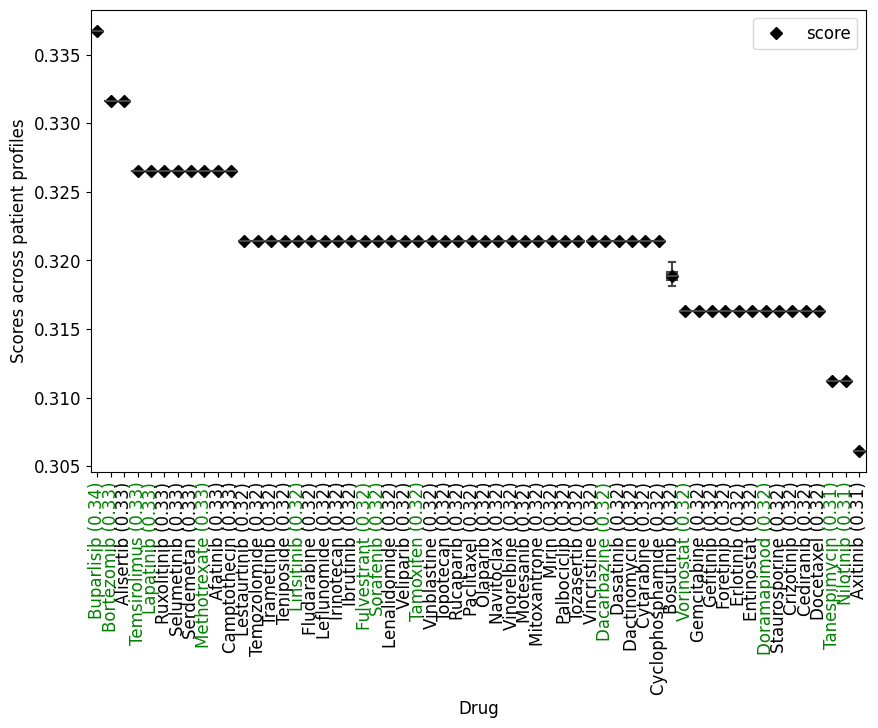

In [35]:
plot_boxplots(scores_meanT, scoresT.T, ground_truth=scores_[["Ground Truth-bin"]], 
              fname=file_folder_DS+"boxplotsT.png")
Image(file_folder_DS+"boxplotsT.png")

#### ii. "BN-based signatures"

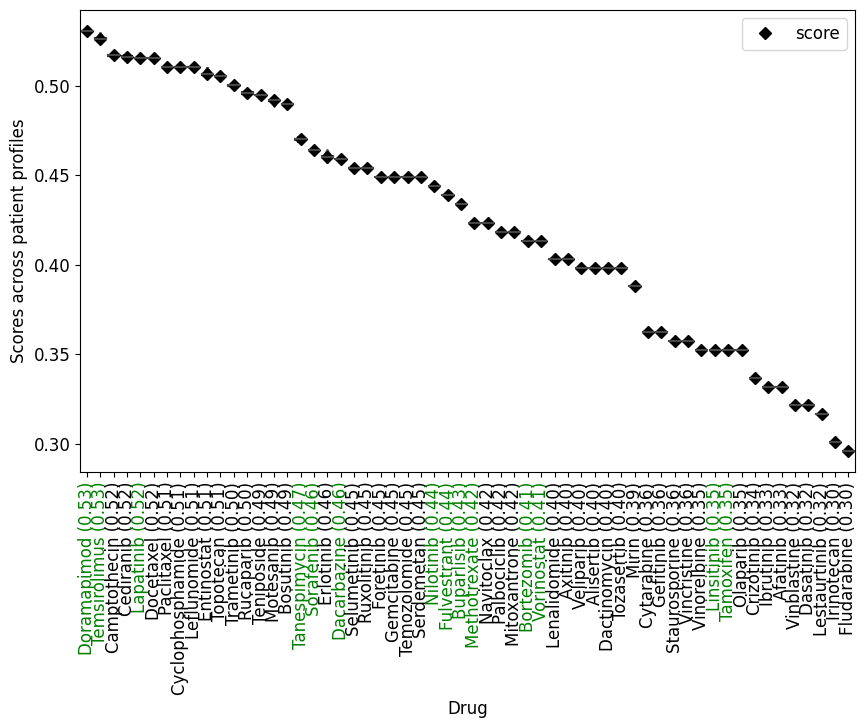

In [36]:
plot_boxplots(scores_mean, scores.T, ground_truth=scores_[["Ground Truth-bin"]], fname=file_folder_DS+"boxplots.png")
Image(file_folder_DS+"boxplots.png")

#### iii. L$1000$ CDS$^2$

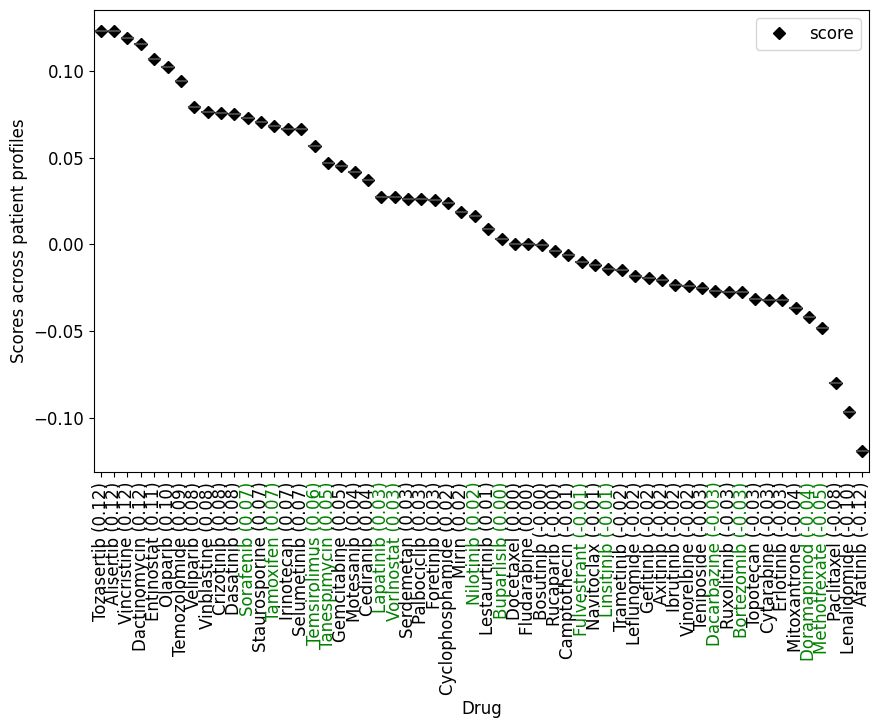

In [37]:
plot_boxplots(scores_[["Cosine Score"]], scores_[["Cosine Score"]], 
              ground_truth=scores_[["Ground Truth-bin"]], fname=file_folder_DS+"boxplots_CS.png")
Image(file_folder_DS+"boxplots_CS.png")

### Plotting the corresponding ROCs

In [86]:
help(plot_roc_curve)

Help on function plot_roc_curve in module NORDic.UTILS.utils_plot:

plot_roc_curve(pr, prs, tr, fname='ROC.pdf', method_name='predictor', fsize=18)
    Plots a ROC curve (with variations across samples)
    @param  pr      Pandas DataFrame: rows/[drug names] x column/[value]
    @param  prs     Pandas DataFrame: rows/[drug names] x columns/[patient samples]
    @param  tr      Pandas DataFrame[default=None]: rows/[drug names] x column/[class] 
    @param  fname   Python character string[default="ROC.pdf"]: file name for the plot
    @param  method_name     Python character string[default="predictor"]: name of the predictor
    @param  fsize   Python integer[default=18]: font size
    @return None



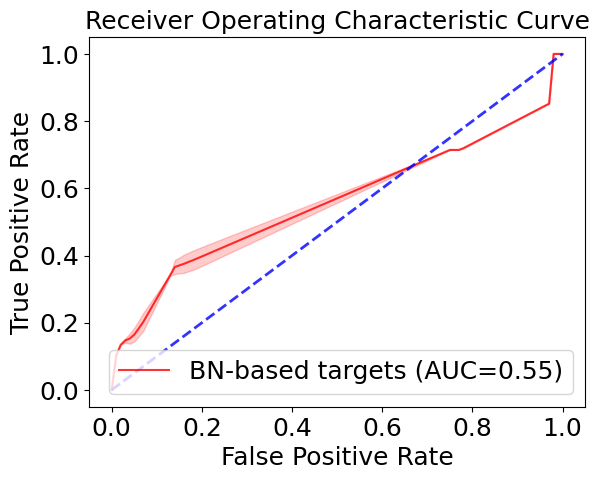

In [8]:
plot_roc_curve(scores_["ScoreT"], scoresT.T, scores_["Ground Truth-bin"], 
               fname=file_folder_DS+"ROCT.png", method_name='BN-based targets')
Image(file_folder_DS+"ROCT.png")

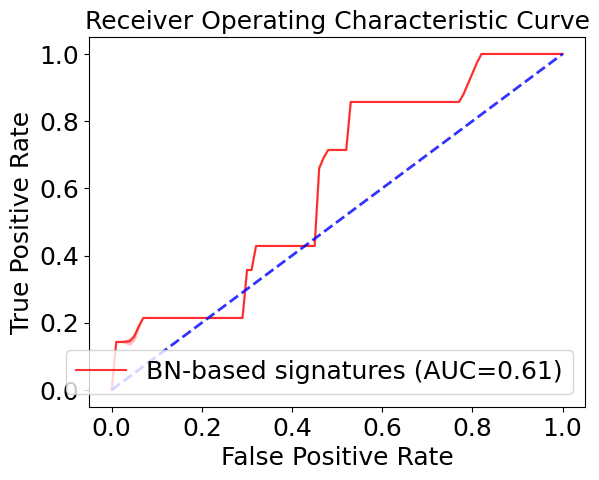

In [39]:
plot_roc_curve(scores_["Score"], scores.T, scores_["Ground Truth-bin"], 
               fname=file_folder_DS+"ROC.png", method_name='BN-based signatures')
Image(file_folder_DS+"ROC.png")

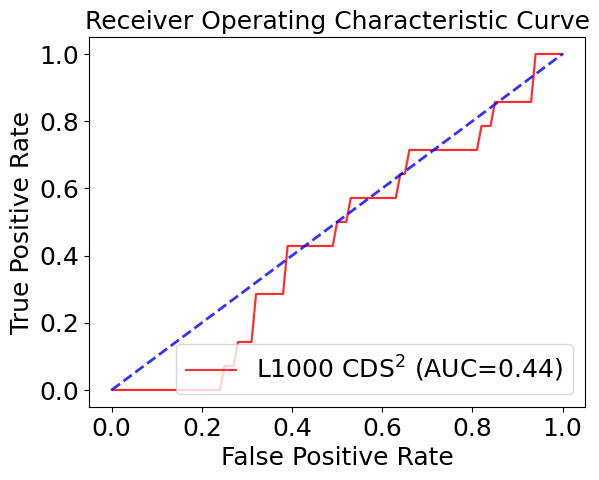

In [40]:
plot_roc_curve(scores_["Cosine Score"], scores_[["Cosine Score"]], scores_["Ground Truth-bin"], 
               fname=file_folder_DS+"ROC_baseline.png", method_name=r'L1000 CDS$^2$')
Image(file_folder_DS+"ROC_baseline.png")

### Plotting the Precision-Recall Curves

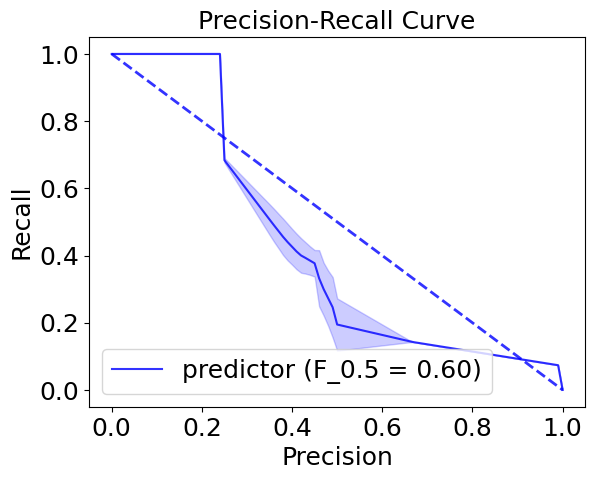

In [43]:
plot_precision_recall(scores_["ScoreT"], scoresT.T, scores_["Ground Truth-bin"], 
                      beta=beta, fname=file_folder_DS+"PRCT.png")
Image(file_folder_DS+"PRCT.png")

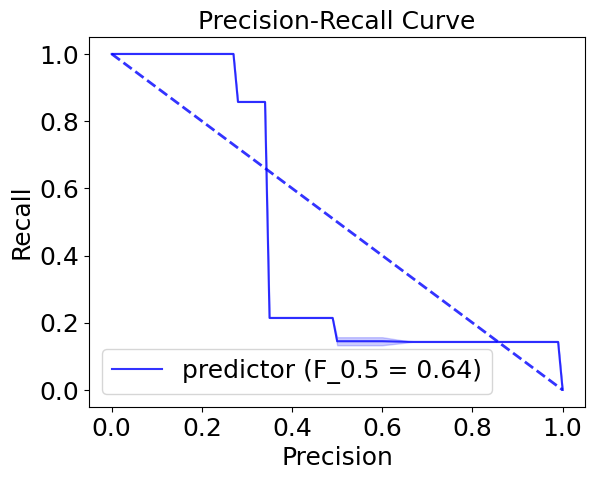

In [44]:
plot_precision_recall(scores_["Score"], scores.T, scores_["Ground Truth-bin"], 
                      beta=beta, fname=file_folder_DS+"PRC.png")
Image(file_folder_DS+"PRC.png")

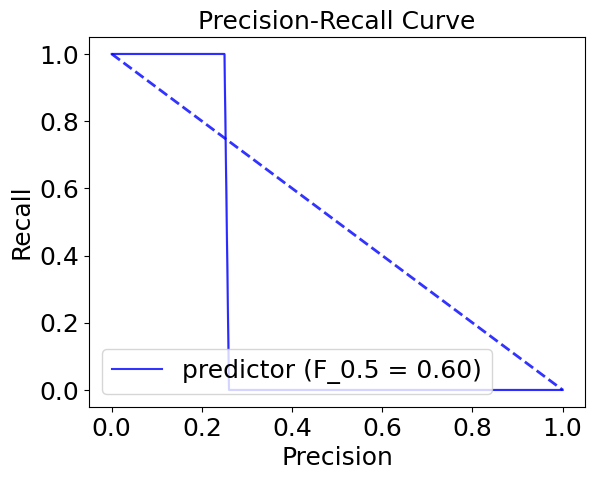

In [45]:
plot_precision_recall(scores_["Cosine Score"], scores_[["Cosine Score"]], scores_["Ground Truth-bin"], 
                      beta=beta, fname=file_folder_DS+"PRC_baseline.png")
Image(file_folder_DS+"PRC_baseline.png")